<a href="https://colab.research.google.com/github/Nilanshrajput/Vqa_detr/blob/master/Detr_vilbert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Object Detection with DETR - a minimal implementation

In this notebook we show a demo of DETR (Detection Transformer), with slight differences with the baseline model in the paper.

We show how to define the model, load pretrained weights and visualize bounding box and class predictions.

Let's start with some common imports.

In [2]:
!pip install transformers

In [0]:
from PIL import Image
import requests
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
import json

import torch
import torch.utils.data as data
from torch import nn
from torchvision.models import resnet50
import torchvision.transforms as T
import os
import json
import tqdm

import logging

import numpy as np
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.autograd import Variable

from transformers.tokenization_bert import BertTokenizer
from transformers import BertConfig, EncoderDecoderConfig, EncoderDecoderModel, BertModel
from transformers import AdamW
from transformers import get_linear_schedule_with_warmup
import torchtext

import pdb
import os

## DETR
Here is a minimal implementation of DETR:

In [0]:
class DETRdemo(nn.Module):
    """
    Demo DETR implementation.

    Demo implementation of DETR in minimal number of lines, with the
    following differences wrt DETR in the paper:
    * learned positional encoding (instead of sine)
    * positional encoding is passed at input (instead of attention)
    * fc bbox predictor (instead of MLP) nj
    The model achieves ~40 AP on COCO val5k and runs at ~28 FPS on Tesla V100.
    Only batch size 1 supported.
    """
    def __init__(self, num_classes, hidden_dim=256, nheads=8,
                 num_encoder_layers=6, num_decoder_layers=6):
        super().__init__()

        # create ResNet-50 backbone
        self.backbone = resnet50()
        del self.backbone.fc

        # create conversion layer
        self.conv = nn.Conv2d(2048, hidden_dim, 1)

        # create a default PyTorch transformer
        self.transformer = nn.Transformer(
            hidden_dim, nheads, num_encoder_layers, num_decoder_layers)

        # prediction heads, one extra class for predicting non-empty slots
        # note that in baseline DETR linear_bbox layer is 3-layer MLP
        self.linear_class = nn.Linear(hidden_dim, num_classes + 1)
        self.linear_bbox = nn.Linear(hidden_dim, 4)

        # output positional encodings (object queries)
        self.query_pos = nn.Parameter(torch.rand(100, hidden_dim))

        # spatial positional encodings
        # note that in baseline DETR we use sine positional encodings
        self.row_embed = nn.Parameter(torch.rand(50, hidden_dim // 2))
        self.col_embed = nn.Parameter(torch.rand(50, hidden_dim // 2))

    def forward(self, inputs):
        # propagate inputs through ResNet-50 up to avg-pool layer
        x = self.backbone.conv1(inputs)
        x = self.backbone.bn1(x)
        x = self.backbone.relu(x)
        x = self.backbone.maxpool(x)

        x = self.backbone.layer1(x)
        x = self.backbone.layer2(x)
        x = self.backbone.layer3(x)
        x = self.backbone.layer4(x)

        # convert from 2048 to 256 feature planes for the transformer
        h = self.conv(x)
        bb_ot = h
        
        # construct positional encodings
        """        H, W = h.shape[-2:]
        pos = torch.cat([
            self.col_embed[:W].unsqueeze(0).repeat(H, 1, 1),
            self.row_embed[:H].unsqueeze(1).repeat(1, W, 1),
        ], dim=-1).flatten(0, 1).unsqueeze(1)"""

        bs,_,H, W = h.shape
        pos = torch.cat([
        self.col_embed[:W].unsqueeze(0).unsqueeze(1).repeat(bs,H, 1, 1),
        self.row_embed[:H].unsqueeze(0).unsqueeze(2).repeat(bs,1, W, 1),
        ], dim=-1).flatten(1, 2)


        #print(self.col_embed[:W].unsqueeze(0).repeat(H, 1, 1))
        # propagate through the transformer
        #shape changed to (W*H,bs,hidden_dim) for both pos and h
        h = self.transformer(pos.permute(1, 0, 2) + 0.1 * h.flatten(2).permute(2, 0, 1),
                             self.query_pos.unsqueeze(1).repeat(1,bs,1)).transpose(0, 1)
        
        # finally project transformer outputs to class labels and bounding boxes
        return {'pred_logits': self.linear_class(h), 
                'pred_boxes': self.linear_bbox(h).sigmoid(),
                'decoder_out':h,
                'res_out':bb_ot}

As you can see, DETR architecture is very simple, thanks to the representational power of the Transformer. There are two main components:
* a convolutional backbone - we use ResNet-50 in this demo
* a Transformer - we use the default PyTorch nn.Transformer


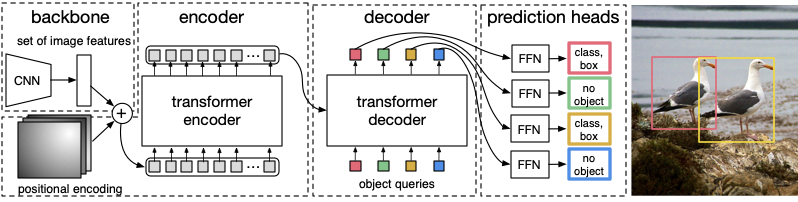

Let's construct the model with 80 COCO output classes + 1 ⦰ "no object" class and load the pretrained weights.
The weights are saved in half precision to save bandwidth without hurting model accuracy.

In [0]:
class VQA_DETR(nn.Module):
    def __init__(self,num_ans, hidden_size=256, num_attention_heads = 8, num_hidden_layers = 6):
        super().__init__()

        self.bert__decoder_config = BertConfig(is_decoder = True,hidden_size=hidden_size, num_attention_heads=num_attention_heads, num_hidden_layers=num_hidden_layers)
        #self.enc_dec_config = EncoderDecoderConfig.from_encoder_decoder_configs(encoder_config= self.bert_config, decoder_config= self.bert_config)
        #self.model = EncoderDecoderModel(config= self.enc_dec_config)
        self.bert_decoder = BertModel(config=self.bert__decoder_config)

        self.detr = DETRdemo(num_classes=91)
        state_dict = torch.hub.load_state_dict_from_url(
            url='https://dl.fbaipublicfiles.com/detr/detr_demo-da2a99e9.pth',
            map_location='cpu', check_hash=True)
        self.detr.load_state_dict(state_dict)
        #self.detr  = self.detr.cuda()

        self.classifier  = nn.Linear(hidden_size*2,num_ans)

        self.drop_out = nn.Dropout(p=0.2)
        self.log_softmax = nn.LogSoftmax().cuda()
        

    def forward(self,img, q_ids):
        
        img_ecs = self.detr(img)['decoder_out'].flatten(2)

        #print(img_ecs.shape)#shape should be(bs. seQ_len, hiddensize)
        #print(q_ids.shape)
        #outputs = self.model(inputs_embeds=img_ecs, decoder_input_ids= q_ids )
        o1,_ = self.bert_decoder(input_ids = q_ids, encoder_hidden_states = img_ecs)

        mean_pool = torch.mean(o1,1)
        max_pool,_ = torch.max(o1,1)
        cat = torch.cat((mean_pool, max_pool),1)

        bo = self.drop_out(cat)
        output = self.classifier(bo)
        
       
        nll = -self.log_softmax(output)

        return {'logits':output,
                'nll':nll}




    

In [0]:
detr = DETRdemo(num_classes=91)
state_dict = torch.hub.load_state_dict_from_url(
    url='https://dl.fbaipublicfiles.com/detr/detr_demo-da2a99e9.pth',
    map_location='cpu', check_hash=True)
detr.load_state_dict(state_dict)
detr.eval();


## Computing predictions with DETR

The pre-trained DETR model that we have just loaded has been trained on the 80 COCO classes, with class indices ranging from 1 to 90 (that's why we considered 91 classes in the model construction).
In the following cells, we define the mapping from class indices to names.

In [0]:
# COCO classes
CLASSES = [
    'N/A', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A',
    'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse',
    'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack',
    'umbrella', 'N/A', 'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis',
    'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove',
    'skateboard', 'surfboard', 'tennis racket', 'bottle', 'N/A', 'wine glass',
    'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich',
    'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake',
    'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table', 'N/A',
    'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard',
    'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A',
    'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier',
    'toothbrush'
]

# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

DETR uses standard ImageNet normalization, and output boxes in relative image coordinates in $[x_{\text{center}}, y_{\text{center}}, w, h]$ format, where $[x_{\text{center}}, y_{\text{center}}]$ is the predicted center of the bounding box, and $w, h$ its width and height. Because the coordinates are relative to the image dimension and lies between $[0, 1]$, we convert predictions to absolute image coordinates and $[x_0, y_0, x_1, y_1]$ format for visualization purposes.

In [0]:
# standard PyTorch mean-std input image normalization
transform = T.Compose([
    T.Resize(size=(800,800)),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# for output bounding box post-processing
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b

Let's put everything together in a `detect` function:

In [0]:
def detect(im, model, transform):
    # mean-std normalize the input image (batch-size: 1)
    img = transform(im)
    img = torch.stack((img,img))
    # propagate through the model
    outputs = model(img)

    # keep only predictions with 0.7+ confidence
    probas = outputs['pred_logits'].softmax(-1)[0, :, :-1]
    keep = probas.max(-1).values > 0.7

    # convert boxes from [0; 1] to image scales
    bboxes_scaled = rescale_bboxes(outputs['pred_boxes'][0, keep], im.size)
    return probas[keep], bboxes_scaled, outputs['decoder_out'],outputs['res_out']

## Using DETR
To try DETRdemo model on your own image just change the URL below.

In [0]:
url = 'http://images.cocodataset.org/val2017/000000039769.jpg'
url2='https://www.sciencemag.org/sites/default/files/styles/article_main_large/public/dogs_1280p_0.jpg?itok=cnRk0HYq'
url3=''
im = Image.open(requests.get(url, stream=True).raw)



In [0]:
scores, boxes,attn_out,h = detect(im, detr, transform)

In [65]:
attn_out.flatten(2).permute(0,2,1).shape

torch.Size([2, 100, 256])

In [0]:
def plot_results(pil_img, prob, boxes):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), COLORS * 100):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        cl = p.argmax()
        text = f'{CLASSES[cl]}: {p[cl]:0.2f}'
        ax.text(xmin, ymin, text, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()
    
plot_results(im, scores, boxes)

In [0]:
h.shape

torch.Size([2, 256, 25, 34])

In [0]:
!wget --header="Host: s3.amazonaws.com" --header="User-Agent: Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/81.0.4044.138 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9" --header="Accept-Language: en-GB,en-US;q=0.9,en;q=0.8" "https://s3.amazonaws.com/cvmlp/vqa/mscoco/vqa/v2_Annotations_Train_mscoco.zip" -c -O 'v2_Annotations_Train_mscoco.zip'

In [7]:
!unzip /content/v2_Annotations_Train_mscoco.zip

Archive:  /content/v2_Annotations_Train_mscoco.zip
  inflating: v2_mscoco_train2014_annotations.json  


In [0]:
!wget --header="Host: images.cocodataset.org" --header="User-Agent: Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/81.0.4044.138 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9" --header="Accept-Language: en-GB,en-US;q=0.9,en;q=0.8" "http://images.cocodataset.org/zips/train2014.zip" -c -O 'train2014.zip'

In [0]:
!unzip train2014.zip

In [0]:
!wget --header="Host: s3.amazonaws.com" --header="User-Agent: Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/81.0.4044.138 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9" --header="Accept-Language: en-GB,en-US;q=0.9,en;q=0.8" "https://s3.amazonaws.com/cvmlp/vqa/mscoco/vqa/v2_Questions_Train_mscoco.zip" -c -O 'v2_Questions_Train_mscoco.zip'

In [0]:
!unzip v2_Questions_Train_mscoco.zip

In [0]:

def assert_eq(real, expected):
    assert real == expected, "%s (true) vs %s (expected)" % (real, expected)

def _create_entry(question, answer):
    answer.pop("image_id")
    answer.pop("question_id")
    entry = {
        "question_id": question["question_id"],
        "image_id": question["image_id"],
        "question": question["question"],
        "answer": [a['answer'] for a in answer['answers']],
    }
    return entry

def _load_dataset(dataroot, name):
    """Load entries
    dataroot: root path of dataset
    name: 'train', 'val', 'trainval', 'minsval'
    """
    if name == 'train' or name == 'val':
        question_path = os.path.join(dataroot, "v2_OpenEnded_mscoco_%s2014_questions.json" % name)
        questions = sorted(json.load(open(question_path))["questions"], key=lambda x: x["question_id"])
        answer_path = os.path.join(dataroot, "v2_mscoco_%s2014_annotations.json" % name)
        answers = json.load(open(answer_path, "rb"))["annotations"]
        answers = sorted(answers, key=lambda x: x["question_id"])

    elif name  == 'trainval':
        question_path_train = os.path.join(dataroot, "v2_OpenEnded_mscoco_%s2014_questions.json" % 'train')
        questions_train = sorted(json.load(open(question_path_train))["questions"], key=lambda x: x["question_id"])
        answer_path_train = os.path.join(dataroot, "v2_mscoco_%s2014_annotations.json" % 'train')
        answers_train = json.load(open(answer_path_train, "rb"))["annotations"]
        answers_train = sorted(answers_train, key=lambda x: x["question_id"])

        question_path_val = os.path.join(dataroot, "v2_OpenEnded_mscoco_%s2014_questions.json" % 'val')
        questions_val = sorted(json.load(open(question_path_val))["questions"], key=lambda x: x["question_id"])
        answer_path_val = os.path.join(dataroot, "v2_mscoco_%s2014_annotations.json" % 'val')
        answers_val = json.load(open(answer_path_val, "rb"))["annotations"]
        answers_val = sorted(answers_val, key=lambda x: x["question_id"])
        questions = questions_train + questions_val[:-3000]
        answers = answers_train + answers_val[:-3000]

    elif name == 'minval':
        question_path_val = os.path.join(dataroot, "v2_OpenEnded_mscoco_%s2014_questions.json" % 'val')
        questions_val = sorted(json.load(open(question_path_val))["questions"], key=lambda x: x["question_id"])
        answer_path_val = os.path.join(dataroot, "v2_mscoco_%s2014_annotations.json" % 'val')
        answers_val = json.load(open(answer_path_val, "rb"))["annotations"]
        answers_val = sorted(answers_val, key=lambda x: x["question_id"])        
        questions = questions_val[-3000:]
        answers = answers_val[-3000:]

    elif name == 'test':
        question_path_test = os.path.join(dataroot, "v2_OpenEnded_mscoco_%s2015_questions.json" % 'test')
        questions_test = sorted(json.load(open(question_path_test))["questions"], key=lambda x: x["question_id"])
        questions = questions_test
    else:
        assert False, "data split is not recognized."

    if 'test' in name:
        entries = []
        for question in questions:
            entries.append(question)
    else:
        assert_eq(len(questions), len(answers))
        entries = []
        for question, answer in zip(questions, answers):
            assert_eq(question["question_id"], answer["question_id"])
            assert_eq(question["image_id"], answer["image_id"])
            entries.append(_create_entry(question, answer))
    return entries

In [0]:
entries = _load_dataset(dataroot='/content/',name='train')

In [0]:
# compile a list of all the answers
all_answers  = set()
for a in entries:
    all_answers.update(a['answer'])
all_answers=list(all_answers)


In [0]:
answer_to_index = dict()
for i,answer in enumerate(all_answers):
    answer_to_index[answer]=i


In [0]:
vqa_detr = VQA_DETR(num_ans=len(answer_to_index))

In [15]:
"""expanded_entries = []

# makes entries with single answer only
def single_entry(answer, answer_id,image_id, question, question_id):
    entry = {
        'answer': answer,
        'answer_id': answer_id,
        'image_id': image_id,
        'question': question,
        'question_id': question_id,
    }

    return entry


for entry in tqdm.tqdm(entries):
    for answer in entry['answer']:
        expanded_entries.append(single_entry(answer, answer_to_index.get(answer), entry['image_id'], entry['question'], entry['question_id']))

"""

"expanded_entries = []\n\n# makes entries with single answer only\ndef single_entry(answer, answer_id,image_id, question, question_id):\n    entry = {\n        'answer': answer,\n        'answer_id': answer_id,\n        'image_id': image_id,\n        'question': question,\n        'question_id': question_id,\n    }\n\n    return entry\n\n\nfor entry in tqdm.tqdm(entries):\n    for answer in entry['answer']:\n        expanded_entries.append(single_entry(answer, answer_to_index.get(answer), entry['image_id'], entry['question'], entry['question_id']))\n\n"

In [16]:
"""def _encode_answers(answers, answer_to_index):
    """ Turn an answer into a vector """
    # answer vec will be a vector of answer counts to determine which answers will contribute to the loss.
    # this should be multiplied with 0.1 * negative log-likelihoods that a model produces and then summed up
    # to get the loss that is weighted by how many humans gave that answer
    answer_vec = torch.zeros(len(answer_to_index))
    for answer in answers:
        index = answer_to_index.get(answer)
        if index is not None:
            answer_vec[index] += 1
    return answer_vec

def add_vec_to_entries(entries, answer_to_index):
    for entry in entries:
        entry['answer_vector']= _encode_answers(entry['answer'], answer_to_index)
    return entries
entries = add_vec_to_entries(entries, answer_to_index)"""

SyntaxError: ignored

In [0]:
"""def _find_iamges():
    id_to_filename = {}
    root = 'train2014'
    for filename in os.listdir('train2014'):
        if not filename.endswith('.jpg'):
            continue
        id_and_extension = filename.split('_')[-1]
        id = int(id_and_extension.split('.')[0])
        id_to_filename[id] = os.path.join(root,filename)
    return id_to_filename


id_to_image_fname=_find_iamges()

img_path = id_to_image_fname[9]
img  = Image.open(img_path)
plt.imshow(img)
"""

In [0]:
class VQA(data.Dataset):
    """ VQA dataset, open-ended """
    def __init__(self, root, answer_to_index, tokenizer ,split = 'train', max_len = 20):
        super(VQA, self).__init__()


        self.root = root
        self.answer_to_index = answer_to_index
        self.split = split
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.entries = self._load_dataset( self.root, self.split)

         # standard PyTorch mean-std input image normalization
        self.transform = T.Compose([
            T.Resize(size=(800,800)),
            T.ToTensor(),
            T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

        self.id_to_image_fname = self._find_iamges()


    def assert_eq(self,real, expected):
        assert real == expected, "%s (true) vs %s (expected)" % (real, expected)

    def _create_entry(self,question, answer):
        answer.pop("image_id")
        answer.pop("question_id")
        entry = {
            "question_id": question["question_id"],
            "image_id": question["image_id"],
            "question": question["question"],
            "answer": [a['answer'] for a in answer['answers']],
        }
        return entry

    def _load_dataset(self,dataroot, name):
        """Load entries
        dataroot: root path of dataset
        name: 'train', 'val', 'trainval', 'minsval'
        """
        if name == 'train' or name == 'val':
            question_path = os.path.join(dataroot, "v2_OpenEnded_mscoco_%s2014_questions.json" % name)
            questions = sorted(json.load(open(question_path))["questions"], key=lambda x: x["question_id"])
            answer_path = os.path.join(dataroot, "v2_mscoco_%s2014_annotations.json" % name)
            answers = json.load(open(answer_path, "rb"))["annotations"]
            answers = sorted(answers, key=lambda x: x["question_id"])

        elif name  == 'trainval':
            question_path_train = os.path.join(dataroot, "v2_OpenEnded_mscoco_%s2014_questions.json" % 'train')
            questions_train = sorted(json.load(open(question_path_train))["questions"], key=lambda x: x["question_id"])
            answer_path_train = os.path.join(dataroot, "v2_mscoco_%s2014_annotations.json" % 'train')
            answers_train = json.load(open(answer_path_train, "rb"))["annotations"]
            answers_train = sorted(answers_train, key=lambda x: x["question_id"])

            question_path_val = os.path.join(dataroot, "v2_OpenEnded_mscoco_%s2014_questions.json" % 'val')
            questions_val = sorted(json.load(open(question_path_val))["questions"], key=lambda x: x["question_id"])
            answer_path_val = os.path.join(dataroot, "v2_mscoco_%s2014_annotations.json" % 'val')
            answers_val = json.load(open(answer_path_val, "rb"))["annotations"]
            answers_val = sorted(answers_val, key=lambda x: x["question_id"])
            questions = questions_train + questions_val[:-3000]
            answers = answers_train + answers_val[:-3000]

        elif name == 'minval':
            question_path_val = os.path.join(dataroot, "v2_OpenEnded_mscoco_%s2014_questions.json" % 'val')
            questions_val = sorted(json.load(open(question_path_val))["questions"], key=lambda x: x["question_id"])
            answer_path_val = os.path.join(dataroot, "v2_mscoco_%s2014_annotations.json" % 'val')
            answers_val = json.load(open(answer_path_val, "rb"))["annotations"]
            answers_val = sorted(answers_val, key=lambda x: x["question_id"])        
            questions = questions_val[-3000:]
            answers = answers_val[-3000:]

        elif name == 'test':
            question_path_test = os.path.join(dataroot, "v2_OpenEnded_mscoco_%s2015_questions.json" % 'test')
            questions_test = sorted(json.load(open(question_path_test))["questions"], key=lambda x: x["question_id"])
            questions = questions_test
        else:
            assert False, "data split is not recognized."

        if 'test' in name:
            entries = []
            for question in questions:
                entries.append(question)
        else:
            assert_eq(len(questions), len(answers))
            entries = []
            for question, answer in zip(questions, answers):
                assert_eq(question["question_id"], answer["question_id"])
                assert_eq(question["image_id"], answer["image_id"])
                entries.append(_create_entry(question, answer))
        return entries



    def _encode_question(self, question):
        """ Turn a question into a vector of indices and a question length """
        
        inputs = self.tokenizer.encode_plus(
            question,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            )

        ids = inputs["input_ids"]
        mask = inputs["attention_mask"]
        token_type_ids = inputs["token_type_ids"]

        padding_length = self.max_len - len(ids)
        ids += ([0]*padding_length)
        mask += ([0]*padding_length)
        token_type_ids += ([0]*padding_length)
        
        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            
        }

    def _encode_ansfor_bert(self, answers):
        pass


    def _encode_answers(self, answers):
        """ Turn an answer into a vector """
        # answer vec will be a vector of answer counts to determine which answers will contribute to the loss.
        # this should be multiplied with 0.1 * negative log-likelihoods that a model produces and then summed up
        # to get the loss that is weighted by how many humans gave that answer
        answer_vec = torch.zeros(len(self.answer_to_index),dtype=torch.long)
        for answer in answers:
            index = self.answer_to_index.get(answer)
            if index is not None:
                answer_vec[index] += 1
        _,idx = answer_vec.max(dim = 0)
        idx = torch.tensor(idx, dtype = torch.long)

        return idx

   
    def _find_iamges(self):
        id_to_filename = {}
        imgs_folder = os.path.join(self.root,'train2014')
        for filename in os.listdir(imgs_folder):
            if not filename.endswith('.jpg'):
                continue
            id_and_extension = filename.split('_')[-1]
            id = int(id_and_extension.split('.')[0])
            id_to_filename[id] = os.path.join(imgs_folder,filename)
        return id_to_filename


    def _load_image(self, image_id):
        """ Load an image """

        img_path = self.id_to_image_fname[image_id]
        img  = Image.open(img_path)
        img = np.asarray(img)
        
        if len(img.shape)==2:
            print(img.shape)
            img=np.expand_dims(img, axis=-1)
            
            img = np.repeat(img,3, axis = -1)
            print(img.shape)

        return img

    def __getitem__(self, item):
       
        entry  = self.entries[item]
        q = entry['question']
        a = self._encode_answers(entry['answer'])
        image_id = entry['image_id']

        img = self._load_image(image_id)
        img = Image.fromarray(img)
        img = self.transform(img)
        #question_id = entry['question_id']
        q= self._encode_question(q)

        return img, q, a

    def __len__(self):
        return len(self.entries)

    @staticmethod
    def collate_fn(batch):
        """The collat_fn method to be used by the
        PyTorch data loader.
        """
        
        # Unzip the batch

        imgs,qs, answers = list(zip(*batch))

        # concatenate the vectors
        imgs = torch.stack(imgs)
        
        #concatenate the labels
        q = torch.stack(qs)

        a = torch.stack(answers)
        
        return imgs, q, a

In [0]:
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

In [0]:
vqa_data = VQA(root='/content', answer_to_index=answer_to_index,split= 'train', tokenizer=bert_tokenizer, max_len=15 )

In [0]:
data_loader = DataLoader(vqa_data, batch_size = 4, shuffle= True)

In [0]:

def loss_fn(outputs, targets):
    
    #print(outputs.shape)
    with torch.enable_grad():
        loss  = nn.CrossEntropyLoss()(outputs, targets)
        loss.requres_grad = True
    
   
    return loss


def train_fn(data_loader, model, optimizer, device, scheduler):
    model.train()
    loss_v=0
    for bi, data in tqdm.tqdm(enumerate(data_loader), total=len(data_loader)):
        im,q,a  = data
        ids = q["ids"]
        
        targets = a

        ids = ids.to(device, dtype=torch.long)
        targets = targets.to(device, dtype=torch.long )
        im = im.to(device)

        optimizer.zero_grad()
        outputs = model(
            im,ids
        )

        output =outputs['logits'].to(device)
        #print(output.dtype)

        
        #a,targets=torch.max(output,dim = 1)
        #targets = targets.to(device, dtype=torch.long)
        #targets = Variable(targets)
 
       
        loss = loss_fn(output, targets)
        loss.backward()
        loss_v+= loss.item()
        print(loss.item())
        optimizer.step()
        scheduler.step()

    return loss_v


In [0]:
bs = 16
epochs = 10

In [15]:

device = torch.device("cuda")
model = vqa_detr
for param in model.parameters():
    param.requires_grad = True
model.to(device)


param_optimizer = list(model.named_parameters())
no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
optimizer_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.001},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0},
]

num_train_steps = int(len(vqa_data )/ bs * epochs)
optimizer = AdamW(optimizer_parameters, lr=3e-5)
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=num_train_steps
)



for epoch in range(epochs):
    loss = train_fn(data_loader, model, optimizer, device, scheduler)

    print(f'The loss for epoch {epoch} = {loss}')

    

  0%|          | 0/110940 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:137: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  0%|          | 1/110940 [00:01<56:04:42,  1.82s/it]

12.775640487670898


  0%|          | 2/110940 [00:03<55:33:16,  1.80s/it]

12.003267288208008


  0%|          | 3/110940 [00:05<55:00:00,  1.78s/it]

11.416314125061035


  0%|          | 4/110940 [00:07<54:34:54,  1.77s/it]

11.602282524108887


  0%|          | 5/110940 [00:08<54:33:45,  1.77s/it]

10.94884204864502


  0%|          | 6/110940 [00:10<54:33:03,  1.77s/it]

12.284679412841797


  0%|          | 7/110940 [00:12<54:25:03,  1.77s/it]

11.455453872680664


  0%|          | 8/110940 [00:14<54:14:35,  1.76s/it]

11.452476501464844


  0%|          | 9/110940 [00:15<54:26:40,  1.77s/it]

11.808570861816406


  0%|          | 10/110940 [00:17<54:35:05,  1.77s/it]

11.334195137023926


  0%|          | 11/110940 [00:19<54:31:43,  1.77s/it]

11.221923828125


  0%|          | 12/110940 [00:21<54:19:59,  1.76s/it]

11.720672607421875


  0%|          | 13/110940 [00:22<54:42:29,  1.78s/it]

10.03298568725586
(486, 640)
(486, 640, 3)


  0%|          | 14/110940 [00:24<54:46:20,  1.78s/it]

10.547409057617188


  0%|          | 15/110940 [00:26<54:51:06,  1.78s/it]

10.431927680969238


  0%|          | 16/110940 [00:28<54:41:59,  1.78s/it]

12.36236572265625


  0%|          | 17/110940 [00:30<54:37:24,  1.77s/it]

11.93825626373291


  0%|          | 18/110940 [00:31<54:43:41,  1.78s/it]

9.883411407470703


  0%|          | 19/110940 [00:33<54:39:41,  1.77s/it]

11.036683082580566


  0%|          | 20/110940 [00:35<54:29:08,  1.77s/it]

8.542243003845215


  0%|          | 21/110940 [00:37<54:27:34,  1.77s/it]

10.628192901611328


  0%|          | 22/110940 [00:38<54:20:53,  1.76s/it]

11.002452850341797


  0%|          | 23/110940 [00:40<54:14:52,  1.76s/it]

9.967791557312012


  0%|          | 24/110940 [00:42<53:56:38,  1.75s/it]

9.96988582611084


  0%|          | 25/110940 [00:44<54:17:01,  1.76s/it]

10.250344276428223


  0%|          | 26/110940 [00:45<54:18:02,  1.76s/it]

8.14598560333252


  0%|          | 27/110940 [00:47<54:23:44,  1.77s/it]

7.647228240966797


  0%|          | 28/110940 [00:49<54:08:10,  1.76s/it]

10.016029357910156


  0%|          | 29/110940 [00:51<54:20:03,  1.76s/it]

10.412988662719727


  0%|          | 30/110940 [00:53<54:21:37,  1.76s/it]

9.321379661560059


  0%|          | 31/110940 [00:54<54:18:48,  1.76s/it]

11.05581283569336
(427, 640)
(427, 640, 3)


  0%|          | 32/110940 [00:56<54:02:20,  1.75s/it]

9.813589096069336


  0%|          | 33/110940 [00:58<54:12:08,  1.76s/it]

9.154290199279785


  0%|          | 34/110940 [01:00<54:18:43,  1.76s/it]

11.340539932250977


  0%|          | 35/110940 [01:01<54:09:55,  1.76s/it]

11.323023796081543


  0%|          | 36/110940 [01:03<53:55:53,  1.75s/it]

11.969432830810547


  0%|          | 37/110940 [01:05<54:10:29,  1.76s/it]

7.134513854980469


  0%|          | 38/110940 [01:07<54:07:00,  1.76s/it]

6.735393047332764


  0%|          | 39/110940 [01:08<54:03:37,  1.75s/it]

5.715041637420654


  0%|          | 40/110940 [01:10<53:51:05,  1.75s/it]

10.444046974182129


  0%|          | 41/110940 [01:12<53:58:50,  1.75s/it]

9.45016860961914


  0%|          | 42/110940 [01:14<53:57:31,  1.75s/it]

10.681453704833984


  0%|          | 43/110940 [01:15<53:59:43,  1.75s/it]

6.856429576873779


  0%|          | 44/110940 [01:17<53:49:24,  1.75s/it]

10.804067611694336


  0%|          | 45/110940 [01:19<53:58:17,  1.75s/it]

12.185327529907227


  0%|          | 46/110940 [01:21<54:06:31,  1.76s/it]

8.266422271728516


  0%|          | 47/110940 [01:22<53:56:17,  1.75s/it]

10.325288772583008


  0%|          | 48/110940 [01:24<53:52:52,  1.75s/it]

10.85397720336914


  0%|          | 49/110940 [01:26<53:49:30,  1.75s/it]

9.875032424926758


  0%|          | 50/110940 [01:28<53:55:11,  1.75s/it]

10.155637741088867


  0%|          | 51/110940 [01:29<53:51:41,  1.75s/it]

7.504671096801758


  0%|          | 52/110940 [01:31<53:50:39,  1.75s/it]

6.619775772094727


  0%|          | 53/110940 [01:33<53:54:29,  1.75s/it]

10.023661613464355


  0%|          | 54/110940 [01:35<53:52:49,  1.75s/it]

10.9837007522583


  0%|          | 55/110940 [01:36<53:52:58,  1.75s/it]

8.774676322937012


  0%|          | 56/110940 [01:38<53:37:54,  1.74s/it]

10.005670547485352


  0%|          | 57/110940 [01:40<53:56:24,  1.75s/it]

8.198442459106445


  0%|          | 58/110940 [01:42<54:05:26,  1.76s/it]

10.09572696685791


  0%|          | 59/110940 [01:43<54:05:03,  1.76s/it]

8.250799179077148


  0%|          | 60/110940 [01:45<53:44:18,  1.74s/it]

10.471102714538574


  0%|          | 61/110940 [01:47<53:41:07,  1.74s/it]

9.464463233947754


  0%|          | 62/110940 [01:49<53:52:54,  1.75s/it]

10.414142608642578


  0%|          | 63/110940 [01:50<53:56:27,  1.75s/it]

5.063365459442139


  0%|          | 64/110940 [01:52<53:38:08,  1.74s/it]

9.32552433013916


  0%|          | 65/110940 [01:54<53:55:54,  1.75s/it]

10.24238395690918


  0%|          | 66/110940 [01:56<54:03:25,  1.76s/it]

7.228706359863281


  0%|          | 67/110940 [01:57<54:01:06,  1.75s/it]

8.14470386505127


  0%|          | 68/110940 [01:59<53:46:43,  1.75s/it]

11.965295791625977


  0%|          | 69/110940 [02:01<53:54:39,  1.75s/it]

12.268099784851074


  0%|          | 70/110940 [02:03<54:03:31,  1.76s/it]

8.05095100402832


  0%|          | 71/110940 [02:04<53:50:56,  1.75s/it]

7.064421653747559


  0%|          | 72/110940 [02:06<53:45:50,  1.75s/it]

8.281108856201172


  0%|          | 73/110940 [02:08<53:55:35,  1.75s/it]

11.542713165283203


  0%|          | 74/110940 [02:10<54:12:03,  1.76s/it]

11.403042793273926


  0%|          | 75/110940 [02:11<53:54:27,  1.75s/it]

8.46870231628418


  0%|          | 76/110940 [02:13<53:37:27,  1.74s/it]

10.339313507080078


  0%|          | 77/110940 [02:15<53:51:20,  1.75s/it]

11.527036666870117


  0%|          | 78/110940 [02:17<54:04:43,  1.76s/it]

8.400327682495117


  0%|          | 79/110940 [02:18<54:03:44,  1.76s/it]

8.664135932922363


  0%|          | 80/110940 [02:20<53:35:25,  1.74s/it]

8.314358711242676


  0%|          | 81/110940 [02:22<53:45:40,  1.75s/it]

6.969291687011719


  0%|          | 82/110940 [02:24<53:47:30,  1.75s/it]

8.466129302978516


  0%|          | 83/110940 [02:25<53:44:46,  1.75s/it]

10.279788970947266


  0%|          | 84/110940 [02:27<53:36:26,  1.74s/it]

9.147411346435547


  0%|          | 85/110940 [02:29<53:39:24,  1.74s/it]

10.013837814331055


  0%|          | 86/110940 [02:31<53:51:48,  1.75s/it]

6.610167503356934


  0%|          | 87/110940 [02:32<53:57:05,  1.75s/it]

5.80950927734375


  0%|          | 88/110940 [02:34<53:51:13,  1.75s/it]

6.195711135864258


  0%|          | 89/110940 [02:36<53:59:06,  1.75s/it]

8.591415405273438


  0%|          | 90/110940 [02:38<53:53:47,  1.75s/it]

9.922654151916504
(640, 508)
(640, 508, 3)


  0%|          | 91/110940 [02:39<53:56:28,  1.75s/it]

9.923162460327148


  0%|          | 92/110940 [02:41<53:47:13,  1.75s/it]

10.185063362121582


  0%|          | 93/110940 [02:43<53:51:33,  1.75s/it]

9.778664588928223


  0%|          | 94/110940 [02:45<53:54:04,  1.75s/it]

6.928227424621582


  0%|          | 95/110940 [02:46<53:53:19,  1.75s/it]

10.078079223632812


  0%|          | 96/110940 [02:48<53:38:20,  1.74s/it]

6.266812801361084


  0%|          | 97/110940 [02:50<53:48:17,  1.75s/it]

9.688812255859375


  0%|          | 98/110940 [02:52<54:01:34,  1.75s/it]

8.474492073059082


  0%|          | 99/110940 [02:53<53:58:26,  1.75s/it]

11.88991641998291


  0%|          | 100/110940 [02:55<53:41:47,  1.74s/it]

8.331734657287598


  0%|          | 101/110940 [02:57<53:51:23,  1.75s/it]

5.700305461883545


  0%|          | 102/110940 [02:59<53:59:21,  1.75s/it]

9.182943344116211


  0%|          | 103/110940 [03:00<53:55:30,  1.75s/it]

8.214734077453613


  0%|          | 104/110940 [03:02<53:42:48,  1.74s/it]

8.826191902160645


  0%|          | 105/110940 [03:04<53:49:21,  1.75s/it]

10.23354721069336


  0%|          | 106/110940 [03:06<54:07:04,  1.76s/it]

6.023694038391113


  0%|          | 107/110940 [03:07<54:00:45,  1.75s/it]

9.067136764526367


  0%|          | 108/110940 [03:09<53:48:28,  1.75s/it]

11.564140319824219


  0%|          | 109/110940 [03:11<53:54:38,  1.75s/it]

7.185814380645752


  0%|          | 110/110940 [03:13<53:47:26,  1.75s/it]

7.637312889099121


  0%|          | 111/110940 [03:14<54:01:40,  1.75s/it]

12.083508491516113


  0%|          | 112/110940 [03:16<53:48:55,  1.75s/it]

8.109386444091797


  0%|          | 113/110940 [03:18<54:14:22,  1.76s/it]

6.613547325134277


  0%|          | 114/110940 [03:20<54:07:22,  1.76s/it]

7.752561569213867


  0%|          | 115/110940 [03:21<54:11:02,  1.76s/it]

8.372052192687988


  0%|          | 116/110940 [03:23<53:49:27,  1.75s/it]

12.07091999053955


  0%|          | 117/110940 [03:25<54:03:00,  1.76s/it]

7.328554630279541


  0%|          | 118/110940 [03:27<54:01:18,  1.75s/it]

8.060564994812012


  0%|          | 119/110940 [03:28<54:11:18,  1.76s/it]

9.024139404296875


  0%|          | 120/110940 [03:30<53:52:08,  1.75s/it]

10.130827903747559


  0%|          | 121/110940 [03:32<54:03:33,  1.76s/it]

8.326025009155273


  0%|          | 122/110940 [03:34<54:03:13,  1.76s/it]

9.145624160766602


  0%|          | 123/110940 [03:35<53:46:38,  1.75s/it]

5.537878036499023


  0%|          | 124/110940 [03:37<53:28:46,  1.74s/it]

5.894573211669922


  0%|          | 125/110940 [03:39<53:51:13,  1.75s/it]

7.390185832977295


  0%|          | 126/110940 [03:41<53:55:25,  1.75s/it]

7.629443168640137


  0%|          | 127/110940 [03:42<53:58:49,  1.75s/it]

10.171472549438477


  0%|          | 128/110940 [03:44<53:41:46,  1.74s/it]

10.65372085571289


  0%|          | 129/110940 [03:46<53:48:42,  1.75s/it]

9.824527740478516


  0%|          | 130/110940 [03:48<53:54:23,  1.75s/it]

7.894941329956055


  0%|          | 131/110940 [03:49<54:10:29,  1.76s/it]

7.878665924072266


  0%|          | 132/110940 [03:51<53:54:46,  1.75s/it]

11.784820556640625


  0%|          | 133/110940 [03:53<53:50:03,  1.75s/it]

9.432161331176758


  0%|          | 134/110940 [03:55<53:50:37,  1.75s/it]

9.358111381530762


  0%|          | 135/110940 [03:56<53:47:37,  1.75s/it]

7.385692596435547


  0%|          | 136/110940 [03:58<53:35:24,  1.74s/it]

9.10023021697998


  0%|          | 137/110940 [04:00<53:44:27,  1.75s/it]

9.539898872375488


  0%|          | 138/110940 [04:02<53:49:17,  1.75s/it]

7.267160892486572


  0%|          | 139/110940 [04:03<53:47:28,  1.75s/it]

9.330038070678711


  0%|          | 140/110940 [04:05<53:47:36,  1.75s/it]

10.30744457244873


  0%|          | 141/110940 [04:07<54:00:24,  1.75s/it]

11.480201721191406


  0%|          | 142/110940 [04:09<53:54:34,  1.75s/it]

9.461736679077148


  0%|          | 143/110940 [04:10<53:51:16,  1.75s/it]

4.543672561645508
(640, 514)
(640, 514, 3)


  0%|          | 144/110940 [04:12<53:45:15,  1.75s/it]

4.465978622436523


  0%|          | 145/110940 [04:14<53:58:31,  1.75s/it]

7.487165451049805


  0%|          | 146/110940 [04:16<53:52:36,  1.75s/it]

7.749485969543457


  0%|          | 147/110940 [04:17<53:56:54,  1.75s/it]

5.470006942749023


  0%|          | 148/110940 [04:19<53:36:04,  1.74s/it]

9.496328353881836


  0%|          | 149/110940 [04:21<53:44:14,  1.75s/it]

9.964147567749023


  0%|          | 150/110940 [04:23<53:40:19,  1.74s/it]

4.996996879577637


  0%|          | 151/110940 [04:24<53:35:02,  1.74s/it]

10.123493194580078


  0%|          | 152/110940 [04:26<53:20:44,  1.73s/it]

8.371991157531738


  0%|          | 153/110940 [04:28<53:46:38,  1.75s/it]

8.097149848937988


  0%|          | 154/110940 [04:30<53:51:43,  1.75s/it]

5.535543918609619


  0%|          | 155/110940 [04:31<53:59:31,  1.75s/it]

6.85996675491333


  0%|          | 156/110940 [04:33<53:45:45,  1.75s/it]

9.383577346801758


  0%|          | 157/110940 [04:35<54:15:22,  1.76s/it]

7.512475490570068


  0%|          | 158/110940 [04:37<54:06:44,  1.76s/it]

10.162805557250977


  0%|          | 159/110940 [04:38<53:48:02,  1.75s/it]

6.979087829589844


  0%|          | 160/110940 [04:40<53:36:13,  1.74s/it]

10.134235382080078


  0%|          | 161/110940 [04:42<53:36:09,  1.74s/it]

12.132704734802246


  0%|          | 162/110940 [04:44<53:41:42,  1.74s/it]

7.24046516418457


  0%|          | 163/110940 [04:45<53:40:47,  1.74s/it]

9.294363975524902


  0%|          | 164/110940 [04:47<53:36:38,  1.74s/it]

8.695269584655762


  0%|          | 165/110940 [04:49<53:41:59,  1.75s/it]

8.91677188873291


  0%|          | 166/110940 [04:50<53:53:32,  1.75s/it]

12.67496395111084


  0%|          | 167/110940 [04:52<53:46:56,  1.75s/it]

9.510260581970215


  0%|          | 168/110940 [04:54<53:30:41,  1.74s/it]

8.214032173156738


  0%|          | 169/110940 [04:56<53:33:30,  1.74s/it]

6.716483116149902


  0%|          | 170/110940 [04:57<53:39:55,  1.74s/it]

7.130359649658203


  0%|          | 171/110940 [04:59<53:37:43,  1.74s/it]

4.9300947189331055


  0%|          | 172/110940 [05:01<53:23:27,  1.74s/it]

6.895374298095703


  0%|          | 173/110940 [05:03<53:30:01,  1.74s/it]

8.8486909866333
(493, 640)
(493, 640, 3)


  0%|          | 174/110940 [05:04<53:35:19,  1.74s/it]

7.41695499420166


  0%|          | 175/110940 [05:06<53:41:44,  1.75s/it]

11.555646896362305


  0%|          | 176/110940 [05:08<53:30:45,  1.74s/it]

10.804252624511719


  0%|          | 177/110940 [05:10<53:37:44,  1.74s/it]

11.012823104858398


  0%|          | 178/110940 [05:11<53:42:11,  1.75s/it]

7.983391761779785


  0%|          | 179/110940 [05:13<53:51:06,  1.75s/it]

7.812038421630859


  0%|          | 180/110940 [05:15<53:24:40,  1.74s/it]

9.003307342529297


  0%|          | 181/110940 [05:17<53:38:58,  1.74s/it]

4.407262802124023


  0%|          | 182/110940 [05:18<53:43:38,  1.75s/it]

10.324987411499023


  0%|          | 183/110940 [05:20<53:41:54,  1.75s/it]

6.369906902313232


  0%|          | 184/110940 [05:22<53:26:44,  1.74s/it]

8.54784107208252


  0%|          | 185/110940 [05:24<53:41:16,  1.75s/it]

10.042476654052734


  0%|          | 186/110940 [05:25<53:50:49,  1.75s/it]

6.516871452331543


  0%|          | 187/110940 [05:27<54:03:31,  1.76s/it]

9.498281478881836


  0%|          | 188/110940 [05:29<53:45:02,  1.75s/it]

9.397603988647461


  0%|          | 189/110940 [05:31<53:56:05,  1.75s/it]

9.688056945800781


  0%|          | 190/110940 [05:32<53:57:20,  1.75s/it]

3.8140552043914795


  0%|          | 191/110940 [05:34<53:50:01,  1.75s/it]

9.022451400756836


  0%|          | 192/110940 [05:36<53:44:11,  1.75s/it]

8.541997909545898


  0%|          | 193/110940 [05:38<53:49:47,  1.75s/it]

7.822138786315918


  0%|          | 194/110940 [05:39<53:59:17,  1.75s/it]

10.360986709594727


  0%|          | 195/110940 [05:41<53:56:12,  1.75s/it]

11.652810096740723


  0%|          | 196/110940 [05:43<53:51:19,  1.75s/it]

9.716845512390137


  0%|          | 197/110940 [05:45<53:53:06,  1.75s/it]

9.692411422729492


  0%|          | 198/110940 [05:46<54:02:45,  1.76s/it]

6.441585540771484


  0%|          | 199/110940 [05:48<53:58:18,  1.75s/it]

4.744051933288574


  0%|          | 200/110940 [05:50<53:38:02,  1.74s/it]

8.391773223876953


  0%|          | 201/110940 [05:52<53:53:52,  1.75s/it]

10.613821029663086


  0%|          | 202/110940 [05:53<53:52:09,  1.75s/it]

4.465271949768066


  0%|          | 203/110940 [05:55<53:45:59,  1.75s/it]

9.91170883178711


  0%|          | 204/110940 [05:57<53:38:40,  1.74s/it]

9.459145545959473


  0%|          | 205/110940 [05:59<53:45:34,  1.75s/it]

7.384594440460205


  0%|          | 206/110940 [06:00<53:45:01,  1.75s/it]

8.751734733581543


  0%|          | 207/110940 [06:02<53:32:19,  1.74s/it]

8.116989135742188


  0%|          | 208/110940 [06:04<53:21:22,  1.73s/it]

6.5603132247924805


  0%|          | 209/110940 [06:06<53:21:38,  1.73s/it]

6.813577651977539


  0%|          | 210/110940 [06:07<53:23:12,  1.74s/it]

6.764329433441162


  0%|          | 211/110940 [06:09<53:45:44,  1.75s/it]

7.827436447143555


  0%|          | 212/110940 [06:11<53:39:47,  1.74s/it]

6.840190887451172


  0%|          | 213/110940 [06:13<53:57:19,  1.75s/it]

7.2559404373168945


  0%|          | 214/110940 [06:14<54:00:47,  1.76s/it]

7.167403221130371


  0%|          | 215/110940 [06:16<53:49:16,  1.75s/it]

6.401423454284668


  0%|          | 216/110940 [06:18<53:39:23,  1.74s/it]

9.719831466674805


  0%|          | 217/110940 [06:20<53:45:28,  1.75s/it]

6.689598560333252


  0%|          | 218/110940 [06:21<53:49:26,  1.75s/it]

7.709072589874268


  0%|          | 219/110940 [06:23<53:42:15,  1.75s/it]

6.756162166595459


  0%|          | 220/110940 [06:25<53:28:52,  1.74s/it]

7.1861724853515625


  0%|          | 221/110940 [06:27<53:44:08,  1.75s/it]

4.237015247344971
(489, 640)
(489, 640, 3)


  0%|          | 222/110940 [06:28<53:45:31,  1.75s/it]

8.320924758911133


  0%|          | 223/110940 [06:30<53:38:21,  1.74s/it]

6.022215366363525


  0%|          | 224/110940 [06:32<53:20:20,  1.73s/it]

6.768547058105469


  0%|          | 225/110940 [06:33<53:29:05,  1.74s/it]

6.289369583129883


  0%|          | 226/110940 [06:35<53:37:47,  1.74s/it]

8.969779968261719


  0%|          | 227/110940 [06:37<53:42:12,  1.75s/it]

11.031206130981445


  0%|          | 228/110940 [06:39<53:22:15,  1.74s/it]

9.699386596679688


  0%|          | 229/110940 [06:40<53:25:29,  1.74s/it]

8.136942863464355


  0%|          | 230/110940 [06:42<53:25:30,  1.74s/it]

7.647770881652832


  0%|          | 231/110940 [06:44<53:29:18,  1.74s/it]

11.901898384094238


  0%|          | 232/110940 [06:46<53:17:47,  1.73s/it]

8.829368591308594


  0%|          | 233/110940 [06:47<53:32:32,  1.74s/it]

4.52551794052124


  0%|          | 234/110940 [06:49<53:49:27,  1.75s/it]

5.217739582061768


  0%|          | 235/110940 [06:51<53:46:06,  1.75s/it]

7.997287750244141


  0%|          | 236/110940 [06:53<53:35:08,  1.74s/it]

7.101400375366211


  0%|          | 237/110940 [06:54<53:44:08,  1.75s/it]

8.715045928955078


  0%|          | 238/110940 [06:56<53:55:19,  1.75s/it]

8.287164688110352


  0%|          | 239/110940 [06:58<54:02:04,  1.76s/it]

12.331596374511719


  0%|          | 240/110940 [07:00<53:46:33,  1.75s/it]

4.424838066101074


  0%|          | 241/110940 [07:01<53:54:53,  1.75s/it]

6.026153564453125


  0%|          | 242/110940 [07:03<54:02:11,  1.76s/it]

7.9089813232421875


  0%|          | 243/110940 [07:05<53:57:50,  1.75s/it]

9.223002433776855


  0%|          | 244/110940 [07:07<53:39:49,  1.75s/it]

8.523839950561523


  0%|          | 245/110940 [07:08<53:57:32,  1.75s/it]

5.056607723236084


  0%|          | 246/110940 [07:10<54:13:10,  1.76s/it]

6.245938301086426


  0%|          | 247/110940 [07:12<53:59:34,  1.76s/it]

3.6731979846954346


  0%|          | 248/110940 [07:14<53:46:39,  1.75s/it]

10.328960418701172


  0%|          | 249/110940 [07:15<53:55:10,  1.75s/it]

5.238159656524658


  0%|          | 250/110940 [07:17<53:59:17,  1.76s/it]

9.110319137573242


  0%|          | 251/110940 [07:19<53:53:14,  1.75s/it]

9.898224830627441


  0%|          | 252/110940 [07:21<53:48:05,  1.75s/it]

4.872941017150879


  0%|          | 253/110940 [07:22<54:01:22,  1.76s/it]

3.1091370582580566


  0%|          | 254/110940 [07:24<53:56:01,  1.75s/it]

4.238455772399902


  0%|          | 255/110940 [07:26<54:00:12,  1.76s/it]

1.5919487476348877


  0%|          | 256/110940 [07:28<53:48:34,  1.75s/it]

4.754849910736084


  0%|          | 257/110940 [07:29<53:56:57,  1.75s/it]

7.5038580894470215


  0%|          | 258/110940 [07:31<54:06:44,  1.76s/it]

9.466266632080078


  0%|          | 259/110940 [07:33<53:53:39,  1.75s/it]

4.225983142852783


  0%|          | 260/110940 [07:35<53:49:28,  1.75s/it]

11.910026550292969


  0%|          | 261/110940 [07:37<53:54:19,  1.75s/it]

5.6834564208984375


  0%|          | 262/110940 [07:38<54:06:02,  1.76s/it]

1.3859574794769287


  0%|          | 263/110940 [07:40<54:02:35,  1.76s/it]

4.955524444580078
(510, 640)


  0%|          | 264/110940 [07:42<54:05:22,  1.76s/it]

(510, 640, 3)
6.620931625366211


  0%|          | 265/110940 [07:44<54:09:06,  1.76s/it]

8.63685417175293


  0%|          | 266/110940 [07:45<54:11:15,  1.76s/it]

5.298453330993652


  0%|          | 267/110940 [07:47<54:00:48,  1.76s/it]

6.476748466491699


  0%|          | 268/110940 [07:49<53:39:01,  1.75s/it]

7.141176223754883


  0%|          | 269/110940 [07:51<53:44:37,  1.75s/it]

5.694458961486816


  0%|          | 270/110940 [07:52<53:57:06,  1.76s/it]

11.272849082946777


  0%|          | 271/110940 [07:54<53:54:34,  1.75s/it]

5.5588531494140625


  0%|          | 272/110940 [07:56<53:34:21,  1.74s/it]

8.668022155761719


  0%|          | 273/110940 [07:58<53:35:48,  1.74s/it]

8.960936546325684


  0%|          | 274/110940 [07:59<53:55:19,  1.75s/it]

9.805747985839844


  0%|          | 275/110940 [08:01<53:56:08,  1.75s/it]

9.504953384399414


  0%|          | 276/110940 [08:03<53:49:32,  1.75s/it]

7.188563346862793


  0%|          | 277/110940 [08:05<53:52:52,  1.75s/it]

2.065075635910034


  0%|          | 278/110940 [08:06<53:49:26,  1.75s/it]

6.526808738708496


  0%|          | 279/110940 [08:08<53:59:20,  1.76s/it]

10.324886322021484


  0%|          | 280/110940 [08:10<53:43:55,  1.75s/it]

4.51847505569458


  0%|          | 281/110940 [08:12<53:49:07,  1.75s/it]

7.183954238891602


  0%|          | 282/110940 [08:13<53:55:17,  1.75s/it]

8.055389404296875


  0%|          | 283/110940 [08:15<54:06:15,  1.76s/it]

11.283797264099121


  0%|          | 284/110940 [08:17<53:54:16,  1.75s/it]

7.3069868087768555


  0%|          | 285/110940 [08:19<54:01:41,  1.76s/it]

9.167890548706055


  0%|          | 286/110940 [08:20<53:54:44,  1.75s/it]

6.655836582183838


  0%|          | 287/110940 [08:22<53:53:29,  1.75s/it]

6.395168304443359


  0%|          | 288/110940 [08:24<53:35:45,  1.74s/it]

8.116052627563477


  0%|          | 289/110940 [08:26<54:03:13,  1.76s/it]

3.2246127128601074


  0%|          | 290/110940 [08:27<54:05:53,  1.76s/it]

9.963213920593262


  0%|          | 291/110940 [08:29<53:55:10,  1.75s/it]

7.222919464111328


  0%|          | 292/110940 [08:31<53:31:03,  1.74s/it]

6.369386672973633


  0%|          | 293/110940 [08:33<53:42:48,  1.75s/it]

9.78032112121582


  0%|          | 294/110940 [08:34<53:52:51,  1.75s/it]

10.808145523071289


  0%|          | 295/110940 [08:36<53:48:01,  1.75s/it]

8.324224472045898


  0%|          | 296/110940 [08:38<53:37:39,  1.74s/it]

6.695878028869629


  0%|          | 297/110940 [08:40<53:44:16,  1.75s/it]

4.497184753417969


  0%|          | 298/110940 [08:41<53:45:56,  1.75s/it]

9.286554336547852


  0%|          | 299/110940 [08:43<53:41:32,  1.75s/it]

6.7454938888549805


  0%|          | 300/110940 [08:45<53:33:48,  1.74s/it]

8.961944580078125


  0%|          | 301/110940 [08:47<53:51:43,  1.75s/it]

9.61207389831543


  0%|          | 302/110940 [08:48<53:54:57,  1.75s/it]

11.729927062988281


  0%|          | 303/110940 [08:50<53:57:39,  1.76s/it]

3.800356149673462


  0%|          | 304/110940 [08:52<53:45:14,  1.75s/it]

3.350023031234741


  0%|          | 305/110940 [08:54<53:53:49,  1.75s/it]

7.014499664306641


  0%|          | 306/110940 [08:55<53:46:35,  1.75s/it]

6.685332298278809


  0%|          | 307/110940 [08:57<53:47:55,  1.75s/it]

5.982458591461182


  0%|          | 308/110940 [08:59<53:34:41,  1.74s/it]

9.846948623657227


  0%|          | 309/110940 [09:01<53:40:10,  1.75s/it]

5.160472869873047


  0%|          | 310/110940 [09:02<54:11:36,  1.76s/it]

8.365432739257812


  0%|          | 311/110940 [09:04<54:09:24,  1.76s/it]

7.665528774261475


  0%|          | 312/110940 [09:06<53:49:18,  1.75s/it]

9.953897476196289


  0%|          | 313/110940 [09:08<53:45:28,  1.75s/it]

6.679426670074463


  0%|          | 314/110940 [09:09<53:54:43,  1.75s/it]

9.633401870727539


  0%|          | 315/110940 [09:11<53:48:34,  1.75s/it]

6.859546184539795


  0%|          | 316/110940 [09:13<53:39:45,  1.75s/it]

6.325818061828613


  0%|          | 317/110940 [09:15<53:52:12,  1.75s/it]

5.884798049926758


  0%|          | 318/110940 [09:16<53:57:55,  1.76s/it]

7.234771251678467


  0%|          | 319/110940 [09:18<53:51:50,  1.75s/it]

8.109408378601074


  0%|          | 320/110940 [09:20<53:41:23,  1.75s/it]

5.85956335067749


  0%|          | 321/110940 [09:22<53:51:21,  1.75s/it]

4.684210777282715


  0%|          | 322/110940 [09:23<54:07:14,  1.76s/it]

10.190129280090332


  0%|          | 323/110940 [09:25<54:05:53,  1.76s/it]

2.276254177093506


  0%|          | 324/110940 [09:27<53:43:58,  1.75s/it]

1.4259439706802368


  0%|          | 325/110940 [09:29<53:51:09,  1.75s/it]

4.102113246917725


  0%|          | 326/110940 [09:30<53:55:24,  1.75s/it]

7.606966972351074


  0%|          | 327/110940 [09:32<53:53:24,  1.75s/it]

6.457221508026123


  0%|          | 328/110940 [09:34<53:40:12,  1.75s/it]

8.258366584777832


  0%|          | 329/110940 [09:36<53:46:23,  1.75s/it]

7.2027177810668945


  0%|          | 330/110940 [09:37<54:00:54,  1.76s/it]

9.550271987915039


  0%|          | 331/110940 [09:39<53:49:47,  1.75s/it]

8.380245208740234


  0%|          | 332/110940 [09:41<53:37:13,  1.75s/it]

9.393426895141602


  0%|          | 333/110940 [09:43<53:45:34,  1.75s/it]

6.378582000732422


  0%|          | 334/110940 [09:44<54:02:34,  1.76s/it]

3.265921115875244


  0%|          | 335/110940 [09:46<53:47:40,  1.75s/it]

8.259162902832031


  0%|          | 336/110940 [09:48<53:33:18,  1.74s/it]

8.99224853515625


  0%|          | 337/110940 [09:50<53:54:27,  1.75s/it]

9.84081745147705


  0%|          | 338/110940 [09:51<53:59:51,  1.76s/it]

6.045345306396484


  0%|          | 339/110940 [09:53<53:54:18,  1.75s/it]

9.20840072631836


  0%|          | 340/110940 [09:55<53:35:49,  1.74s/it]

3.991745710372925


  0%|          | 341/110940 [09:57<53:50:30,  1.75s/it]

1.1243667602539062


  0%|          | 342/110940 [09:58<53:46:15,  1.75s/it]

9.553138732910156


  0%|          | 343/110940 [10:00<53:49:34,  1.75s/it]

9.667560577392578


  0%|          | 344/110940 [10:02<53:44:22,  1.75s/it]

3.737264394760132


  0%|          | 345/110940 [10:04<53:52:24,  1.75s/it]

11.68074893951416


  0%|          | 346/110940 [10:05<54:11:57,  1.76s/it]

7.419170379638672


  0%|          | 347/110940 [10:07<54:05:06,  1.76s/it]

6.335989475250244


  0%|          | 348/110940 [10:09<53:43:00,  1.75s/it]

6.558281898498535


  0%|          | 349/110940 [10:11<53:55:35,  1.76s/it]

11.662243843078613


  0%|          | 350/110940 [10:12<53:57:15,  1.76s/it]

3.171750783920288
(375, 640)
(375, 640, 3)


  0%|          | 351/110940 [10:14<54:15:05,  1.77s/it]

8.05015754699707


  0%|          | 352/110940 [10:16<53:56:11,  1.76s/it]

4.328890800476074


  0%|          | 353/110940 [10:18<54:09:00,  1.76s/it]

5.103706359863281


  0%|          | 354/110940 [10:20<54:00:29,  1.76s/it]

7.384631156921387


  0%|          | 355/110940 [10:21<53:48:52,  1.75s/it]

3.861154079437256


  0%|          | 356/110940 [10:23<53:42:00,  1.75s/it]

10.7703857421875


  0%|          | 357/110940 [10:25<53:52:28,  1.75s/it]

8.470203399658203


  0%|          | 358/110940 [10:27<54:07:30,  1.76s/it]

8.347010612487793


  0%|          | 359/110940 [10:28<53:55:41,  1.76s/it]

7.346556663513184


  0%|          | 360/110940 [10:30<53:42:36,  1.75s/it]

3.283689260482788


  0%|          | 361/110940 [10:32<53:56:59,  1.76s/it]

10.478008270263672


  0%|          | 362/110940 [10:34<54:01:23,  1.76s/it]

3.643495798110962


  0%|          | 363/110940 [10:35<53:54:31,  1.76s/it]

6.734730243682861


  0%|          | 364/110940 [10:37<53:47:29,  1.75s/it]

3.588754177093506


  0%|          | 365/110940 [10:39<53:54:02,  1.75s/it]

7.460411071777344


  0%|          | 366/110940 [10:41<53:55:42,  1.76s/it]

8.217397689819336


  0%|          | 367/110940 [10:42<53:46:52,  1.75s/it]

8.268869400024414


  0%|          | 368/110940 [10:44<53:30:45,  1.74s/it]

5.314866065979004


  0%|          | 369/110940 [10:46<53:39:25,  1.75s/it]

7.082479953765869


  0%|          | 370/110940 [10:48<53:57:51,  1.76s/it]

8.897375106811523


  0%|          | 371/110940 [10:49<53:57:45,  1.76s/it]

5.6600141525268555


  0%|          | 372/110940 [10:51<53:39:15,  1.75s/it]

5.538446426391602


  0%|          | 373/110940 [10:53<53:46:29,  1.75s/it]

5.81363582611084


  0%|          | 374/110940 [10:55<53:41:34,  1.75s/it]

4.323845863342285


  0%|          | 375/110940 [10:56<53:39:26,  1.75s/it]

5.671930313110352


  0%|          | 376/110940 [10:58<53:24:59,  1.74s/it]

6.798839092254639


  0%|          | 377/110940 [11:00<53:26:21,  1.74s/it]

4.053140640258789


  0%|          | 378/110940 [11:02<53:33:57,  1.74s/it]

9.373559951782227


  0%|          | 379/110940 [11:03<53:41:59,  1.75s/it]

4.964933395385742


  0%|          | 380/110940 [11:05<53:28:38,  1.74s/it]

5.789052486419678


  0%|          | 381/110940 [11:07<53:43:00,  1.75s/it]

7.064227104187012


  0%|          | 382/110940 [11:09<53:50:38,  1.75s/it]

6.727756500244141


  0%|          | 383/110940 [11:10<53:45:40,  1.75s/it]

9.396709442138672


  0%|          | 384/110940 [11:12<53:29:08,  1.74s/it]

1.2521271705627441


  0%|          | 385/110940 [11:14<53:43:16,  1.75s/it]

5.452349662780762


  0%|          | 386/110940 [11:16<53:46:48,  1.75s/it]

8.333084106445312


  0%|          | 387/110940 [11:17<53:52:56,  1.75s/it]

1.6161020994186401


  0%|          | 388/110940 [11:19<53:35:44,  1.75s/it]

1.7931277751922607


  0%|          | 389/110940 [11:21<53:37:34,  1.75s/it]

7.227684020996094


  0%|          | 390/110940 [11:23<53:48:50,  1.75s/it]

4.68733024597168


  0%|          | 391/110940 [11:24<53:50:55,  1.75s/it]

9.596466064453125


  0%|          | 392/110940 [11:26<53:36:39,  1.75s/it]

8.709945678710938


  0%|          | 393/110940 [11:28<53:39:29,  1.75s/it]

5.758044242858887


  0%|          | 394/110940 [11:30<53:46:36,  1.75s/it]

4.7294840812683105


  0%|          | 395/110940 [11:31<53:37:56,  1.75s/it]

7.548712730407715


  0%|          | 396/110940 [11:33<53:18:36,  1.74s/it]

9.521971702575684


  0%|          | 397/110940 [11:35<53:36:34,  1.75s/it]

7.3131608963012695


  0%|          | 398/110940 [11:36<53:32:55,  1.74s/it]

9.775583267211914


  0%|          | 399/110940 [11:38<53:33:57,  1.74s/it]

6.4567461013793945


  0%|          | 400/110940 [11:40<53:25:18,  1.74s/it]

6.724186420440674


  0%|          | 401/110940 [11:42<53:43:27,  1.75s/it]

8.595398902893066


  0%|          | 402/110940 [11:43<53:45:20,  1.75s/it]

9.275713920593262


  0%|          | 403/110940 [11:45<53:42:09,  1.75s/it]

9.946111679077148


  0%|          | 404/110940 [11:47<53:24:44,  1.74s/it]

6.861082553863525


  0%|          | 405/110940 [11:49<53:27:23,  1.74s/it]

7.289006233215332


  0%|          | 406/110940 [11:50<53:38:48,  1.75s/it]

7.1135687828063965


  0%|          | 407/110940 [11:52<53:37:47,  1.75s/it]

10.186155319213867
(640, 512)
(640, 512, 3)


  0%|          | 408/110940 [11:54<53:26:40,  1.74s/it]

8.548311233520508


  0%|          | 409/110940 [11:56<53:38:08,  1.75s/it]

6.763124465942383


  0%|          | 410/110940 [11:57<53:53:32,  1.76s/it]

6.036028861999512


  0%|          | 411/110940 [11:59<53:49:02,  1.75s/it]

4.110038757324219


  0%|          | 412/110940 [12:01<53:40:31,  1.75s/it]

6.902376174926758


  0%|          | 413/110940 [12:03<53:41:44,  1.75s/it]

7.024287223815918


  0%|          | 414/110940 [12:04<53:57:23,  1.76s/it]

4.869365215301514


  0%|          | 415/110940 [12:06<53:44:10,  1.75s/it]

12.013800621032715


  0%|          | 416/110940 [12:08<53:34:02,  1.74s/it]

10.12524127960205


  0%|          | 417/110940 [12:10<53:41:00,  1.75s/it]

6.221951007843018


  0%|          | 418/110940 [12:11<53:40:15,  1.75s/it]

10.6091947555542


  0%|          | 419/110940 [12:13<53:39:05,  1.75s/it]

6.221426963806152


  0%|          | 420/110940 [12:15<53:23:52,  1.74s/it]

3.6031153202056885


  0%|          | 421/110940 [12:17<53:40:47,  1.75s/it]

11.811787605285645


  0%|          | 422/110940 [12:18<53:48:07,  1.75s/it]

8.450325012207031


  0%|          | 423/110940 [12:20<53:47:37,  1.75s/it]

8.333086967468262


  0%|          | 424/110940 [12:22<53:34:52,  1.75s/it]

4.021170616149902


  0%|          | 425/110940 [12:24<53:43:14,  1.75s/it]

4.788235664367676


  0%|          | 426/110940 [12:25<53:43:56,  1.75s/it]

11.103492736816406


  0%|          | 427/110940 [12:27<53:44:10,  1.75s/it]

4.185100555419922


  0%|          | 428/110940 [12:29<53:27:15,  1.74s/it]

10.445900917053223


  0%|          | 429/110940 [12:31<53:27:11,  1.74s/it]

2.950043201446533


  0%|          | 430/110940 [12:32<53:32:26,  1.74s/it]

4.993072509765625


  0%|          | 431/110940 [12:34<53:33:31,  1.74s/it]

9.462430000305176


  0%|          | 432/110940 [12:36<53:10:18,  1.73s/it]

8.23488712310791


  0%|          | 433/110940 [12:38<53:28:16,  1.74s/it]

10.321187973022461


  0%|          | 434/110940 [12:39<53:31:00,  1.74s/it]

7.331508159637451


  0%|          | 435/110940 [12:41<53:29:44,  1.74s/it]

6.73862886428833


  0%|          | 436/110940 [12:43<53:15:18,  1.73s/it]

7.449349403381348


  0%|          | 437/110940 [12:45<53:32:25,  1.74s/it]

10.368523597717285


  0%|          | 438/110940 [12:46<53:44:17,  1.75s/it]

3.7810463905334473


  0%|          | 439/110940 [12:48<53:43:03,  1.75s/it]

8.87513542175293


  0%|          | 440/110940 [12:50<53:24:05,  1.74s/it]

8.999977111816406


  0%|          | 441/110940 [12:52<53:27:41,  1.74s/it]

2.6122756004333496


  0%|          | 442/110940 [12:53<53:38:32,  1.75s/it]

3.7508583068847656


  0%|          | 443/110940 [12:55<53:38:46,  1.75s/it]

6.463714599609375


  0%|          | 444/110940 [12:57<53:25:44,  1.74s/it]

8.443215370178223


  0%|          | 445/110940 [12:59<53:42:27,  1.75s/it]

9.088214874267578


  0%|          | 446/110940 [13:00<53:43:05,  1.75s/it]

2.6863150596618652


  0%|          | 447/110940 [13:02<53:33:01,  1.74s/it]

2.3171284198760986


  0%|          | 448/110940 [13:04<53:35:05,  1.75s/it]

0.9466915130615234


  0%|          | 449/110940 [13:06<53:52:04,  1.76s/it]

5.609012126922607


  0%|          | 450/110940 [13:07<53:48:35,  1.75s/it]

5.970602989196777


  0%|          | 451/110940 [13:09<53:55:14,  1.76s/it]

6.955136775970459


  0%|          | 452/110940 [13:11<53:42:53,  1.75s/it]

8.721382141113281


  0%|          | 453/110940 [13:13<53:50:03,  1.75s/it]

5.285019874572754


  0%|          | 454/110940 [13:14<53:49:14,  1.75s/it]

5.94602632522583


  0%|          | 455/110940 [13:16<53:46:35,  1.75s/it]

2.855717420578003


  0%|          | 456/110940 [13:18<53:36:47,  1.75s/it]

4.184547424316406


  0%|          | 457/110940 [13:20<53:50:54,  1.75s/it]

7.253052234649658


  0%|          | 458/110940 [13:21<53:51:41,  1.76s/it]

7.575348854064941


  0%|          | 459/110940 [13:23<53:41:29,  1.75s/it]

5.496596336364746


  0%|          | 460/110940 [13:25<53:36:08,  1.75s/it]

5.655689239501953


  0%|          | 461/110940 [13:27<53:45:45,  1.75s/it]

8.492040634155273


  0%|          | 462/110940 [13:28<53:45:07,  1.75s/it]

7.084772109985352


  0%|          | 463/110940 [13:30<53:48:33,  1.75s/it]

9.586501121520996


  0%|          | 464/110940 [13:32<53:31:55,  1.74s/it]

5.101807594299316


  0%|          | 465/110940 [13:34<53:46:27,  1.75s/it]

5.072408199310303


  0%|          | 466/110940 [13:35<53:48:58,  1.75s/it]

6.811459541320801


  0%|          | 467/110940 [13:37<53:42:16,  1.75s/it]

6.732524871826172


  0%|          | 468/110940 [13:39<53:34:28,  1.75s/it]

3.7149972915649414


  0%|          | 469/110940 [13:41<53:57:01,  1.76s/it]

5.896286487579346


  0%|          | 470/110940 [13:42<54:03:49,  1.76s/it]

3.9162356853485107


  0%|          | 471/110940 [13:44<53:57:48,  1.76s/it]

8.917276382446289


  0%|          | 472/110940 [13:46<53:39:23,  1.75s/it]

9.426736831665039


  0%|          | 473/110940 [13:48<53:49:15,  1.75s/it]

4.168182373046875


  0%|          | 474/110940 [13:49<53:47:11,  1.75s/it]

4.137943744659424


  0%|          | 475/110940 [13:51<53:45:08,  1.75s/it]

9.410123825073242


  0%|          | 476/110940 [13:53<53:25:04,  1.74s/it]

9.071292877197266


  0%|          | 477/110940 [13:55<53:31:16,  1.74s/it]

3.7165300846099854


  0%|          | 478/110940 [13:56<53:32:45,  1.75s/it]

7.8294878005981445


  0%|          | 479/110940 [13:58<53:33:36,  1.75s/it]

3.7279744148254395


  0%|          | 480/110940 [14:00<53:29:16,  1.74s/it]

5.854366302490234


  0%|          | 481/110940 [14:02<53:40:19,  1.75s/it]

5.863020896911621


  0%|          | 482/110940 [14:03<53:41:35,  1.75s/it]

6.403326511383057


  0%|          | 483/110940 [14:05<53:44:13,  1.75s/it]

9.626507759094238


  0%|          | 484/110940 [14:07<53:35:55,  1.75s/it]

2.934704303741455


  0%|          | 485/110940 [14:09<53:39:26,  1.75s/it]

5.241045951843262


  0%|          | 486/110940 [14:10<53:44:11,  1.75s/it]

2.022447347640991


  0%|          | 487/110940 [14:12<53:33:10,  1.75s/it]

4.806093215942383


  0%|          | 488/110940 [14:14<53:33:34,  1.75s/it]

3.859013080596924


  0%|          | 489/110940 [14:16<53:26:28,  1.74s/it]

5.739737033843994


  0%|          | 490/110940 [14:17<53:38:46,  1.75s/it]

6.615255355834961


  0%|          | 491/110940 [14:19<53:36:43,  1.75s/it]

6.389686584472656


  0%|          | 492/110940 [14:21<53:29:14,  1.74s/it]

4.1384453773498535


  0%|          | 493/110940 [14:23<53:41:29,  1.75s/it]

5.810701847076416


  0%|          | 494/110940 [14:24<53:42:33,  1.75s/it]

5.685085296630859


  0%|          | 495/110940 [14:26<53:36:45,  1.75s/it]

5.381659507751465


  0%|          | 496/110940 [14:28<53:25:30,  1.74s/it]

7.436126708984375


  0%|          | 497/110940 [14:30<53:23:03,  1.74s/it]

4.997100353240967


  0%|          | 498/110940 [14:31<53:30:54,  1.74s/it]

7.027388572692871


  0%|          | 499/110940 [14:33<53:30:12,  1.74s/it]

7.316849231719971


  0%|          | 500/110940 [14:35<53:26:57,  1.74s/it]

8.347737312316895


  0%|          | 501/110940 [14:36<53:24:58,  1.74s/it]

8.296219825744629


  0%|          | 502/110940 [14:38<53:33:41,  1.75s/it]

7.004153728485107


  0%|          | 503/110940 [14:40<53:33:08,  1.75s/it]

5.3721442222595215


  0%|          | 504/110940 [14:42<53:25:23,  1.74s/it]

3.8860044479370117


  0%|          | 505/110940 [14:43<53:36:35,  1.75s/it]

6.425624847412109


  0%|          | 506/110940 [14:45<53:40:26,  1.75s/it]

5.688175201416016


  0%|          | 507/110940 [14:47<53:41:36,  1.75s/it]

2.7632288932800293


  0%|          | 508/110940 [14:49<53:27:53,  1.74s/it]

3.316704273223877


  0%|          | 509/110940 [14:50<53:38:20,  1.75s/it]

6.996110916137695


  0%|          | 510/110940 [14:52<53:48:19,  1.75s/it]

6.423727989196777


  0%|          | 511/110940 [14:54<53:50:47,  1.76s/it]

5.592855453491211


  0%|          | 512/110940 [14:56<53:42:26,  1.75s/it]

2.1861114501953125


  0%|          | 513/110940 [14:58<53:50:16,  1.76s/it]

6.761021614074707


  0%|          | 514/110940 [14:59<53:42:18,  1.75s/it]

1.7904086112976074


  0%|          | 515/110940 [15:01<53:34:13,  1.75s/it]

6.40233039855957


  0%|          | 516/110940 [15:03<53:19:17,  1.74s/it]

6.39589786529541


  0%|          | 517/110940 [15:04<53:35:44,  1.75s/it]

4.200132369995117


  0%|          | 518/110940 [15:06<53:53:43,  1.76s/it]

2.0115084648132324


  0%|          | 519/110940 [15:08<53:45:27,  1.75s/it]

5.575354099273682


  0%|          | 520/110940 [15:10<53:25:50,  1.74s/it]

5.422613620758057


  0%|          | 521/110940 [15:11<53:29:27,  1.74s/it]

10.87990951538086


  0%|          | 522/110940 [15:13<53:37:10,  1.75s/it]

9.417669296264648


  0%|          | 523/110940 [15:15<53:33:16,  1.75s/it]

5.34160852432251


  0%|          | 524/110940 [15:17<53:30:08,  1.74s/it]

6.715086936950684


  0%|          | 525/110940 [15:18<53:35:44,  1.75s/it]

3.367504596710205


  0%|          | 526/110940 [15:20<53:33:07,  1.75s/it]

12.43471908569336


  0%|          | 527/110940 [15:22<53:36:54,  1.75s/it]

6.1026763916015625


  0%|          | 528/110940 [15:24<53:31:40,  1.75s/it]

7.108227252960205


  0%|          | 529/110940 [15:25<53:46:27,  1.75s/it]

3.704028844833374


  0%|          | 530/110940 [15:27<53:45:30,  1.75s/it]

7.0773091316223145


  0%|          | 531/110940 [15:29<53:53:36,  1.76s/it]

1.0389387607574463


  0%|          | 532/110940 [15:31<53:40:39,  1.75s/it]

6.025764465332031


  0%|          | 533/110940 [15:32<53:38:32,  1.75s/it]

6.870415687561035


  0%|          | 534/110940 [15:34<53:44:42,  1.75s/it]

5.803334712982178


  0%|          | 535/110940 [15:36<53:45:55,  1.75s/it]

5.303279876708984


  0%|          | 536/110940 [15:38<53:31:05,  1.75s/it]

7.105743408203125


  0%|          | 537/110940 [15:39<53:41:57,  1.75s/it]

11.152772903442383


  0%|          | 538/110940 [15:41<53:45:55,  1.75s/it]

2.9027531147003174


  0%|          | 539/110940 [15:43<53:36:53,  1.75s/it]

3.9384171962738037


  0%|          | 540/110940 [15:45<53:26:11,  1.74s/it]

3.7190191745758057


  0%|          | 541/110940 [15:46<53:38:29,  1.75s/it]

0.9325634241104126


  0%|          | 542/110940 [15:48<53:31:23,  1.75s/it]

5.696630954742432


  0%|          | 543/110940 [15:50<53:20:18,  1.74s/it]

6.39412784576416


  0%|          | 544/110940 [15:52<53:12:28,  1.74s/it]

4.7827324867248535


  0%|          | 545/110940 [15:53<53:11:12,  1.73s/it]

6.4322357177734375
(640, 508)
(640, 508, 3)


  0%|          | 546/110940 [15:55<53:23:57,  1.74s/it]

7.103969097137451


  0%|          | 547/110940 [15:57<53:20:16,  1.74s/it]

6.964465141296387


  0%|          | 548/110940 [15:59<53:10:59,  1.73s/it]

8.817564010620117


  0%|          | 549/110940 [16:00<53:28:36,  1.74s/it]

7.804166793823242


  0%|          | 550/110940 [16:02<53:27:00,  1.74s/it]

9.584975242614746


  0%|          | 551/110940 [16:04<53:33:21,  1.75s/it]

8.014755249023438


  0%|          | 552/110940 [16:06<53:19:32,  1.74s/it]

3.2313807010650635


  0%|          | 553/110940 [16:07<53:25:37,  1.74s/it]

10.055259704589844


  0%|          | 554/110940 [16:09<53:36:19,  1.75s/it]

7.626864910125732


  1%|          | 555/110940 [16:11<53:30:07,  1.74s/it]

6.621840000152588


  1%|          | 556/110940 [16:13<53:43:18,  1.75s/it]

9.482857704162598


  1%|          | 557/110940 [16:14<53:42:45,  1.75s/it]

9.430732727050781


  1%|          | 558/110940 [16:16<53:42:32,  1.75s/it]

9.75035285949707


  1%|          | 559/110940 [16:18<53:46:45,  1.75s/it]

9.087571144104004


  1%|          | 560/110940 [16:20<53:22:52,  1.74s/it]

2.1341161727905273


  1%|          | 561/110940 [16:21<53:30:27,  1.75s/it]

9.770059585571289


  1%|          | 562/110940 [16:23<53:34:08,  1.75s/it]

7.573229789733887


  1%|          | 563/110940 [16:25<53:35:33,  1.75s/it]

7.5688042640686035


  1%|          | 564/110940 [16:27<53:23:07,  1.74s/it]

6.835758209228516


  1%|          | 565/110940 [16:28<53:34:11,  1.75s/it]

1.665137529373169


  1%|          | 566/110940 [16:30<53:41:38,  1.75s/it]

4.956405162811279
(466, 640)
(466, 640, 3)


  1%|          | 567/110940 [16:32<53:43:45,  1.75s/it]

8.511149406433105


  1%|          | 568/110940 [16:34<53:33:34,  1.75s/it]

1.470789909362793


  1%|          | 569/110940 [16:35<53:29:44,  1.74s/it]

4.7215776443481445


  1%|          | 570/110940 [16:37<53:26:15,  1.74s/it]

5.602296352386475
(640, 499)
(640, 499, 3)


  1%|          | 571/110940 [16:39<53:34:43,  1.75s/it]

7.450201034545898


  1%|          | 572/110940 [16:41<53:25:20,  1.74s/it]

6.699927806854248


  1%|          | 573/110940 [16:42<53:45:14,  1.75s/it]

6.63951301574707


  1%|          | 574/110940 [16:44<53:47:19,  1.75s/it]

8.336664199829102


  1%|          | 575/110940 [16:46<53:43:25,  1.75s/it]

4.42768669128418


  1%|          | 576/110940 [16:48<53:25:20,  1.74s/it]

4.405059814453125


  1%|          | 577/110940 [16:49<53:32:47,  1.75s/it]

11.0826997756958


  1%|          | 578/110940 [16:51<53:28:47,  1.74s/it]

3.99542236328125


  1%|          | 579/110940 [16:53<53:28:51,  1.74s/it]

6.156513214111328


  1%|          | 580/110940 [16:55<53:19:16,  1.74s/it]

11.243062019348145


  1%|          | 581/110940 [16:56<53:25:02,  1.74s/it]

3.869906425476074


  1%|          | 582/110940 [16:58<53:21:46,  1.74s/it]

9.904438018798828


  1%|          | 583/110940 [17:00<53:13:10,  1.74s/it]

7.263516902923584


  1%|          | 584/110940 [17:01<53:08:27,  1.73s/it]

8.391955375671387


  1%|          | 585/110940 [17:03<53:17:17,  1.74s/it]

6.439757823944092


  1%|          | 586/110940 [17:05<53:24:58,  1.74s/it]

3.8230161666870117


  1%|          | 587/110940 [17:07<53:17:59,  1.74s/it]

12.099613189697266


  1%|          | 588/110940 [17:08<53:20:24,  1.74s/it]

7.8539886474609375


  1%|          | 589/110940 [17:10<53:31:22,  1.75s/it]

9.219852447509766


  1%|          | 590/110940 [17:12<53:28:12,  1.74s/it]

9.025016784667969


  1%|          | 591/110940 [17:14<53:28:52,  1.74s/it]

4.451635360717773


  1%|          | 592/110940 [17:15<53:22:54,  1.74s/it]

3.637617588043213


  1%|          | 593/110940 [17:17<53:47:53,  1.76s/it]

7.28103494644165


  1%|          | 594/110940 [17:19<53:43:08,  1.75s/it]

5.038726806640625


  1%|          | 595/110940 [17:21<53:37:42,  1.75s/it]

5.0609025955200195


  1%|          | 596/110940 [17:22<53:29:17,  1.75s/it]

3.9210476875305176


  1%|          | 597/110940 [17:24<53:35:40,  1.75s/it]

9.092809677124023


  1%|          | 598/110940 [17:26<53:42:35,  1.75s/it]

7.9155073165893555


  1%|          | 599/110940 [17:28<53:37:33,  1.75s/it]

5.381264686584473


  1%|          | 600/110940 [17:29<53:32:27,  1.75s/it]

7.062948703765869


  1%|          | 601/110940 [17:31<53:39:02,  1.75s/it]

10.888455390930176


  1%|          | 602/110940 [17:33<53:27:09,  1.74s/it]

4.115028381347656


  1%|          | 603/110940 [17:35<53:32:36,  1.75s/it]

6.069454193115234


  1%|          | 604/110940 [17:36<53:23:07,  1.74s/it]

6.254931449890137


  1%|          | 605/110940 [17:38<53:31:37,  1.75s/it]

2.4823155403137207


  1%|          | 606/110940 [17:40<53:43:41,  1.75s/it]

6.940019607543945


  1%|          | 607/110940 [17:42<53:42:35,  1.75s/it]

6.525002479553223
(640, 491)
(640, 491, 3)


  1%|          | 608/110940 [17:43<53:44:22,  1.75s/it]

2.8070285320281982


  1%|          | 609/110940 [17:45<53:44:55,  1.75s/it]

8.742706298828125


  1%|          | 610/110940 [17:47<53:54:49,  1.76s/it]

9.870491981506348


  1%|          | 611/110940 [17:49<53:41:22,  1.75s/it]

6.805050373077393


  1%|          | 612/110940 [17:50<53:24:45,  1.74s/it]

7.2118425369262695


  1%|          | 613/110940 [17:52<53:28:05,  1.74s/it]

7.592137336730957


  1%|          | 614/110940 [17:54<53:31:27,  1.75s/it]

6.051662445068359


  1%|          | 615/110940 [17:56<53:37:19,  1.75s/it]

2.503164768218994


  1%|          | 616/110940 [17:57<53:30:47,  1.75s/it]

2.044982671737671


  1%|          | 617/110940 [17:59<53:50:56,  1.76s/it]

8.347339630126953


  1%|          | 618/110940 [18:01<53:48:38,  1.76s/it]

8.753774642944336


  1%|          | 619/110940 [18:03<53:53:20,  1.76s/it]

4.8333330154418945


  1%|          | 620/110940 [18:04<53:37:20,  1.75s/it]

7.420180320739746


  1%|          | 621/110940 [18:06<53:45:04,  1.75s/it]

4.975710391998291


  1%|          | 622/110940 [18:08<53:41:37,  1.75s/it]

5.201918601989746


  1%|          | 623/110940 [18:10<53:37:43,  1.75s/it]

7.562182903289795


  1%|          | 624/110940 [18:11<53:32:30,  1.75s/it]

6.603902816772461


  1%|          | 625/110940 [18:13<53:39:47,  1.75s/it]

5.437602996826172


  1%|          | 626/110940 [18:15<53:30:05,  1.75s/it]

6.532299995422363


  1%|          | 627/110940 [18:17<53:37:23,  1.75s/it]

7.906946182250977


  1%|          | 628/110940 [18:18<53:29:14,  1.75s/it]

3.8198494911193848


  1%|          | 629/110940 [18:20<53:28:41,  1.75s/it]

9.111933708190918


  1%|          | 630/110940 [18:22<53:39:18,  1.75s/it]

0.6111544370651245


  1%|          | 631/110940 [18:24<53:34:58,  1.75s/it]

4.532618522644043


  1%|          | 632/110940 [18:25<53:23:21,  1.74s/it]

2.1997156143188477


  1%|          | 633/110940 [18:27<53:35:11,  1.75s/it]

5.5817742347717285


  1%|          | 634/110940 [18:29<53:39:06,  1.75s/it]

5.358355522155762


  1%|          | 635/110940 [18:31<53:35:20,  1.75s/it]

5.908540725708008


  1%|          | 636/110940 [18:32<53:15:52,  1.74s/it]

9.426729202270508


  1%|          | 637/110940 [18:34<53:19:29,  1.74s/it]

9.610456466674805


  1%|          | 638/110940 [18:36<53:21:46,  1.74s/it]

5.128193378448486


  1%|          | 639/110940 [18:38<53:20:39,  1.74s/it]

6.674672603607178


  1%|          | 640/110940 [18:39<53:26:23,  1.74s/it]

7.135369777679443


  1%|          | 641/110940 [18:41<53:28:10,  1.75s/it]

4.456916809082031


  1%|          | 642/110940 [18:43<53:28:24,  1.75s/it]

5.656072616577148


  1%|          | 643/110940 [18:45<53:31:53,  1.75s/it]

10.298599243164062


  1%|          | 644/110940 [18:46<53:22:33,  1.74s/it]

1.6309491395950317


  1%|          | 645/110940 [18:48<53:33:53,  1.75s/it]

3.9024438858032227


  1%|          | 646/110940 [18:50<53:48:34,  1.76s/it]

4.464881420135498


  1%|          | 647/110940 [18:52<53:44:58,  1.75s/it]

7.557143688201904


  1%|          | 648/110940 [18:53<53:38:16,  1.75s/it]

2.7770273685455322


  1%|          | 649/110940 [18:55<53:49:50,  1.76s/it]

11.066902160644531


  1%|          | 650/110940 [18:57<53:42:30,  1.75s/it]

4.565667152404785


  1%|          | 651/110940 [18:59<53:36:17,  1.75s/it]

5.484474182128906


  1%|          | 652/110940 [19:00<53:27:30,  1.74s/it]

7.369438171386719


  1%|          | 653/110940 [19:02<53:37:50,  1.75s/it]

10.329057693481445


  1%|          | 654/110940 [19:04<53:32:40,  1.75s/it]

8.758326530456543


  1%|          | 655/110940 [19:06<53:27:35,  1.75s/it]

8.408249855041504


  1%|          | 656/110940 [19:07<53:19:28,  1.74s/it]

6.388797760009766


  1%|          | 657/110940 [19:09<53:38:04,  1.75s/it]

3.4651055335998535


  1%|          | 658/110940 [19:11<53:59:03,  1.76s/it]

3.0809788703918457


  1%|          | 659/110940 [19:13<53:47:46,  1.76s/it]

7.39366340637207


  1%|          | 660/110940 [19:14<53:28:54,  1.75s/it]

4.60867977142334


  1%|          | 661/110940 [19:16<53:36:23,  1.75s/it]

8.287725448608398


  1%|          | 662/110940 [19:18<53:35:03,  1.75s/it]

5.945469856262207


  1%|          | 663/110940 [19:20<53:30:30,  1.75s/it]

5.853013038635254


  1%|          | 664/110940 [19:21<53:20:17,  1.74s/it]

4.308753967285156


  1%|          | 665/110940 [19:23<53:24:32,  1.74s/it]

4.361764907836914


  1%|          | 666/110940 [19:25<53:30:40,  1.75s/it]

1.6319732666015625


  1%|          | 667/110940 [19:27<53:35:33,  1.75s/it]

6.913022041320801


  1%|          | 668/110940 [19:28<53:27:41,  1.75s/it]

8.29867935180664


  1%|          | 669/110940 [19:30<53:39:44,  1.75s/it]

8.326481819152832


  1%|          | 670/110940 [19:32<53:38:52,  1.75s/it]

6.446072578430176


  1%|          | 671/110940 [19:34<53:48:55,  1.76s/it]

5.70522928237915


  1%|          | 672/110940 [19:35<53:31:43,  1.75s/it]

4.3587141036987305


  1%|          | 673/110940 [19:37<53:43:02,  1.75s/it]

6.531439781188965


  1%|          | 674/110940 [19:39<53:28:56,  1.75s/it]

5.756287574768066


  1%|          | 675/110940 [19:41<53:21:12,  1.74s/it]

1.128129243850708


  1%|          | 676/110940 [19:42<53:06:54,  1.73s/it]

6.896517753601074


  1%|          | 677/110940 [19:44<53:15:40,  1.74s/it]

4.149014949798584


  1%|          | 678/110940 [19:46<53:20:57,  1.74s/it]

4.398686408996582


  1%|          | 679/110940 [19:48<53:13:12,  1.74s/it]

6.380573749542236


  1%|          | 680/110940 [19:49<52:57:31,  1.73s/it]

9.182117462158203


  1%|          | 681/110940 [19:51<53:15:41,  1.74s/it]

0.8282206058502197


  1%|          | 682/110940 [19:53<53:20:18,  1.74s/it]

10.345645904541016


  1%|          | 683/110940 [19:54<53:25:48,  1.74s/it]

4.1127448081970215


  1%|          | 684/110940 [19:56<53:12:03,  1.74s/it]

7.152716159820557


  1%|          | 685/110940 [19:58<53:18:21,  1.74s/it]

5.5919389724731445


  1%|          | 686/110940 [20:00<53:28:38,  1.75s/it]

1.6495546102523804


  1%|          | 687/110940 [20:01<53:23:22,  1.74s/it]

9.421622276306152


  1%|          | 688/110940 [20:03<53:13:43,  1.74s/it]

7.1970648765563965


  1%|          | 689/110940 [20:05<53:23:34,  1.74s/it]

10.824485778808594


  1%|          | 690/110940 [20:07<53:27:41,  1.75s/it]

7.722408294677734


  1%|          | 691/110940 [20:08<53:29:31,  1.75s/it]

7.25955867767334


  1%|          | 692/110940 [20:10<53:11:50,  1.74s/it]

4.756503582000732


  1%|          | 693/110940 [20:12<53:14:46,  1.74s/it]

5.931756019592285


  1%|          | 694/110940 [20:14<53:31:12,  1.75s/it]

4.1179304122924805


  1%|          | 695/110940 [20:15<53:24:15,  1.74s/it]

7.1563310623168945


  1%|          | 696/110940 [20:17<53:11:42,  1.74s/it]

6.668015480041504


  1%|          | 697/110940 [20:19<53:38:05,  1.75s/it]

4.800093173980713


  1%|          | 698/110940 [20:21<53:37:46,  1.75s/it]

5.722027778625488


  1%|          | 699/110940 [20:22<53:20:07,  1.74s/it]

9.144044876098633


  1%|          | 700/110940 [20:24<53:04:35,  1.73s/it]

2.5772018432617188


  1%|          | 701/110940 [20:26<53:18:05,  1.74s/it]

4.841468811035156


  1%|          | 702/110940 [20:28<53:14:04,  1.74s/it]

2.0422253608703613


  1%|          | 703/110940 [20:29<53:17:25,  1.74s/it]

2.4169859886169434


  1%|          | 704/110940 [20:31<53:02:12,  1.73s/it]

6.354943752288818


  1%|          | 705/110940 [20:33<53:16:26,  1.74s/it]

7.337741851806641


  1%|          | 706/110940 [20:35<53:24:31,  1.74s/it]

4.373084545135498


  1%|          | 707/110940 [20:36<53:34:18,  1.75s/it]

3.3676652908325195


  1%|          | 708/110940 [20:38<53:27:03,  1.75s/it]

4.291752338409424


  1%|          | 709/110940 [20:40<53:29:23,  1.75s/it]

6.23424768447876


  1%|          | 710/110940 [20:42<53:33:22,  1.75s/it]

3.168548583984375


  1%|          | 711/110940 [20:43<53:28:40,  1.75s/it]

5.173297882080078


  1%|          | 712/110940 [20:45<53:11:50,  1.74s/it]

7.088420867919922


  1%|          | 713/110940 [20:47<53:19:52,  1.74s/it]

8.158248901367188


  1%|          | 714/110940 [20:48<53:20:04,  1.74s/it]

4.174003601074219


  1%|          | 715/110940 [20:50<53:18:14,  1.74s/it]

8.787360191345215


  1%|          | 716/110940 [20:52<53:08:56,  1.74s/it]

7.320651054382324


  1%|          | 717/110940 [20:54<53:22:10,  1.74s/it]

5.608728885650635


  1%|          | 718/110940 [20:55<53:26:58,  1.75s/it]

2.9039723873138428


  1%|          | 719/110940 [20:57<53:21:38,  1.74s/it]

6.156077861785889


  1%|          | 720/110940 [20:59<53:06:37,  1.73s/it]

6.3225860595703125


  1%|          | 721/110940 [21:01<53:18:24,  1.74s/it]

6.187183856964111


  1%|          | 722/110940 [21:02<53:19:16,  1.74s/it]

6.945675849914551


  1%|          | 723/110940 [21:04<53:08:02,  1.74s/it]

7.561837196350098


  1%|          | 724/110940 [21:06<53:00:46,  1.73s/it]

6.995765686035156


  1%|          | 725/110940 [21:08<53:09:11,  1.74s/it]

2.9284470081329346


  1%|          | 726/110940 [21:09<53:22:01,  1.74s/it]

5.833416938781738


  1%|          | 727/110940 [21:11<53:20:00,  1.74s/it]

3.8633780479431152


  1%|          | 728/110940 [21:13<53:23:14,  1.74s/it]

6.895313262939453


  1%|          | 729/110940 [21:15<53:36:30,  1.75s/it]

5.254021644592285


  1%|          | 730/110940 [21:16<53:40:01,  1.75s/it]

2.433943271636963


  1%|          | 731/110940 [21:18<53:29:44,  1.75s/it]

5.492990970611572


  1%|          | 732/110940 [21:20<53:17:45,  1.74s/it]

4.913464546203613


  1%|          | 733/110940 [21:22<53:36:50,  1.75s/it]

5.734705448150635


  1%|          | 734/110940 [21:23<53:36:33,  1.75s/it]

7.108757972717285


  1%|          | 735/110940 [21:25<53:38:40,  1.75s/it]

6.929080963134766


  1%|          | 736/110940 [21:27<53:32:39,  1.75s/it]

4.833478927612305


  1%|          | 737/110940 [21:29<53:40:56,  1.75s/it]

5.271296501159668


  1%|          | 738/110940 [21:30<53:41:22,  1.75s/it]

6.156763553619385


  1%|          | 739/110940 [21:32<53:32:32,  1.75s/it]

5.229104518890381


  1%|          | 740/110940 [21:34<53:22:01,  1.74s/it]

3.6786842346191406


  1%|          | 741/110940 [21:36<53:27:17,  1.75s/it]

3.466402530670166


  1%|          | 742/110940 [21:37<53:36:54,  1.75s/it]

6.419360637664795


  1%|          | 743/110940 [21:39<53:27:47,  1.75s/it]

4.502162933349609


  1%|          | 744/110940 [21:41<53:11:39,  1.74s/it]

5.032843589782715


  1%|          | 745/110940 [21:43<53:24:20,  1.74s/it]

4.885994911193848


  1%|          | 746/110940 [21:44<53:24:55,  1.75s/it]

9.178951263427734


  1%|          | 747/110940 [21:46<53:38:28,  1.75s/it]

4.3388237953186035


  1%|          | 748/110940 [21:48<53:29:54,  1.75s/it]

7.800938606262207
(501, 640)
(501, 640, 3)


  1%|          | 749/110940 [21:50<53:38:35,  1.75s/it]

2.9556190967559814


  1%|          | 750/110940 [21:51<53:41:13,  1.75s/it]

6.165273666381836


  1%|          | 751/110940 [21:53<53:30:54,  1.75s/it]

4.721652507781982


  1%|          | 752/110940 [21:55<53:20:10,  1.74s/it]

2.9387929439544678


  1%|          | 753/110940 [21:57<53:29:23,  1.75s/it]

1.6330807209014893


  1%|          | 754/110940 [21:58<53:37:10,  1.75s/it]

5.415390968322754


  1%|          | 755/110940 [22:00<53:36:50,  1.75s/it]

9.973284721374512


  1%|          | 756/110940 [22:02<53:20:51,  1.74s/it]

3.6927366256713867


  1%|          | 757/110940 [22:04<53:33:29,  1.75s/it]

9.546969413757324


  1%|          | 758/110940 [22:05<53:33:05,  1.75s/it]

2.5350332260131836


  1%|          | 759/110940 [22:07<53:27:13,  1.75s/it]

7.049307346343994


  1%|          | 760/110940 [22:09<53:17:00,  1.74s/it]

5.721156120300293


  1%|          | 761/110940 [22:11<53:21:16,  1.74s/it]

10.359691619873047


  1%|          | 762/110940 [22:12<53:21:02,  1.74s/it]

6.416884422302246


  1%|          | 763/110940 [22:14<53:24:56,  1.75s/it]

4.213809013366699


  1%|          | 764/110940 [22:16<53:09:49,  1.74s/it]

2.02964186668396


  1%|          | 765/110940 [22:18<53:19:00,  1.74s/it]

9.817337036132812


  1%|          | 766/110940 [22:19<53:20:08,  1.74s/it]

2.724668502807617


  1%|          | 767/110940 [22:21<53:20:38,  1.74s/it]

4.998427391052246


  1%|          | 768/110940 [22:23<53:09:20,  1.74s/it]

9.956722259521484


  1%|          | 769/110940 [22:24<53:11:46,  1.74s/it]

7.081297874450684


  1%|          | 770/110940 [22:26<53:20:01,  1.74s/it]

8.636343002319336


  1%|          | 771/110940 [22:28<53:16:07,  1.74s/it]

3.9891698360443115


  1%|          | 772/110940 [22:30<53:17:02,  1.74s/it]

7.910384178161621


  1%|          | 773/110940 [22:31<53:22:54,  1.74s/it]

6.323197364807129


  1%|          | 774/110940 [22:33<53:28:00,  1.75s/it]

6.393965721130371


  1%|          | 775/110940 [22:35<53:22:57,  1.74s/it]

1.3697575330734253


  1%|          | 776/110940 [22:37<53:07:10,  1.74s/it]

7.886129379272461


  1%|          | 777/110940 [22:38<53:15:29,  1.74s/it]

9.334165573120117


  1%|          | 778/110940 [22:40<53:20:45,  1.74s/it]

3.0535852909088135


  1%|          | 779/110940 [22:42<53:16:13,  1.74s/it]

7.63063383102417


  1%|          | 780/110940 [22:44<53:10:05,  1.74s/it]

7.272806167602539


  1%|          | 781/110940 [22:45<53:21:39,  1.74s/it]

7.357552528381348


  1%|          | 782/110940 [22:47<53:11:36,  1.74s/it]

4.6832594871521


  1%|          | 783/110940 [22:49<53:12:08,  1.74s/it]

2.3391499519348145


  1%|          | 784/110940 [22:51<53:12:42,  1.74s/it]

2.264864444732666


  1%|          | 785/110940 [22:52<53:27:43,  1.75s/it]

9.613340377807617


  1%|          | 786/110940 [22:54<53:28:51,  1.75s/it]

7.596426486968994


  1%|          | 787/110940 [22:56<53:22:35,  1.74s/it]

3.782257556915283


  1%|          | 788/110940 [22:58<53:06:48,  1.74s/it]

5.365806579589844


  1%|          | 789/110940 [22:59<53:07:36,  1.74s/it]

8.96115779876709


  1%|          | 790/110940 [23:01<53:14:45,  1.74s/it]

5.265517234802246


  1%|          | 791/110940 [23:03<53:19:25,  1.74s/it]

3.292933464050293
(489, 640)
(489, 640, 3)


  1%|          | 792/110940 [23:05<53:13:49,  1.74s/it]

6.778226375579834


  1%|          | 793/110940 [23:06<53:24:51,  1.75s/it]

2.802309036254883


  1%|          | 794/110940 [23:08<53:29:07,  1.75s/it]

2.498317003250122


  1%|          | 795/110940 [23:10<53:38:30,  1.75s/it]

6.0305585861206055


  1%|          | 796/110940 [23:12<53:22:15,  1.74s/it]

1.622960090637207


  1%|          | 797/110940 [23:13<53:24:02,  1.75s/it]

2.8829336166381836


  1%|          | 798/110940 [23:15<53:32:06,  1.75s/it]

10.109381675720215


  1%|          | 799/110940 [23:17<53:19:45,  1.74s/it]

6.201284408569336


  1%|          | 800/110940 [23:18<53:10:44,  1.74s/it]

4.324774742126465


  1%|          | 801/110940 [23:20<53:18:30,  1.74s/it]

3.4799158573150635


  1%|          | 802/110940 [23:22<53:17:25,  1.74s/it]

5.3482561111450195


  1%|          | 803/110940 [23:24<53:12:02,  1.74s/it]

1.0323615074157715


  1%|          | 804/110940 [23:25<52:57:27,  1.73s/it]

4.582773208618164


  1%|          | 805/110940 [23:27<53:16:54,  1.74s/it]

4.589223861694336


  1%|          | 806/110940 [23:29<53:12:50,  1.74s/it]

6.440010070800781


  1%|          | 807/110940 [23:31<53:11:22,  1.74s/it]

2.6650209426879883


  1%|          | 808/110940 [23:32<53:04:56,  1.74s/it]

4.244193077087402


  1%|          | 809/110940 [23:34<53:03:08,  1.73s/it]

4.229557514190674


  1%|          | 810/110940 [23:36<53:13:39,  1.74s/it]

7.930655479431152


  1%|          | 811/110940 [23:38<53:12:08,  1.74s/it]

6.827550888061523


  1%|          | 812/110940 [23:39<53:01:19,  1.73s/it]

3.211679458618164


  1%|          | 813/110940 [23:41<53:08:28,  1.74s/it]

5.253793716430664


  1%|          | 814/110940 [23:43<53:18:51,  1.74s/it]

1.602342128753662


  1%|          | 815/110940 [23:45<53:25:02,  1.75s/it]

8.119071006774902


  1%|          | 816/110940 [23:46<53:14:56,  1.74s/it]

9.032798767089844


  1%|          | 817/110940 [23:48<53:21:09,  1.74s/it]

3.395463228225708


  1%|          | 818/110940 [23:50<53:31:07,  1.75s/it]

9.772247314453125


  1%|          | 819/110940 [23:52<53:26:02,  1.75s/it]

4.11184024810791


  1%|          | 820/110940 [23:53<53:07:26,  1.74s/it]

4.37569522857666


  1%|          | 821/110940 [23:55<53:18:55,  1.74s/it]

8.824115753173828


  1%|          | 822/110940 [23:57<53:22:48,  1.75s/it]

4.341419219970703


  1%|          | 823/110940 [23:59<53:19:04,  1.74s/it]

5.7159223556518555


  1%|          | 824/110940 [24:00<53:10:39,  1.74s/it]

5.313220024108887


  1%|          | 825/110940 [24:02<53:21:52,  1.74s/it]

9.905574798583984


  1%|          | 826/110940 [24:04<53:24:02,  1.75s/it]

4.577084541320801


  1%|          | 827/110940 [24:06<53:35:28,  1.75s/it]

1.2653043270111084


  1%|          | 828/110940 [24:07<53:18:06,  1.74s/it]

4.0724334716796875


  1%|          | 829/110940 [24:09<53:36:08,  1.75s/it]

6.451586723327637


  1%|          | 830/110940 [24:11<53:42:51,  1.76s/it]

5.319589614868164


  1%|          | 831/110940 [24:13<53:37:28,  1.75s/it]

4.752249717712402


  1%|          | 832/110940 [24:14<53:15:12,  1.74s/it]

5.2089715003967285


  1%|          | 833/110940 [24:16<53:20:31,  1.74s/it]

9.421680450439453


  1%|          | 834/110940 [24:18<53:20:22,  1.74s/it]

5.270945072174072


  1%|          | 835/110940 [24:19<53:19:28,  1.74s/it]

2.2424709796905518


  1%|          | 836/110940 [24:21<53:11:12,  1.74s/it]

6.480425834655762


  1%|          | 837/110940 [24:23<53:18:00,  1.74s/it]

4.369215965270996


  1%|          | 838/110940 [24:25<53:13:17,  1.74s/it]

5.2661213874816895


  1%|          | 839/110940 [24:26<53:09:00,  1.74s/it]

3.0444483757019043


  1%|          | 840/110940 [24:28<52:56:01,  1.73s/it]

8.378969192504883


  1%|          | 841/110940 [24:30<53:07:36,  1.74s/it]

3.0024211406707764


  1%|          | 842/110940 [24:32<53:28:22,  1.75s/it]

6.558175086975098


  1%|          | 843/110940 [24:33<53:25:09,  1.75s/it]

6.925629615783691


  1%|          | 844/110940 [24:35<53:14:22,  1.74s/it]

6.117220878601074


  1%|          | 845/110940 [24:37<53:21:47,  1.74s/it]

4.476682186126709


  1%|          | 846/110940 [24:39<53:30:45,  1.75s/it]

5.3323774337768555


  1%|          | 847/110940 [24:40<53:28:29,  1.75s/it]

3.084578514099121


  1%|          | 848/110940 [24:42<53:10:28,  1.74s/it]

3.413886547088623


  1%|          | 849/110940 [24:44<53:22:00,  1.75s/it]

10.633079528808594


  1%|          | 850/110940 [24:46<53:24:37,  1.75s/it]

11.031895637512207


  1%|          | 851/110940 [24:47<53:32:22,  1.75s/it]

0.8523141145706177


  1%|          | 852/110940 [24:49<53:18:34,  1.74s/it]

3.515312910079956


  1%|          | 853/110940 [24:51<53:28:48,  1.75s/it]

3.2764387130737305


  1%|          | 854/110940 [24:53<53:42:30,  1.76s/it]

5.119626522064209


  1%|          | 855/110940 [24:54<53:35:16,  1.75s/it]

5.114748954772949


  1%|          | 856/110940 [24:56<53:17:06,  1.74s/it]

3.092926263809204


  1%|          | 857/110940 [24:58<53:26:06,  1.75s/it]

5.88231086730957


  1%|          | 858/110940 [25:00<53:21:13,  1.74s/it]

2.6247048377990723


  1%|          | 859/110940 [25:01<53:36:55,  1.75s/it]

5.702227592468262


  1%|          | 860/110940 [25:03<53:26:53,  1.75s/it]

4.0851640701293945


  1%|          | 861/110940 [25:05<53:35:47,  1.75s/it]

5.888294696807861


  1%|          | 862/110940 [25:07<53:35:56,  1.75s/it]

4.302924156188965


  1%|          | 863/110940 [25:08<53:32:20,  1.75s/it]

3.307623863220215


  1%|          | 864/110940 [25:10<53:21:22,  1.74s/it]

8.811049461364746


  1%|          | 865/110940 [25:12<53:24:08,  1.75s/it]

8.98940372467041


  1%|          | 866/110940 [25:14<53:39:41,  1.76s/it]

6.496223449707031


  1%|          | 867/110940 [25:15<53:41:08,  1.76s/it]

2.109673023223877


  1%|          | 868/110940 [25:17<53:24:38,  1.75s/it]

5.454197883605957


  1%|          | 869/110940 [25:19<53:39:00,  1.75s/it]

4.172651290893555


  1%|          | 870/110940 [25:21<53:37:52,  1.75s/it]

5.087763786315918


  1%|          | 871/110940 [25:22<53:39:06,  1.75s/it]

4.026701927185059


  1%|          | 872/110940 [25:24<53:29:23,  1.75s/it]

8.119918823242188


  1%|          | 873/110940 [25:26<53:36:04,  1.75s/it]

5.361562728881836


  1%|          | 874/110940 [25:28<53:35:24,  1.75s/it]

9.653366088867188


  1%|          | 875/110940 [25:29<53:43:48,  1.76s/it]

3.866420269012451


  1%|          | 876/110940 [25:31<53:20:43,  1.74s/it]

2.127864360809326


  1%|          | 877/110940 [25:33<53:38:12,  1.75s/it]

5.050451755523682


  1%|          | 878/110940 [25:35<53:40:30,  1.76s/it]

7.636075496673584


  1%|          | 879/110940 [25:36<53:48:00,  1.76s/it]

8.28329086303711


  1%|          | 880/110940 [25:38<53:32:59,  1.75s/it]

4.960629463195801


  1%|          | 881/110940 [25:40<53:38:31,  1.75s/it]

6.028133392333984


  1%|          | 882/110940 [25:42<53:34:00,  1.75s/it]

8.02988338470459


  1%|          | 883/110940 [25:43<53:38:05,  1.75s/it]

4.411738872528076


  1%|          | 884/110940 [25:45<53:32:23,  1.75s/it]

7.667058944702148


  1%|          | 885/110940 [25:47<53:38:16,  1.75s/it]

4.547145843505859


  1%|          | 886/110940 [25:49<53:43:44,  1.76s/it]

2.073943614959717


  1%|          | 887/110940 [25:50<53:39:48,  1.76s/it]

1.1319714784622192


  1%|          | 888/110940 [25:52<53:25:48,  1.75s/it]

7.8892059326171875


  1%|          | 889/110940 [25:54<53:28:31,  1.75s/it]

7.433971405029297


  1%|          | 890/110940 [25:56<53:31:23,  1.75s/it]

9.629876136779785


  1%|          | 891/110940 [25:57<53:26:11,  1.75s/it]

3.501295566558838


  1%|          | 892/110940 [25:59<53:15:33,  1.74s/it]

11.718757629394531


  1%|          | 893/110940 [26:01<53:23:48,  1.75s/it]

4.046794891357422


  1%|          | 894/110940 [26:03<53:32:28,  1.75s/it]

5.418432235717773


  1%|          | 895/110940 [26:04<53:37:14,  1.75s/it]

2.296748399734497


  1%|          | 896/110940 [26:06<53:25:11,  1.75s/it]

4.568699836730957


  1%|          | 897/110940 [26:08<53:33:19,  1.75s/it]

7.566864013671875


  1%|          | 898/110940 [26:10<53:28:33,  1.75s/it]

7.503122329711914


  1%|          | 899/110940 [26:11<53:31:58,  1.75s/it]

1.6349843740463257


  1%|          | 900/110940 [26:13<53:14:53,  1.74s/it]

11.564068794250488


  1%|          | 901/110940 [26:15<53:29:23,  1.75s/it]

4.474459171295166


  1%|          | 902/110940 [26:17<53:33:18,  1.75s/it]

3.817269802093506


  1%|          | 903/110940 [26:18<53:35:15,  1.75s/it]

10.300084114074707


  1%|          | 904/110940 [26:20<53:21:05,  1.75s/it]

1.9172013998031616


  1%|          | 905/110940 [26:22<53:27:35,  1.75s/it]

4.916614532470703


  1%|          | 906/110940 [26:24<53:35:21,  1.75s/it]

2.0471320152282715


  1%|          | 907/110940 [26:25<53:36:21,  1.75s/it]

6.277691841125488


  1%|          | 908/110940 [26:27<53:28:55,  1.75s/it]

6.782215595245361


  1%|          | 909/110940 [26:29<53:35:56,  1.75s/it]

6.0039215087890625


  1%|          | 910/110940 [26:31<53:34:00,  1.75s/it]

5.649135589599609


  1%|          | 911/110940 [26:32<53:35:08,  1.75s/it]

5.4695143699646


  1%|          | 912/110940 [26:34<53:21:42,  1.75s/it]

4.650277614593506


  1%|          | 913/110940 [26:36<53:21:41,  1.75s/it]

4.531637191772461


  1%|          | 914/110940 [26:38<53:39:10,  1.76s/it]

5.2369771003723145


  1%|          | 915/110940 [26:39<53:36:00,  1.75s/it]

4.645587921142578


  1%|          | 916/110940 [26:41<53:17:28,  1.74s/it]

0.9829367399215698


  1%|          | 917/110940 [26:43<53:25:33,  1.75s/it]

1.6911113262176514


  1%|          | 918/110940 [26:45<53:28:09,  1.75s/it]

10.046855926513672


  1%|          | 919/110940 [26:46<53:28:12,  1.75s/it]

4.406266212463379


  1%|          | 920/110940 [26:48<53:21:35,  1.75s/it]

7.201176643371582


  1%|          | 921/110940 [26:50<53:34:16,  1.75s/it]

3.690824508666992


  1%|          | 922/110940 [26:52<53:40:31,  1.76s/it]

1.924391269683838


  1%|          | 923/110940 [26:53<53:33:49,  1.75s/it]

7.038393974304199


  1%|          | 924/110940 [26:55<53:20:33,  1.75s/it]

2.9069461822509766


  1%|          | 925/110940 [26:57<53:20:03,  1.75s/it]

8.25284194946289


  1%|          | 926/110940 [26:59<53:23:13,  1.75s/it]

4.613910675048828


  1%|          | 927/110940 [27:00<53:16:33,  1.74s/it]

7.3372087478637695


  1%|          | 928/110940 [27:02<53:05:41,  1.74s/it]

0.7361657619476318


  1%|          | 929/110940 [27:04<53:15:27,  1.74s/it]

7.31704044342041


  1%|          | 930/110940 [27:06<53:13:58,  1.74s/it]

1.71753990650177


  1%|          | 931/110940 [27:07<53:16:52,  1.74s/it]

5.423945426940918


  1%|          | 932/110940 [27:09<53:05:18,  1.74s/it]

4.130390644073486


  1%|          | 933/110940 [27:11<53:17:21,  1.74s/it]

7.629480361938477


  1%|          | 934/110940 [27:13<53:18:58,  1.74s/it]

2.0161876678466797


  1%|          | 935/110940 [27:14<53:34:43,  1.75s/it]

1.4521844387054443
(509, 640)
(509, 640, 3)


  1%|          | 936/110940 [27:16<53:16:13,  1.74s/it]

9.057395935058594


  1%|          | 937/110940 [27:18<53:20:58,  1.75s/it]

3.442674160003662


  1%|          | 938/110940 [27:20<53:32:29,  1.75s/it]

1.988629937171936


  1%|          | 939/110940 [27:21<53:25:26,  1.75s/it]

9.913122177124023


  1%|          | 940/110940 [27:23<53:22:30,  1.75s/it]

4.729491233825684


  1%|          | 941/110940 [27:25<53:37:47,  1.76s/it]

4.134737968444824


  1%|          | 942/110940 [27:27<53:39:36,  1.76s/it]

4.085078239440918


  1%|          | 943/110940 [27:28<53:36:10,  1.75s/it]

6.737099647521973


  1%|          | 944/110940 [27:30<53:29:35,  1.75s/it]

4.873095989227295


  1%|          | 945/110940 [27:32<53:26:51,  1.75s/it]

0.6377991437911987


  1%|          | 946/110940 [27:34<53:19:20,  1.75s/it]

3.387099504470825


  1%|          | 947/110940 [27:35<53:20:29,  1.75s/it]

5.771169185638428


  1%|          | 948/110940 [27:37<53:12:10,  1.74s/it]

4.87725830078125


  1%|          | 949/110940 [27:39<53:19:10,  1.75s/it]

5.697107315063477


  1%|          | 950/110940 [27:41<53:29:10,  1.75s/it]

6.257412910461426


  1%|          | 951/110940 [27:42<53:18:55,  1.75s/it]

4.441296577453613


  1%|          | 952/110940 [27:44<53:00:50,  1.74s/it]

3.317516803741455


  1%|          | 953/110940 [27:46<53:09:16,  1.74s/it]

10.969369888305664


  1%|          | 954/110940 [27:48<53:18:53,  1.75s/it]

8.600371360778809


  1%|          | 955/110940 [27:49<53:17:40,  1.74s/it]

7.453932762145996


  1%|          | 956/110940 [27:51<53:08:28,  1.74s/it]

4.444159984588623


  1%|          | 957/110940 [27:53<53:09:32,  1.74s/it]

6.198308944702148


  1%|          | 958/110940 [27:55<53:21:46,  1.75s/it]

3.8549623489379883


  1%|          | 959/110940 [27:56<53:13:53,  1.74s/it]

4.992803573608398


  1%|          | 960/110940 [27:58<53:10:43,  1.74s/it]

1.7274773120880127


  1%|          | 961/110940 [28:00<53:20:30,  1.75s/it]

5.454730987548828


  1%|          | 962/110940 [28:02<53:20:56,  1.75s/it]

7.2282257080078125


  1%|          | 963/110940 [28:03<53:10:27,  1.74s/it]

5.468539714813232


  1%|          | 964/110940 [28:05<52:51:51,  1.73s/it]

8.126213073730469


  1%|          | 965/110940 [28:07<53:14:16,  1.74s/it]

4.945826530456543


  1%|          | 966/110940 [28:08<53:19:02,  1.75s/it]

4.69611120223999


  1%|          | 967/110940 [28:10<53:22:06,  1.75s/it]

3.707766056060791


  1%|          | 968/110940 [28:12<53:24:05,  1.75s/it]

4.25356388092041


  1%|          | 969/110940 [28:14<53:34:01,  1.75s/it]

7.202317714691162


  1%|          | 970/110940 [28:16<53:43:18,  1.76s/it]

2.0653929710388184


  1%|          | 971/110940 [28:17<53:33:02,  1.75s/it]

6.2239885330200195


  1%|          | 972/110940 [28:19<53:11:18,  1.74s/it]

5.550657749176025


  1%|          | 973/110940 [28:21<53:19:49,  1.75s/it]

4.137518882751465


  1%|          | 974/110940 [28:22<53:34:28,  1.75s/it]

5.6540446281433105


  1%|          | 975/110940 [28:24<53:42:07,  1.76s/it]

7.836181163787842


  1%|          | 976/110940 [28:26<53:25:27,  1.75s/it]

6.627805709838867


  1%|          | 977/110940 [28:28<53:35:58,  1.75s/it]

7.607795715332031


  1%|          | 978/110940 [28:30<53:42:45,  1.76s/it]

1.7065155506134033


  1%|          | 979/110940 [28:31<53:33:58,  1.75s/it]

2.7443809509277344


  1%|          | 980/110940 [28:33<53:20:15,  1.75s/it]

5.153426170349121


  1%|          | 981/110940 [28:35<53:34:40,  1.75s/it]

3.199434280395508


  1%|          | 982/110940 [28:37<53:36:22,  1.76s/it]

5.370848178863525


  1%|          | 983/110940 [28:38<53:32:20,  1.75s/it]

4.859685897827148


  1%|          | 984/110940 [28:40<53:17:44,  1.74s/it]

1.6453654766082764


  1%|          | 985/110940 [28:42<53:27:34,  1.75s/it]

7.048347473144531


  1%|          | 986/110940 [28:44<53:28:04,  1.75s/it]

6.94277286529541


  1%|          | 987/110940 [28:45<53:42:31,  1.76s/it]

3.731860876083374


  1%|          | 988/110940 [28:47<53:24:11,  1.75s/it]

4.608574867248535


  1%|          | 989/110940 [28:49<53:31:29,  1.75s/it]

3.4452812671661377


  1%|          | 990/110940 [28:51<53:39:48,  1.76s/it]

2.3053531646728516


  1%|          | 991/110940 [28:52<53:33:29,  1.75s/it]

6.22402286529541


  1%|          | 992/110940 [28:54<53:26:08,  1.75s/it]

2.1287145614624023


  1%|          | 993/110940 [28:56<53:41:10,  1.76s/it]

3.96064829826355


  1%|          | 994/110940 [28:58<53:40:17,  1.76s/it]

5.658392906188965


  1%|          | 995/110940 [28:59<53:29:43,  1.75s/it]

10.111963272094727


  1%|          | 996/110940 [29:01<53:27:13,  1.75s/it]

4.857297897338867


  1%|          | 997/110940 [29:03<53:34:00,  1.75s/it]

4.9678874015808105


  1%|          | 998/110940 [29:05<53:50:21,  1.76s/it]

4.819550514221191


  1%|          | 999/110940 [29:06<53:48:02,  1.76s/it]

3.4384474754333496


  1%|          | 1000/110940 [29:08<53:36:20,  1.76s/it]

4.966118812561035


  1%|          | 1001/110940 [29:10<53:46:40,  1.76s/it]

8.0632905960083


  1%|          | 1002/110940 [29:12<53:44:39,  1.76s/it]

11.212135314941406


  1%|          | 1003/110940 [29:13<53:43:29,  1.76s/it]

3.7638163566589355


  1%|          | 1004/110940 [29:15<53:38:17,  1.76s/it]

3.3901922702789307


  1%|          | 1005/110940 [29:17<53:48:17,  1.76s/it]

5.2332563400268555


  1%|          | 1006/110940 [29:19<53:40:06,  1.76s/it]

8.040300369262695


  1%|          | 1007/110940 [29:20<53:32:54,  1.75s/it]

6.890572547912598


  1%|          | 1008/110940 [29:22<53:17:04,  1.74s/it]

8.153181076049805


  1%|          | 1009/110940 [29:24<53:25:28,  1.75s/it]

6.565776824951172


  1%|          | 1010/110940 [29:26<53:28:56,  1.75s/it]

6.556003570556641


  1%|          | 1011/110940 [29:27<53:27:02,  1.75s/it]

4.25852108001709


  1%|          | 1012/110940 [29:29<53:10:12,  1.74s/it]

4.686232089996338


  1%|          | 1013/110940 [29:31<53:14:16,  1.74s/it]

7.499614238739014


  1%|          | 1014/110940 [29:33<53:16:23,  1.74s/it]

4.322216987609863


  1%|          | 1015/110940 [29:34<53:16:02,  1.74s/it]

5.8394269943237305


  1%|          | 1016/110940 [29:36<53:12:44,  1.74s/it]

7.247114658355713


  1%|          | 1017/110940 [29:38<53:20:54,  1.75s/it]

5.423588752746582


  1%|          | 1018/110940 [29:40<53:27:02,  1.75s/it]

0.8821731805801392


  1%|          | 1019/110940 [29:41<53:26:02,  1.75s/it]

5.461566925048828


  1%|          | 1020/110940 [29:43<53:13:48,  1.74s/it]

7.475800037384033


  1%|          | 1021/110940 [29:45<53:18:01,  1.75s/it]

6.084095478057861


  1%|          | 1022/110940 [29:47<53:34:59,  1.75s/it]

1.3059238195419312


  1%|          | 1023/110940 [29:48<53:43:17,  1.76s/it]

4.910445213317871


  1%|          | 1024/110940 [29:50<53:27:58,  1.75s/it]

5.033656597137451


  1%|          | 1025/110940 [29:52<53:36:01,  1.76s/it]

2.124049186706543


  1%|          | 1026/110940 [29:54<53:49:11,  1.76s/it]

3.9437153339385986


  1%|          | 1027/110940 [29:55<53:39:30,  1.76s/it]

6.381091117858887


  1%|          | 1028/110940 [29:57<53:22:43,  1.75s/it]

9.774994850158691


  1%|          | 1029/110940 [29:59<53:33:07,  1.75s/it]

7.141179084777832


  1%|          | 1030/110940 [30:01<53:26:49,  1.75s/it]

3.955495834350586


  1%|          | 1031/110940 [30:02<53:19:49,  1.75s/it]

6.1736226081848145


  1%|          | 1032/110940 [30:04<53:05:42,  1.74s/it]

5.20548152923584


  1%|          | 1033/110940 [30:06<53:20:03,  1.75s/it]

1.9083021879196167


  1%|          | 1034/110940 [30:08<53:24:09,  1.75s/it]

6.850083351135254


  1%|          | 1035/110940 [30:09<53:30:55,  1.75s/it]

11.229151725769043


  1%|          | 1036/110940 [30:11<53:16:45,  1.75s/it]

11.775019645690918


  1%|          | 1037/110940 [30:13<53:29:11,  1.75s/it]

3.9221575260162354


  1%|          | 1038/110940 [30:15<53:33:15,  1.75s/it]

10.368843078613281
(640, 512)
(640, 512, 3)


  1%|          | 1039/110940 [30:16<53:35:54,  1.76s/it]

8.587247848510742


  1%|          | 1040/110940 [30:18<53:24:01,  1.75s/it]

12.550148010253906


  1%|          | 1041/110940 [30:20<53:27:11,  1.75s/it]

2.2075562477111816


  1%|          | 1042/110940 [30:22<53:29:16,  1.75s/it]

5.294079780578613


  1%|          | 1043/110940 [30:23<53:21:46,  1.75s/it]

2.6639652252197266


  1%|          | 1044/110940 [30:25<53:06:40,  1.74s/it]

6.601607322692871


  1%|          | 1045/110940 [30:27<53:18:36,  1.75s/it]

3.9727931022644043


  1%|          | 1046/110940 [30:29<53:18:30,  1.75s/it]

4.104897499084473


  1%|          | 1047/110940 [30:30<53:22:59,  1.75s/it]

7.751711845397949


  1%|          | 1048/110940 [30:32<53:12:00,  1.74s/it]

6.983856201171875


  1%|          | 1049/110940 [30:34<53:18:12,  1.75s/it]

4.968186378479004


  1%|          | 1050/110940 [30:36<53:25:57,  1.75s/it]

5.392711639404297


  1%|          | 1051/110940 [30:37<53:19:41,  1.75s/it]

5.601789474487305


  1%|          | 1052/110940 [30:39<53:09:31,  1.74s/it]

6.738651275634766


  1%|          | 1053/110940 [30:41<53:13:01,  1.74s/it]

7.124687194824219


  1%|          | 1054/110940 [30:43<53:20:48,  1.75s/it]

5.228018760681152


  1%|          | 1055/110940 [30:44<53:19:00,  1.75s/it]

3.7370688915252686


  1%|          | 1056/110940 [30:46<53:01:25,  1.74s/it]

4.315463542938232


  1%|          | 1057/110940 [30:48<53:03:52,  1.74s/it]

5.87884521484375


  1%|          | 1058/110940 [30:50<53:05:01,  1.74s/it]

1.8275680541992188


  1%|          | 1059/110940 [30:51<53:20:06,  1.75s/it]

2.9375810623168945


  1%|          | 1060/110940 [30:53<53:15:49,  1.75s/it]

10.743812561035156


  1%|          | 1061/110940 [30:55<53:31:01,  1.75s/it]

5.613401412963867


  1%|          | 1062/110940 [30:57<53:30:08,  1.75s/it]

5.086087703704834


  1%|          | 1063/110940 [30:58<53:40:11,  1.76s/it]

5.974007606506348


  1%|          | 1064/110940 [31:00<53:15:53,  1.75s/it]

9.81175422668457


  1%|          | 1065/110940 [31:02<53:27:32,  1.75s/it]

7.874755859375


  1%|          | 1066/110940 [31:04<53:35:13,  1.76s/it]

6.179992198944092


  1%|          | 1067/110940 [31:05<53:27:57,  1.75s/it]

4.362013339996338


  1%|          | 1068/110940 [31:07<53:18:26,  1.75s/it]

1.248430848121643


  1%|          | 1069/110940 [31:09<53:23:39,  1.75s/it]

2.2221150398254395


  1%|          | 1070/110940 [31:11<53:34:13,  1.76s/it]

10.338343620300293


  1%|          | 1071/110940 [31:12<53:24:13,  1.75s/it]

4.563154220581055


  1%|          | 1072/110940 [31:14<53:23:37,  1.75s/it]

4.064532279968262


  1%|          | 1073/110940 [31:16<53:24:05,  1.75s/it]

2.255984306335449


  1%|          | 1074/110940 [31:18<53:30:55,  1.75s/it]

7.9599995613098145


  1%|          | 1075/110940 [31:19<53:23:22,  1.75s/it]

5.3247833251953125


  1%|          | 1076/110940 [31:21<53:13:23,  1.74s/it]

1.9357247352600098


  1%|          | 1077/110940 [31:23<53:24:10,  1.75s/it]

6.967615127563477


  1%|          | 1078/110940 [31:25<53:23:31,  1.75s/it]

2.867767810821533


  1%|          | 1079/110940 [31:26<53:16:28,  1.75s/it]

2.945866584777832


  1%|          | 1080/110940 [31:28<53:14:41,  1.74s/it]

6.434335708618164


  1%|          | 1081/110940 [31:30<53:19:24,  1.75s/it]

9.076713562011719


  1%|          | 1082/110940 [31:32<53:16:05,  1.75s/it]

7.356549263000488


  1%|          | 1083/110940 [31:33<53:11:13,  1.74s/it]

5.977241039276123


  1%|          | 1084/110940 [31:35<52:59:01,  1.74s/it]

6.746501445770264


  1%|          | 1085/110940 [31:37<52:58:17,  1.74s/it]

5.97316837310791


  1%|          | 1086/110940 [31:38<52:56:43,  1.74s/it]

3.47774338722229


  1%|          | 1087/110940 [31:40<53:03:01,  1.74s/it]

4.390562057495117


  1%|          | 1088/110940 [31:42<53:01:30,  1.74s/it]

2.7314977645874023


  1%|          | 1089/110940 [31:44<53:12:59,  1.74s/it]

6.241786003112793


  1%|          | 1090/110940 [31:45<53:19:51,  1.75s/it]

3.4179999828338623


  1%|          | 1091/110940 [31:47<53:21:12,  1.75s/it]

5.217103004455566


  1%|          | 1092/110940 [31:49<53:18:55,  1.75s/it]

5.539498329162598


  1%|          | 1093/110940 [31:51<53:23:13,  1.75s/it]

3.5028929710388184


  1%|          | 1094/110940 [31:52<53:23:49,  1.75s/it]

5.9502272605896


  1%|          | 1095/110940 [31:54<53:29:48,  1.75s/it]

5.048205375671387


  1%|          | 1096/110940 [31:56<53:25:36,  1.75s/it]

8.256295204162598


  1%|          | 1097/110940 [31:58<53:23:52,  1.75s/it]

4.5524468421936035


  1%|          | 1098/110940 [31:59<53:32:37,  1.75s/it]

1.3797913789749146


  1%|          | 1099/110940 [32:01<53:23:22,  1.75s/it]

0.6313232183456421


  1%|          | 1100/110940 [32:03<53:20:56,  1.75s/it]

6.700316429138184


  1%|          | 1101/110940 [32:05<53:36:56,  1.76s/it]

5.036828994750977


  1%|          | 1102/110940 [32:06<53:40:56,  1.76s/it]

9.525533676147461


  1%|          | 1103/110940 [32:08<53:28:15,  1.75s/it]

2.1658544540405273


  1%|          | 1104/110940 [32:10<53:13:26,  1.74s/it]

3.6081721782684326


  1%|          | 1105/110940 [32:12<53:16:11,  1.75s/it]

3.9112050533294678


  1%|          | 1106/110940 [32:13<53:24:37,  1.75s/it]

4.810019493103027


  1%|          | 1107/110940 [32:15<53:17:08,  1.75s/it]

3.9686074256896973


  1%|          | 1108/110940 [32:17<53:01:24,  1.74s/it]

3.9286770820617676


  1%|          | 1109/110940 [32:19<53:15:44,  1.75s/it]

8.041291236877441


  1%|          | 1110/110940 [32:20<53:22:13,  1.75s/it]

4.301897048950195


  1%|          | 1111/110940 [32:22<53:20:40,  1.75s/it]

4.72584342956543


  1%|          | 1112/110940 [32:24<53:09:59,  1.74s/it]

5.210000991821289


  1%|          | 1113/110940 [32:26<53:10:09,  1.74s/it]

4.364794731140137


  1%|          | 1114/110940 [32:27<53:25:02,  1.75s/it]

7.1405534744262695


  1%|          | 1115/110940 [32:29<53:26:21,  1.75s/it]

5.665585041046143


  1%|          | 1116/110940 [32:31<53:17:48,  1.75s/it]

9.15420150756836


  1%|          | 1117/110940 [32:33<53:20:57,  1.75s/it]

2.7246267795562744


  1%|          | 1118/110940 [32:34<53:25:20,  1.75s/it]

4.908473968505859


  1%|          | 1119/110940 [32:36<53:22:01,  1.75s/it]

1.7096481323242188


  1%|          | 1120/110940 [32:38<53:08:33,  1.74s/it]

4.823241710662842


  1%|          | 1121/110940 [32:40<53:15:52,  1.75s/it]

6.485728740692139


  1%|          | 1122/110940 [32:41<53:17:19,  1.75s/it]

7.992033004760742


  1%|          | 1123/110940 [32:43<53:12:05,  1.74s/it]

6.677924156188965


  1%|          | 1124/110940 [32:45<53:08:38,  1.74s/it]

1.3154428005218506


  1%|          | 1125/110940 [32:47<53:15:15,  1.75s/it]

7.815464496612549


  1%|          | 1126/110940 [32:48<53:30:48,  1.75s/it]

6.683379173278809


  1%|          | 1127/110940 [32:50<53:25:26,  1.75s/it]

4.773196697235107


  1%|          | 1128/110940 [32:52<53:18:05,  1.75s/it]

6.528607368469238


  1%|          | 1129/110940 [32:54<53:22:04,  1.75s/it]

1.7158924341201782


  1%|          | 1130/110940 [32:55<53:27:42,  1.75s/it]

1.7914187908172607


  1%|          | 1131/110940 [32:57<53:26:32,  1.75s/it]

3.6226348876953125


  1%|          | 1132/110940 [32:59<53:10:21,  1.74s/it]

3.7965219020843506


  1%|          | 1133/110940 [33:01<53:23:41,  1.75s/it]

3.117546558380127


  1%|          | 1134/110940 [33:02<53:22:47,  1.75s/it]

5.336741924285889


  1%|          | 1135/110940 [33:04<53:23:17,  1.75s/it]

5.886857509613037


  1%|          | 1136/110940 [33:06<53:11:49,  1.74s/it]

10.043886184692383


  1%|          | 1137/110940 [33:08<53:16:37,  1.75s/it]

8.433126449584961


  1%|          | 1138/110940 [33:09<53:22:40,  1.75s/it]

3.187498092651367


  1%|          | 1139/110940 [33:11<53:11:21,  1.74s/it]

2.940525531768799


  1%|          | 1140/110940 [33:13<52:59:29,  1.74s/it]

5.819364547729492


  1%|          | 1141/110940 [33:15<53:18:12,  1.75s/it]

3.7238831520080566


  1%|          | 1142/110940 [33:16<53:22:28,  1.75s/it]

1.9427053928375244


  1%|          | 1143/110940 [33:18<53:24:27,  1.75s/it]

6.054807662963867


  1%|          | 1144/110940 [33:20<53:15:04,  1.75s/it]

4.087281227111816


  1%|          | 1145/110940 [33:22<53:19:02,  1.75s/it]

8.185503959655762


  1%|          | 1146/110940 [33:23<53:17:11,  1.75s/it]

2.728227138519287


  1%|          | 1147/110940 [33:25<53:16:37,  1.75s/it]

1.0524239540100098


  1%|          | 1148/110940 [33:27<53:12:23,  1.74s/it]

0.8186303377151489


  1%|          | 1149/110940 [33:29<53:19:12,  1.75s/it]

1.435856580734253


  1%|          | 1150/110940 [33:30<53:34:06,  1.76s/it]

2.199989080429077


  1%|          | 1151/110940 [33:32<53:38:06,  1.76s/it]

7.174522876739502


  1%|          | 1152/110940 [33:34<53:17:11,  1.75s/it]

2.8698956966400146
(640, 499)
(640, 499, 3)


  1%|          | 1153/110940 [33:36<53:21:02,  1.75s/it]

4.7456583976745605


  1%|          | 1154/110940 [33:37<53:31:04,  1.75s/it]

4.975991725921631


  1%|          | 1155/110940 [33:39<53:31:59,  1.76s/it]

5.277490615844727


  1%|          | 1156/110940 [33:41<53:11:18,  1.74s/it]

2.494157552719116


  1%|          | 1157/110940 [33:43<53:08:07,  1.74s/it]

6.395688533782959


  1%|          | 1158/110940 [33:44<53:14:37,  1.75s/it]

3.682760238647461


  1%|          | 1159/110940 [33:46<53:11:59,  1.74s/it]

8.498421669006348


  1%|          | 1160/110940 [33:48<53:07:24,  1.74s/it]

2.7069175243377686


  1%|          | 1161/110940 [33:50<53:28:20,  1.75s/it]

4.5663628578186035


  1%|          | 1162/110940 [33:51<53:25:53,  1.75s/it]

3.186831474304199


  1%|          | 1163/110940 [33:53<53:22:51,  1.75s/it]

6.46628999710083


  1%|          | 1164/110940 [33:55<53:17:39,  1.75s/it]

5.004295349121094


  1%|          | 1165/110940 [33:57<53:25:59,  1.75s/it]

4.052956581115723


  1%|          | 1166/110940 [33:58<53:26:38,  1.75s/it]

1.1905536651611328


  1%|          | 1167/110940 [34:00<53:19:59,  1.75s/it]

6.090649127960205


  1%|          | 1168/110940 [34:02<53:15:09,  1.75s/it]

4.209980010986328


  1%|          | 1169/110940 [34:04<53:12:42,  1.75s/it]

7.16070556640625


  1%|          | 1170/110940 [34:05<53:41:20,  1.76s/it]

6.792146682739258


  1%|          | 1171/110940 [34:07<53:51:07,  1.77s/it]

3.0920443534851074


  1%|          | 1172/110940 [34:09<53:24:55,  1.75s/it]

2.1864824295043945


  1%|          | 1173/110940 [34:11<53:32:30,  1.76s/it]

5.516267776489258


  1%|          | 1174/110940 [34:12<53:28:57,  1.75s/it]

1.3677822351455688


  1%|          | 1175/110940 [34:14<53:21:21,  1.75s/it]

9.502912521362305


  1%|          | 1176/110940 [34:16<53:14:39,  1.75s/it]

8.606864929199219


  1%|          | 1177/110940 [34:18<53:21:43,  1.75s/it]

4.511579513549805


  1%|          | 1178/110940 [34:19<53:26:33,  1.75s/it]

6.151274681091309


  1%|          | 1179/110940 [34:21<53:27:38,  1.75s/it]

4.02315092086792


  1%|          | 1180/110940 [34:23<53:19:45,  1.75s/it]

6.188939094543457


  1%|          | 1181/110940 [34:25<53:29:00,  1.75s/it]

7.080514907836914


  1%|          | 1182/110940 [34:26<53:36:09,  1.76s/it]

5.348588466644287


  1%|          | 1183/110940 [34:28<53:26:09,  1.75s/it]

7.703556060791016


  1%|          | 1184/110940 [34:30<53:12:06,  1.75s/it]

3.7208423614501953


  1%|          | 1185/110940 [34:32<53:21:30,  1.75s/it]

8.254953384399414


  1%|          | 1186/110940 [34:33<53:23:27,  1.75s/it]

3.4389123916625977


  1%|          | 1187/110940 [34:35<53:23:19,  1.75s/it]

2.0343589782714844


  1%|          | 1188/110940 [34:37<53:11:24,  1.74s/it]

4.043863296508789


  1%|          | 1189/110940 [34:39<53:20:47,  1.75s/it]

3.1052539348602295


  1%|          | 1190/110940 [34:40<53:26:29,  1.75s/it]

4.411309719085693


  1%|          | 1191/110940 [34:42<53:19:36,  1.75s/it]

4.416208744049072


  1%|          | 1192/110940 [34:44<53:02:46,  1.74s/it]

3.6190061569213867


  1%|          | 1193/110940 [34:46<53:21:53,  1.75s/it]

5.038230895996094


  1%|          | 1194/110940 [34:47<53:25:03,  1.75s/it]

5.7359747886657715


  1%|          | 1195/110940 [34:49<53:25:46,  1.75s/it]

8.879024505615234


  1%|          | 1196/110940 [34:51<53:08:47,  1.74s/it]

3.8111379146575928


  1%|          | 1197/110940 [34:53<53:36:06,  1.76s/it]

7.13929557800293


  1%|          | 1198/110940 [34:54<53:36:50,  1.76s/it]

7.320183277130127


  1%|          | 1199/110940 [34:56<53:37:08,  1.76s/it]

3.887162208557129


  1%|          | 1200/110940 [34:58<53:27:30,  1.75s/it]

4.636573791503906


  1%|          | 1201/110940 [35:00<53:32:13,  1.76s/it]

3.430971145629883


  1%|          | 1202/110940 [35:01<53:31:27,  1.76s/it]

2.5288267135620117


  1%|          | 1203/110940 [35:03<53:18:57,  1.75s/it]

7.123909950256348


  1%|          | 1204/110940 [35:05<53:09:25,  1.74s/it]

2.5740981101989746


  1%|          | 1205/110940 [35:07<53:19:28,  1.75s/it]

0.6857686042785645


  1%|          | 1206/110940 [35:08<53:25:36,  1.75s/it]

7.75435209274292


  1%|          | 1207/110940 [35:10<53:16:40,  1.75s/it]

8.339760780334473


  1%|          | 1208/110940 [35:12<53:04:39,  1.74s/it]

3.996605396270752


  1%|          | 1209/110940 [35:14<53:18:53,  1.75s/it]

4.7474517822265625


  1%|          | 1210/110940 [35:15<53:14:37,  1.75s/it]

5.0655517578125


  1%|          | 1211/110940 [35:17<53:14:11,  1.75s/it]

5.393890380859375


  1%|          | 1212/110940 [35:19<53:10:36,  1.74s/it]

3.4521825313568115


  1%|          | 1213/110940 [35:21<53:08:16,  1.74s/it]

5.0704345703125


  1%|          | 1214/110940 [35:22<53:26:14,  1.75s/it]

1.7716346979141235


  1%|          | 1215/110940 [35:24<53:19:57,  1.75s/it]

10.644099235534668


  1%|          | 1216/110940 [35:26<53:09:24,  1.74s/it]

12.60799789428711


  1%|          | 1217/110940 [35:28<53:20:04,  1.75s/it]

4.2646660804748535


  1%|          | 1218/110940 [35:29<53:26:32,  1.75s/it]

8.784603118896484


  1%|          | 1219/110940 [35:31<53:22:32,  1.75s/it]

2.4569551944732666


  1%|          | 1220/110940 [35:33<53:02:20,  1.74s/it]

4.3884429931640625


  1%|          | 1221/110940 [35:35<53:03:06,  1.74s/it]

3.3413476943969727


  1%|          | 1222/110940 [35:36<53:17:14,  1.75s/it]

4.793703556060791


  1%|          | 1223/110940 [35:38<53:12:37,  1.75s/it]

3.20919132232666


  1%|          | 1224/110940 [35:40<53:15:42,  1.75s/it]

4.548012733459473


  1%|          | 1225/110940 [35:42<53:13:19,  1.75s/it]

1.5951615571975708


  1%|          | 1226/110940 [35:43<53:13:34,  1.75s/it]

4.405815124511719


  1%|          | 1227/110940 [35:45<53:15:43,  1.75s/it]

2.7452445030212402


  1%|          | 1228/110940 [35:47<53:03:54,  1.74s/it]

10.9969482421875


  1%|          | 1229/110940 [35:49<53:26:59,  1.75s/it]

6.323796272277832


  1%|          | 1230/110940 [35:50<53:30:19,  1.76s/it]

3.7615010738372803


  1%|          | 1231/110940 [35:52<53:29:52,  1.76s/it]

4.547311305999756


  1%|          | 1232/110940 [35:54<53:18:24,  1.75s/it]

6.388223648071289


  1%|          | 1233/110940 [35:56<53:19:01,  1.75s/it]

6.948454856872559


  1%|          | 1234/110940 [35:57<53:16:04,  1.75s/it]

3.188408851623535


  1%|          | 1235/110940 [35:59<53:07:19,  1.74s/it]

1.6649959087371826


  1%|          | 1236/110940 [36:01<52:54:13,  1.74s/it]

6.056756019592285


  1%|          | 1237/110940 [36:03<53:08:45,  1.74s/it]

4.073619365692139


  1%|          | 1238/110940 [36:04<53:04:01,  1.74s/it]

5.175738334655762


  1%|          | 1239/110940 [36:06<53:07:01,  1.74s/it]

3.306579351425171


  1%|          | 1240/110940 [36:08<53:06:38,  1.74s/it]

5.474092483520508


  1%|          | 1241/110940 [36:10<53:07:23,  1.74s/it]

1.1629565954208374


  1%|          | 1242/110940 [36:11<53:16:32,  1.75s/it]

0.8674108982086182


  1%|          | 1243/110940 [36:13<53:13:41,  1.75s/it]

4.3371758460998535


  1%|          | 1244/110940 [36:15<53:19:01,  1.75s/it]

6.414898872375488


  1%|          | 1245/110940 [36:17<53:27:46,  1.75s/it]

3.797475576400757


  1%|          | 1246/110940 [36:18<53:21:40,  1.75s/it]

3.276167631149292


  1%|          | 1247/110940 [36:20<53:29:58,  1.76s/it]

10.310028076171875


  1%|          | 1248/110940 [36:22<53:12:20,  1.75s/it]

1.8972734212875366


  1%|          | 1249/110940 [36:24<53:29:09,  1.76s/it]

5.640443801879883
(427, 640)
(427, 640, 3)


  1%|          | 1250/110940 [36:25<53:30:04,  1.76s/it]

7.77905797958374


  1%|          | 1251/110940 [36:27<53:38:53,  1.76s/it]

2.76998233795166


  1%|          | 1252/110940 [36:29<53:29:18,  1.76s/it]

6.308653354644775


  1%|          | 1253/110940 [36:31<53:22:38,  1.75s/it]

3.3095788955688477


  1%|          | 1254/110940 [36:32<53:19:58,  1.75s/it]

3.496997356414795


  1%|          | 1255/110940 [36:34<53:08:01,  1.74s/it]

4.8931884765625


  1%|          | 1256/110940 [36:36<53:04:14,  1.74s/it]

6.698295593261719


  1%|          | 1257/110940 [36:38<53:14:25,  1.75s/it]

0.8083840608596802


  1%|          | 1258/110940 [36:39<53:19:16,  1.75s/it]

2.2391467094421387


  1%|          | 1259/110940 [36:41<53:16:51,  1.75s/it]

0.9744172096252441


  1%|          | 1260/110940 [36:43<53:02:30,  1.74s/it]

1.6099326610565186


  1%|          | 1261/110940 [36:45<53:14:12,  1.75s/it]

5.203261375427246


  1%|          | 1262/110940 [36:46<53:11:46,  1.75s/it]

4.720101356506348


  1%|          | 1263/110940 [36:48<53:09:55,  1.75s/it]

4.261246681213379


  1%|          | 1264/110940 [36:50<53:04:10,  1.74s/it]

6.508888244628906


  1%|          | 1265/110940 [36:52<53:15:11,  1.75s/it]

3.332765579223633


  1%|          | 1266/110940 [36:53<53:28:30,  1.76s/it]

4.6227803230285645


  1%|          | 1267/110940 [36:55<53:24:11,  1.75s/it]

2.3825364112854004


  1%|          | 1268/110940 [36:57<53:16:52,  1.75s/it]

5.579620361328125


  1%|          | 1269/110940 [36:59<53:20:40,  1.75s/it]

7.440065383911133


  1%|          | 1270/110940 [37:00<53:10:53,  1.75s/it]

7.953015327453613


  1%|          | 1271/110940 [37:02<53:08:52,  1.74s/it]

6.157103061676025


  1%|          | 1272/110940 [37:04<53:07:12,  1.74s/it]

5.2865142822265625


  1%|          | 1273/110940 [37:06<53:19:40,  1.75s/it]

4.514798641204834


  1%|          | 1274/110940 [37:07<53:17:54,  1.75s/it]

8.319171905517578


  1%|          | 1275/110940 [37:09<53:12:37,  1.75s/it]

4.9475812911987305


  1%|          | 1276/110940 [37:11<53:01:18,  1.74s/it]

5.100906848907471


  1%|          | 1277/110940 [37:13<53:20:08,  1.75s/it]

4.271951675415039


  1%|          | 1278/110940 [37:14<53:27:45,  1.76s/it]

4.439518928527832


  1%|          | 1279/110940 [37:16<53:11:27,  1.75s/it]

3.3835277557373047


  1%|          | 1280/110940 [37:18<52:56:45,  1.74s/it]

4.726327896118164


  1%|          | 1281/110940 [37:19<53:13:25,  1.75s/it]

6.4115705490112305


  1%|          | 1282/110940 [37:21<53:13:25,  1.75s/it]

2.443540096282959


  1%|          | 1283/110940 [37:23<53:19:22,  1.75s/it]

7.700490951538086


  1%|          | 1284/110940 [37:25<53:11:10,  1.75s/it]

3.6193408966064453


  1%|          | 1285/110940 [37:26<53:07:25,  1.74s/it]

7.02217435836792


  1%|          | 1286/110940 [37:28<53:17:26,  1.75s/it]

5.125800132751465


  1%|          | 1287/110940 [37:30<53:24:36,  1.75s/it]

7.7600932121276855


  1%|          | 1288/110940 [37:32<53:13:18,  1.75s/it]

3.151139736175537


  1%|          | 1289/110940 [37:33<53:14:14,  1.75s/it]

5.598295211791992


  1%|          | 1290/110940 [37:35<53:03:26,  1.74s/it]

7.175649642944336


  1%|          | 1291/110940 [37:37<53:00:24,  1.74s/it]

10.459294319152832


  1%|          | 1292/110940 [37:39<52:55:50,  1.74s/it]

2.2930619716644287


  1%|          | 1293/110940 [37:40<53:04:47,  1.74s/it]

7.950104713439941


  1%|          | 1294/110940 [37:42<53:11:47,  1.75s/it]

8.663484573364258


  1%|          | 1295/110940 [37:44<53:10:51,  1.75s/it]

9.735519409179688


  1%|          | 1296/110940 [37:46<53:04:05,  1.74s/it]

5.029603958129883


  1%|          | 1297/110940 [37:47<53:08:06,  1.74s/it]

6.619462966918945


  1%|          | 1298/110940 [37:49<53:20:12,  1.75s/it]

3.9936463832855225


  1%|          | 1299/110940 [37:51<53:19:10,  1.75s/it]

7.239233493804932


  1%|          | 1300/110940 [37:53<53:05:41,  1.74s/it]

1.6398073434829712


  1%|          | 1301/110940 [37:54<53:15:16,  1.75s/it]

2.47458815574646


  1%|          | 1302/110940 [37:56<53:15:11,  1.75s/it]

3.764273166656494


  1%|          | 1303/110940 [37:58<53:21:37,  1.75s/it]

4.210831642150879


  1%|          | 1304/110940 [38:00<53:04:42,  1.74s/it]

1.148184895515442


  1%|          | 1305/110940 [38:01<53:20:08,  1.75s/it]

3.0774970054626465


  1%|          | 1306/110940 [38:03<53:27:39,  1.76s/it]

1.4557949304580688


  1%|          | 1307/110940 [38:05<53:31:24,  1.76s/it]

5.046335220336914


  1%|          | 1308/110940 [38:07<53:23:48,  1.75s/it]

3.5881357192993164


  1%|          | 1309/110940 [38:08<53:26:45,  1.76s/it]

1.6862146854400635


  1%|          | 1310/110940 [38:10<53:20:02,  1.75s/it]

5.240306854248047


  1%|          | 1311/110940 [38:12<53:20:12,  1.75s/it]

7.198309421539307


  1%|          | 1312/110940 [38:14<53:15:17,  1.75s/it]

3.680946111679077


  1%|          | 1313/110940 [38:15<53:31:06,  1.76s/it]

8.358609199523926


  1%|          | 1314/110940 [38:17<53:30:06,  1.76s/it]

3.5420968532562256


  1%|          | 1315/110940 [38:19<53:25:52,  1.75s/it]

5.9470319747924805


  1%|          | 1316/110940 [38:21<53:09:11,  1.75s/it]

7.079490661621094


  1%|          | 1317/110940 [38:22<53:24:54,  1.75s/it]

3.4999136924743652


  1%|          | 1318/110940 [38:24<53:18:57,  1.75s/it]

3.081226348876953


  1%|          | 1319/110940 [38:26<53:13:46,  1.75s/it]

6.87260103225708


  1%|          | 1320/110940 [38:28<53:03:59,  1.74s/it]

3.5035719871520996


  1%|          | 1321/110940 [38:29<53:05:38,  1.74s/it]

1.8229174613952637


  1%|          | 1322/110940 [38:31<53:20:51,  1.75s/it]

0.6901799440383911


  1%|          | 1323/110940 [38:33<53:21:50,  1.75s/it]

7.470671653747559


  1%|          | 1324/110940 [38:35<53:20:15,  1.75s/it]

3.9972691535949707


  1%|          | 1325/110940 [38:36<53:18:17,  1.75s/it]

5.33803653717041


  1%|          | 1326/110940 [38:38<53:30:36,  1.76s/it]

6.64986515045166


  1%|          | 1327/110940 [38:40<53:24:57,  1.75s/it]

1.0754550695419312


  1%|          | 1328/110940 [38:42<53:18:47,  1.75s/it]

2.479656219482422


  1%|          | 1329/110940 [38:43<53:30:12,  1.76s/it]

4.317304611206055


  1%|          | 1330/110940 [38:45<53:27:49,  1.76s/it]

7.023990631103516


  1%|          | 1331/110940 [38:47<53:24:21,  1.75s/it]

1.6788347959518433


  1%|          | 1332/110940 [38:49<53:11:57,  1.75s/it]

8.872377395629883


  1%|          | 1333/110940 [38:50<53:12:40,  1.75s/it]

3.458749294281006


  1%|          | 1334/110940 [38:52<53:18:13,  1.75s/it]

9.347972869873047


  1%|          | 1335/110940 [38:54<53:12:09,  1.75s/it]

3.485107898712158


  1%|          | 1336/110940 [38:56<53:01:44,  1.74s/it]

10.252411842346191


  1%|          | 1337/110940 [38:57<53:20:46,  1.75s/it]

2.1778886318206787


  1%|          | 1338/110940 [38:59<53:17:33,  1.75s/it]

3.585993766784668


  1%|          | 1339/110940 [39:01<53:22:32,  1.75s/it]

2.9683258533477783


  1%|          | 1340/110940 [39:03<53:19:41,  1.75s/it]

1.1019841432571411


  1%|          | 1341/110940 [39:04<53:29:38,  1.76s/it]

4.141750812530518


  1%|          | 1342/110940 [39:06<53:19:07,  1.75s/it]

6.158960342407227


  1%|          | 1343/110940 [39:08<53:17:00,  1.75s/it]

6.270519733428955


  1%|          | 1344/110940 [39:10<53:12:06,  1.75s/it]

2.8782122135162354


  1%|          | 1345/110940 [39:11<53:18:00,  1.75s/it]

5.243709087371826


  1%|          | 1346/110940 [39:13<53:22:55,  1.75s/it]

6.025146961212158


  1%|          | 1347/110940 [39:15<53:10:59,  1.75s/it]

2.3762576580047607


  1%|          | 1348/110940 [39:17<52:55:19,  1.74s/it]

4.806633949279785


  1%|          | 1349/110940 [39:18<52:56:44,  1.74s/it]

4.430749893188477


  1%|          | 1350/110940 [39:20<52:57:21,  1.74s/it]

5.965556621551514


  1%|          | 1351/110940 [39:22<52:50:14,  1.74s/it]

2.5065970420837402


  1%|          | 1352/110940 [39:24<52:42:00,  1.73s/it]

6.4789934158325195


  1%|          | 1353/110940 [39:25<52:53:00,  1.74s/it]

1.7753113508224487


  1%|          | 1354/110940 [39:27<52:53:22,  1.74s/it]

3.1805551052093506


  1%|          | 1355/110940 [39:29<52:50:43,  1.74s/it]

5.283247470855713


  1%|          | 1356/110940 [39:31<52:49:28,  1.74s/it]

0.6650451421737671


  1%|          | 1357/110940 [39:32<53:02:16,  1.74s/it]

5.576505661010742


  1%|          | 1358/110940 [39:34<53:12:49,  1.75s/it]

10.960561752319336


  1%|          | 1359/110940 [39:36<53:13:24,  1.75s/it]

3.421149730682373


  1%|          | 1360/110940 [39:38<53:01:58,  1.74s/it]

6.597010612487793


  1%|          | 1361/110940 [39:39<53:13:28,  1.75s/it]

2.5588507652282715


  1%|          | 1362/110940 [39:41<53:12:56,  1.75s/it]

5.233613967895508


  1%|          | 1363/110940 [39:43<53:13:19,  1.75s/it]

5.293137073516846


  1%|          | 1364/110940 [39:45<53:06:46,  1.74s/it]

7.280721187591553


  1%|          | 1365/110940 [39:46<53:18:36,  1.75s/it]

5.782053470611572


  1%|          | 1366/110940 [39:48<53:21:55,  1.75s/it]

5.313186168670654


  1%|          | 1367/110940 [39:50<53:15:14,  1.75s/it]

3.7718899250030518


  1%|          | 1368/110940 [39:52<53:00:53,  1.74s/it]

5.2531938552856445


  1%|          | 1369/110940 [39:53<53:03:28,  1.74s/it]

3.8939576148986816


  1%|          | 1370/110940 [39:55<53:14:07,  1.75s/it]

2.045316219329834


  1%|          | 1371/110940 [39:57<53:14:30,  1.75s/it]

1.354678988456726


  1%|          | 1372/110940 [39:59<53:00:59,  1.74s/it]

5.867800712585449


  1%|          | 1373/110940 [40:00<53:08:20,  1.75s/it]

2.873688220977783


  1%|          | 1374/110940 [40:02<53:20:37,  1.75s/it]

7.9513373374938965


  1%|          | 1375/110940 [40:04<53:09:31,  1.75s/it]

1.317102313041687


  1%|          | 1376/110940 [40:06<52:55:21,  1.74s/it]

8.26781177520752


  1%|          | 1377/110940 [40:07<53:03:21,  1.74s/it]

7.626758575439453


  1%|          | 1378/110940 [40:09<53:01:20,  1.74s/it]

5.33102560043335


  1%|          | 1379/110940 [40:11<52:55:32,  1.74s/it]

5.94187068939209


  1%|          | 1380/110940 [40:12<52:47:18,  1.73s/it]

8.094804763793945


  1%|          | 1381/110940 [40:14<52:54:32,  1.74s/it]

8.695125579833984


  1%|          | 1382/110940 [40:16<52:56:30,  1.74s/it]

5.04282808303833


  1%|          | 1383/110940 [40:18<52:52:39,  1.74s/it]

2.8952720165252686


  1%|          | 1384/110940 [40:19<52:54:15,  1.74s/it]

7.6157331466674805


  1%|          | 1385/110940 [40:21<52:53:27,  1.74s/it]

3.4598774909973145


  1%|          | 1386/110940 [40:23<53:00:26,  1.74s/it]

6.589241027832031


  1%|▏         | 1387/110940 [40:25<53:11:15,  1.75s/it]

1.1038224697113037


  1%|▏         | 1388/110940 [40:26<52:55:47,  1.74s/it]

4.890395164489746


  1%|▏         | 1389/110940 [40:28<53:07:27,  1.75s/it]

3.0010318756103516


  1%|▏         | 1390/110940 [40:30<53:14:39,  1.75s/it]

2.551173448562622


  1%|▏         | 1391/110940 [40:32<53:08:05,  1.75s/it]

6.63896369934082


  1%|▏         | 1392/110940 [40:33<52:53:39,  1.74s/it]

2.384855031967163


  1%|▏         | 1393/110940 [40:35<52:59:48,  1.74s/it]

3.50632381439209


  1%|▏         | 1394/110940 [40:37<53:12:47,  1.75s/it]

7.2720255851745605


  1%|▏         | 1395/110940 [40:39<53:05:20,  1.74s/it]

5.757801055908203


  1%|▏         | 1396/110940 [40:40<52:49:14,  1.74s/it]

6.726058006286621


  1%|▏         | 1397/110940 [40:42<52:58:10,  1.74s/it]

5.13456916809082


  1%|▏         | 1398/110940 [40:44<53:05:53,  1.75s/it]

4.594038009643555


  1%|▏         | 1399/110940 [40:46<53:02:16,  1.74s/it]

3.1844801902770996


  1%|▏         | 1400/110940 [40:47<52:41:46,  1.73s/it]

7.323319435119629


  1%|▏         | 1401/110940 [40:49<52:51:16,  1.74s/it]

6.277768611907959


  1%|▏         | 1402/110940 [40:51<52:54:00,  1.74s/it]

4.91888952255249


  1%|▏         | 1403/110940 [40:53<53:00:06,  1.74s/it]

4.40491247177124


  1%|▏         | 1404/110940 [40:54<52:45:25,  1.73s/it]

7.323072910308838


  1%|▏         | 1405/110940 [40:56<52:51:32,  1.74s/it]

5.965226173400879


  1%|▏         | 1406/110940 [40:58<52:54:33,  1.74s/it]

6.697196960449219


  1%|▏         | 1407/110940 [40:59<53:04:00,  1.74s/it]

10.941353797912598


  1%|▏         | 1408/110940 [41:01<52:56:34,  1.74s/it]

4.43120002746582


  1%|▏         | 1409/110940 [41:03<53:06:19,  1.75s/it]

5.574351787567139


  1%|▏         | 1410/110940 [41:05<53:14:34,  1.75s/it]

6.008294105529785


  1%|▏         | 1411/110940 [41:06<53:09:21,  1.75s/it]

11.163904190063477


  1%|▏         | 1412/110940 [41:08<53:11:13,  1.75s/it]

5.00651216506958


  1%|▏         | 1413/110940 [41:10<53:18:12,  1.75s/it]

6.372950553894043


  1%|▏         | 1414/110940 [41:12<53:30:36,  1.76s/it]

4.264375686645508


  1%|▏         | 1415/110940 [41:13<53:17:35,  1.75s/it]

4.3579301834106445


  1%|▏         | 1416/110940 [41:15<53:06:32,  1.75s/it]

7.318126678466797


  1%|▏         | 1417/110940 [41:17<53:07:38,  1.75s/it]

4.283375263214111


  1%|▏         | 1418/110940 [41:19<53:07:57,  1.75s/it]

5.546647071838379


  1%|▏         | 1419/110940 [41:20<53:07:21,  1.75s/it]

11.511656761169434


  1%|▏         | 1420/110940 [41:22<52:48:50,  1.74s/it]

6.611079216003418


  1%|▏         | 1421/110940 [41:24<53:00:38,  1.74s/it]

9.764985084533691


  1%|▏         | 1422/110940 [41:26<53:00:35,  1.74s/it]

4.344099998474121


  1%|▏         | 1423/110940 [41:27<53:06:41,  1.75s/it]

7.896128177642822


  1%|▏         | 1424/110940 [41:29<52:53:39,  1.74s/it]

6.278894901275635


  1%|▏         | 1425/110940 [41:31<53:12:32,  1.75s/it]

3.6940670013427734


  1%|▏         | 1426/110940 [41:33<53:24:04,  1.76s/it]

7.452851295471191


  1%|▏         | 1427/110940 [41:34<53:13:04,  1.75s/it]

3.538088083267212


  1%|▏         | 1428/110940 [41:36<53:05:19,  1.75s/it]

2.704517364501953


  1%|▏         | 1429/110940 [41:38<53:10:02,  1.75s/it]

10.044032096862793


  1%|▏         | 1430/110940 [41:40<53:13:28,  1.75s/it]

7.715600967407227


  1%|▏         | 1431/110940 [41:41<53:08:09,  1.75s/it]

5.503568649291992


  1%|▏         | 1432/110940 [41:43<52:54:42,  1.74s/it]

3.8861751556396484


  1%|▏         | 1433/110940 [41:45<52:54:02,  1.74s/it]

6.004247665405273


  1%|▏         | 1434/110940 [41:47<52:56:01,  1.74s/it]

5.7793192863464355


  1%|▏         | 1435/110940 [41:48<52:48:24,  1.74s/it]

6.558140277862549


  1%|▏         | 1436/110940 [41:50<52:56:13,  1.74s/it]

4.989461898803711


  1%|▏         | 1437/110940 [41:52<53:01:54,  1.74s/it]

8.177580833435059


  1%|▏         | 1438/110940 [41:54<53:18:34,  1.75s/it]

7.114092826843262


  1%|▏         | 1439/110940 [41:55<53:12:28,  1.75s/it]

2.659022808074951


  1%|▏         | 1440/110940 [41:57<52:53:24,  1.74s/it]

7.922573566436768


  1%|▏         | 1441/110940 [41:59<53:05:30,  1.75s/it]

5.733444690704346


  1%|▏         | 1442/110940 [42:01<53:04:22,  1.74s/it]

4.791053771972656


  1%|▏         | 1443/110940 [42:02<53:00:51,  1.74s/it]

4.520073890686035


  1%|▏         | 1444/110940 [42:04<53:10:34,  1.75s/it]

6.9327192306518555


  1%|▏         | 1445/110940 [42:06<53:05:35,  1.75s/it]

6.2727742195129395


  1%|▏         | 1446/110940 [42:08<53:24:32,  1.76s/it]

6.931729316711426


  1%|▏         | 1447/110940 [42:09<53:17:33,  1.75s/it]

3.5257692337036133


  1%|▏         | 1448/110940 [42:11<53:00:47,  1.74s/it]

5.3069047927856445


  1%|▏         | 1449/110940 [42:13<53:15:58,  1.75s/it]

1.2007949352264404


  1%|▏         | 1450/110940 [42:15<53:14:03,  1.75s/it]

2.068842887878418


  1%|▏         | 1451/110940 [42:16<53:15:48,  1.75s/it]

3.833005905151367


  1%|▏         | 1452/110940 [42:18<52:54:03,  1.74s/it]

5.185572624206543


  1%|▏         | 1453/110940 [42:20<52:59:30,  1.74s/it]

6.558053016662598


  1%|▏         | 1454/110940 [42:22<53:01:03,  1.74s/it]

4.350729465484619


  1%|▏         | 1455/110940 [42:23<53:06:06,  1.75s/it]

5.434177875518799


  1%|▏         | 1456/110940 [42:25<52:48:39,  1.74s/it]

8.117996215820312


  1%|▏         | 1457/110940 [42:27<52:56:48,  1.74s/it]

1.8809441328048706


  1%|▏         | 1458/110940 [42:29<53:00:30,  1.74s/it]

5.844902038574219


  1%|▏         | 1459/110940 [42:30<52:57:34,  1.74s/it]

3.1314849853515625


  1%|▏         | 1460/110940 [42:32<52:37:47,  1.73s/it]

6.504461288452148


  1%|▏         | 1461/110940 [42:34<52:43:27,  1.73s/it]

4.338726043701172


  1%|▏         | 1462/110940 [42:35<52:41:08,  1.73s/it]

7.526812553405762


  1%|▏         | 1463/110940 [42:37<52:54:00,  1.74s/it]

2.806027889251709


  1%|▏         | 1464/110940 [42:39<52:44:58,  1.73s/it]

4.390861511230469


  1%|▏         | 1465/110940 [42:41<52:55:41,  1.74s/it]

4.233893871307373
(379, 640)
(379, 640, 3)


  1%|▏         | 1466/110940 [42:42<53:02:25,  1.74s/it]

5.609563827514648


  1%|▏         | 1467/110940 [42:44<52:51:47,  1.74s/it]

2.9372165203094482


  1%|▏         | 1468/110940 [42:46<52:37:25,  1.73s/it]

5.1679229736328125


  1%|▏         | 1469/110940 [42:48<52:50:19,  1.74s/it]

1.7478086948394775


  1%|▏         | 1470/110940 [42:49<52:57:06,  1.74s/it]

3.867311477661133


  1%|▏         | 1471/110940 [42:51<52:55:26,  1.74s/it]

1.4359984397888184


  1%|▏         | 1472/110940 [42:53<52:46:15,  1.74s/it]

6.264459609985352


  1%|▏         | 1473/110940 [42:55<53:00:42,  1.74s/it]

10.537457466125488


  1%|▏         | 1474/110940 [42:56<53:08:40,  1.75s/it]

8.99500846862793


  1%|▏         | 1475/110940 [42:58<53:10:23,  1.75s/it]

6.311789512634277


  1%|▏         | 1476/110940 [43:00<52:59:44,  1.74s/it]

5.525896072387695


  1%|▏         | 1477/110940 [43:02<52:53:25,  1.74s/it]

0.8079758882522583


  1%|▏         | 1478/110940 [43:03<52:53:13,  1.74s/it]

6.591760635375977


  1%|▏         | 1479/110940 [43:05<52:55:43,  1.74s/it]

3.1691384315490723


  1%|▏         | 1480/110940 [43:07<52:37:21,  1.73s/it]

10.248844146728516


  1%|▏         | 1481/110940 [43:08<52:47:56,  1.74s/it]

3.159158945083618


  1%|▏         | 1482/110940 [43:10<52:50:12,  1.74s/it]

8.330425262451172


  1%|▏         | 1483/110940 [43:12<52:54:47,  1.74s/it]

3.93563175201416


  1%|▏         | 1484/110940 [43:14<52:46:39,  1.74s/it]

1.3452739715576172


  1%|▏         | 1485/110940 [43:15<52:57:11,  1.74s/it]

4.9181928634643555


  1%|▏         | 1486/110940 [43:17<53:03:44,  1.75s/it]

6.235971927642822


  1%|▏         | 1487/110940 [43:19<53:06:13,  1.75s/it]

6.473106384277344


  1%|▏         | 1488/110940 [43:21<52:53:06,  1.74s/it]

5.523165225982666


  1%|▏         | 1489/110940 [43:22<53:01:54,  1.74s/it]

1.5795376300811768


  1%|▏         | 1490/110940 [43:24<53:11:27,  1.75s/it]

2.1805355548858643


  1%|▏         | 1491/110940 [43:26<53:07:53,  1.75s/it]

5.395290374755859


  1%|▏         | 1492/110940 [43:28<53:05:21,  1.75s/it]

4.799111366271973


  1%|▏         | 1493/110940 [43:29<53:11:08,  1.75s/it]

6.085445404052734


  1%|▏         | 1494/110940 [43:31<53:08:05,  1.75s/it]

1.031898856163025


  1%|▏         | 1495/110940 [43:33<53:01:55,  1.74s/it]

2.7147748470306396


  1%|▏         | 1496/110940 [43:35<52:48:32,  1.74s/it]

8.454099655151367


  1%|▏         | 1497/110940 [43:36<52:54:38,  1.74s/it]

7.66215181350708


  1%|▏         | 1498/110940 [43:38<52:58:42,  1.74s/it]

9.629505157470703


  1%|▏         | 1499/110940 [43:40<53:12:05,  1.75s/it]

7.17012882232666


  1%|▏         | 1500/110940 [43:42<52:58:53,  1.74s/it]

3.159400701522827


  1%|▏         | 1501/110940 [43:43<52:55:59,  1.74s/it]

5.885232925415039


  1%|▏         | 1502/110940 [43:45<53:00:37,  1.74s/it]

6.638762474060059


  1%|▏         | 1503/110940 [43:47<53:01:12,  1.74s/it]

6.454637050628662


  1%|▏         | 1504/110940 [43:49<52:55:15,  1.74s/it]

6.182969570159912


  1%|▏         | 1505/110940 [43:50<53:08:18,  1.75s/it]

7.1790924072265625


  1%|▏         | 1506/110940 [43:52<53:09:52,  1.75s/it]

2.9451181888580322


  1%|▏         | 1507/110940 [43:54<52:56:35,  1.74s/it]

4.968593120574951


  1%|▏         | 1508/110940 [43:56<52:41:21,  1.73s/it]

6.897783279418945


  1%|▏         | 1509/110940 [43:57<52:49:22,  1.74s/it]

1.3411399126052856


  1%|▏         | 1510/110940 [43:59<52:50:23,  1.74s/it]

9.279282569885254


  1%|▏         | 1511/110940 [44:01<52:54:54,  1.74s/it]

8.398406028747559


  1%|▏         | 1512/110940 [44:03<52:41:14,  1.73s/it]

5.131353378295898


  1%|▏         | 1513/110940 [44:04<52:47:28,  1.74s/it]

3.175654888153076


  1%|▏         | 1514/110940 [44:06<53:05:43,  1.75s/it]

1.292686939239502


  1%|▏         | 1515/110940 [44:08<53:04:45,  1.75s/it]

9.158906936645508


  1%|▏         | 1516/110940 [44:09<52:47:04,  1.74s/it]

8.748250007629395


  1%|▏         | 1517/110940 [44:11<52:59:42,  1.74s/it]

5.194429397583008


  1%|▏         | 1518/110940 [44:13<53:15:44,  1.75s/it]

6.760649681091309


  1%|▏         | 1519/110940 [44:15<53:11:20,  1.75s/it]

6.368433952331543


  1%|▏         | 1520/110940 [44:16<53:01:21,  1.74s/it]

2.759392738342285


  1%|▏         | 1521/110940 [44:18<53:00:42,  1.74s/it]

8.682879447937012


  1%|▏         | 1522/110940 [44:20<53:11:52,  1.75s/it]

4.549916744232178


  1%|▏         | 1523/110940 [44:22<52:59:30,  1.74s/it]

5.358715534210205


  1%|▏         | 1524/110940 [44:23<52:52:14,  1.74s/it]

1.1849853992462158


  1%|▏         | 1525/110940 [44:25<52:59:16,  1.74s/it]

4.252713203430176


  1%|▏         | 1526/110940 [44:27<53:04:22,  1.75s/it]

5.9199700355529785


  1%|▏         | 1527/110940 [44:29<53:04:32,  1.75s/it]

8.243194580078125


  1%|▏         | 1528/110940 [44:30<52:40:21,  1.73s/it]

5.871485710144043


  1%|▏         | 1529/110940 [44:32<52:48:56,  1.74s/it]

2.356706142425537


  1%|▏         | 1530/110940 [44:34<52:44:39,  1.74s/it]

4.3223876953125


  1%|▏         | 1531/110940 [44:36<52:48:15,  1.74s/it]

3.8013176918029785


  1%|▏         | 1532/110940 [44:37<52:41:49,  1.73s/it]

7.227849006652832


  1%|▏         | 1533/110940 [44:39<52:47:33,  1.74s/it]

4.370553016662598


  1%|▏         | 1534/110940 [44:41<53:07:22,  1.75s/it]

6.907337665557861


  1%|▏         | 1535/110940 [44:43<53:06:02,  1.75s/it]

10.280643463134766


  1%|▏         | 1536/110940 [44:44<53:03:43,  1.75s/it]

4.044178009033203


  1%|▏         | 1537/110940 [44:46<53:06:34,  1.75s/it]

4.334763526916504


  1%|▏         | 1538/110940 [44:48<53:20:58,  1.76s/it]

8.392763137817383


  1%|▏         | 1539/110940 [44:50<53:06:20,  1.75s/it]

4.016927242279053


  1%|▏         | 1540/110940 [44:51<52:53:35,  1.74s/it]

5.539562225341797


  1%|▏         | 1541/110940 [44:53<53:00:12,  1.74s/it]

5.419193744659424


  1%|▏         | 1542/110940 [44:55<53:00:44,  1.74s/it]

5.196902275085449


  1%|▏         | 1543/110940 [44:57<53:00:31,  1.74s/it]

6.808876037597656


  1%|▏         | 1544/110940 [44:58<53:00:06,  1.74s/it]

4.062487602233887


  1%|▏         | 1545/110940 [45:00<53:15:56,  1.75s/it]

7.582365036010742


  1%|▏         | 1546/110940 [45:02<53:10:39,  1.75s/it]

5.701055526733398


  1%|▏         | 1547/110940 [45:04<53:05:19,  1.75s/it]

5.199565410614014


  1%|▏         | 1548/110940 [45:05<52:58:58,  1.74s/it]

4.146498203277588


  1%|▏         | 1549/110940 [45:07<53:04:13,  1.75s/it]

4.341928005218506


  1%|▏         | 1550/110940 [45:09<53:04:55,  1.75s/it]

6.250452518463135


  1%|▏         | 1551/110940 [45:11<52:58:55,  1.74s/it]

2.578857421875


  1%|▏         | 1552/110940 [45:12<52:47:29,  1.74s/it]

3.82326602935791


  1%|▏         | 1553/110940 [45:14<52:49:32,  1.74s/it]

2.3893256187438965


  1%|▏         | 1554/110940 [45:16<53:05:53,  1.75s/it]

9.968201637268066


  1%|▏         | 1555/110940 [45:18<53:00:09,  1.74s/it]

2.536470651626587


  1%|▏         | 1556/110940 [45:19<52:49:46,  1.74s/it]

7.237856864929199


  1%|▏         | 1557/110940 [45:21<52:53:55,  1.74s/it]

7.270845890045166


  1%|▏         | 1558/110940 [45:23<52:52:37,  1.74s/it]

6.042102336883545


  1%|▏         | 1559/110940 [45:24<52:56:59,  1.74s/it]

4.707181930541992


  1%|▏         | 1560/110940 [45:26<52:34:20,  1.73s/it]

6.093497276306152


  1%|▏         | 1561/110940 [45:28<52:39:02,  1.73s/it]

4.1072282791137695


  1%|▏         | 1562/110940 [45:30<52:41:38,  1.73s/it]

2.0018861293792725


  1%|▏         | 1563/110940 [45:31<52:46:03,  1.74s/it]

4.358121871948242


  1%|▏         | 1564/110940 [45:33<52:45:03,  1.74s/it]

4.511722564697266
(508, 640)
(508, 640, 3)


  1%|▏         | 1565/110940 [45:35<52:51:45,  1.74s/it]

3.945662021636963


  1%|▏         | 1566/110940 [45:37<52:58:45,  1.74s/it]

9.254264831542969


  1%|▏         | 1567/110940 [45:38<53:00:44,  1.74s/it]

7.7629008293151855


  1%|▏         | 1568/110940 [45:40<52:54:09,  1.74s/it]

4.39315938949585


  1%|▏         | 1569/110940 [45:42<53:08:39,  1.75s/it]

7.430222988128662


  1%|▏         | 1570/110940 [45:44<53:10:02,  1.75s/it]

0.9750669002532959


  1%|▏         | 1571/110940 [45:45<53:12:17,  1.75s/it]

6.969259738922119


  1%|▏         | 1572/110940 [45:47<53:01:19,  1.75s/it]

5.4033284187316895


  1%|▏         | 1573/110940 [45:49<53:07:36,  1.75s/it]

3.887514352798462


  1%|▏         | 1574/110940 [45:51<53:10:37,  1.75s/it]

2.619112014770508


  1%|▏         | 1575/110940 [45:52<53:14:06,  1.75s/it]

4.017339706420898


  1%|▏         | 1576/110940 [45:54<53:00:08,  1.74s/it]

0.7121015787124634


  1%|▏         | 1577/110940 [45:56<53:05:53,  1.75s/it]

11.024067878723145


  1%|▏         | 1578/110940 [45:58<53:11:52,  1.75s/it]

9.441131591796875


  1%|▏         | 1579/110940 [45:59<53:05:32,  1.75s/it]

7.764551639556885


  1%|▏         | 1580/110940 [46:01<52:47:23,  1.74s/it]

4.971574783325195


  1%|▏         | 1581/110940 [46:03<52:56:33,  1.74s/it]

6.267840385437012


  1%|▏         | 1582/110940 [46:05<52:58:30,  1.74s/it]

1.2831730842590332


  1%|▏         | 1583/110940 [46:06<53:04:52,  1.75s/it]

3.914902687072754


  1%|▏         | 1584/110940 [46:08<52:48:30,  1.74s/it]

4.70406436920166


  1%|▏         | 1585/110940 [46:10<52:53:09,  1.74s/it]

8.271186828613281


  1%|▏         | 1586/110940 [46:12<52:51:39,  1.74s/it]

6.541021347045898


  1%|▏         | 1587/110940 [46:13<52:52:40,  1.74s/it]

1.6052918434143066


  1%|▏         | 1588/110940 [46:15<52:38:07,  1.73s/it]

4.710290908813477


  1%|▏         | 1589/110940 [46:17<52:46:45,  1.74s/it]

1.7690470218658447


  1%|▏         | 1590/110940 [46:18<52:47:13,  1.74s/it]

7.277347087860107


  1%|▏         | 1591/110940 [46:20<52:47:41,  1.74s/it]

3.533475160598755


  1%|▏         | 1592/110940 [46:22<52:39:31,  1.73s/it]

5.013577938079834


  1%|▏         | 1593/110940 [46:24<52:50:19,  1.74s/it]

7.982146263122559


  1%|▏         | 1594/110940 [46:25<52:55:32,  1.74s/it]

5.784785270690918


  1%|▏         | 1595/110940 [46:27<52:49:48,  1.74s/it]

5.824853897094727


  1%|▏         | 1596/110940 [46:29<52:51:13,  1.74s/it]

2.9165916442871094


  1%|▏         | 1597/110940 [46:31<53:00:49,  1.75s/it]

9.56994915008545


  1%|▏         | 1598/110940 [46:32<53:06:42,  1.75s/it]

3.835775375366211


  1%|▏         | 1599/110940 [46:34<53:05:16,  1.75s/it]

6.169419288635254


  1%|▏         | 1600/110940 [46:36<52:52:07,  1.74s/it]

1.1676260232925415


  1%|▏         | 1601/110940 [46:38<52:58:34,  1.74s/it]

3.6570756435394287


  1%|▏         | 1602/110940 [46:39<53:05:02,  1.75s/it]

3.589038848876953


  1%|▏         | 1603/110940 [46:41<52:54:35,  1.74s/it]

7.589895248413086


  1%|▏         | 1604/110940 [46:43<52:42:16,  1.74s/it]

6.493705749511719


  1%|▏         | 1605/110940 [46:45<53:00:57,  1.75s/it]

5.828081130981445


  1%|▏         | 1606/110940 [46:46<53:00:15,  1.75s/it]

7.028489589691162


  1%|▏         | 1607/110940 [46:48<52:58:37,  1.74s/it]

2.697413444519043


  1%|▏         | 1608/110940 [46:50<52:40:26,  1.73s/it]

5.282566070556641


  1%|▏         | 1609/110940 [46:52<52:51:46,  1.74s/it]

1.1716127395629883


  1%|▏         | 1610/110940 [46:53<52:47:48,  1.74s/it]

4.025814056396484


  1%|▏         | 1611/110940 [46:55<52:40:25,  1.73s/it]

4.6411848068237305


  1%|▏         | 1612/110940 [46:57<52:37:32,  1.73s/it]

7.6848273277282715


  1%|▏         | 1613/110940 [46:59<52:47:31,  1.74s/it]

4.4105682373046875


  1%|▏         | 1614/110940 [47:00<53:01:04,  1.75s/it]

4.054869651794434


  1%|▏         | 1615/110940 [47:02<52:47:15,  1.74s/it]

3.695511817932129


  1%|▏         | 1616/110940 [47:04<52:39:44,  1.73s/it]

0.8296207189559937


  1%|▏         | 1617/110940 [47:05<52:52:24,  1.74s/it]

7.448880195617676


  1%|▏         | 1618/110940 [47:07<52:55:22,  1.74s/it]

2.497246265411377


  1%|▏         | 1619/110940 [47:09<52:51:58,  1.74s/it]

6.208080291748047


  1%|▏         | 1620/110940 [47:11<52:39:16,  1.73s/it]

8.547409057617188


  1%|▏         | 1621/110940 [47:12<52:45:19,  1.74s/it]

3.311338186264038


  1%|▏         | 1622/110940 [47:14<53:00:29,  1.75s/it]

1.4765887260437012


  1%|▏         | 1623/110940 [47:16<52:56:43,  1.74s/it]

2.2842965126037598


  1%|▏         | 1624/110940 [47:18<52:45:55,  1.74s/it]

4.7777180671691895


  1%|▏         | 1625/110940 [47:19<52:47:33,  1.74s/it]

2.2130188941955566


  1%|▏         | 1626/110940 [47:21<52:50:36,  1.74s/it]

8.334603309631348


  1%|▏         | 1627/110940 [47:23<52:52:04,  1.74s/it]

4.826962471008301


  1%|▏         | 1628/110940 [47:25<52:37:49,  1.73s/it]

5.23344087600708


  1%|▏         | 1629/110940 [47:26<52:50:33,  1.74s/it]

2.6679697036743164


  1%|▏         | 1630/110940 [47:28<52:54:28,  1.74s/it]

6.601315498352051


  1%|▏         | 1631/110940 [47:30<52:52:07,  1.74s/it]

3.0291354656219482


  1%|▏         | 1632/110940 [47:32<52:45:48,  1.74s/it]

3.7865447998046875


  1%|▏         | 1633/110940 [47:33<52:46:52,  1.74s/it]

5.349826335906982


  1%|▏         | 1634/110940 [47:35<52:53:20,  1.74s/it]

1.1820188760757446


  1%|▏         | 1635/110940 [47:37<52:45:29,  1.74s/it]

4.785769462585449


  1%|▏         | 1636/110940 [47:39<52:38:10,  1.73s/it]

8.588363647460938


  1%|▏         | 1637/110940 [47:40<52:41:55,  1.74s/it]

0.6655170917510986


  1%|▏         | 1638/110940 [47:42<52:41:50,  1.74s/it]

3.3593263626098633


  1%|▏         | 1639/110940 [47:44<52:40:50,  1.74s/it]

0.6430855989456177


  1%|▏         | 1640/110940 [47:45<52:31:17,  1.73s/it]

3.918912410736084


  1%|▏         | 1641/110940 [47:47<52:39:57,  1.73s/it]

2.7198638916015625


  1%|▏         | 1642/110940 [47:49<52:45:08,  1.74s/it]

8.183927536010742


  1%|▏         | 1643/110940 [47:51<52:42:04,  1.74s/it]

10.45783519744873


  1%|▏         | 1644/110940 [47:52<52:26:23,  1.73s/it]

6.616684913635254


  1%|▏         | 1645/110940 [47:54<52:28:00,  1.73s/it]

3.348804235458374


  1%|▏         | 1646/110940 [47:56<52:43:59,  1.74s/it]

7.166327476501465


  1%|▏         | 1647/110940 [47:58<52:49:35,  1.74s/it]

2.6235673427581787


  1%|▏         | 1648/110940 [47:59<52:46:56,  1.74s/it]

9.554628372192383


  1%|▏         | 1649/110940 [48:01<52:50:52,  1.74s/it]

5.470013618469238


  1%|▏         | 1650/110940 [48:03<52:46:48,  1.74s/it]

5.449653148651123


  1%|▏         | 1651/110940 [48:05<52:44:52,  1.74s/it]

5.039764404296875


  1%|▏         | 1652/110940 [48:06<52:33:03,  1.73s/it]

12.107839584350586


  1%|▏         | 1653/110940 [48:08<52:45:15,  1.74s/it]

2.4347710609436035


  1%|▏         | 1654/110940 [48:10<52:38:43,  1.73s/it]

4.333197593688965


  1%|▏         | 1655/110940 [48:12<52:41:34,  1.74s/it]

7.300724983215332


  1%|▏         | 1656/110940 [48:13<52:31:31,  1.73s/it]

2.639350175857544


  1%|▏         | 1657/110940 [48:15<52:35:17,  1.73s/it]

9.254538536071777


  1%|▏         | 1658/110940 [48:17<52:49:45,  1.74s/it]

4.612736701965332


  1%|▏         | 1659/110940 [48:18<52:44:41,  1.74s/it]

5.204298973083496


  1%|▏         | 1660/110940 [48:20<52:33:16,  1.73s/it]

5.349575996398926


  1%|▏         | 1661/110940 [48:22<52:43:08,  1.74s/it]

4.26336669921875


  1%|▏         | 1662/110940 [48:24<52:50:29,  1.74s/it]

4.482442855834961


  1%|▏         | 1663/110940 [48:25<52:51:13,  1.74s/it]

7.241406440734863


  1%|▏         | 1664/110940 [48:27<52:38:33,  1.73s/it]

2.398371696472168


  2%|▏         | 1665/110940 [48:29<52:59:34,  1.75s/it]

3.3079988956451416


  2%|▏         | 1666/110940 [48:31<53:10:43,  1.75s/it]

1.941638708114624


  2%|▏         | 1667/110940 [48:32<53:05:58,  1.75s/it]

3.221859931945801


  2%|▏         | 1668/110940 [48:34<52:57:58,  1.74s/it]

1.9055218696594238


  2%|▏         | 1669/110940 [48:36<53:10:46,  1.75s/it]

1.1392595767974854


  2%|▏         | 1670/110940 [48:38<53:11:15,  1.75s/it]

5.642111778259277


  2%|▏         | 1671/110940 [48:39<53:15:29,  1.75s/it]

3.778132915496826


  2%|▏         | 1672/110940 [48:41<52:59:13,  1.75s/it]

4.270137786865234


  2%|▏         | 1673/110940 [48:43<53:06:37,  1.75s/it]

5.494917869567871


  2%|▏         | 1674/110940 [48:45<53:11:02,  1.75s/it]

5.883639335632324


  2%|▏         | 1675/110940 [48:46<52:58:12,  1.75s/it]

6.527744293212891


  2%|▏         | 1676/110940 [48:48<52:41:40,  1.74s/it]

7.142218589782715


  2%|▏         | 1677/110940 [48:50<52:44:51,  1.74s/it]

5.386533737182617


  2%|▏         | 1678/110940 [48:52<52:56:32,  1.74s/it]

8.600719451904297


  2%|▏         | 1679/110940 [48:53<52:57:38,  1.74s/it]

0.8168258666992188


  2%|▏         | 1680/110940 [48:55<52:37:53,  1.73s/it]

4.886476993560791


  2%|▏         | 1681/110940 [48:57<52:47:50,  1.74s/it]

9.658202171325684


  2%|▏         | 1682/110940 [48:59<52:55:45,  1.74s/it]

5.032675743103027


  2%|▏         | 1683/110940 [49:00<52:50:12,  1.74s/it]

8.563867568969727


  2%|▏         | 1684/110940 [49:02<52:37:18,  1.73s/it]

3.3772058486938477


  2%|▏         | 1685/110940 [49:04<52:50:53,  1.74s/it]

6.077512264251709


  2%|▏         | 1686/110940 [49:06<52:59:45,  1.75s/it]

1.1392743587493896


  2%|▏         | 1687/110940 [49:07<52:52:09,  1.74s/it]

8.100367546081543


  2%|▏         | 1688/110940 [49:09<52:44:29,  1.74s/it]

5.056094646453857


  2%|▏         | 1689/110940 [49:11<52:58:56,  1.75s/it]

3.403587818145752


  2%|▏         | 1690/110940 [49:13<52:56:53,  1.74s/it]

3.6594834327697754


  2%|▏         | 1691/110940 [49:14<52:50:10,  1.74s/it]

3.2003979682922363


  2%|▏         | 1692/110940 [49:16<52:48:39,  1.74s/it]

5.998344421386719


  2%|▏         | 1693/110940 [49:18<52:56:45,  1.74s/it]

6.333864212036133


  2%|▏         | 1694/110940 [49:19<52:54:56,  1.74s/it]

2.1081383228302


  2%|▏         | 1695/110940 [49:21<53:01:52,  1.75s/it]

6.385531902313232


  2%|▏         | 1696/110940 [49:23<52:47:02,  1.74s/it]

4.818604469299316


  2%|▏         | 1697/110940 [49:25<52:53:06,  1.74s/it]

3.6907973289489746


  2%|▏         | 1698/110940 [49:26<52:58:25,  1.75s/it]

2.300644874572754


  2%|▏         | 1699/110940 [49:28<52:54:16,  1.74s/it]

3.2821216583251953


  2%|▏         | 1700/110940 [49:30<52:44:57,  1.74s/it]

2.6418604850769043


  2%|▏         | 1701/110940 [49:32<52:52:28,  1.74s/it]

8.238601684570312


  2%|▏         | 1702/110940 [49:33<52:57:43,  1.75s/it]

4.149449825286865


  2%|▏         | 1703/110940 [49:35<53:12:21,  1.75s/it]

8.460433959960938


  2%|▏         | 1704/110940 [49:37<52:54:38,  1.74s/it]

3.669863700866699


  2%|▏         | 1705/110940 [49:39<52:59:29,  1.75s/it]

3.2949764728546143


  2%|▏         | 1706/110940 [49:40<52:59:23,  1.75s/it]

7.659458160400391


  2%|▏         | 1707/110940 [49:42<52:57:12,  1.75s/it]

8.52295970916748


  2%|▏         | 1708/110940 [49:44<52:41:57,  1.74s/it]

5.926100254058838


  2%|▏         | 1709/110940 [49:46<52:58:49,  1.75s/it]

5.382126808166504


  2%|▏         | 1710/110940 [49:47<52:55:19,  1.74s/it]

8.26855182647705


  2%|▏         | 1711/110940 [49:49<52:52:46,  1.74s/it]

4.292028427124023


  2%|▏         | 1712/110940 [49:51<52:41:15,  1.74s/it]

7.303957939147949


  2%|▏         | 1713/110940 [49:53<52:56:42,  1.75s/it]

9.766631126403809


  2%|▏         | 1714/110940 [49:54<52:57:42,  1.75s/it]

5.524226665496826


  2%|▏         | 1715/110940 [49:56<52:52:42,  1.74s/it]

6.459401607513428


  2%|▏         | 1716/110940 [49:58<52:47:43,  1.74s/it]

6.516059398651123


  2%|▏         | 1717/110940 [50:00<52:51:58,  1.74s/it]

3.775056838989258


  2%|▏         | 1718/110940 [50:01<53:06:06,  1.75s/it]

8.073753356933594


  2%|▏         | 1719/110940 [50:03<52:53:55,  1.74s/it]

7.709533214569092


  2%|▏         | 1720/110940 [50:05<52:40:51,  1.74s/it]

4.986556529998779


  2%|▏         | 1721/110940 [50:07<52:52:27,  1.74s/it]

3.830535650253296


  2%|▏         | 1722/110940 [50:08<52:58:27,  1.75s/it]

9.235231399536133


  2%|▏         | 1723/110940 [50:10<53:02:28,  1.75s/it]

3.5645875930786133


  2%|▏         | 1724/110940 [50:12<52:50:44,  1.74s/it]

7.74945068359375


  2%|▏         | 1725/110940 [50:14<52:55:15,  1.74s/it]

8.981768608093262


  2%|▏         | 1726/110940 [50:15<53:00:51,  1.75s/it]

4.284161567687988


  2%|▏         | 1727/110940 [50:17<52:47:02,  1.74s/it]

6.459688663482666


  2%|▏         | 1728/110940 [50:19<52:41:59,  1.74s/it]

8.116192817687988


  2%|▏         | 1729/110940 [50:20<52:48:22,  1.74s/it]

4.050955772399902


  2%|▏         | 1730/110940 [50:22<52:44:45,  1.74s/it]

5.345909595489502


  2%|▏         | 1731/110940 [50:24<52:51:58,  1.74s/it]

5.221756935119629


  2%|▏         | 1732/110940 [50:26<52:42:53,  1.74s/it]

7.277844429016113


  2%|▏         | 1733/110940 [50:27<52:42:09,  1.74s/it]

5.533449172973633


  2%|▏         | 1734/110940 [50:29<52:40:21,  1.74s/it]

3.6124444007873535


  2%|▏         | 1735/110940 [50:31<52:40:21,  1.74s/it]

6.789207458496094


  2%|▏         | 1736/110940 [50:33<52:34:28,  1.73s/it]

4.203451156616211


  2%|▏         | 1737/110940 [50:34<52:41:51,  1.74s/it]

8.663397789001465


  2%|▏         | 1738/110940 [50:36<52:40:37,  1.74s/it]

1.6976860761642456


  2%|▏         | 1739/110940 [50:38<52:47:09,  1.74s/it]

2.964543342590332


  2%|▏         | 1740/110940 [50:40<52:36:42,  1.73s/it]

4.6323089599609375


  2%|▏         | 1741/110940 [50:41<52:43:33,  1.74s/it]

4.513811111450195


  2%|▏         | 1742/110940 [50:43<52:53:54,  1.74s/it]

3.888587474822998


  2%|▏         | 1743/110940 [50:45<52:55:20,  1.74s/it]

3.5728602409362793


  2%|▏         | 1744/110940 [50:47<52:39:44,  1.74s/it]

4.041895866394043


  2%|▏         | 1745/110940 [50:48<52:42:48,  1.74s/it]

6.351737022399902


  2%|▏         | 1746/110940 [50:50<52:43:21,  1.74s/it]

4.140645503997803


  2%|▏         | 1747/110940 [50:52<52:40:58,  1.74s/it]

4.326764106750488


  2%|▏         | 1748/110940 [50:53<52:32:41,  1.73s/it]

6.827053070068359


  2%|▏         | 1749/110940 [50:55<52:45:23,  1.74s/it]

3.9149136543273926


  2%|▏         | 1750/110940 [50:57<52:50:52,  1.74s/it]

8.864192962646484


  2%|▏         | 1751/110940 [50:59<52:48:03,  1.74s/it]

2.099672794342041


  2%|▏         | 1752/110940 [51:00<52:40:42,  1.74s/it]

8.712312698364258


  2%|▏         | 1753/110940 [51:02<52:50:40,  1.74s/it]

4.770485877990723


  2%|▏         | 1754/110940 [51:04<52:59:14,  1.75s/it]

2.9852609634399414


  2%|▏         | 1755/110940 [51:06<52:55:44,  1.75s/it]

5.943132400512695


  2%|▏         | 1756/110940 [51:07<52:43:47,  1.74s/it]

3.746066093444824


  2%|▏         | 1757/110940 [51:09<52:49:43,  1.74s/it]

4.6281046867370605


  2%|▏         | 1758/110940 [51:11<52:55:23,  1.75s/it]

3.808279037475586


  2%|▏         | 1759/110940 [51:13<53:01:24,  1.75s/it]

3.2278995513916016


  2%|▏         | 1760/110940 [51:14<52:48:13,  1.74s/it]

4.5716094970703125


  2%|▏         | 1761/110940 [51:16<52:57:08,  1.75s/it]

4.4303741455078125


  2%|▏         | 1762/110940 [51:18<53:01:41,  1.75s/it]

10.232561111450195


  2%|▏         | 1763/110940 [51:20<52:59:38,  1.75s/it]

10.499078750610352


  2%|▏         | 1764/110940 [51:21<52:51:12,  1.74s/it]

1.0519845485687256


  2%|▏         | 1765/110940 [51:23<52:55:18,  1.75s/it]

1.8177310228347778


  2%|▏         | 1766/110940 [51:25<53:02:06,  1.75s/it]

6.004356384277344


  2%|▏         | 1767/110940 [51:27<53:04:55,  1.75s/it]

6.036211013793945


  2%|▏         | 1768/110940 [51:28<52:47:16,  1.74s/it]

5.893523216247559


  2%|▏         | 1769/110940 [51:30<53:02:30,  1.75s/it]

5.742574214935303


  2%|▏         | 1770/110940 [51:32<53:19:46,  1.76s/it]

0.758013129234314


  2%|▏         | 1771/110940 [51:34<53:05:58,  1.75s/it]

4.0034942626953125


  2%|▏         | 1772/110940 [51:35<52:47:55,  1.74s/it]

4.398385524749756


  2%|▏         | 1773/110940 [51:37<52:59:57,  1.75s/it]

0.714458703994751


  2%|▏         | 1774/110940 [51:39<52:55:37,  1.75s/it]

6.242630958557129


  2%|▏         | 1775/110940 [51:41<52:52:46,  1.74s/it]

6.875160217285156


  2%|▏         | 1776/110940 [51:42<52:30:53,  1.73s/it]

2.659562349319458


  2%|▏         | 1777/110940 [51:44<52:37:07,  1.74s/it]

7.014308929443359


  2%|▏         | 1778/110940 [51:46<52:39:16,  1.74s/it]

2.604116678237915


  2%|▏         | 1779/110940 [51:48<52:55:46,  1.75s/it]

5.6520843505859375


  2%|▏         | 1780/110940 [51:49<52:42:18,  1.74s/it]

0.6909464597702026


  2%|▏         | 1781/110940 [51:51<52:58:08,  1.75s/it]

6.834920883178711


  2%|▏         | 1782/110940 [51:53<53:02:18,  1.75s/it]

5.503171920776367


  2%|▏         | 1783/110940 [51:55<52:47:15,  1.74s/it]

2.2704951763153076


  2%|▏         | 1784/110940 [51:56<52:38:31,  1.74s/it]

3.246399402618408


  2%|▏         | 1785/110940 [51:58<52:43:26,  1.74s/it]

4.219607830047607


  2%|▏         | 1786/110940 [52:00<52:47:43,  1.74s/it]

4.931001663208008


  2%|▏         | 1787/110940 [52:02<52:50:38,  1.74s/it]

5.5352277755737305


  2%|▏         | 1788/110940 [52:03<52:50:56,  1.74s/it]

4.828944206237793


  2%|▏         | 1789/110940 [52:05<53:01:45,  1.75s/it]

7.19955587387085


  2%|▏         | 1790/110940 [52:07<53:03:26,  1.75s/it]

4.727430820465088


  2%|▏         | 1791/110940 [52:09<52:59:25,  1.75s/it]

5.2470479011535645


  2%|▏         | 1792/110940 [52:10<52:47:55,  1.74s/it]

4.846765518188477


  2%|▏         | 1793/110940 [52:12<53:01:05,  1.75s/it]

3.711091995239258


  2%|▏         | 1794/110940 [52:14<53:05:26,  1.75s/it]

5.155239105224609


  2%|▏         | 1795/110940 [52:16<53:10:03,  1.75s/it]

7.824161529541016


  2%|▏         | 1796/110940 [52:17<52:49:21,  1.74s/it]

2.1475069522857666


  2%|▏         | 1797/110940 [52:19<52:56:21,  1.75s/it]

3.5694189071655273


  2%|▏         | 1798/110940 [52:21<53:07:19,  1.75s/it]

5.249686241149902


  2%|▏         | 1799/110940 [52:23<53:13:20,  1.76s/it]

5.093540668487549


  2%|▏         | 1800/110940 [52:24<52:56:22,  1.75s/it]

2.2095882892608643


  2%|▏         | 1801/110940 [52:26<53:05:25,  1.75s/it]

3.406367540359497


  2%|▏         | 1802/110940 [52:28<53:09:50,  1.75s/it]

3.3124639987945557


  2%|▏         | 1803/110940 [52:30<53:04:09,  1.75s/it]

6.982535362243652


  2%|▏         | 1804/110940 [52:31<52:51:16,  1.74s/it]

4.050483703613281


  2%|▏         | 1805/110940 [52:33<52:50:19,  1.74s/it]

7.580969333648682


  2%|▏         | 1806/110940 [52:35<52:50:10,  1.74s/it]

7.248472690582275


  2%|▏         | 1807/110940 [52:36<52:47:28,  1.74s/it]

6.664525032043457


  2%|▏         | 1808/110940 [52:38<52:30:13,  1.73s/it]

8.080673217773438


  2%|▏         | 1809/110940 [52:40<52:43:41,  1.74s/it]

4.754816055297852


  2%|▏         | 1810/110940 [52:42<52:46:59,  1.74s/it]

5.779172897338867


  2%|▏         | 1811/110940 [52:43<52:52:53,  1.74s/it]

6.547600746154785
(640, 424)
(640, 424, 3)


  2%|▏         | 1812/110940 [52:45<52:53:31,  1.74s/it]

5.934755325317383


  2%|▏         | 1813/110940 [52:47<52:50:16,  1.74s/it]

7.910015106201172


  2%|▏         | 1814/110940 [52:49<52:49:22,  1.74s/it]

2.2872602939605713


  2%|▏         | 1815/110940 [52:50<52:46:34,  1.74s/it]

6.8338189125061035


  2%|▏         | 1816/110940 [52:52<52:41:05,  1.74s/it]

5.361843109130859


  2%|▏         | 1817/110940 [52:54<52:47:06,  1.74s/it]

2.6521573066711426


  2%|▏         | 1818/110940 [52:56<52:56:10,  1.75s/it]

2.224428176879883


  2%|▏         | 1819/110940 [52:57<52:56:21,  1.75s/it]

5.325340270996094


  2%|▏         | 1820/110940 [52:59<52:45:26,  1.74s/it]

6.281723499298096


  2%|▏         | 1821/110940 [53:01<53:01:18,  1.75s/it]

0.7657806873321533


  2%|▏         | 1822/110940 [53:03<53:03:57,  1.75s/it]

3.738163948059082


  2%|▏         | 1823/110940 [53:04<53:04:31,  1.75s/it]

4.884249687194824


  2%|▏         | 1824/110940 [53:06<52:49:05,  1.74s/it]

4.977351665496826


  2%|▏         | 1825/110940 [53:08<52:59:52,  1.75s/it]

2.213343858718872


  2%|▏         | 1826/110940 [53:10<52:58:30,  1.75s/it]

3.285353183746338


  2%|▏         | 1827/110940 [53:11<53:09:45,  1.75s/it]

2.7259039878845215


  2%|▏         | 1828/110940 [53:13<52:52:18,  1.74s/it]

3.874668836593628


  2%|▏         | 1829/110940 [53:15<53:06:50,  1.75s/it]

5.607555389404297


  2%|▏         | 1830/110940 [53:17<53:06:19,  1.75s/it]

6.554326057434082


  2%|▏         | 1831/110940 [53:18<53:03:14,  1.75s/it]

4.53997802734375


  2%|▏         | 1832/110940 [53:20<52:44:43,  1.74s/it]

4.810271263122559


  2%|▏         | 1833/110940 [53:22<52:52:26,  1.74s/it]

5.602579116821289


  2%|▏         | 1834/110940 [53:24<52:52:02,  1.74s/it]

2.655125617980957


  2%|▏         | 1835/110940 [53:25<52:55:24,  1.75s/it]

4.0553297996521


  2%|▏         | 1836/110940 [53:27<52:37:47,  1.74s/it]

5.300695419311523


  2%|▏         | 1837/110940 [53:29<52:55:38,  1.75s/it]

5.313541412353516


  2%|▏         | 1838/110940 [53:31<52:47:17,  1.74s/it]

4.122013092041016


  2%|▏         | 1839/110940 [53:32<52:56:53,  1.75s/it]

2.8507189750671387


  2%|▏         | 1840/110940 [53:34<52:37:53,  1.74s/it]

3.3224189281463623


  2%|▏         | 1841/110940 [53:36<52:54:29,  1.75s/it]

7.337810516357422


  2%|▏         | 1842/110940 [53:38<53:07:23,  1.75s/it]

6.873028755187988


  2%|▏         | 1843/110940 [53:39<52:58:48,  1.75s/it]

8.887825965881348


  2%|▏         | 1844/110940 [53:41<52:43:47,  1.74s/it]

6.563745498657227


  2%|▏         | 1845/110940 [53:43<52:40:08,  1.74s/it]

5.937991142272949


  2%|▏         | 1846/110940 [53:45<52:50:39,  1.74s/it]

4.605079174041748


  2%|▏         | 1847/110940 [53:46<52:47:23,  1.74s/it]

4.698482990264893


  2%|▏         | 1848/110940 [53:48<52:46:17,  1.74s/it]

5.511984348297119


  2%|▏         | 1849/110940 [53:50<52:50:40,  1.74s/it]

5.653454780578613


  2%|▏         | 1850/110940 [53:51<52:45:03,  1.74s/it]

3.980818271636963


  2%|▏         | 1851/110940 [53:53<52:47:09,  1.74s/it]

4.293825149536133


  2%|▏         | 1852/110940 [53:55<52:37:56,  1.74s/it]

6.95693302154541


  2%|▏         | 1853/110940 [53:57<52:51:47,  1.74s/it]

3.1537013053894043


  2%|▏         | 1854/110940 [53:58<52:56:24,  1.75s/it]

5.127010822296143


  2%|▏         | 1855/110940 [54:00<52:57:00,  1.75s/it]

3.1749613285064697


  2%|▏         | 1856/110940 [54:02<52:39:58,  1.74s/it]

5.6337080001831055


  2%|▏         | 1857/110940 [54:04<52:45:18,  1.74s/it]

3.716698169708252


  2%|▏         | 1858/110940 [54:05<52:47:00,  1.74s/it]

6.7393717765808105


  2%|▏         | 1859/110940 [54:07<52:35:34,  1.74s/it]

7.7816596031188965


  2%|▏         | 1860/110940 [54:09<52:45:22,  1.74s/it]

7.019950866699219


  2%|▏         | 1861/110940 [54:11<52:44:11,  1.74s/it]

6.288450241088867


  2%|▏         | 1862/110940 [54:12<52:52:21,  1.75s/it]

1.4713060855865479


  2%|▏         | 1863/110940 [54:14<52:48:19,  1.74s/it]

6.138951301574707


  2%|▏         | 1864/110940 [54:16<52:29:38,  1.73s/it]

2.0337581634521484


  2%|▏         | 1865/110940 [54:18<52:32:49,  1.73s/it]

1.0899951457977295


  2%|▏         | 1866/110940 [54:19<52:35:34,  1.74s/it]

7.859557151794434


  2%|▏         | 1867/110940 [54:21<52:47:20,  1.74s/it]

4.085921764373779


  2%|▏         | 1868/110940 [54:23<52:35:52,  1.74s/it]

4.989426612854004


  2%|▏         | 1869/110940 [54:25<52:44:40,  1.74s/it]

2.1955385208129883


  2%|▏         | 1870/110940 [54:26<52:47:12,  1.74s/it]

6.935258388519287


  2%|▏         | 1871/110940 [54:28<52:45:56,  1.74s/it]

2.403900146484375


  2%|▏         | 1872/110940 [54:30<52:34:48,  1.74s/it]

5.664356231689453


  2%|▏         | 1873/110940 [54:31<52:41:20,  1.74s/it]

1.291854739189148


  2%|▏         | 1874/110940 [54:33<53:00:39,  1.75s/it]

2.9344191551208496


  2%|▏         | 1875/110940 [54:35<52:56:18,  1.75s/it]

3.955655574798584


  2%|▏         | 1876/110940 [54:37<52:45:58,  1.74s/it]

3.7488434314727783


  2%|▏         | 1877/110940 [54:38<52:48:48,  1.74s/it]

3.36698317527771


  2%|▏         | 1878/110940 [54:40<52:55:30,  1.75s/it]

6.121678352355957


  2%|▏         | 1879/110940 [54:42<53:01:32,  1.75s/it]

3.223118305206299


  2%|▏         | 1880/110940 [54:44<52:50:41,  1.74s/it]

2.869688034057617


  2%|▏         | 1881/110940 [54:45<52:59:47,  1.75s/it]

1.2387890815734863


  2%|▏         | 1882/110940 [54:47<53:03:40,  1.75s/it]

8.996243476867676


  2%|▏         | 1883/110940 [54:49<52:49:14,  1.74s/it]

3.171917676925659


  2%|▏         | 1884/110940 [54:51<52:41:33,  1.74s/it]

5.030881881713867


  2%|▏         | 1885/110940 [54:52<52:49:17,  1.74s/it]

4.990701675415039
(413, 640)
(413, 640, 3)


  2%|▏         | 1886/110940 [54:54<52:45:22,  1.74s/it]

4.194436550140381


  2%|▏         | 1887/110940 [54:56<52:44:45,  1.74s/it]

6.770514488220215


  2%|▏         | 1888/110940 [54:58<52:33:16,  1.73s/it]

3.454138994216919


  2%|▏         | 1889/110940 [54:59<52:45:45,  1.74s/it]

1.1146037578582764


  2%|▏         | 1890/110940 [55:01<52:54:26,  1.75s/it]

7.061311721801758


  2%|▏         | 1891/110940 [55:03<52:58:01,  1.75s/it]

3.787956476211548


  2%|▏         | 1892/110940 [55:05<52:48:07,  1.74s/it]

5.355199813842773


  2%|▏         | 1893/110940 [55:06<52:53:31,  1.75s/it]

2.0266499519348145


  2%|▏         | 1894/110940 [55:08<52:46:27,  1.74s/it]

4.293674945831299


  2%|▏         | 1895/110940 [55:10<52:54:47,  1.75s/it]

5.445393085479736


  2%|▏         | 1896/110940 [55:12<52:43:01,  1.74s/it]

1.3222320079803467


  2%|▏         | 1897/110940 [55:13<52:51:34,  1.75s/it]

0.9529320597648621


  2%|▏         | 1898/110940 [55:15<52:51:45,  1.75s/it]

5.917386531829834


  2%|▏         | 1899/110940 [55:17<52:51:49,  1.75s/it]

3.9512205123901367


  2%|▏         | 1900/110940 [55:19<52:38:20,  1.74s/it]

2.301138162612915


  2%|▏         | 1901/110940 [55:20<52:40:58,  1.74s/it]

5.431076526641846


  2%|▏         | 1902/110940 [55:22<52:44:06,  1.74s/it]

7.402605056762695


  2%|▏         | 1903/110940 [55:24<52:39:58,  1.74s/it]

7.68950080871582


  2%|▏         | 1904/110940 [55:26<52:39:39,  1.74s/it]

3.283658981323242


  2%|▏         | 1905/110940 [55:27<52:57:13,  1.75s/it]

5.928196907043457


  2%|▏         | 1906/110940 [55:29<52:48:16,  1.74s/it]

5.310910224914551


  2%|▏         | 1907/110940 [55:31<52:52:57,  1.75s/it]

4.484048366546631


  2%|▏         | 1908/110940 [55:33<52:39:00,  1.74s/it]

3.745772123336792


  2%|▏         | 1909/110940 [55:34<52:50:36,  1.74s/it]

4.678879737854004


  2%|▏         | 1910/110940 [55:36<52:54:03,  1.75s/it]

5.625304698944092


  2%|▏         | 1911/110940 [55:38<52:48:01,  1.74s/it]

5.546032905578613


  2%|▏         | 1912/110940 [55:39<52:28:27,  1.73s/it]

2.8790969848632812


  2%|▏         | 1913/110940 [55:41<52:30:36,  1.73s/it]

0.8293024301528931


  2%|▏         | 1914/110940 [55:43<52:36:10,  1.74s/it]

6.573581695556641


  2%|▏         | 1915/110940 [55:45<52:40:11,  1.74s/it]

3.443202018737793


  2%|▏         | 1916/110940 [55:46<52:28:20,  1.73s/it]

2.9263110160827637


  2%|▏         | 1917/110940 [55:48<52:39:00,  1.74s/it]

3.0222091674804688


  2%|▏         | 1918/110940 [55:50<52:47:54,  1.74s/it]

2.7838966846466064


  2%|▏         | 1919/110940 [55:52<52:45:53,  1.74s/it]

10.412080764770508


  2%|▏         | 1920/110940 [55:53<52:43:03,  1.74s/it]

4.029575824737549


  2%|▏         | 1921/110940 [55:55<52:49:43,  1.74s/it]

7.175772190093994


  2%|▏         | 1922/110940 [55:57<52:52:02,  1.75s/it]

2.704599618911743


  2%|▏         | 1923/110940 [55:59<52:45:30,  1.74s/it]

2.6453754901885986


  2%|▏         | 1924/110940 [56:00<52:43:50,  1.74s/it]

8.194656372070312


  2%|▏         | 1925/110940 [56:02<52:53:01,  1.75s/it]

11.131582260131836


  2%|▏         | 1926/110940 [56:04<52:54:23,  1.75s/it]

5.469461917877197


  2%|▏         | 1927/110940 [56:06<53:05:00,  1.75s/it]

5.5209059715271


  2%|▏         | 1928/110940 [56:07<52:52:00,  1.75s/it]

1.7789710760116577


  2%|▏         | 1929/110940 [56:09<52:56:08,  1.75s/it]

1.7738735675811768


  2%|▏         | 1930/110940 [56:11<53:00:36,  1.75s/it]

5.6942830085754395


  2%|▏         | 1931/110940 [56:13<52:58:36,  1.75s/it]

7.39058256149292


  2%|▏         | 1932/110940 [56:14<52:44:04,  1.74s/it]

4.710134506225586


  2%|▏         | 1933/110940 [56:16<53:00:40,  1.75s/it]

1.861081600189209


  2%|▏         | 1934/110940 [56:18<52:51:29,  1.75s/it]

4.878737449645996


  2%|▏         | 1935/110940 [56:20<52:45:06,  1.74s/it]

1.9119806289672852


  2%|▏         | 1936/110940 [56:21<52:31:07,  1.73s/it]

5.302471160888672


  2%|▏         | 1937/110940 [56:23<52:27:49,  1.73s/it]

2.6433846950531006


  2%|▏         | 1938/110940 [56:25<52:33:44,  1.74s/it]

4.571958541870117


  2%|▏         | 1939/110940 [56:27<52:43:21,  1.74s/it]

2.918609142303467


  2%|▏         | 1940/110940 [56:28<52:34:50,  1.74s/it]

6.229122161865234


  2%|▏         | 1941/110940 [56:30<52:37:31,  1.74s/it]

9.592700958251953


  2%|▏         | 1942/110940 [56:32<52:34:59,  1.74s/it]

5.14852237701416


  2%|▏         | 1943/110940 [56:33<52:32:44,  1.74s/it]

3.7221240997314453


  2%|▏         | 1944/110940 [56:35<52:26:49,  1.73s/it]

4.652750492095947


  2%|▏         | 1945/110940 [56:37<52:34:18,  1.74s/it]

7.052584171295166


  2%|▏         | 1946/110940 [56:39<52:51:40,  1.75s/it]

6.407800674438477


  2%|▏         | 1947/110940 [56:40<52:39:36,  1.74s/it]

2.0466465950012207


  2%|▏         | 1948/110940 [56:42<52:36:06,  1.74s/it]

2.1447739601135254


  2%|▏         | 1949/110940 [56:44<52:44:52,  1.74s/it]

3.5185580253601074


  2%|▏         | 1950/110940 [56:46<52:52:58,  1.75s/it]

4.506429672241211


  2%|▏         | 1951/110940 [56:47<53:01:02,  1.75s/it]

4.411432266235352


  2%|▏         | 1952/110940 [56:49<52:43:24,  1.74s/it]

6.0713629722595215


  2%|▏         | 1953/110940 [56:51<52:49:27,  1.74s/it]

10.039749145507812


  2%|▏         | 1954/110940 [56:53<53:01:32,  1.75s/it]

6.573473930358887


  2%|▏         | 1955/110940 [56:54<52:49:12,  1.74s/it]

1.5547106266021729


  2%|▏         | 1956/110940 [56:56<52:32:41,  1.74s/it]

6.265409469604492


  2%|▏         | 1957/110940 [56:58<52:37:51,  1.74s/it]

6.180174827575684


  2%|▏         | 1958/110940 [57:00<52:52:30,  1.75s/it]

6.280617713928223


  2%|▏         | 1959/110940 [57:01<52:42:31,  1.74s/it]

5.090620994567871


  2%|▏         | 1960/110940 [57:03<52:30:38,  1.73s/it]

2.8192787170410156


  2%|▏         | 1961/110940 [57:05<52:43:45,  1.74s/it]

4.011223793029785


  2%|▏         | 1962/110940 [57:07<52:45:54,  1.74s/it]

5.223604202270508


  2%|▏         | 1963/110940 [57:08<52:52:21,  1.75s/it]

3.2162976264953613


  2%|▏         | 1964/110940 [57:10<52:38:26,  1.74s/it]

6.385898590087891


  2%|▏         | 1965/110940 [57:12<52:43:44,  1.74s/it]

4.719481468200684


  2%|▏         | 1966/110940 [57:14<52:50:47,  1.75s/it]

3.148148536682129


  2%|▏         | 1967/110940 [57:15<52:41:30,  1.74s/it]

6.4323930740356445


  2%|▏         | 1968/110940 [57:17<52:38:06,  1.74s/it]

4.040815353393555


  2%|▏         | 1969/110940 [57:19<52:41:50,  1.74s/it]

6.297734260559082


  2%|▏         | 1970/110940 [57:21<53:01:08,  1.75s/it]

5.276962757110596


  2%|▏         | 1971/110940 [57:22<52:50:48,  1.75s/it]

4.029234886169434


  2%|▏         | 1972/110940 [57:24<52:38:05,  1.74s/it]

4.675458908081055


  2%|▏         | 1973/110940 [57:26<52:48:45,  1.74s/it]

3.72658634185791


  2%|▏         | 1974/110940 [57:28<52:46:12,  1.74s/it]

5.222643852233887


  2%|▏         | 1975/110940 [57:29<52:35:58,  1.74s/it]

3.1504743099212646


  2%|▏         | 1976/110940 [57:31<52:19:42,  1.73s/it]

1.8109304904937744


  2%|▏         | 1977/110940 [57:33<52:27:50,  1.73s/it]

2.019390106201172


  2%|▏         | 1978/110940 [57:34<52:31:28,  1.74s/it]

9.850625038146973


  2%|▏         | 1979/110940 [57:36<52:36:48,  1.74s/it]

4.0303473472595215


  2%|▏         | 1980/110940 [57:38<52:26:30,  1.73s/it]

3.5273938179016113


  2%|▏         | 1981/110940 [57:40<52:28:57,  1.73s/it]

0.6113461256027222


  2%|▏         | 1982/110940 [57:41<52:36:36,  1.74s/it]

4.223331451416016


  2%|▏         | 1983/110940 [57:43<52:41:38,  1.74s/it]

7.426941871643066


  2%|▏         | 1984/110940 [57:45<52:34:05,  1.74s/it]

6.257940292358398


  2%|▏         | 1985/110940 [57:47<52:39:54,  1.74s/it]

4.6125030517578125


  2%|▏         | 1986/110940 [57:48<52:44:55,  1.74s/it]

6.375133514404297
(427, 640)
(427, 640, 3)


  2%|▏         | 1987/110940 [57:50<53:00:14,  1.75s/it]

5.283308506011963


  2%|▏         | 1988/110940 [57:52<52:47:53,  1.74s/it]

5.049506187438965


  2%|▏         | 1989/110940 [57:54<52:43:35,  1.74s/it]

7.257206439971924


  2%|▏         | 1990/110940 [57:55<52:40:48,  1.74s/it]

7.907182693481445


  2%|▏         | 1991/110940 [57:57<52:54:16,  1.75s/it]

3.7837419509887695


  2%|▏         | 1992/110940 [57:59<52:35:10,  1.74s/it]

7.7062177658081055


  2%|▏         | 1993/110940 [58:01<52:40:29,  1.74s/it]

0.9593929648399353


  2%|▏         | 1994/110940 [58:02<52:58:15,  1.75s/it]

6.757961273193359


  2%|▏         | 1995/110940 [58:04<52:49:06,  1.75s/it]

4.768744945526123


  2%|▏         | 1996/110940 [58:06<52:40:08,  1.74s/it]

3.3205368518829346


  2%|▏         | 1997/110940 [58:08<52:51:03,  1.75s/it]

5.211438179016113


  2%|▏         | 1998/110940 [58:09<52:46:40,  1.74s/it]

2.5188028812408447


  2%|▏         | 1999/110940 [58:11<52:50:12,  1.75s/it]

4.506772994995117


  2%|▏         | 2000/110940 [58:13<52:41:28,  1.74s/it]

7.044168472290039


  2%|▏         | 2001/110940 [58:15<53:05:50,  1.75s/it]

3.5020289421081543


  2%|▏         | 2002/110940 [58:16<52:52:47,  1.75s/it]

2.3094687461853027


  2%|▏         | 2003/110940 [58:18<52:38:42,  1.74s/it]

4.637889385223389


  2%|▏         | 2004/110940 [58:20<52:21:32,  1.73s/it]

8.218762397766113


  2%|▏         | 2005/110940 [58:21<52:32:45,  1.74s/it]

13.887526512145996


  2%|▏         | 2006/110940 [58:23<52:36:07,  1.74s/it]

3.109217405319214


  2%|▏         | 2007/110940 [58:25<52:37:27,  1.74s/it]

4.809575080871582


  2%|▏         | 2008/110940 [58:27<52:30:01,  1.74s/it]

0.8203657865524292


  2%|▏         | 2009/110940 [58:28<52:42:12,  1.74s/it]

6.423600196838379


  2%|▏         | 2010/110940 [58:30<52:50:19,  1.75s/it]

5.353062629699707


  2%|▏         | 2011/110940 [58:32<52:46:08,  1.74s/it]

7.678338527679443


  2%|▏         | 2012/110940 [58:34<52:28:12,  1.73s/it]

9.235520362854004


  2%|▏         | 2013/110940 [58:35<52:39:03,  1.74s/it]

6.187807559967041


  2%|▏         | 2014/110940 [58:37<52:48:32,  1.75s/it]

3.461508274078369


  2%|▏         | 2015/110940 [58:39<52:51:21,  1.75s/it]

5.702990531921387


  2%|▏         | 2016/110940 [58:41<52:48:12,  1.75s/it]

6.400884628295898


  2%|▏         | 2017/110940 [58:42<52:46:30,  1.74s/it]

4.769482135772705


  2%|▏         | 2018/110940 [58:44<52:42:37,  1.74s/it]

4.0016703605651855


  2%|▏         | 2019/110940 [58:46<52:41:00,  1.74s/it]

9.170644760131836


  2%|▏         | 2020/110940 [58:48<52:26:21,  1.73s/it]

9.514260292053223


  2%|▏         | 2021/110940 [58:49<52:29:37,  1.74s/it]

6.4424238204956055


  2%|▏         | 2022/110940 [58:51<52:38:08,  1.74s/it]

3.7020087242126465


  2%|▏         | 2023/110940 [58:53<52:36:11,  1.74s/it]

3.730861186981201


  2%|▏         | 2024/110940 [58:55<52:27:22,  1.73s/it]

3.836693286895752


  2%|▏         | 2025/110940 [58:56<52:36:29,  1.74s/it]

3.7724223136901855


  2%|▏         | 2026/110940 [58:58<52:40:46,  1.74s/it]

8.29067325592041


  2%|▏         | 2027/110940 [59:00<52:36:00,  1.74s/it]

1.0346088409423828


  2%|▏         | 2028/110940 [59:01<52:29:47,  1.74s/it]

3.9662246704101562


  2%|▏         | 2029/110940 [59:03<52:38:17,  1.74s/it]

3.924099922180176


  2%|▏         | 2030/110940 [59:05<52:44:10,  1.74s/it]

12.835493087768555


  2%|▏         | 2031/110940 [59:07<52:46:39,  1.74s/it]

4.855567932128906


  2%|▏         | 2032/110940 [59:08<52:30:34,  1.74s/it]

1.3555694818496704


  2%|▏         | 2033/110940 [59:10<52:46:14,  1.74s/it]

4.820911407470703


  2%|▏         | 2034/110940 [59:12<52:46:05,  1.74s/it]

3.8807973861694336


  2%|▏         | 2035/110940 [59:14<52:32:36,  1.74s/it]

3.7693159580230713


  2%|▏         | 2036/110940 [59:15<52:29:16,  1.74s/it]

5.890308380126953


  2%|▏         | 2037/110940 [59:17<52:43:19,  1.74s/it]

5.091887950897217


  2%|▏         | 2038/110940 [59:19<52:52:56,  1.75s/it]

6.148299217224121


  2%|▏         | 2039/110940 [59:21<52:51:44,  1.75s/it]

7.206684589385986


  2%|▏         | 2040/110940 [59:22<52:27:03,  1.73s/it]

2.044461250305176


  2%|▏         | 2041/110940 [59:24<52:23:16,  1.73s/it]

3.7430901527404785


  2%|▏         | 2042/110940 [59:26<52:56:08,  1.75s/it]

1.349682092666626


  2%|▏         | 2043/110940 [59:28<52:44:25,  1.74s/it]

6.320671081542969


  2%|▏         | 2044/110940 [59:29<52:30:53,  1.74s/it]

2.0243639945983887


  2%|▏         | 2045/110940 [59:31<52:46:37,  1.74s/it]

7.890341758728027


  2%|▏         | 2046/110940 [59:33<52:41:21,  1.74s/it]

3.684800148010254


  2%|▏         | 2047/110940 [59:35<52:54:57,  1.75s/it]

4.057380676269531


  2%|▏         | 2048/110940 [59:36<52:37:56,  1.74s/it]

3.984398365020752


  2%|▏         | 2049/110940 [59:38<52:51:38,  1.75s/it]

6.720602989196777


  2%|▏         | 2050/110940 [59:40<52:52:50,  1.75s/it]

1.1876420974731445


  2%|▏         | 2051/110940 [59:42<52:42:21,  1.74s/it]

5.160778999328613


  2%|▏         | 2052/110940 [59:43<52:32:45,  1.74s/it]

4.047854423522949


  2%|▏         | 2053/110940 [59:45<52:42:55,  1.74s/it]

0.9076136350631714


  2%|▏         | 2054/110940 [59:47<52:42:02,  1.74s/it]

0.8628655672073364


  2%|▏         | 2055/110940 [59:49<52:50:34,  1.75s/it]

4.403491497039795


  2%|▏         | 2056/110940 [59:50<52:40:39,  1.74s/it]

4.2076921463012695


  2%|▏         | 2057/110940 [59:52<52:50:22,  1.75s/it]

5.390512943267822


  2%|▏         | 2058/110940 [59:54<52:46:28,  1.74s/it]

4.762885570526123


  2%|▏         | 2059/110940 [59:56<52:44:19,  1.74s/it]

7.778773784637451


  2%|▏         | 2060/110940 [59:57<52:31:30,  1.74s/it]

3.567594051361084


  2%|▏         | 2061/110940 [59:59<52:43:29,  1.74s/it]

3.670905590057373


  2%|▏         | 2062/110940 [1:00:01<52:47:12,  1.75s/it]

4.481579780578613


  2%|▏         | 2063/110940 [1:00:02<52:41:42,  1.74s/it]

3.511145830154419


  2%|▏         | 2064/110940 [1:00:04<52:27:31,  1.73s/it]

8.787029266357422


  2%|▏         | 2065/110940 [1:00:06<52:42:16,  1.74s/it]

5.647407054901123


  2%|▏         | 2066/110940 [1:00:08<52:43:36,  1.74s/it]

6.511345863342285


  2%|▏         | 2067/110940 [1:00:09<52:42:19,  1.74s/it]

3.7629551887512207


  2%|▏         | 2068/110940 [1:00:11<52:35:10,  1.74s/it]

6.041456699371338


  2%|▏         | 2069/110940 [1:00:13<52:38:06,  1.74s/it]

2.770191192626953


  2%|▏         | 2070/110940 [1:00:15<52:47:14,  1.75s/it]

5.131890296936035


  2%|▏         | 2071/110940 [1:00:16<52:45:42,  1.74s/it]

5.1507415771484375


  2%|▏         | 2072/110940 [1:00:18<52:24:17,  1.73s/it]

3.959263801574707


  2%|▏         | 2073/110940 [1:00:20<52:44:46,  1.74s/it]

8.131794929504395


  2%|▏         | 2074/110940 [1:00:22<52:49:16,  1.75s/it]

3.82133150100708


  2%|▏         | 2075/110940 [1:00:23<52:49:26,  1.75s/it]

2.8741726875305176


  2%|▏         | 2076/110940 [1:00:25<52:41:49,  1.74s/it]

3.4546122550964355


  2%|▏         | 2077/110940 [1:00:27<52:45:56,  1.74s/it]

3.331526517868042


  2%|▏         | 2078/110940 [1:00:29<52:48:36,  1.75s/it]

1.9838508367538452


  2%|▏         | 2079/110940 [1:00:30<52:48:22,  1.75s/it]

5.170533180236816


  2%|▏         | 2080/110940 [1:00:32<52:46:55,  1.75s/it]

9.487936019897461


  2%|▏         | 2081/110940 [1:00:34<52:53:34,  1.75s/it]

5.559812545776367


  2%|▏         | 2082/110940 [1:00:36<52:58:00,  1.75s/it]

5.379148483276367


  2%|▏         | 2083/110940 [1:00:37<52:57:04,  1.75s/it]

7.180384159088135


  2%|▏         | 2084/110940 [1:00:39<52:43:09,  1.74s/it]

5.689090251922607


  2%|▏         | 2085/110940 [1:00:41<52:54:48,  1.75s/it]

3.5818731784820557


  2%|▏         | 2086/110940 [1:00:43<52:55:31,  1.75s/it]

4.342495918273926


  2%|▏         | 2087/110940 [1:00:44<52:49:03,  1.75s/it]

4.822778701782227


  2%|▏         | 2088/110940 [1:00:46<52:35:49,  1.74s/it]

7.780468940734863


  2%|▏         | 2089/110940 [1:00:48<52:48:20,  1.75s/it]

8.570066452026367


  2%|▏         | 2090/110940 [1:00:50<52:59:57,  1.75s/it]

5.6685686111450195


  2%|▏         | 2091/110940 [1:00:51<52:54:09,  1.75s/it]

3.9959917068481445


  2%|▏         | 2092/110940 [1:00:53<52:42:37,  1.74s/it]

5.582739353179932


  2%|▏         | 2093/110940 [1:00:55<52:42:17,  1.74s/it]

2.2541351318359375


  2%|▏         | 2094/110940 [1:00:57<52:49:29,  1.75s/it]

6.637420177459717


  2%|▏         | 2095/110940 [1:00:58<52:38:06,  1.74s/it]

6.123713493347168


  2%|▏         | 2096/110940 [1:01:00<52:22:01,  1.73s/it]

6.313097953796387


  2%|▏         | 2097/110940 [1:01:02<52:31:49,  1.74s/it]

6.1508893966674805


  2%|▏         | 2098/110940 [1:01:04<52:30:23,  1.74s/it]

4.894863128662109


  2%|▏         | 2099/110940 [1:01:05<52:37:10,  1.74s/it]

9.158771514892578


  2%|▏         | 2100/110940 [1:01:07<52:18:29,  1.73s/it]

5.489738464355469


  2%|▏         | 2101/110940 [1:01:09<52:32:07,  1.74s/it]

2.766491413116455


  2%|▏         | 2102/110940 [1:01:10<52:34:24,  1.74s/it]

6.472789764404297


  2%|▏         | 2103/110940 [1:01:12<52:55:01,  1.75s/it]

5.347663879394531


  2%|▏         | 2104/110940 [1:01:14<52:39:14,  1.74s/it]

4.411766052246094


  2%|▏         | 2105/110940 [1:01:16<52:53:05,  1.75s/it]

8.504712104797363


  2%|▏         | 2106/110940 [1:01:17<52:51:08,  1.75s/it]

3.9368984699249268


  2%|▏         | 2107/110940 [1:01:19<52:46:47,  1.75s/it]

3.866767406463623


  2%|▏         | 2108/110940 [1:01:21<52:28:09,  1.74s/it]

6.212331771850586


  2%|▏         | 2109/110940 [1:01:23<52:40:32,  1.74s/it]

3.837637424468994
(508, 640)
(508, 640, 3)


  2%|▏         | 2110/110940 [1:01:24<52:58:01,  1.75s/it]

9.118783950805664


  2%|▏         | 2111/110940 [1:01:26<52:48:22,  1.75s/it]

7.522228240966797


  2%|▏         | 2112/110940 [1:01:28<52:33:31,  1.74s/it]

6.946732044219971


  2%|▏         | 2113/110940 [1:01:30<52:39:17,  1.74s/it]

5.346007823944092


  2%|▏         | 2114/110940 [1:01:31<52:51:14,  1.75s/it]

2.213235855102539


  2%|▏         | 2115/110940 [1:01:33<52:51:16,  1.75s/it]

6.22119140625


  2%|▏         | 2116/110940 [1:01:35<52:37:32,  1.74s/it]

2.295039653778076


  2%|▏         | 2117/110940 [1:01:37<52:45:26,  1.75s/it]

4.996183395385742


  2%|▏         | 2118/110940 [1:01:38<52:49:04,  1.75s/it]

4.551999092102051


  2%|▏         | 2119/110940 [1:01:40<52:50:28,  1.75s/it]

0.8947606086730957


  2%|▏         | 2120/110940 [1:01:42<52:49:06,  1.75s/it]

4.68905782699585


  2%|▏         | 2121/110940 [1:01:44<52:40:22,  1.74s/it]

1.9138003587722778


  2%|▏         | 2122/110940 [1:01:45<52:36:00,  1.74s/it]

5.745584487915039


  2%|▏         | 2123/110940 [1:01:47<52:32:23,  1.74s/it]

5.562045097351074


  2%|▏         | 2124/110940 [1:01:49<52:24:06,  1.73s/it]

5.889697074890137


  2%|▏         | 2125/110940 [1:01:51<52:34:09,  1.74s/it]

5.536428928375244


  2%|▏         | 2126/110940 [1:01:52<52:31:21,  1.74s/it]

3.3700499534606934


  2%|▏         | 2127/110940 [1:01:54<52:27:12,  1.74s/it]

1.1354211568832397


  2%|▏         | 2128/110940 [1:01:56<52:21:47,  1.73s/it]

5.514151573181152


  2%|▏         | 2129/110940 [1:01:57<52:15:12,  1.73s/it]

2.0222041606903076


  2%|▏         | 2130/110940 [1:01:59<52:23:18,  1.73s/it]

2.7075257301330566


  2%|▏         | 2131/110940 [1:02:01<52:33:26,  1.74s/it]

4.001201629638672


  2%|▏         | 2132/110940 [1:02:03<52:26:37,  1.74s/it]

3.2093911170959473


  2%|▏         | 2133/110940 [1:02:04<52:42:31,  1.74s/it]

2.170978546142578


  2%|▏         | 2134/110940 [1:02:06<52:49:26,  1.75s/it]

1.9569597244262695


  2%|▏         | 2135/110940 [1:02:08<52:42:46,  1.74s/it]

8.147430419921875


  2%|▏         | 2136/110940 [1:02:10<52:31:34,  1.74s/it]

6.5630340576171875


  2%|▏         | 2137/110940 [1:02:11<52:34:33,  1.74s/it]

1.0225077867507935


  2%|▏         | 2138/110940 [1:02:13<52:42:03,  1.74s/it]

4.377182960510254


  2%|▏         | 2139/110940 [1:02:15<52:39:32,  1.74s/it]

1.164947271347046


  2%|▏         | 2140/110940 [1:02:17<52:24:25,  1.73s/it]

5.000335216522217


  2%|▏         | 2141/110940 [1:02:18<52:32:02,  1.74s/it]

1.6445828676223755


  2%|▏         | 2142/110940 [1:02:20<52:36:49,  1.74s/it]

2.8588852882385254


  2%|▏         | 2143/110940 [1:02:22<52:32:42,  1.74s/it]

6.877798080444336


  2%|▏         | 2144/110940 [1:02:24<52:19:11,  1.73s/it]

5.492940425872803


  2%|▏         | 2145/110940 [1:02:25<52:32:21,  1.74s/it]

5.703343868255615


  2%|▏         | 2146/110940 [1:02:27<52:41:53,  1.74s/it]

4.267765045166016


  2%|▏         | 2147/110940 [1:02:29<52:39:32,  1.74s/it]

2.4463107585906982


  2%|▏         | 2148/110940 [1:02:31<52:23:11,  1.73s/it]

3.720043897628784


  2%|▏         | 2149/110940 [1:02:32<52:31:20,  1.74s/it]

8.967184066772461


  2%|▏         | 2150/110940 [1:02:34<52:36:58,  1.74s/it]

3.8982579708099365


  2%|▏         | 2151/110940 [1:02:36<52:36:52,  1.74s/it]

5.255344867706299


  2%|▏         | 2152/110940 [1:02:38<52:33:13,  1.74s/it]

2.630866527557373


  2%|▏         | 2153/110940 [1:02:39<52:47:20,  1.75s/it]

4.167397499084473


  2%|▏         | 2154/110940 [1:02:41<52:56:22,  1.75s/it]

6.705517768859863


  2%|▏         | 2155/110940 [1:02:43<52:53:33,  1.75s/it]

5.172416687011719


  2%|▏         | 2156/110940 [1:02:45<52:42:57,  1.74s/it]

6.039361000061035


  2%|▏         | 2157/110940 [1:02:46<52:51:03,  1.75s/it]

8.160524368286133


  2%|▏         | 2158/110940 [1:02:48<52:54:34,  1.75s/it]

6.167250633239746


  2%|▏         | 2159/110940 [1:02:50<52:45:46,  1.75s/it]

5.017829418182373


  2%|▏         | 2160/110940 [1:02:51<52:27:14,  1.74s/it]

0.763364315032959


  2%|▏         | 2161/110940 [1:02:53<52:48:54,  1.75s/it]

9.186406135559082


  2%|▏         | 2162/110940 [1:02:55<52:55:46,  1.75s/it]

10.694021224975586


  2%|▏         | 2163/110940 [1:02:57<52:56:48,  1.75s/it]

5.53846549987793


  2%|▏         | 2164/110940 [1:02:58<52:37:31,  1.74s/it]

1.3717427253723145


  2%|▏         | 2165/110940 [1:03:00<52:39:51,  1.74s/it]

2.5911221504211426


  2%|▏         | 2166/110940 [1:03:02<52:53:48,  1.75s/it]

7.677204132080078


  2%|▏         | 2167/110940 [1:03:04<52:48:25,  1.75s/it]

4.437814712524414


  2%|▏         | 2168/110940 [1:03:05<52:39:57,  1.74s/it]

5.567617416381836


  2%|▏         | 2169/110940 [1:03:07<52:46:32,  1.75s/it]

1.5825023651123047


  2%|▏         | 2170/110940 [1:03:09<52:59:58,  1.75s/it]

6.152021408081055


  2%|▏         | 2171/110940 [1:03:11<53:02:19,  1.76s/it]

5.30243444442749


  2%|▏         | 2172/110940 [1:03:12<52:37:25,  1.74s/it]

5.695155620574951


  2%|▏         | 2173/110940 [1:03:14<52:47:49,  1.75s/it]

9.167096138000488


  2%|▏         | 2174/110940 [1:03:16<52:43:50,  1.75s/it]

6.273104190826416


  2%|▏         | 2175/110940 [1:03:18<52:43:36,  1.75s/it]

6.406685829162598


  2%|▏         | 2176/110940 [1:03:19<52:40:42,  1.74s/it]

1.6085569858551025


  2%|▏         | 2177/110940 [1:03:21<52:45:06,  1.75s/it]

4.351855754852295


  2%|▏         | 2178/110940 [1:03:23<52:47:25,  1.75s/it]

4.563896179199219


  2%|▏         | 2179/110940 [1:03:25<52:38:15,  1.74s/it]

4.748244762420654


  2%|▏         | 2180/110940 [1:03:26<52:23:20,  1.73s/it]

7.844735145568848


  2%|▏         | 2181/110940 [1:03:28<52:29:36,  1.74s/it]

8.429951667785645


  2%|▏         | 2182/110940 [1:03:30<52:27:55,  1.74s/it]

3.7135238647460938


  2%|▏         | 2183/110940 [1:03:32<52:36:42,  1.74s/it]

3.477057456970215


  2%|▏         | 2184/110940 [1:03:33<52:28:06,  1.74s/it]

4.016313552856445


  2%|▏         | 2185/110940 [1:03:35<52:37:06,  1.74s/it]

1.717134952545166


  2%|▏         | 2186/110940 [1:03:37<52:54:04,  1.75s/it]

5.088418006896973


  2%|▏         | 2187/110940 [1:03:39<52:46:59,  1.75s/it]

3.6813066005706787


  2%|▏         | 2188/110940 [1:03:40<52:34:35,  1.74s/it]

6.101612567901611


  2%|▏         | 2189/110940 [1:03:42<52:47:02,  1.75s/it]

4.611316680908203


  2%|▏         | 2190/110940 [1:03:44<52:47:25,  1.75s/it]

0.8762084245681763


  2%|▏         | 2191/110940 [1:03:46<52:40:26,  1.74s/it]

3.737804889678955


  2%|▏         | 2192/110940 [1:03:47<52:26:49,  1.74s/it]

2.9011893272399902


  2%|▏         | 2193/110940 [1:03:49<52:50:33,  1.75s/it]

4.724878311157227


  2%|▏         | 2194/110940 [1:03:51<52:50:30,  1.75s/it]

1.430819034576416


  2%|▏         | 2195/110940 [1:03:53<52:47:56,  1.75s/it]

9.662063598632812


  2%|▏         | 2196/110940 [1:03:54<52:27:50,  1.74s/it]

3.6687979698181152


  2%|▏         | 2197/110940 [1:03:56<52:32:41,  1.74s/it]

7.368361949920654


  2%|▏         | 2198/110940 [1:03:58<52:41:04,  1.74s/it]

3.477285146713257


  2%|▏         | 2199/110940 [1:04:00<52:41:43,  1.74s/it]

4.985749244689941


  2%|▏         | 2200/110940 [1:04:01<52:25:28,  1.74s/it]

4.706123352050781


  2%|▏         | 2201/110940 [1:04:03<52:34:02,  1.74s/it]

2.072481632232666


  2%|▏         | 2202/110940 [1:04:05<52:32:01,  1.74s/it]

6.834421157836914


  2%|▏         | 2203/110940 [1:04:06<52:29:44,  1.74s/it]

3.0529065132141113


  2%|▏         | 2204/110940 [1:04:08<52:20:48,  1.73s/it]

3.7609241008758545


  2%|▏         | 2205/110940 [1:04:10<52:37:17,  1.74s/it]

4.805980205535889


  2%|▏         | 2206/110940 [1:04:12<52:54:10,  1.75s/it]

3.7213144302368164


  2%|▏         | 2207/110940 [1:04:13<52:50:00,  1.75s/it]

6.221388816833496


  2%|▏         | 2208/110940 [1:04:15<52:46:15,  1.75s/it]

4.90760612487793


  2%|▏         | 2209/110940 [1:04:17<52:40:39,  1.74s/it]

2.894108295440674


  2%|▏         | 2210/110940 [1:04:19<52:57:29,  1.75s/it]

5.678572654724121


  2%|▏         | 2211/110940 [1:04:20<52:46:37,  1.75s/it]

3.6345953941345215


  2%|▏         | 2212/110940 [1:04:22<52:39:55,  1.74s/it]

5.530941486358643


  2%|▏         | 2213/110940 [1:04:24<52:46:07,  1.75s/it]

7.835065841674805


  2%|▏         | 2214/110940 [1:04:26<53:05:02,  1.76s/it]

5.058206558227539


  2%|▏         | 2215/110940 [1:04:28<53:03:01,  1.76s/it]

7.533523082733154


  2%|▏         | 2216/110940 [1:04:29<52:56:18,  1.75s/it]

11.055513381958008


  2%|▏         | 2217/110940 [1:04:31<52:54:21,  1.75s/it]

6.607830047607422


  2%|▏         | 2218/110940 [1:04:33<53:12:46,  1.76s/it]

4.391508102416992


  2%|▏         | 2219/110940 [1:04:35<53:00:28,  1.76s/it]

6.417352676391602


  2%|▏         | 2220/110940 [1:04:36<52:40:18,  1.74s/it]

4.194505214691162


  2%|▏         | 2221/110940 [1:04:38<52:44:44,  1.75s/it]

3.6719632148742676


  2%|▏         | 2222/110940 [1:04:40<52:46:48,  1.75s/it]

4.677661895751953


  2%|▏         | 2223/110940 [1:04:41<52:47:20,  1.75s/it]

4.884115219116211


  2%|▏         | 2224/110940 [1:04:43<52:33:17,  1.74s/it]

7.104523658752441


  2%|▏         | 2225/110940 [1:04:45<52:43:14,  1.75s/it]

4.59931755065918


  2%|▏         | 2226/110940 [1:04:47<52:47:09,  1.75s/it]

9.796965599060059


  2%|▏         | 2227/110940 [1:04:48<52:38:30,  1.74s/it]

9.445921897888184


  2%|▏         | 2228/110940 [1:04:50<52:23:59,  1.74s/it]

1.7018142938613892


  2%|▏         | 2229/110940 [1:04:52<52:16:01,  1.73s/it]

6.183712959289551


  2%|▏         | 2230/110940 [1:04:54<52:24:47,  1.74s/it]

5.676875114440918


  2%|▏         | 2231/110940 [1:04:55<52:25:59,  1.74s/it]

2.2639150619506836


  2%|▏         | 2232/110940 [1:04:57<52:12:59,  1.73s/it]

5.753453731536865


  2%|▏         | 2233/110940 [1:04:59<52:33:42,  1.74s/it]

5.034151554107666


  2%|▏         | 2234/110940 [1:05:01<52:33:09,  1.74s/it]

7.144137382507324


  2%|▏         | 2235/110940 [1:05:02<52:36:07,  1.74s/it]

2.0791797637939453


  2%|▏         | 2236/110940 [1:05:04<52:26:08,  1.74s/it]

4.1025190353393555


  2%|▏         | 2237/110940 [1:05:06<52:40:43,  1.74s/it]

4.478022575378418


  2%|▏         | 2238/110940 [1:05:08<52:50:13,  1.75s/it]

10.618483543395996


  2%|▏         | 2239/110940 [1:05:09<52:39:23,  1.74s/it]

2.5049374103546143


  2%|▏         | 2240/110940 [1:05:11<52:28:43,  1.74s/it]

4.010032653808594


  2%|▏         | 2241/110940 [1:05:13<52:32:36,  1.74s/it]

1.797104001045227


  2%|▏         | 2242/110940 [1:05:15<52:41:02,  1.74s/it]

6.375759124755859


  2%|▏         | 2243/110940 [1:05:16<52:39:41,  1.74s/it]

3.6538138389587402


  2%|▏         | 2244/110940 [1:05:18<52:33:45,  1.74s/it]

1.6372432708740234


  2%|▏         | 2245/110940 [1:05:20<52:52:39,  1.75s/it]

3.5824809074401855


  2%|▏         | 2246/110940 [1:05:22<52:44:51,  1.75s/it]

6.735930442810059


  2%|▏         | 2247/110940 [1:05:23<52:38:17,  1.74s/it]

9.2643461227417


  2%|▏         | 2248/110940 [1:05:25<52:33:35,  1.74s/it]

8.156933784484863


  2%|▏         | 2249/110940 [1:05:27<52:34:55,  1.74s/it]

5.598299503326416


  2%|▏         | 2250/110940 [1:05:29<52:54:58,  1.75s/it]

6.031846046447754


  2%|▏         | 2251/110940 [1:05:30<52:52:21,  1.75s/it]

6.761420249938965


  2%|▏         | 2252/110940 [1:05:32<52:32:08,  1.74s/it]

1.5497722625732422


  2%|▏         | 2253/110940 [1:05:34<52:31:24,  1.74s/it]

3.883150100708008


  2%|▏         | 2254/110940 [1:05:35<52:34:37,  1.74s/it]

4.342874526977539


  2%|▏         | 2255/110940 [1:05:37<52:41:06,  1.75s/it]

3.854779005050659


  2%|▏         | 2256/110940 [1:05:39<52:22:26,  1.73s/it]

2.056232452392578


  2%|▏         | 2257/110940 [1:05:41<52:26:38,  1.74s/it]

3.8226637840270996


  2%|▏         | 2258/110940 [1:05:42<52:32:08,  1.74s/it]

4.7910614013671875


  2%|▏         | 2259/110940 [1:05:44<52:32:15,  1.74s/it]

3.4356589317321777


  2%|▏         | 2260/110940 [1:05:46<52:15:43,  1.73s/it]

6.01955509185791


  2%|▏         | 2261/110940 [1:05:48<52:26:55,  1.74s/it]

5.6721391677856445


  2%|▏         | 2262/110940 [1:05:49<52:23:55,  1.74s/it]

2.072777509689331


  2%|▏         | 2263/110940 [1:05:51<52:34:45,  1.74s/it]

2.945472240447998


  2%|▏         | 2264/110940 [1:05:53<52:28:47,  1.74s/it]

8.849635124206543


  2%|▏         | 2265/110940 [1:05:55<52:41:41,  1.75s/it]

1.9566537141799927


  2%|▏         | 2266/110940 [1:05:56<52:40:05,  1.74s/it]

6.616479873657227


  2%|▏         | 2267/110940 [1:05:58<52:34:34,  1.74s/it]

4.303443431854248


  2%|▏         | 2268/110940 [1:06:00<52:17:51,  1.73s/it]

5.618795394897461


  2%|▏         | 2269/110940 [1:06:02<52:25:41,  1.74s/it]

5.655741214752197


  2%|▏         | 2270/110940 [1:06:03<52:30:47,  1.74s/it]

4.557330131530762


  2%|▏         | 2271/110940 [1:06:05<52:35:52,  1.74s/it]

8.154287338256836


  2%|▏         | 2272/110940 [1:06:07<52:27:52,  1.74s/it]

7.014331817626953


  2%|▏         | 2273/110940 [1:06:09<52:38:42,  1.74s/it]

6.71275520324707


  2%|▏         | 2274/110940 [1:06:10<52:45:27,  1.75s/it]

2.473494529724121


  2%|▏         | 2275/110940 [1:06:12<52:44:08,  1.75s/it]

3.517826557159424


  2%|▏         | 2276/110940 [1:06:14<52:40:14,  1.74s/it]

3.0602118968963623


  2%|▏         | 2277/110940 [1:06:16<52:40:30,  1.75s/it]

6.665184020996094


  2%|▏         | 2278/110940 [1:06:17<52:46:03,  1.75s/it]

5.363523483276367


  2%|▏         | 2279/110940 [1:06:19<52:49:43,  1.75s/it]

0.9721203446388245


  2%|▏         | 2280/110940 [1:06:21<52:33:39,  1.74s/it]

4.955438137054443


  2%|▏         | 2281/110940 [1:06:22<52:32:59,  1.74s/it]

5.185498237609863


  2%|▏         | 2282/110940 [1:06:24<52:38:32,  1.74s/it]

5.844540119171143


  2%|▏         | 2283/110940 [1:06:26<52:33:42,  1.74s/it]

4.3854756355285645


  2%|▏         | 2284/110940 [1:06:28<52:24:40,  1.74s/it]

4.326596260070801


  2%|▏         | 2285/110940 [1:06:29<52:34:18,  1.74s/it]

6.651782512664795


  2%|▏         | 2286/110940 [1:06:31<52:34:11,  1.74s/it]

5.688772201538086


  2%|▏         | 2287/110940 [1:06:33<52:38:45,  1.74s/it]

5.988691806793213


  2%|▏         | 2288/110940 [1:06:35<52:27:07,  1.74s/it]

0.7085720300674438


  2%|▏         | 2289/110940 [1:06:36<52:31:15,  1.74s/it]

2.1921629905700684


  2%|▏         | 2290/110940 [1:06:38<52:37:16,  1.74s/it]

7.324644565582275


  2%|▏         | 2291/110940 [1:06:40<52:34:45,  1.74s/it]

2.547281503677368


  2%|▏         | 2292/110940 [1:06:42<52:32:47,  1.74s/it]

11.003910064697266


  2%|▏         | 2293/110940 [1:06:43<52:44:00,  1.75s/it]

2.5922672748565674


  2%|▏         | 2294/110940 [1:06:45<52:53:02,  1.75s/it]

6.306000709533691


  2%|▏         | 2295/110940 [1:06:47<52:45:05,  1.75s/it]

6.079225540161133


  2%|▏         | 2296/110940 [1:06:49<52:44:53,  1.75s/it]

5.519108772277832


  2%|▏         | 2297/110940 [1:06:50<52:53:58,  1.75s/it]

7.399832725524902


  2%|▏         | 2298/110940 [1:06:52<53:01:54,  1.76s/it]

4.278928756713867


  2%|▏         | 2299/110940 [1:06:54<52:59:05,  1.76s/it]

2.62504243850708


  2%|▏         | 2300/110940 [1:06:56<52:57:54,  1.76s/it]

9.002922058105469


  2%|▏         | 2301/110940 [1:06:57<52:53:30,  1.75s/it]

7.350910663604736


  2%|▏         | 2302/110940 [1:06:59<53:01:30,  1.76s/it]

3.5226259231567383


  2%|▏         | 2303/110940 [1:07:01<52:53:38,  1.75s/it]

5.728298187255859


  2%|▏         | 2304/110940 [1:07:03<52:35:46,  1.74s/it]

5.154759407043457


  2%|▏         | 2305/110940 [1:07:04<53:01:17,  1.76s/it]

1.0496127605438232


  2%|▏         | 2306/110940 [1:07:06<52:54:34,  1.75s/it]

3.981511116027832


  2%|▏         | 2307/110940 [1:07:08<52:52:17,  1.75s/it]

7.5352678298950195


  2%|▏         | 2308/110940 [1:07:10<52:39:23,  1.75s/it]

6.630850791931152


  2%|▏         | 2309/110940 [1:07:11<52:36:16,  1.74s/it]

6.549537181854248


  2%|▏         | 2310/110940 [1:07:13<52:51:48,  1.75s/it]

8.365998268127441


  2%|▏         | 2311/110940 [1:07:15<52:59:40,  1.76s/it]

2.1620776653289795


  2%|▏         | 2312/110940 [1:07:17<52:47:17,  1.75s/it]

4.862624168395996


  2%|▏         | 2313/110940 [1:07:18<52:49:55,  1.75s/it]

4.501340866088867


  2%|▏         | 2314/110940 [1:07:20<52:58:42,  1.76s/it]

5.421452522277832


  2%|▏         | 2315/110940 [1:07:22<52:52:09,  1.75s/it]

4.167723178863525


  2%|▏         | 2316/110940 [1:07:24<52:37:07,  1.74s/it]

1.00174880027771


  2%|▏         | 2317/110940 [1:07:25<52:41:24,  1.75s/it]

6.210529327392578


  2%|▏         | 2318/110940 [1:07:27<52:36:13,  1.74s/it]

4.0164337158203125


  2%|▏         | 2319/110940 [1:07:29<52:44:51,  1.75s/it]

2.7274184226989746


  2%|▏         | 2320/110940 [1:07:31<52:30:41,  1.74s/it]

1.0957831144332886


  2%|▏         | 2321/110940 [1:07:32<52:33:35,  1.74s/it]

5.543824195861816


  2%|▏         | 2322/110940 [1:07:34<52:39:04,  1.75s/it]

5.292625427246094


  2%|▏         | 2323/110940 [1:07:36<52:35:54,  1.74s/it]

2.7936136722564697


  2%|▏         | 2324/110940 [1:07:38<52:36:09,  1.74s/it]

8.984792709350586


  2%|▏         | 2325/110940 [1:07:39<52:42:54,  1.75s/it]

6.789862632751465


  2%|▏         | 2326/110940 [1:07:41<52:48:03,  1.75s/it]

4.089605331420898


  2%|▏         | 2327/110940 [1:07:43<52:53:18,  1.75s/it]

4.405302047729492


  2%|▏         | 2328/110940 [1:07:45<52:41:34,  1.75s/it]

6.459870338439941


  2%|▏         | 2329/110940 [1:07:46<52:39:00,  1.75s/it]

7.531031608581543


  2%|▏         | 2330/110940 [1:07:48<52:39:18,  1.75s/it]

3.6604671478271484


  2%|▏         | 2331/110940 [1:07:50<52:33:12,  1.74s/it]

3.0193228721618652


  2%|▏         | 2332/110940 [1:07:52<52:25:52,  1.74s/it]

1.1184622049331665


  2%|▏         | 2333/110940 [1:07:53<52:34:49,  1.74s/it]

7.041253089904785


  2%|▏         | 2334/110940 [1:07:55<52:56:34,  1.75s/it]

6.231914043426514


  2%|▏         | 2335/110940 [1:07:57<52:51:34,  1.75s/it]

6.186241149902344


  2%|▏         | 2336/110940 [1:07:59<52:31:18,  1.74s/it]

5.203402042388916


  2%|▏         | 2337/110940 [1:08:00<52:42:40,  1.75s/it]

1.3587110042572021


  2%|▏         | 2338/110940 [1:08:02<52:48:00,  1.75s/it]

6.301935195922852


  2%|▏         | 2339/110940 [1:08:04<52:34:40,  1.74s/it]

6.219845771789551


  2%|▏         | 2340/110940 [1:08:06<52:27:21,  1.74s/it]

4.657215118408203


  2%|▏         | 2341/110940 [1:08:07<52:31:55,  1.74s/it]

2.587009906768799


  2%|▏         | 2342/110940 [1:08:09<52:50:40,  1.75s/it]

9.861858367919922


  2%|▏         | 2343/110940 [1:08:11<52:56:11,  1.75s/it]

6.0773396492004395


  2%|▏         | 2344/110940 [1:08:13<52:42:41,  1.75s/it]

3.2329349517822266


  2%|▏         | 2345/110940 [1:08:14<52:41:05,  1.75s/it]

3.8365421295166016
(427, 640)
(427, 640, 3)


  2%|▏         | 2346/110940 [1:08:16<52:48:15,  1.75s/it]

4.370324611663818


  2%|▏         | 2347/110940 [1:08:18<52:44:55,  1.75s/it]

5.928097724914551


  2%|▏         | 2348/110940 [1:08:20<52:30:22,  1.74s/it]

5.0611796379089355


  2%|▏         | 2349/110940 [1:08:21<52:40:51,  1.75s/it]

3.728886604309082
(375, 640)
(375, 640, 3)


  2%|▏         | 2350/110940 [1:08:23<52:35:23,  1.74s/it]

8.986234664916992


  2%|▏         | 2351/110940 [1:08:25<52:46:49,  1.75s/it]

2.45409893989563


  2%|▏         | 2352/110940 [1:08:27<52:41:16,  1.75s/it]

8.488608360290527


  2%|▏         | 2353/110940 [1:08:28<52:51:10,  1.75s/it]

1.8768010139465332


  2%|▏         | 2354/110940 [1:08:30<52:52:53,  1.75s/it]

0.9167892932891846


  2%|▏         | 2355/110940 [1:08:32<52:49:33,  1.75s/it]

6.473612308502197


  2%|▏         | 2356/110940 [1:08:34<52:34:18,  1.74s/it]

8.255132675170898


  2%|▏         | 2357/110940 [1:08:35<52:41:15,  1.75s/it]

4.74777364730835


  2%|▏         | 2358/110940 [1:08:37<52:48:52,  1.75s/it]

1.7105038166046143


  2%|▏         | 2359/110940 [1:08:39<52:42:20,  1.75s/it]

7.291180610656738


  2%|▏         | 2360/110940 [1:08:41<52:26:27,  1.74s/it]

2.677778959274292


  2%|▏         | 2361/110940 [1:08:42<52:33:23,  1.74s/it]

5.453143119812012


  2%|▏         | 2362/110940 [1:08:44<52:38:26,  1.75s/it]

3.315751552581787


  2%|▏         | 2363/110940 [1:08:46<52:30:27,  1.74s/it]

2.629149913787842


  2%|▏         | 2364/110940 [1:08:47<52:20:21,  1.74s/it]

6.274052619934082


  2%|▏         | 2365/110940 [1:08:49<52:30:12,  1.74s/it]

6.338235378265381


  2%|▏         | 2366/110940 [1:08:51<52:39:38,  1.75s/it]

6.706962585449219


  2%|▏         | 2367/110940 [1:08:53<52:40:05,  1.75s/it]

3.0113911628723145


  2%|▏         | 2368/110940 [1:08:54<52:29:16,  1.74s/it]

0.6122982501983643


  2%|▏         | 2369/110940 [1:08:56<52:40:23,  1.75s/it]

3.274077892303467


  2%|▏         | 2370/110940 [1:08:58<53:02:30,  1.76s/it]

3.9949851036071777


  2%|▏         | 2371/110940 [1:09:00<52:55:40,  1.76s/it]

2.223339557647705


  2%|▏         | 2372/110940 [1:09:01<52:47:48,  1.75s/it]

4.772215843200684


  2%|▏         | 2373/110940 [1:09:03<52:50:05,  1.75s/it]

4.680644512176514


  2%|▏         | 2374/110940 [1:09:05<52:52:03,  1.75s/it]

0.6842631101608276


  2%|▏         | 2375/110940 [1:09:07<52:39:38,  1.75s/it]

4.093816757202148


  2%|▏         | 2376/110940 [1:09:08<52:35:12,  1.74s/it]

4.127686977386475


  2%|▏         | 2377/110940 [1:09:10<52:44:27,  1.75s/it]

3.795482635498047


  2%|▏         | 2378/110940 [1:09:12<52:48:07,  1.75s/it]

5.509407997131348


  2%|▏         | 2379/110940 [1:09:14<52:38:48,  1.75s/it]

4.124412536621094


  2%|▏         | 2380/110940 [1:09:15<52:18:07,  1.73s/it]

5.320329666137695


  2%|▏         | 2381/110940 [1:09:17<52:20:58,  1.74s/it]

6.895675182342529


  2%|▏         | 2382/110940 [1:09:19<52:25:32,  1.74s/it]

8.320257186889648


  2%|▏         | 2383/110940 [1:09:21<52:34:14,  1.74s/it]

13.372364044189453


  2%|▏         | 2384/110940 [1:09:22<52:29:48,  1.74s/it]

6.328814506530762


  2%|▏         | 2385/110940 [1:09:24<52:41:50,  1.75s/it]

3.1985843181610107


  2%|▏         | 2386/110940 [1:09:26<52:53:54,  1.75s/it]

5.274282932281494


  2%|▏         | 2387/110940 [1:09:28<53:02:10,  1.76s/it]

0.7644951343536377


  2%|▏         | 2388/110940 [1:09:29<52:36:53,  1.74s/it]

2.3582167625427246


  2%|▏         | 2389/110940 [1:09:31<52:45:53,  1.75s/it]

4.771087646484375


  2%|▏         | 2390/110940 [1:09:33<52:51:51,  1.75s/it]

4.9680399894714355


  2%|▏         | 2391/110940 [1:09:35<52:43:14,  1.75s/it]

4.869912147521973


  2%|▏         | 2392/110940 [1:09:36<52:27:21,  1.74s/it]

6.272609710693359


  2%|▏         | 2393/110940 [1:09:38<52:36:23,  1.74s/it]

4.887036323547363


  2%|▏         | 2394/110940 [1:09:40<52:45:56,  1.75s/it]

0.8345973491668701


  2%|▏         | 2395/110940 [1:09:42<52:41:39,  1.75s/it]

6.577644348144531


  2%|▏         | 2396/110940 [1:09:43<52:29:28,  1.74s/it]

6.486865043640137


  2%|▏         | 2397/110940 [1:09:45<52:30:40,  1.74s/it]

4.724305629730225


  2%|▏         | 2398/110940 [1:09:47<52:36:28,  1.74s/it]

3.6975955963134766


  2%|▏         | 2399/110940 [1:09:49<52:36:20,  1.74s/it]

7.844178676605225


  2%|▏         | 2400/110940 [1:09:50<52:15:06,  1.73s/it]

3.1370646953582764
(640, 444)
(640, 444, 3)


  2%|▏         | 2401/110940 [1:09:52<52:25:08,  1.74s/it]

1.654239535331726


  2%|▏         | 2402/110940 [1:09:54<52:22:42,  1.74s/it]

4.70328950881958


  2%|▏         | 2403/110940 [1:09:56<52:27:43,  1.74s/it]

3.2186439037323


  2%|▏         | 2404/110940 [1:09:57<52:17:39,  1.73s/it]

5.635139465332031


  2%|▏         | 2405/110940 [1:09:59<52:21:14,  1.74s/it]

0.6544352769851685


  2%|▏         | 2406/110940 [1:10:01<52:27:55,  1.74s/it]

5.355249404907227


  2%|▏         | 2407/110940 [1:10:02<52:17:24,  1.73s/it]

3.9310057163238525


  2%|▏         | 2408/110940 [1:10:04<52:17:52,  1.73s/it]

3.178208351135254


  2%|▏         | 2409/110940 [1:10:06<52:26:00,  1.74s/it]

1.9239730834960938


  2%|▏         | 2410/110940 [1:10:08<52:33:43,  1.74s/it]

5.627593994140625


  2%|▏         | 2411/110940 [1:10:09<52:28:04,  1.74s/it]

8.7908296585083


  2%|▏         | 2412/110940 [1:10:11<52:21:24,  1.74s/it]

7.534966468811035


  2%|▏         | 2413/110940 [1:10:13<52:29:45,  1.74s/it]

6.9208173751831055


  2%|▏         | 2414/110940 [1:10:15<52:34:54,  1.74s/it]

10.181110382080078


  2%|▏         | 2415/110940 [1:10:16<52:27:56,  1.74s/it]

7.001958847045898


  2%|▏         | 2416/110940 [1:10:18<52:12:31,  1.73s/it]

3.7219009399414062


  2%|▏         | 2417/110940 [1:10:20<52:18:00,  1.73s/it]

7.64617395401001


  2%|▏         | 2418/110940 [1:10:22<52:29:58,  1.74s/it]

5.44483757019043


  2%|▏         | 2419/110940 [1:10:23<52:35:24,  1.74s/it]

4.661963939666748


  2%|▏         | 2420/110940 [1:10:25<52:16:32,  1.73s/it]

10.112579345703125


  2%|▏         | 2421/110940 [1:10:27<52:38:25,  1.75s/it]

5.6474785804748535


  2%|▏         | 2422/110940 [1:10:29<52:45:46,  1.75s/it]

1.0717136859893799


  2%|▏         | 2423/110940 [1:10:30<52:40:08,  1.75s/it]

4.441744327545166


  2%|▏         | 2424/110940 [1:10:32<52:30:12,  1.74s/it]

6.95003604888916


  2%|▏         | 2425/110940 [1:10:34<52:28:50,  1.74s/it]

1.1393932104110718


  2%|▏         | 2426/110940 [1:10:36<52:30:30,  1.74s/it]

3.7387306690216064


  2%|▏         | 2427/110940 [1:10:37<52:41:07,  1.75s/it]

4.317625999450684


  2%|▏         | 2428/110940 [1:10:39<52:21:19,  1.74s/it]

4.092001914978027


  2%|▏         | 2429/110940 [1:10:41<52:56:31,  1.76s/it]

5.7842912673950195


  2%|▏         | 2430/110940 [1:10:43<52:52:51,  1.75s/it]

7.642716884613037


  2%|▏         | 2431/110940 [1:10:44<52:50:01,  1.75s/it]

3.559785842895508


  2%|▏         | 2432/110940 [1:10:46<52:35:06,  1.74s/it]

6.66373348236084


  2%|▏         | 2433/110940 [1:10:48<52:41:12,  1.75s/it]

8.69784927368164


  2%|▏         | 2434/110940 [1:10:50<52:41:17,  1.75s/it]

3.432396411895752


  2%|▏         | 2435/110940 [1:10:51<52:30:26,  1.74s/it]

2.9926939010620117


  2%|▏         | 2436/110940 [1:10:53<52:27:21,  1.74s/it]

2.338505268096924


  2%|▏         | 2437/110940 [1:10:55<52:35:07,  1.74s/it]

3.386563301086426


  2%|▏         | 2438/110940 [1:10:57<52:43:33,  1.75s/it]

3.0846734046936035
(509, 640)
(509, 640, 3)


  2%|▏         | 2439/110940 [1:10:58<52:40:32,  1.75s/it]

8.29902172088623


  2%|▏         | 2440/110940 [1:11:00<52:23:04,  1.74s/it]

3.5936074256896973


  2%|▏         | 2441/110940 [1:11:02<52:32:18,  1.74s/it]

4.03771448135376


  2%|▏         | 2442/110940 [1:11:04<52:42:13,  1.75s/it]

0.7357653379440308


  2%|▏         | 2443/110940 [1:11:05<52:37:29,  1.75s/it]

3.1811704635620117


  2%|▏         | 2444/110940 [1:11:07<52:30:46,  1.74s/it]

5.4407806396484375


  2%|▏         | 2445/110940 [1:11:09<52:35:27,  1.75s/it]

3.078245162963867


  2%|▏         | 2446/110940 [1:11:11<52:36:47,  1.75s/it]

4.151949405670166


  2%|▏         | 2447/110940 [1:11:12<52:39:23,  1.75s/it]

5.613486289978027


  2%|▏         | 2448/110940 [1:11:14<52:25:57,  1.74s/it]

5.288300037384033


  2%|▏         | 2449/110940 [1:11:16<52:49:02,  1.75s/it]

1.1063958406448364


  2%|▏         | 2450/110940 [1:11:18<52:41:15,  1.75s/it]

2.5838494300842285


  2%|▏         | 2451/110940 [1:11:19<52:45:57,  1.75s/it]

3.0701451301574707


  2%|▏         | 2452/110940 [1:11:21<52:28:35,  1.74s/it]

5.8445963859558105


  2%|▏         | 2453/110940 [1:11:23<52:36:28,  1.75s/it]

4.898186683654785


  2%|▏         | 2454/110940 [1:11:25<52:49:00,  1.75s/it]

7.763859748840332


  2%|▏         | 2455/110940 [1:11:26<52:39:05,  1.75s/it]

6.037242412567139


  2%|▏         | 2456/110940 [1:11:28<52:21:36,  1.74s/it]

10.6597318649292


  2%|▏         | 2457/110940 [1:11:30<52:29:12,  1.74s/it]

6.361179828643799


  2%|▏         | 2458/110940 [1:11:31<52:25:44,  1.74s/it]

5.516247749328613


  2%|▏         | 2459/110940 [1:11:33<52:26:23,  1.74s/it]

2.97232723236084


  2%|▏         | 2460/110940 [1:11:35<52:15:41,  1.73s/it]

5.507259368896484


  2%|▏         | 2461/110940 [1:11:37<52:32:33,  1.74s/it]

4.052988529205322


  2%|▏         | 2462/110940 [1:11:38<52:49:50,  1.75s/it]

3.690114974975586


  2%|▏         | 2463/110940 [1:11:40<52:44:02,  1.75s/it]

8.648588180541992


  2%|▏         | 2464/110940 [1:11:42<52:29:03,  1.74s/it]

5.201166152954102


  2%|▏         | 2465/110940 [1:11:44<52:32:47,  1.74s/it]

4.530279159545898


  2%|▏         | 2466/110940 [1:11:45<52:34:38,  1.74s/it]

4.232328414916992


  2%|▏         | 2467/110940 [1:11:47<52:33:56,  1.74s/it]

5.357020378112793


  2%|▏         | 2468/110940 [1:11:49<52:24:17,  1.74s/it]

5.1087446212768555


  2%|▏         | 2469/110940 [1:11:51<52:32:53,  1.74s/it]

5.946611404418945


  2%|▏         | 2470/110940 [1:11:52<52:45:19,  1.75s/it]

1.1944998502731323


  2%|▏         | 2471/110940 [1:11:54<52:50:31,  1.75s/it]

7.741330623626709


  2%|▏         | 2472/110940 [1:11:56<52:31:00,  1.74s/it]

7.96325159072876


  2%|▏         | 2473/110940 [1:11:58<52:51:11,  1.75s/it]

8.705915451049805


  2%|▏         | 2474/110940 [1:11:59<52:49:16,  1.75s/it]

4.24965763092041


  2%|▏         | 2475/110940 [1:12:01<52:51:15,  1.75s/it]

4.362292766571045


  2%|▏         | 2476/110940 [1:12:03<52:38:36,  1.75s/it]

2.9371955394744873


  2%|▏         | 2477/110940 [1:12:05<52:35:30,  1.75s/it]

3.3443007469177246


  2%|▏         | 2478/110940 [1:12:06<52:36:50,  1.75s/it]

2.1802191734313965


  2%|▏         | 2479/110940 [1:12:08<52:40:03,  1.75s/it]

3.850358247756958


  2%|▏         | 2480/110940 [1:12:10<52:20:25,  1.74s/it]

7.065261363983154


  2%|▏         | 2481/110940 [1:12:12<52:33:18,  1.74s/it]

8.186777114868164


  2%|▏         | 2482/110940 [1:12:13<52:40:20,  1.75s/it]

3.886017322540283


  2%|▏         | 2483/110940 [1:12:15<52:42:22,  1.75s/it]

7.5381340980529785


  2%|▏         | 2484/110940 [1:12:17<52:29:45,  1.74s/it]

8.716692924499512


  2%|▏         | 2485/110940 [1:12:19<52:35:18,  1.75s/it]

3.9122917652130127


  2%|▏         | 2486/110940 [1:12:20<52:39:36,  1.75s/it]

7.491100311279297


  2%|▏         | 2487/110940 [1:12:22<52:31:37,  1.74s/it]

5.534738540649414


  2%|▏         | 2488/110940 [1:12:24<52:10:12,  1.73s/it]

3.0543038845062256


  2%|▏         | 2489/110940 [1:12:26<52:22:36,  1.74s/it]

8.05993938446045


  2%|▏         | 2490/110940 [1:12:27<52:24:06,  1.74s/it]

4.435673713684082


  2%|▏         | 2491/110940 [1:12:29<52:20:19,  1.74s/it]

5.301000118255615


  2%|▏         | 2492/110940 [1:12:31<52:00:42,  1.73s/it]

4.682621479034424


  2%|▏         | 2493/110940 [1:12:32<52:11:30,  1.73s/it]

1.1252307891845703


  2%|▏         | 2494/110940 [1:12:34<52:13:11,  1.73s/it]

5.436278820037842


  2%|▏         | 2495/110940 [1:12:36<52:20:11,  1.74s/it]

6.637170791625977


  2%|▏         | 2496/110940 [1:12:38<52:22:53,  1.74s/it]

1.9263031482696533


  2%|▏         | 2497/110940 [1:12:39<52:36:15,  1.75s/it]

2.748784303665161


  2%|▏         | 2498/110940 [1:12:41<52:35:20,  1.75s/it]

4.030735969543457


  2%|▏         | 2499/110940 [1:12:43<52:40:35,  1.75s/it]

5.365445137023926


  2%|▏         | 2500/110940 [1:12:45<52:25:25,  1.74s/it]

4.590000629425049


  2%|▏         | 2501/110940 [1:12:46<52:21:42,  1.74s/it]

4.149187088012695


  2%|▏         | 2502/110940 [1:12:48<52:34:09,  1.75s/it]

2.9856860637664795


  2%|▏         | 2503/110940 [1:12:50<52:33:36,  1.74s/it]

2.8062496185302734


  2%|▏         | 2504/110940 [1:12:52<52:20:59,  1.74s/it]

5.5023627281188965


  2%|▏         | 2505/110940 [1:12:53<52:38:35,  1.75s/it]

6.5160088539123535
(640, 444)
(640, 444, 3)


  2%|▏         | 2506/110940 [1:12:55<52:34:09,  1.75s/it]

7.251620292663574


  2%|▏         | 2507/110940 [1:12:57<52:35:52,  1.75s/it]

1.7435745000839233


  2%|▏         | 2508/110940 [1:12:59<52:27:31,  1.74s/it]

3.538217782974243


  2%|▏         | 2509/110940 [1:13:00<52:36:49,  1.75s/it]

1.1062246561050415


  2%|▏         | 2510/110940 [1:13:02<52:44:13,  1.75s/it]

2.071470022201538


  2%|▏         | 2511/110940 [1:13:04<52:39:26,  1.75s/it]

1.0693767070770264


  2%|▏         | 2512/110940 [1:13:06<52:26:00,  1.74s/it]

5.334438323974609


  2%|▏         | 2513/110940 [1:13:07<52:34:54,  1.75s/it]

2.2145540714263916


  2%|▏         | 2514/110940 [1:13:09<52:36:58,  1.75s/it]

1.6006611585617065


  2%|▏         | 2515/110940 [1:13:11<52:33:17,  1.74s/it]

0.7698172330856323


  2%|▏         | 2516/110940 [1:13:13<52:22:49,  1.74s/it]

3.1631085872650146


  2%|▏         | 2517/110940 [1:13:14<52:37:41,  1.75s/it]

5.691511154174805


  2%|▏         | 2518/110940 [1:13:16<52:34:20,  1.75s/it]

1.969199538230896


  2%|▏         | 2519/110940 [1:13:18<52:36:40,  1.75s/it]

1.4201736450195312


  2%|▏         | 2520/110940 [1:13:20<52:24:33,  1.74s/it]

5.689102649688721


  2%|▏         | 2521/110940 [1:13:21<52:33:32,  1.75s/it]

3.7688488960266113


  2%|▏         | 2522/110940 [1:13:23<52:36:17,  1.75s/it]

6.446532249450684


  2%|▏         | 2523/110940 [1:13:25<52:32:16,  1.74s/it]

7.575952529907227


  2%|▏         | 2524/110940 [1:13:27<52:21:12,  1.74s/it]

6.000411510467529


  2%|▏         | 2525/110940 [1:13:28<52:34:43,  1.75s/it]

8.662510871887207


  2%|▏         | 2526/110940 [1:13:30<52:43:04,  1.75s/it]

3.8266172409057617


  2%|▏         | 2527/110940 [1:13:32<52:38:35,  1.75s/it]

5.924638748168945


  2%|▏         | 2528/110940 [1:13:34<52:25:58,  1.74s/it]

4.257959842681885


  2%|▏         | 2529/110940 [1:13:35<52:36:44,  1.75s/it]

2.3607287406921387


  2%|▏         | 2530/110940 [1:13:37<52:35:00,  1.75s/it]

1.9192010164260864


  2%|▏         | 2531/110940 [1:13:39<52:39:31,  1.75s/it]

5.744580268859863


  2%|▏         | 2532/110940 [1:13:41<52:31:00,  1.74s/it]

8.666168212890625


  2%|▏         | 2533/110940 [1:13:42<52:39:20,  1.75s/it]

8.347698211669922


  2%|▏         | 2534/110940 [1:13:44<52:42:25,  1.75s/it]

1.9928231239318848


  2%|▏         | 2535/110940 [1:13:46<52:37:32,  1.75s/it]

4.661449432373047


  2%|▏         | 2536/110940 [1:13:48<52:31:42,  1.74s/it]

6.142165660858154


  2%|▏         | 2537/110940 [1:13:49<52:44:33,  1.75s/it]

4.005558967590332


  2%|▏         | 2538/110940 [1:13:51<52:43:29,  1.75s/it]

4.75111198425293


  2%|▏         | 2539/110940 [1:13:53<52:44:00,  1.75s/it]

2.693694591522217


  2%|▏         | 2540/110940 [1:13:55<52:25:01,  1.74s/it]

1.5341479778289795


  2%|▏         | 2541/110940 [1:13:56<52:52:09,  1.76s/it]

5.547386169433594


  2%|▏         | 2542/110940 [1:13:58<52:49:20,  1.75s/it]

3.9639811515808105


  2%|▏         | 2543/110940 [1:14:00<52:36:00,  1.75s/it]

4.244956016540527


  2%|▏         | 2544/110940 [1:14:02<52:25:08,  1.74s/it]

5.675614833831787


  2%|▏         | 2545/110940 [1:14:03<52:28:08,  1.74s/it]

4.277251720428467


  2%|▏         | 2546/110940 [1:14:05<52:29:28,  1.74s/it]

4.907035827636719


  2%|▏         | 2547/110940 [1:14:07<52:28:09,  1.74s/it]

0.817853569984436


  2%|▏         | 2548/110940 [1:14:08<52:16:17,  1.74s/it]

2.3928112983703613


  2%|▏         | 2549/110940 [1:14:10<52:18:37,  1.74s/it]

9.298171997070312


  2%|▏         | 2550/110940 [1:14:12<52:27:28,  1.74s/it]

4.391375541687012


  2%|▏         | 2551/110940 [1:14:14<52:26:27,  1.74s/it]

9.98435115814209


  2%|▏         | 2552/110940 [1:14:15<52:14:50,  1.74s/it]

5.909017562866211


  2%|▏         | 2553/110940 [1:14:17<52:28:45,  1.74s/it]

2.3787240982055664


  2%|▏         | 2554/110940 [1:14:19<52:36:42,  1.75s/it]

3.8132076263427734


  2%|▏         | 2555/110940 [1:14:21<52:37:53,  1.75s/it]

3.672250509262085


  2%|▏         | 2556/110940 [1:14:22<52:29:26,  1.74s/it]

2.2016162872314453


  2%|▏         | 2557/110940 [1:14:24<52:37:29,  1.75s/it]

1.005123257637024


  2%|▏         | 2558/110940 [1:14:26<52:37:23,  1.75s/it]

4.523080348968506


  2%|▏         | 2559/110940 [1:14:28<52:40:04,  1.75s/it]

4.217269420623779


  2%|▏         | 2560/110940 [1:14:29<52:30:24,  1.74s/it]

4.293691158294678


  2%|▏         | 2561/110940 [1:14:31<52:33:28,  1.75s/it]

6.671830654144287


  2%|▏         | 2562/110940 [1:14:33<52:36:18,  1.75s/it]

4.1626176834106445


  2%|▏         | 2563/110940 [1:14:35<52:38:21,  1.75s/it]

5.051650524139404


  2%|▏         | 2564/110940 [1:14:36<52:24:18,  1.74s/it]

8.497840881347656


  2%|▏         | 2565/110940 [1:14:38<52:31:06,  1.74s/it]

6.790822982788086
(521, 640)
(521, 640, 3)


  2%|▏         | 2566/110940 [1:14:40<52:42:14,  1.75s/it]

1.8958262205123901


  2%|▏         | 2567/110940 [1:14:42<52:42:59,  1.75s/it]

4.041611671447754


  2%|▏         | 2568/110940 [1:14:43<52:37:52,  1.75s/it]

7.475183486938477


  2%|▏         | 2569/110940 [1:14:45<52:51:16,  1.76s/it]

3.1318435668945312


  2%|▏         | 2570/110940 [1:14:47<52:49:44,  1.75s/it]

8.307424545288086


  2%|▏         | 2571/110940 [1:14:49<52:39:54,  1.75s/it]

3.177999973297119


  2%|▏         | 2572/110940 [1:14:50<52:18:34,  1.74s/it]

2.728355646133423


  2%|▏         | 2573/110940 [1:14:52<52:20:45,  1.74s/it]

5.837742805480957


  2%|▏         | 2574/110940 [1:14:54<52:26:55,  1.74s/it]

7.051401138305664


  2%|▏         | 2575/110940 [1:14:56<52:21:41,  1.74s/it]

4.299739837646484


  2%|▏         | 2576/110940 [1:14:57<52:06:40,  1.73s/it]

2.305196762084961


  2%|▏         | 2577/110940 [1:14:59<52:22:33,  1.74s/it]

4.457962512969971


  2%|▏         | 2578/110940 [1:15:01<52:25:00,  1.74s/it]

5.318197250366211


  2%|▏         | 2579/110940 [1:15:03<52:23:33,  1.74s/it]

6.398470401763916


  2%|▏         | 2580/110940 [1:15:04<52:15:22,  1.74s/it]

6.863224029541016


  2%|▏         | 2581/110940 [1:15:06<52:26:03,  1.74s/it]

4.567821025848389


  2%|▏         | 2582/110940 [1:15:08<52:37:54,  1.75s/it]

4.926336288452148


  2%|▏         | 2583/110940 [1:15:10<52:36:37,  1.75s/it]

4.3828887939453125


  2%|▏         | 2584/110940 [1:15:11<52:20:07,  1.74s/it]

7.899846076965332


  2%|▏         | 2585/110940 [1:15:13<52:25:01,  1.74s/it]

1.4937419891357422


  2%|▏         | 2586/110940 [1:15:15<52:30:07,  1.74s/it]

7.62548303604126


  2%|▏         | 2587/110940 [1:15:17<52:34:07,  1.75s/it]

4.369770050048828


  2%|▏         | 2588/110940 [1:15:18<52:33:57,  1.75s/it]

3.1170969009399414


  2%|▏         | 2589/110940 [1:15:20<52:48:14,  1.75s/it]

5.9967851638793945


  2%|▏         | 2590/110940 [1:15:22<52:44:51,  1.75s/it]

8.073240280151367


  2%|▏         | 2591/110940 [1:15:24<52:42:40,  1.75s/it]

2.663973808288574


  2%|▏         | 2592/110940 [1:15:25<52:28:45,  1.74s/it]

5.198010444641113


  2%|▏         | 2593/110940 [1:15:27<52:52:44,  1.76s/it]

0.7660831212997437


  2%|▏         | 2594/110940 [1:15:29<52:55:31,  1.76s/it]

3.9138495922088623


  2%|▏         | 2595/110940 [1:15:31<52:38:28,  1.75s/it]

1.1568660736083984


  2%|▏         | 2596/110940 [1:15:32<52:26:09,  1.74s/it]

7.068392753601074


  2%|▏         | 2597/110940 [1:15:34<52:36:52,  1.75s/it]

8.306452751159668


  2%|▏         | 2598/110940 [1:15:36<52:44:13,  1.75s/it]

3.3747758865356445


  2%|▏         | 2599/110940 [1:15:38<52:34:19,  1.75s/it]

4.806049346923828


  2%|▏         | 2600/110940 [1:15:39<52:40:37,  1.75s/it]

4.385960578918457


  2%|▏         | 2601/110940 [1:15:41<52:37:04,  1.75s/it]

6.395493507385254


  2%|▏         | 2602/110940 [1:15:43<52:46:26,  1.75s/it]

6.826176643371582


  2%|▏         | 2603/110940 [1:15:45<52:37:26,  1.75s/it]

2.083205223083496


  2%|▏         | 2604/110940 [1:15:46<52:41:15,  1.75s/it]

1.1373111009597778


  2%|▏         | 2605/110940 [1:15:48<52:45:00,  1.75s/it]

2.644292116165161


  2%|▏         | 2606/110940 [1:15:50<52:54:27,  1.76s/it]

2.1743061542510986


  2%|▏         | 2607/110940 [1:15:52<52:44:34,  1.75s/it]

5.6619791984558105


  2%|▏         | 2608/110940 [1:15:53<52:24:33,  1.74s/it]

5.620774269104004


  2%|▏         | 2609/110940 [1:15:55<52:46:32,  1.75s/it]

5.4974822998046875


  2%|▏         | 2610/110940 [1:15:57<52:45:14,  1.75s/it]

2.660277843475342


  2%|▏         | 2611/110940 [1:15:59<52:39:16,  1.75s/it]

5.822966575622559


  2%|▏         | 2612/110940 [1:16:00<52:23:17,  1.74s/it]

4.890179634094238


  2%|▏         | 2613/110940 [1:16:02<52:28:42,  1.74s/it]

4.06570291519165


  2%|▏         | 2614/110940 [1:16:04<52:45:22,  1.75s/it]

3.891458034515381


  2%|▏         | 2615/110940 [1:16:06<52:40:25,  1.75s/it]

3.887979507446289


  2%|▏         | 2616/110940 [1:16:07<52:34:21,  1.75s/it]

3.8883326053619385


  2%|▏         | 2617/110940 [1:16:09<52:40:50,  1.75s/it]

3.5500378608703613


  2%|▏         | 2618/110940 [1:16:11<52:38:18,  1.75s/it]

5.673152446746826


  2%|▏         | 2619/110940 [1:16:13<52:30:46,  1.75s/it]

7.894359588623047


  2%|▏         | 2620/110940 [1:16:14<52:15:10,  1.74s/it]

10.820243835449219


  2%|▏         | 2621/110940 [1:16:16<52:17:54,  1.74s/it]

0.8207830190658569


  2%|▏         | 2622/110940 [1:16:18<52:30:40,  1.75s/it]

9.93291187286377


  2%|▏         | 2623/110940 [1:16:19<52:31:44,  1.75s/it]

5.352207660675049


  2%|▏         | 2624/110940 [1:16:21<52:14:32,  1.74s/it]

4.43558406829834


  2%|▏         | 2625/110940 [1:16:23<52:18:49,  1.74s/it]

7.046148777008057


  2%|▏         | 2626/110940 [1:16:25<52:32:28,  1.75s/it]

3.799281120300293


  2%|▏         | 2627/110940 [1:16:26<52:45:17,  1.75s/it]

5.77912712097168


  2%|▏         | 2628/110940 [1:16:28<52:25:32,  1.74s/it]

8.994598388671875


  2%|▏         | 2629/110940 [1:16:30<52:30:41,  1.75s/it]

3.2840776443481445


  2%|▏         | 2630/110940 [1:16:32<52:32:57,  1.75s/it]

6.135298728942871


  2%|▏         | 2631/110940 [1:16:33<52:22:56,  1.74s/it]

3.6785502433776855


  2%|▏         | 2632/110940 [1:16:35<52:15:08,  1.74s/it]

7.307580947875977


  2%|▏         | 2633/110940 [1:16:37<52:17:21,  1.74s/it]

5.62747859954834


  2%|▏         | 2634/110940 [1:16:39<52:31:14,  1.75s/it]

6.120198726654053


  2%|▏         | 2635/110940 [1:16:40<52:23:35,  1.74s/it]

4.0564188957214355


  2%|▏         | 2636/110940 [1:16:42<52:22:25,  1.74s/it]

3.226100444793701


  2%|▏         | 2637/110940 [1:16:44<52:38:50,  1.75s/it]

2.7756381034851074


  2%|▏         | 2638/110940 [1:16:46<52:39:45,  1.75s/it]

7.1788434982299805


  2%|▏         | 2639/110940 [1:16:47<52:46:40,  1.75s/it]

8.749409675598145


  2%|▏         | 2640/110940 [1:16:49<52:28:54,  1.74s/it]

4.977230548858643


  2%|▏         | 2641/110940 [1:16:51<52:43:31,  1.75s/it]

0.7665280103683472


  2%|▏         | 2642/110940 [1:16:53<52:42:26,  1.75s/it]

9.90122127532959


  2%|▏         | 2643/110940 [1:16:54<52:38:05,  1.75s/it]

4.579730987548828


  2%|▏         | 2644/110940 [1:16:56<52:31:20,  1.75s/it]

3.9215047359466553


  2%|▏         | 2645/110940 [1:16:58<52:24:01,  1.74s/it]

7.230198860168457


  2%|▏         | 2646/110940 [1:17:00<52:25:44,  1.74s/it]

7.129153251647949


  2%|▏         | 2647/110940 [1:17:01<52:36:03,  1.75s/it]

7.237408638000488


  2%|▏         | 2648/110940 [1:17:03<52:24:24,  1.74s/it]

2.436850070953369


  2%|▏         | 2649/110940 [1:17:05<52:33:24,  1.75s/it]

2.0198416709899902


  2%|▏         | 2650/110940 [1:17:07<52:32:08,  1.75s/it]

6.031342029571533


  2%|▏         | 2651/110940 [1:17:08<52:23:55,  1.74s/it]

5.498791694641113


  2%|▏         | 2652/110940 [1:17:10<52:04:44,  1.73s/it]

0.6216371059417725


  2%|▏         | 2653/110940 [1:17:12<52:16:03,  1.74s/it]

5.909854412078857


  2%|▏         | 2654/110940 [1:17:14<52:18:01,  1.74s/it]

3.5618739128112793
(369, 640)
(369, 640, 3)


  2%|▏         | 2655/110940 [1:17:15<52:19:31,  1.74s/it]

3.8605785369873047


  2%|▏         | 2656/110940 [1:17:17<52:07:48,  1.73s/it]

0.6931487321853638


  2%|▏         | 2657/110940 [1:17:19<52:26:45,  1.74s/it]

6.331489086151123


  2%|▏         | 2658/110940 [1:17:21<52:32:24,  1.75s/it]

6.144075870513916


  2%|▏         | 2659/110940 [1:17:22<52:32:12,  1.75s/it]

5.749686241149902


  2%|▏         | 2660/110940 [1:17:24<52:22:58,  1.74s/it]

4.583377361297607


  2%|▏         | 2661/110940 [1:17:26<52:28:45,  1.74s/it]

6.029481410980225


  2%|▏         | 2662/110940 [1:17:27<52:29:45,  1.75s/it]

3.9815938472747803


  2%|▏         | 2663/110940 [1:17:29<52:19:22,  1.74s/it]

4.222266674041748


  2%|▏         | 2664/110940 [1:17:31<52:18:09,  1.74s/it]

4.773375034332275


  2%|▏         | 2665/110940 [1:17:33<52:27:06,  1.74s/it]

6.238987922668457


  2%|▏         | 2666/110940 [1:17:34<52:22:55,  1.74s/it]

8.468893051147461


  2%|▏         | 2667/110940 [1:17:36<52:34:56,  1.75s/it]

5.493705749511719


  2%|▏         | 2668/110940 [1:17:38<52:22:57,  1.74s/it]

7.089151859283447


  2%|▏         | 2669/110940 [1:17:40<52:31:03,  1.75s/it]

3.8043994903564453


  2%|▏         | 2670/110940 [1:17:41<52:35:49,  1.75s/it]

5.824972152709961


  2%|▏         | 2671/110940 [1:17:43<52:38:11,  1.75s/it]

7.693779945373535


  2%|▏         | 2672/110940 [1:17:45<52:26:57,  1.74s/it]

2.9260716438293457


  2%|▏         | 2673/110940 [1:17:47<52:31:04,  1.75s/it]

7.188818454742432


  2%|▏         | 2674/110940 [1:17:48<52:28:25,  1.74s/it]

6.6950531005859375


  2%|▏         | 2675/110940 [1:17:50<52:17:38,  1.74s/it]

1.1813870668411255


  2%|▏         | 2676/110940 [1:17:52<52:08:03,  1.73s/it]

3.9742581844329834


  2%|▏         | 2677/110940 [1:17:54<52:39:27,  1.75s/it]

4.9561662673950195
(510, 640)
(510, 640, 3)
(493, 640)
(493, 640, 3)


  2%|▏         | 2678/110940 [1:17:55<52:40:46,  1.75s/it]

6.359217166900635


  2%|▏         | 2679/110940 [1:17:57<52:38:05,  1.75s/it]

9.151568412780762


  2%|▏         | 2680/110940 [1:17:59<52:29:59,  1.75s/it]

5.616417407989502


  2%|▏         | 2681/110940 [1:18:01<52:40:59,  1.75s/it]

4.125705718994141


  2%|▏         | 2682/110940 [1:18:02<52:40:17,  1.75s/it]

1.8065881729125977


  2%|▏         | 2683/110940 [1:18:04<52:31:05,  1.75s/it]

3.7585015296936035
(467, 640)
(467, 640, 3)


  2%|▏         | 2684/110940 [1:18:06<52:14:01,  1.74s/it]

7.033862590789795


  2%|▏         | 2685/110940 [1:18:08<52:30:51,  1.75s/it]

3.71848464012146


  2%|▏         | 2686/110940 [1:18:09<52:26:07,  1.74s/it]

2.961122751235962


  2%|▏         | 2687/110940 [1:18:11<52:27:11,  1.74s/it]

7.0988078117370605


  2%|▏         | 2688/110940 [1:18:13<52:13:03,  1.74s/it]

3.020273208618164


  2%|▏         | 2689/110940 [1:18:15<52:15:04,  1.74s/it]

3.2343132495880127


  2%|▏         | 2690/110940 [1:18:16<52:26:18,  1.74s/it]

5.112266540527344


  2%|▏         | 2691/110940 [1:18:18<52:17:55,  1.74s/it]

1.3941670656204224


  2%|▏         | 2692/110940 [1:18:20<52:11:55,  1.74s/it]

3.9126088619232178


  2%|▏         | 2693/110940 [1:18:22<52:14:58,  1.74s/it]

2.957850933074951


  2%|▏         | 2694/110940 [1:18:23<52:23:25,  1.74s/it]

2.5310678482055664


  2%|▏         | 2695/110940 [1:18:25<52:26:52,  1.74s/it]

7.151317119598389


  2%|▏         | 2696/110940 [1:18:27<52:11:48,  1.74s/it]

8.163985252380371


  2%|▏         | 2697/110940 [1:18:28<52:15:35,  1.74s/it]

5.49702262878418


  2%|▏         | 2698/110940 [1:18:30<52:20:52,  1.74s/it]

4.507648468017578


  2%|▏         | 2699/110940 [1:18:32<52:18:18,  1.74s/it]

2.1617813110351562


  2%|▏         | 2700/110940 [1:18:34<52:08:17,  1.73s/it]

1.7571494579315186


  2%|▏         | 2701/110940 [1:18:35<52:21:39,  1.74s/it]

5.34652042388916


  2%|▏         | 2702/110940 [1:18:37<52:26:09,  1.74s/it]

7.411299228668213


  2%|▏         | 2703/110940 [1:18:39<52:29:50,  1.75s/it]

3.5976710319519043


  2%|▏         | 2704/110940 [1:18:41<52:11:02,  1.74s/it]

2.1471710205078125


  2%|▏         | 2705/110940 [1:18:42<52:16:22,  1.74s/it]

0.8635510206222534


  2%|▏         | 2706/110940 [1:18:44<52:18:18,  1.74s/it]

4.751920700073242


  2%|▏         | 2707/110940 [1:18:46<52:17:11,  1.74s/it]

3.7145512104034424


  2%|▏         | 2708/110940 [1:18:48<52:10:02,  1.74s/it]

9.236955642700195


  2%|▏         | 2709/110940 [1:18:49<52:21:25,  1.74s/it]

4.856296062469482


  2%|▏         | 2710/110940 [1:18:51<52:22:52,  1.74s/it]

3.171616554260254


  2%|▏         | 2711/110940 [1:18:53<52:17:54,  1.74s/it]

7.644617080688477


  2%|▏         | 2712/110940 [1:18:55<52:10:56,  1.74s/it]

8.266338348388672


  2%|▏         | 2713/110940 [1:18:56<52:29:03,  1.75s/it]

4.606576442718506


  2%|▏         | 2714/110940 [1:18:58<52:27:38,  1.75s/it]

7.113458156585693


  2%|▏         | 2715/110940 [1:19:00<52:28:33,  1.75s/it]

6.601219654083252


  2%|▏         | 2716/110940 [1:19:02<52:12:59,  1.74s/it]

6.306727409362793


  2%|▏         | 2717/110940 [1:19:03<52:21:08,  1.74s/it]

4.530869960784912


  2%|▏         | 2718/110940 [1:19:05<52:19:28,  1.74s/it]

4.14607048034668


  2%|▏         | 2719/110940 [1:19:07<52:25:22,  1.74s/it]

4.395602226257324


  2%|▏         | 2720/110940 [1:19:09<52:14:11,  1.74s/it]

4.090428352355957


  2%|▏         | 2721/110940 [1:19:10<52:21:21,  1.74s/it]

4.902927875518799


  2%|▏         | 2722/110940 [1:19:12<52:41:28,  1.75s/it]

3.379702568054199


  2%|▏         | 2723/110940 [1:19:14<52:29:49,  1.75s/it]

4.308872222900391


  2%|▏         | 2724/110940 [1:19:15<52:02:17,  1.73s/it]

2.5926411151885986


  2%|▏         | 2725/110940 [1:19:17<52:18:22,  1.74s/it]

3.2318172454833984


  2%|▏         | 2726/110940 [1:19:19<52:47:09,  1.76s/it]

5.436435222625732


  2%|▏         | 2727/110940 [1:19:21<52:35:25,  1.75s/it]

11.262019157409668


  2%|▏         | 2728/110940 [1:19:22<52:17:50,  1.74s/it]

8.629327774047852


  2%|▏         | 2729/110940 [1:19:24<52:21:04,  1.74s/it]

2.553055763244629


  2%|▏         | 2730/110940 [1:19:26<52:25:42,  1.74s/it]

5.493062973022461


  2%|▏         | 2731/110940 [1:19:28<52:21:55,  1.74s/it]

2.7790212631225586


  2%|▏         | 2732/110940 [1:19:29<52:07:13,  1.73s/it]

3.3692731857299805


  2%|▏         | 2733/110940 [1:19:31<52:12:38,  1.74s/it]

2.0183048248291016


  2%|▏         | 2734/110940 [1:19:33<52:27:18,  1.75s/it]

3.640806198120117


  2%|▏         | 2735/110940 [1:19:35<52:28:02,  1.75s/it]

7.987046718597412


  2%|▏         | 2736/110940 [1:19:36<52:31:54,  1.75s/it]

3.425678014755249


  2%|▏         | 2737/110940 [1:19:38<52:28:57,  1.75s/it]

10.973394393920898


  2%|▏         | 2738/110940 [1:19:40<52:37:51,  1.75s/it]

4.5615973472595215


  2%|▏         | 2739/110940 [1:19:42<52:39:47,  1.75s/it]

3.160525321960449


  2%|▏         | 2740/110940 [1:19:43<52:21:05,  1.74s/it]

2.3748483657836914


  2%|▏         | 2741/110940 [1:19:45<52:25:25,  1.74s/it]

4.5634379386901855


  2%|▏         | 2742/110940 [1:19:47<52:30:08,  1.75s/it]

7.029451370239258


  2%|▏         | 2743/110940 [1:19:49<52:28:26,  1.75s/it]

4.568393707275391


  2%|▏         | 2744/110940 [1:19:50<52:20:50,  1.74s/it]

5.487573623657227


  2%|▏         | 2745/110940 [1:19:52<52:23:17,  1.74s/it]

2.9959311485290527


  2%|▏         | 2746/110940 [1:19:54<52:34:07,  1.75s/it]

3.6613450050354004


  2%|▏         | 2747/110940 [1:19:56<52:28:01,  1.75s/it]

3.9580042362213135


  2%|▏         | 2748/110940 [1:19:57<52:12:43,  1.74s/it]

3.7058939933776855


  2%|▏         | 2749/110940 [1:19:59<52:17:41,  1.74s/it]

2.444927215576172


  2%|▏         | 2750/110940 [1:20:01<52:20:35,  1.74s/it]

3.7030773162841797


  2%|▏         | 2751/110940 [1:20:03<52:26:47,  1.75s/it]

5.712395668029785


  2%|▏         | 2752/110940 [1:20:04<52:09:48,  1.74s/it]

3.201359510421753


  2%|▏         | 2753/110940 [1:20:06<52:14:31,  1.74s/it]

6.7807769775390625


  2%|▏         | 2754/110940 [1:20:08<52:19:00,  1.74s/it]

4.262038230895996


  2%|▏         | 2755/110940 [1:20:10<52:12:57,  1.74s/it]

5.5805463790893555


  2%|▏         | 2756/110940 [1:20:11<52:01:44,  1.73s/it]

3.4222707748413086


  2%|▏         | 2757/110940 [1:20:13<52:20:46,  1.74s/it]

5.15618896484375


  2%|▏         | 2758/110940 [1:20:15<52:18:30,  1.74s/it]

4.376883506774902


  2%|▏         | 2759/110940 [1:20:16<52:14:27,  1.74s/it]

0.6542932987213135


  2%|▏         | 2760/110940 [1:20:18<52:04:35,  1.73s/it]

8.186769485473633


  2%|▏         | 2761/110940 [1:20:20<52:17:41,  1.74s/it]

5.8369903564453125


  2%|▏         | 2762/110940 [1:20:22<52:31:43,  1.75s/it]

8.50536823272705


  2%|▏         | 2763/110940 [1:20:23<52:21:18,  1.74s/it]

5.498939514160156


  2%|▏         | 2764/110940 [1:20:25<52:17:18,  1.74s/it]

6.39325475692749


  2%|▏         | 2765/110940 [1:20:27<52:22:08,  1.74s/it]

9.240962028503418


  2%|▏         | 2766/110940 [1:20:29<52:29:17,  1.75s/it]

5.25400447845459


  2%|▏         | 2767/110940 [1:20:30<52:19:25,  1.74s/it]

6.999727249145508


  2%|▏         | 2768/110940 [1:20:32<52:10:17,  1.74s/it]

3.0907320976257324


  2%|▏         | 2769/110940 [1:20:34<52:25:04,  1.74s/it]

4.0654096603393555


  2%|▏         | 2770/110940 [1:20:36<52:19:43,  1.74s/it]

2.4879486560821533


  2%|▏         | 2771/110940 [1:20:37<52:11:57,  1.74s/it]

3.761461019515991


  2%|▏         | 2772/110940 [1:20:39<52:03:34,  1.73s/it]

4.092585563659668


  2%|▏         | 2773/110940 [1:20:41<52:09:36,  1.74s/it]

1.3101707696914673


  3%|▎         | 2774/110940 [1:20:43<52:15:59,  1.74s/it]

5.810222625732422


  3%|▎         | 2775/110940 [1:20:44<52:17:19,  1.74s/it]

1.254644513130188


  3%|▎         | 2776/110940 [1:20:46<52:15:09,  1.74s/it]

1.9063066244125366


  3%|▎         | 2777/110940 [1:20:48<52:20:13,  1.74s/it]

1.1293315887451172


  3%|▎         | 2778/110940 [1:20:50<52:23:57,  1.74s/it]

3.9838955402374268


  3%|▎         | 2779/110940 [1:20:51<52:14:47,  1.74s/it]

8.232085227966309


  3%|▎         | 2780/110940 [1:20:53<52:01:58,  1.73s/it]

5.617251396179199


  3%|▎         | 2781/110940 [1:20:55<52:18:54,  1.74s/it]

6.578187465667725


  3%|▎         | 2782/110940 [1:20:57<52:28:09,  1.75s/it]

2.4567692279815674


  3%|▎         | 2783/110940 [1:20:58<52:27:12,  1.75s/it]

9.231132507324219


  3%|▎         | 2784/110940 [1:21:00<52:12:11,  1.74s/it]

1.7437471151351929


  3%|▎         | 2785/110940 [1:21:02<52:30:49,  1.75s/it]

4.1419267654418945


  3%|▎         | 2786/110940 [1:21:04<52:35:02,  1.75s/it]

5.465313911437988


  3%|▎         | 2787/110940 [1:21:05<52:34:53,  1.75s/it]

6.580737590789795


  3%|▎         | 2788/110940 [1:21:07<52:22:23,  1.74s/it]

5.516298770904541


  3%|▎         | 2789/110940 [1:21:09<52:36:14,  1.75s/it]

4.596426963806152


  3%|▎         | 2790/110940 [1:21:11<52:35:20,  1.75s/it]

3.614283561706543


  3%|▎         | 2791/110940 [1:21:12<52:31:56,  1.75s/it]

3.0560903549194336


  3%|▎         | 2792/110940 [1:21:14<52:24:38,  1.74s/it]

4.799756050109863


  3%|▎         | 2793/110940 [1:21:16<52:44:04,  1.76s/it]

9.176433563232422


  3%|▎         | 2794/110940 [1:21:18<52:44:48,  1.76s/it]

1.6880072355270386


  3%|▎         | 2795/110940 [1:21:19<52:44:29,  1.76s/it]

7.266035556793213


  3%|▎         | 2796/110940 [1:21:21<52:32:50,  1.75s/it]

3.8339900970458984


  3%|▎         | 2797/110940 [1:21:23<52:38:07,  1.75s/it]

4.664686679840088


  3%|▎         | 2798/110940 [1:21:25<52:30:52,  1.75s/it]

4.7092437744140625


  3%|▎         | 2799/110940 [1:21:26<52:31:02,  1.75s/it]

4.096561908721924


  3%|▎         | 2800/110940 [1:21:28<52:16:05,  1.74s/it]

3.362488031387329


  3%|▎         | 2801/110940 [1:21:30<52:17:05,  1.74s/it]

4.525256156921387


  3%|▎         | 2802/110940 [1:21:31<52:22:44,  1.74s/it]

6.3850603103637695


  3%|▎         | 2803/110940 [1:21:33<52:18:17,  1.74s/it]

3.8915534019470215
(514, 640)
(514, 640, 3)


  3%|▎         | 2804/110940 [1:21:35<52:09:52,  1.74s/it]

4.924065113067627


  3%|▎         | 2805/110940 [1:21:37<52:19:39,  1.74s/it]

5.616691589355469


  3%|▎         | 2806/110940 [1:21:38<52:26:39,  1.75s/it]

2.7804765701293945


  3%|▎         | 2807/110940 [1:21:40<52:13:17,  1.74s/it]

1.1447466611862183


  3%|▎         | 2808/110940 [1:21:42<52:15:02,  1.74s/it]

4.720414161682129


  3%|▎         | 2809/110940 [1:21:44<52:15:50,  1.74s/it]

3.301474094390869


  3%|▎         | 2810/110940 [1:21:45<52:20:35,  1.74s/it]

6.656034469604492


  3%|▎         | 2811/110940 [1:21:47<52:19:15,  1.74s/it]

7.788783073425293


  3%|▎         | 2812/110940 [1:21:49<52:04:37,  1.73s/it]

3.806844711303711


  3%|▎         | 2813/110940 [1:21:51<52:30:13,  1.75s/it]

2.3497791290283203


  3%|▎         | 2814/110940 [1:21:52<52:34:03,  1.75s/it]

3.965160608291626


  3%|▎         | 2815/110940 [1:21:54<52:41:02,  1.75s/it]

10.463231086730957


  3%|▎         | 2816/110940 [1:21:56<52:24:16,  1.74s/it]

5.1887102127075195


  3%|▎         | 2817/110940 [1:21:58<52:37:52,  1.75s/it]

5.843135833740234


  3%|▎         | 2818/110940 [1:21:59<52:32:48,  1.75s/it]

2.16403865814209


  3%|▎         | 2819/110940 [1:22:01<52:31:46,  1.75s/it]

0.9007226228713989


  3%|▎         | 2820/110940 [1:22:03<52:20:40,  1.74s/it]

2.064093589782715


  3%|▎         | 2821/110940 [1:22:05<52:25:03,  1.75s/it]

5.545074462890625


  3%|▎         | 2822/110940 [1:22:06<52:36:12,  1.75s/it]

3.4403164386749268


  3%|▎         | 2823/110940 [1:22:08<52:25:42,  1.75s/it]

3.176607608795166


  3%|▎         | 2824/110940 [1:22:10<52:07:24,  1.74s/it]

2.760997772216797


  3%|▎         | 2825/110940 [1:22:12<52:21:20,  1.74s/it]

6.895883560180664


  3%|▎         | 2826/110940 [1:22:13<52:23:59,  1.74s/it]

4.264113903045654


  3%|▎         | 2827/110940 [1:22:15<52:21:22,  1.74s/it]

2.9740097522735596


  3%|▎         | 2828/110940 [1:22:17<52:07:56,  1.74s/it]

1.9141845703125


  3%|▎         | 2829/110940 [1:22:19<52:15:30,  1.74s/it]

4.3778581619262695


  3%|▎         | 2830/110940 [1:22:20<52:16:03,  1.74s/it]

9.024175643920898


  3%|▎         | 2831/110940 [1:22:22<52:07:27,  1.74s/it]

5.468216419219971


  3%|▎         | 2832/110940 [1:22:24<51:52:22,  1.73s/it]

3.233853578567505


  3%|▎         | 2833/110940 [1:22:25<52:08:01,  1.74s/it]

0.6232874393463135


  3%|▎         | 2834/110940 [1:22:27<52:12:56,  1.74s/it]

3.5339081287384033


  3%|▎         | 2835/110940 [1:22:29<52:14:17,  1.74s/it]

3.042590379714966


  3%|▎         | 2836/110940 [1:22:31<52:06:35,  1.74s/it]

2.4546091556549072


  3%|▎         | 2837/110940 [1:22:32<52:24:05,  1.75s/it]

3.7062318325042725


  3%|▎         | 2838/110940 [1:22:34<52:20:30,  1.74s/it]

4.580131530761719


  3%|▎         | 2839/110940 [1:22:36<52:22:55,  1.74s/it]

6.737837791442871


  3%|▎         | 2840/110940 [1:22:38<52:18:04,  1.74s/it]

5.212872505187988


  3%|▎         | 2841/110940 [1:22:39<52:31:07,  1.75s/it]

8.449313163757324


  3%|▎         | 2842/110940 [1:22:41<52:37:09,  1.75s/it]

2.023597240447998


  3%|▎         | 2843/110940 [1:22:43<52:30:54,  1.75s/it]

8.555908203125


  3%|▎         | 2844/110940 [1:22:45<52:20:44,  1.74s/it]

1.9718924760818481


  3%|▎         | 2845/110940 [1:22:46<52:26:16,  1.75s/it]

1.8207447528839111


  3%|▎         | 2846/110940 [1:22:48<52:25:36,  1.75s/it]

2.282200813293457


  3%|▎         | 2847/110940 [1:22:50<52:20:56,  1.74s/it]

3.1825551986694336


  3%|▎         | 2848/110940 [1:22:52<52:21:58,  1.74s/it]

7.27736759185791


  3%|▎         | 2849/110940 [1:22:53<52:50:11,  1.76s/it]

4.325063705444336


  3%|▎         | 2850/110940 [1:22:55<52:47:52,  1.76s/it]

4.151793479919434


  3%|▎         | 2851/110940 [1:22:57<52:46:41,  1.76s/it]

2.716273307800293


  3%|▎         | 2852/110940 [1:22:59<52:25:48,  1.75s/it]

3.949869155883789


  3%|▎         | 2853/110940 [1:23:00<52:34:02,  1.75s/it]

2.410459518432617


  3%|▎         | 2854/110940 [1:23:02<52:40:29,  1.75s/it]

6.754572868347168


  3%|▎         | 2855/110940 [1:23:04<52:47:11,  1.76s/it]

3.334855556488037


  3%|▎         | 2856/110940 [1:23:06<52:32:07,  1.75s/it]

8.512762069702148


  3%|▎         | 2857/110940 [1:23:08<52:49:10,  1.76s/it]

7.639201641082764


  3%|▎         | 2858/110940 [1:23:09<52:40:53,  1.75s/it]

7.620390892028809


  3%|▎         | 2859/110940 [1:23:11<52:36:45,  1.75s/it]

1.673119306564331


  3%|▎         | 2860/110940 [1:23:13<52:30:27,  1.75s/it]

2.004969596862793


  3%|▎         | 2861/110940 [1:23:14<52:39:28,  1.75s/it]

4.152618885040283


  3%|▎         | 2862/110940 [1:23:16<52:49:05,  1.76s/it]

3.36299729347229


  3%|▎         | 2863/110940 [1:23:18<52:42:46,  1.76s/it]

2.4451804161071777


  3%|▎         | 2864/110940 [1:23:20<52:24:34,  1.75s/it]

7.607033729553223


  3%|▎         | 2865/110940 [1:23:21<52:24:24,  1.75s/it]

6.807542324066162


  3%|▎         | 2866/110940 [1:23:23<52:26:12,  1.75s/it]

3.44561505317688


  3%|▎         | 2867/110940 [1:23:25<52:24:25,  1.75s/it]

4.353933811187744


  3%|▎         | 2868/110940 [1:23:27<52:07:05,  1.74s/it]

6.489476680755615


  3%|▎         | 2869/110940 [1:23:28<52:19:19,  1.74s/it]

5.94646692276001


  3%|▎         | 2870/110940 [1:23:30<52:18:35,  1.74s/it]

4.290508270263672


  3%|▎         | 2871/110940 [1:23:32<52:08:25,  1.74s/it]

2.807000160217285


  3%|▎         | 2872/110940 [1:23:34<52:06:02,  1.74s/it]

3.838770866394043


  3%|▎         | 2873/110940 [1:23:35<52:13:31,  1.74s/it]

8.581575393676758


  3%|▎         | 2874/110940 [1:23:37<52:17:35,  1.74s/it]

1.7396574020385742


  3%|▎         | 2875/110940 [1:23:39<52:21:24,  1.74s/it]

2.332653760910034


  3%|▎         | 2876/110940 [1:23:41<52:07:35,  1.74s/it]

4.868040561676025


  3%|▎         | 2877/110940 [1:23:42<52:20:06,  1.74s/it]

5.674734115600586


  3%|▎         | 2878/110940 [1:23:44<52:28:16,  1.75s/it]

1.0841208696365356


  3%|▎         | 2879/110940 [1:23:46<52:19:01,  1.74s/it]

8.290257453918457


  3%|▎         | 2880/110940 [1:23:48<52:11:27,  1.74s/it]

7.907493591308594


  3%|▎         | 2881/110940 [1:23:49<52:21:24,  1.74s/it]

7.637335777282715


  3%|▎         | 2882/110940 [1:23:51<52:20:36,  1.74s/it]

4.901693820953369


  3%|▎         | 2883/110940 [1:23:53<52:24:45,  1.75s/it]

4.708094120025635


  3%|▎         | 2884/110940 [1:23:55<52:16:35,  1.74s/it]

5.078498363494873


  3%|▎         | 2885/110940 [1:23:56<52:41:26,  1.76s/it]

1.3687570095062256


  3%|▎         | 2886/110940 [1:23:58<52:44:27,  1.76s/it]

8.148294448852539


  3%|▎         | 2887/110940 [1:24:00<52:43:58,  1.76s/it]

5.135970592498779


  3%|▎         | 2888/110940 [1:24:02<52:19:47,  1.74s/it]

4.045124053955078


  3%|▎         | 2889/110940 [1:24:03<52:23:14,  1.75s/it]

4.320148468017578


  3%|▎         | 2890/110940 [1:24:05<52:39:40,  1.75s/it]

6.762540340423584


  3%|▎         | 2891/110940 [1:24:07<52:39:29,  1.75s/it]

5.067835807800293


  3%|▎         | 2892/110940 [1:24:09<52:37:33,  1.75s/it]

7.986250400543213


  3%|▎         | 2893/110940 [1:24:10<52:38:06,  1.75s/it]

4.272471904754639


  3%|▎         | 2894/110940 [1:24:12<52:41:27,  1.76s/it]

4.426818370819092
(414, 640)
(414, 640, 3)


  3%|▎         | 2895/110940 [1:24:14<52:39:44,  1.75s/it]

3.821878433227539


  3%|▎         | 2896/110940 [1:24:16<52:26:26,  1.75s/it]

6.120302677154541


  3%|▎         | 2897/110940 [1:24:17<52:30:37,  1.75s/it]

3.9076435565948486


  3%|▎         | 2898/110940 [1:24:19<52:27:26,  1.75s/it]

5.675707817077637


  3%|▎         | 2899/110940 [1:24:21<52:31:08,  1.75s/it]

4.9424214363098145


  3%|▎         | 2900/110940 [1:24:23<52:26:18,  1.75s/it]

5.884341239929199


  3%|▎         | 2901/110940 [1:24:24<52:33:45,  1.75s/it]

6.843097686767578


  3%|▎         | 2902/110940 [1:24:26<52:48:13,  1.76s/it]

3.060879945755005


  3%|▎         | 2903/110940 [1:24:28<52:43:27,  1.76s/it]

4.353248119354248


  3%|▎         | 2904/110940 [1:24:30<52:35:45,  1.75s/it]

0.9631595611572266


  3%|▎         | 2905/110940 [1:24:31<52:33:21,  1.75s/it]

1.4669358730316162
(640, 513)
(640, 513, 3)


  3%|▎         | 2906/110940 [1:24:33<52:42:32,  1.76s/it]

3.5610926151275635


  3%|▎         | 2907/110940 [1:24:35<52:33:03,  1.75s/it]

6.843997478485107


  3%|▎         | 2908/110940 [1:24:37<52:18:49,  1.74s/it]

5.788679599761963


  3%|▎         | 2909/110940 [1:24:38<52:29:29,  1.75s/it]

3.9368906021118164


  3%|▎         | 2910/110940 [1:24:40<52:27:22,  1.75s/it]

5.12313175201416


  3%|▎         | 2911/110940 [1:24:42<52:23:55,  1.75s/it]

4.833717346191406


  3%|▎         | 2912/110940 [1:24:44<52:08:17,  1.74s/it]

6.7527079582214355


  3%|▎         | 2913/110940 [1:24:45<52:13:18,  1.74s/it]

2.6295454502105713


  3%|▎         | 2914/110940 [1:24:47<52:20:26,  1.74s/it]

3.3206021785736084


  3%|▎         | 2915/110940 [1:24:49<52:29:13,  1.75s/it]

7.583107948303223


  3%|▎         | 2916/110940 [1:24:51<52:10:52,  1.74s/it]

7.171669006347656


  3%|▎         | 2917/110940 [1:24:52<52:13:15,  1.74s/it]

1.992306113243103


  3%|▎         | 2918/110940 [1:24:54<52:14:36,  1.74s/it]

7.614485740661621


  3%|▎         | 2919/110940 [1:24:56<52:17:17,  1.74s/it]

8.487818717956543


  3%|▎         | 2920/110940 [1:24:58<52:01:44,  1.73s/it]

5.329437255859375


  3%|▎         | 2921/110940 [1:24:59<52:20:02,  1.74s/it]

6.6400370597839355


  3%|▎         | 2922/110940 [1:25:01<52:21:22,  1.74s/it]

4.559305667877197


  3%|▎         | 2923/110940 [1:25:03<52:27:09,  1.75s/it]

7.297635555267334


  3%|▎         | 2924/110940 [1:25:05<52:20:25,  1.74s/it]

3.9945712089538574


  3%|▎         | 2925/110940 [1:25:06<52:28:48,  1.75s/it]

4.1098785400390625


  3%|▎         | 2926/110940 [1:25:08<52:27:09,  1.75s/it]

12.723052978515625


  3%|▎         | 2927/110940 [1:25:10<52:19:14,  1.74s/it]

1.4034254550933838


  3%|▎         | 2928/110940 [1:25:11<52:10:18,  1.74s/it]

3.0878286361694336


  3%|▎         | 2929/110940 [1:25:13<52:13:39,  1.74s/it]

4.088769912719727


  3%|▎         | 2930/110940 [1:25:15<52:20:09,  1.74s/it]

1.8199851512908936


  3%|▎         | 2931/110940 [1:25:17<52:24:18,  1.75s/it]

6.9040656089782715


  3%|▎         | 2932/110940 [1:25:18<52:24:00,  1.75s/it]

6.608572006225586


  3%|▎         | 2933/110940 [1:25:20<52:25:33,  1.75s/it]

6.068268299102783


  3%|▎         | 2934/110940 [1:25:22<52:27:28,  1.75s/it]

5.266932964324951


  3%|▎         | 2935/110940 [1:25:24<52:27:33,  1.75s/it]

1.5501400232315063


  3%|▎         | 2936/110940 [1:25:25<52:12:09,  1.74s/it]

8.474102020263672


  3%|▎         | 2937/110940 [1:25:27<52:20:23,  1.74s/it]

5.64284610748291


  3%|▎         | 2938/110940 [1:25:29<52:21:54,  1.75s/it]

1.781746745109558


  3%|▎         | 2939/110940 [1:25:31<52:35:05,  1.75s/it]

6.847135543823242


  3%|▎         | 2940/110940 [1:25:32<52:15:07,  1.74s/it]

3.234145164489746


  3%|▎         | 2941/110940 [1:25:34<52:23:04,  1.75s/it]

2.286637783050537


  3%|▎         | 2942/110940 [1:25:36<52:31:25,  1.75s/it]

3.0176262855529785


  3%|▎         | 2943/110940 [1:25:38<52:23:57,  1.75s/it]

3.913982391357422


  3%|▎         | 2944/110940 [1:25:39<52:18:18,  1.74s/it]

5.435866832733154


  3%|▎         | 2945/110940 [1:25:41<52:33:36,  1.75s/it]

4.239873886108398


  3%|▎         | 2946/110940 [1:25:43<52:30:22,  1.75s/it]

9.40553092956543


  3%|▎         | 2947/110940 [1:25:45<52:23:16,  1.75s/it]

5.043437480926514


  3%|▎         | 2948/110940 [1:25:46<52:06:23,  1.74s/it]

2.9465205669403076


  3%|▎         | 2949/110940 [1:25:48<52:08:38,  1.74s/it]

4.188733100891113


  3%|▎         | 2950/110940 [1:25:50<52:17:08,  1.74s/it]

4.917306900024414


  3%|▎         | 2951/110940 [1:25:52<52:15:28,  1.74s/it]

5.666900157928467


  3%|▎         | 2952/110940 [1:25:53<51:57:15,  1.73s/it]

4.380833625793457


  3%|▎         | 2953/110940 [1:25:55<52:05:59,  1.74s/it]

5.526864051818848


  3%|▎         | 2954/110940 [1:25:57<52:19:49,  1.74s/it]

4.3886260986328125


  3%|▎         | 2955/110940 [1:25:59<52:13:45,  1.74s/it]

3.398954153060913


  3%|▎         | 2956/110940 [1:26:00<51:57:09,  1.73s/it]

3.590762138366699


  3%|▎         | 2957/110940 [1:26:02<52:13:03,  1.74s/it]

1.5161895751953125


  3%|▎         | 2958/110940 [1:26:04<52:09:28,  1.74s/it]

3.6729321479797363


  3%|▎         | 2959/110940 [1:26:06<52:12:01,  1.74s/it]

7.31063985824585


  3%|▎         | 2960/110940 [1:26:07<52:10:17,  1.74s/it]

6.8728742599487305


  3%|▎         | 2961/110940 [1:26:09<52:21:49,  1.75s/it]

5.022435188293457


  3%|▎         | 2962/110940 [1:26:11<52:27:08,  1.75s/it]

5.929440498352051


  3%|▎         | 2963/110940 [1:26:13<52:26:55,  1.75s/it]

2.8612756729125977


  3%|▎         | 2964/110940 [1:26:14<52:12:53,  1.74s/it]

4.793170928955078


  3%|▎         | 2965/110940 [1:26:16<52:32:04,  1.75s/it]

4.532185077667236


  3%|▎         | 2966/110940 [1:26:18<52:28:45,  1.75s/it]

3.7571024894714355


  3%|▎         | 2967/110940 [1:26:20<52:32:50,  1.75s/it]

5.211092472076416


  3%|▎         | 2968/110940 [1:26:21<52:15:24,  1.74s/it]

3.2828681468963623


  3%|▎         | 2969/110940 [1:26:23<52:13:39,  1.74s/it]

6.684689521789551


  3%|▎         | 2970/110940 [1:26:25<52:12:43,  1.74s/it]

1.16843581199646


  3%|▎         | 2971/110940 [1:26:27<52:19:05,  1.74s/it]

5.320741653442383


  3%|▎         | 2972/110940 [1:26:28<52:13:24,  1.74s/it]

4.403791904449463


  3%|▎         | 2973/110940 [1:26:30<52:18:57,  1.74s/it]

7.994292259216309


  3%|▎         | 2974/110940 [1:26:32<52:24:30,  1.75s/it]

5.105945110321045


  3%|▎         | 2975/110940 [1:26:33<52:26:40,  1.75s/it]

1.4413000345230103


  3%|▎         | 2976/110940 [1:26:35<52:12:27,  1.74s/it]

6.658685684204102


  3%|▎         | 2977/110940 [1:26:37<52:17:01,  1.74s/it]

3.342979669570923


  3%|▎         | 2978/110940 [1:26:39<52:14:30,  1.74s/it]

2.9799256324768066


  3%|▎         | 2979/110940 [1:26:40<52:13:14,  1.74s/it]

5.594778060913086


  3%|▎         | 2980/110940 [1:26:42<52:05:49,  1.74s/it]

2.7295689582824707


  3%|▎         | 2981/110940 [1:26:44<52:18:17,  1.74s/it]

4.784787178039551


  3%|▎         | 2982/110940 [1:26:46<52:12:44,  1.74s/it]

13.201796531677246


  3%|▎         | 2983/110940 [1:26:47<52:06:24,  1.74s/it]

7.7529754638671875


  3%|▎         | 2984/110940 [1:26:49<52:00:59,  1.73s/it]

5.476716041564941


  3%|▎         | 2985/110940 [1:26:51<52:13:21,  1.74s/it]

3.479790449142456


  3%|▎         | 2986/110940 [1:26:53<52:21:02,  1.75s/it]

5.18308687210083


  3%|▎         | 2987/110940 [1:26:54<52:17:37,  1.74s/it]

1.234684944152832


  3%|▎         | 2988/110940 [1:26:56<52:19:53,  1.75s/it]

7.46959114074707


  3%|▎         | 2989/110940 [1:26:58<52:27:13,  1.75s/it]

7.952269554138184


  3%|▎         | 2990/110940 [1:27:00<52:31:12,  1.75s/it]

3.5540013313293457


  3%|▎         | 2991/110940 [1:27:01<52:18:39,  1.74s/it]

4.503929138183594


  3%|▎         | 2992/110940 [1:27:03<52:02:44,  1.74s/it]

8.157392501831055


  3%|▎         | 2993/110940 [1:27:05<52:08:32,  1.74s/it]

5.81483793258667


  3%|▎         | 2994/110940 [1:27:07<52:19:43,  1.75s/it]

5.018720626831055


  3%|▎         | 2995/110940 [1:27:08<52:17:37,  1.74s/it]

6.523251533508301


  3%|▎         | 2996/110940 [1:27:10<52:09:24,  1.74s/it]

3.6305198669433594


  3%|▎         | 2997/110940 [1:27:12<52:16:50,  1.74s/it]

5.2519683837890625


  3%|▎         | 2998/110940 [1:27:14<52:17:33,  1.74s/it]

4.779705047607422


  3%|▎         | 2999/110940 [1:27:15<52:15:31,  1.74s/it]

2.040656566619873


  3%|▎         | 3000/110940 [1:27:17<52:15:32,  1.74s/it]

4.499115467071533


  3%|▎         | 3001/110940 [1:27:19<52:11:58,  1.74s/it]

4.114634990692139


  3%|▎         | 3002/110940 [1:27:21<52:16:40,  1.74s/it]

4.7832417488098145


  3%|▎         | 3003/110940 [1:27:22<52:02:31,  1.74s/it]

5.015912055969238


  3%|▎         | 3004/110940 [1:27:24<51:54:33,  1.73s/it]

9.488736152648926


  3%|▎         | 3005/110940 [1:27:26<52:03:42,  1.74s/it]

7.99297571182251


  3%|▎         | 3006/110940 [1:27:27<52:11:22,  1.74s/it]

3.4497227668762207


  3%|▎         | 3007/110940 [1:27:29<52:13:33,  1.74s/it]

2.5334644317626953


  3%|▎         | 3008/110940 [1:27:31<52:03:17,  1.74s/it]

8.010725975036621


  3%|▎         | 3009/110940 [1:27:33<52:14:03,  1.74s/it]

1.2147791385650635


  3%|▎         | 3010/110940 [1:27:34<52:17:54,  1.74s/it]

5.230231761932373


  3%|▎         | 3011/110940 [1:27:36<52:17:31,  1.74s/it]

6.392689228057861


  3%|▎         | 3012/110940 [1:27:38<52:01:34,  1.74s/it]

5.041473388671875


  3%|▎         | 3013/110940 [1:27:40<52:11:01,  1.74s/it]

5.458076477050781


  3%|▎         | 3014/110940 [1:27:41<52:20:26,  1.75s/it]

1.8318026065826416


  3%|▎         | 3015/110940 [1:27:43<52:15:19,  1.74s/it]

3.371943473815918


  3%|▎         | 3016/110940 [1:27:45<52:03:47,  1.74s/it]

10.294232368469238


  3%|▎         | 3017/110940 [1:27:47<52:10:15,  1.74s/it]

5.660368919372559


  3%|▎         | 3018/110940 [1:27:48<52:18:40,  1.74s/it]

3.810096263885498


  3%|▎         | 3019/110940 [1:27:50<52:18:47,  1.75s/it]

3.598100185394287


  3%|▎         | 3020/110940 [1:27:52<51:57:54,  1.73s/it]

3.6646790504455566


  3%|▎         | 3021/110940 [1:27:54<52:07:53,  1.74s/it]

6.918318271636963


  3%|▎         | 3022/110940 [1:27:55<52:11:02,  1.74s/it]

3.774217128753662


  3%|▎         | 3023/110940 [1:27:57<52:13:19,  1.74s/it]

2.7717232704162598


  3%|▎         | 3024/110940 [1:27:59<52:17:30,  1.74s/it]

7.296268939971924


  3%|▎         | 3025/110940 [1:28:01<52:16:22,  1.74s/it]

1.9429380893707275


  3%|▎         | 3026/110940 [1:28:02<52:18:41,  1.75s/it]

7.150503158569336


  3%|▎         | 3027/110940 [1:28:04<52:07:19,  1.74s/it]

7.124690532684326


  3%|▎         | 3028/110940 [1:28:06<52:05:04,  1.74s/it]

2.9137380123138428


  3%|▎         | 3029/110940 [1:28:08<52:09:31,  1.74s/it]

4.019942760467529


  3%|▎         | 3030/110940 [1:28:09<52:20:14,  1.75s/it]

5.919599533081055


  3%|▎         | 3031/110940 [1:28:11<52:15:23,  1.74s/it]

0.7739831209182739


  3%|▎         | 3032/110940 [1:28:13<52:06:19,  1.74s/it]

5.256755828857422


  3%|▎         | 3033/110940 [1:28:14<52:14:20,  1.74s/it]

3.5583105087280273


  3%|▎         | 3034/110940 [1:28:16<52:18:38,  1.75s/it]

7.2938690185546875


  3%|▎         | 3035/110940 [1:28:18<52:16:43,  1.74s/it]

5.468650817871094


  3%|▎         | 3036/110940 [1:28:20<52:05:03,  1.74s/it]

3.5919716358184814


  3%|▎         | 3037/110940 [1:28:21<52:09:41,  1.74s/it]

9.640121459960938


  3%|▎         | 3038/110940 [1:28:23<52:16:48,  1.74s/it]

7.279012203216553


  3%|▎         | 3039/110940 [1:28:25<52:10:21,  1.74s/it]

2.2339234352111816


  3%|▎         | 3040/110940 [1:28:27<52:00:47,  1.74s/it]

5.844529151916504


  3%|▎         | 3041/110940 [1:28:28<52:06:15,  1.74s/it]

2.6994519233703613


  3%|▎         | 3042/110940 [1:28:30<52:12:41,  1.74s/it]

2.1196255683898926


  3%|▎         | 3043/110940 [1:28:32<52:07:56,  1.74s/it]

5.947727680206299


  3%|▎         | 3044/110940 [1:28:34<52:02:38,  1.74s/it]

6.838293075561523


  3%|▎         | 3045/110940 [1:28:35<52:14:21,  1.74s/it]

3.7667665481567383


  3%|▎         | 3046/110940 [1:28:37<52:22:35,  1.75s/it]

7.686834335327148


  3%|▎         | 3047/110940 [1:28:39<52:15:32,  1.74s/it]

7.306617259979248


  3%|▎         | 3048/110940 [1:28:41<52:14:19,  1.74s/it]

3.5903563499450684


  3%|▎         | 3049/110940 [1:28:42<52:32:56,  1.75s/it]

2.6218340396881104


  3%|▎         | 3050/110940 [1:28:44<52:24:05,  1.75s/it]

1.8179378509521484


  3%|▎         | 3051/110940 [1:28:46<52:22:49,  1.75s/it]

1.80326509475708


  3%|▎         | 3052/110940 [1:28:48<52:09:23,  1.74s/it]

4.922300338745117


  3%|▎         | 3053/110940 [1:28:49<52:17:03,  1.74s/it]

5.204192161560059


  3%|▎         | 3054/110940 [1:28:51<52:29:33,  1.75s/it]

0.7309310436248779


  3%|▎         | 3055/110940 [1:28:53<52:19:59,  1.75s/it]

2.355351448059082


  3%|▎         | 3056/110940 [1:28:55<52:11:39,  1.74s/it]

3.4590377807617188


  3%|▎         | 3057/110940 [1:28:56<52:12:18,  1.74s/it]

3.232311725616455


  3%|▎         | 3058/110940 [1:28:58<52:22:04,  1.75s/it]

7.488835334777832


  3%|▎         | 3059/110940 [1:29:00<52:16:16,  1.74s/it]

6.970070838928223


  3%|▎         | 3060/110940 [1:29:02<52:00:13,  1.74s/it]

3.900010585784912


  3%|▎         | 3061/110940 [1:29:03<52:22:35,  1.75s/it]

9.158065795898438


  3%|▎         | 3062/110940 [1:29:05<52:25:04,  1.75s/it]

3.509883165359497


  3%|▎         | 3063/110940 [1:29:07<52:16:37,  1.74s/it]

5.009552001953125


  3%|▎         | 3064/110940 [1:29:09<52:08:12,  1.74s/it]

1.3905847072601318


  3%|▎         | 3065/110940 [1:29:10<52:13:17,  1.74s/it]

7.834395408630371


  3%|▎         | 3066/110940 [1:29:12<52:21:38,  1.75s/it]

2.2376575469970703


  3%|▎         | 3067/110940 [1:29:14<52:25:09,  1.75s/it]

3.597933292388916


  3%|▎         | 3068/110940 [1:29:15<52:05:09,  1.74s/it]

3.294346332550049


  3%|▎         | 3069/110940 [1:29:17<52:09:11,  1.74s/it]

3.071333885192871


  3%|▎         | 3070/110940 [1:29:19<52:17:03,  1.74s/it]

8.299880027770996


  3%|▎         | 3071/110940 [1:29:21<52:09:30,  1.74s/it]

3.5840816497802734


  3%|▎         | 3072/110940 [1:29:22<51:51:05,  1.73s/it]

1.5691628456115723


  3%|▎         | 3073/110940 [1:29:24<52:18:06,  1.75s/it]

2.1763291358947754


  3%|▎         | 3074/110940 [1:29:26<52:18:39,  1.75s/it]

3.5284364223480225


  3%|▎         | 3075/110940 [1:29:28<52:12:24,  1.74s/it]

1.271515130996704


  3%|▎         | 3076/110940 [1:29:29<51:54:27,  1.73s/it]

3.449533700942993


  3%|▎         | 3077/110940 [1:29:31<51:59:29,  1.74s/it]

5.0097503662109375


  3%|▎         | 3078/110940 [1:29:33<52:02:43,  1.74s/it]

2.435108184814453


  3%|▎         | 3079/110940 [1:29:35<52:11:11,  1.74s/it]

10.350334167480469


  3%|▎         | 3080/110940 [1:29:36<52:04:08,  1.74s/it]

2.178114414215088


  3%|▎         | 3081/110940 [1:29:38<52:20:09,  1.75s/it]

6.0778045654296875


  3%|▎         | 3082/110940 [1:29:40<52:21:44,  1.75s/it]

4.431939601898193


  3%|▎         | 3083/110940 [1:29:42<52:12:53,  1.74s/it]

6.1856536865234375


  3%|▎         | 3084/110940 [1:29:43<52:10:13,  1.74s/it]

1.1525187492370605


  3%|▎         | 3085/110940 [1:29:45<52:16:58,  1.75s/it]

5.296965599060059


  3%|▎         | 3086/110940 [1:29:47<52:18:21,  1.75s/it]

5.2704877853393555


  3%|▎         | 3087/110940 [1:29:49<52:13:49,  1.74s/it]

7.10750675201416


  3%|▎         | 3088/110940 [1:29:50<51:57:53,  1.73s/it]

3.9140756130218506


  3%|▎         | 3089/110940 [1:29:52<51:59:29,  1.74s/it]

3.050825595855713


  3%|▎         | 3090/110940 [1:29:54<51:51:23,  1.73s/it]

1.5356061458587646


  3%|▎         | 3091/110940 [1:29:56<51:56:26,  1.73s/it]

5.58247184753418


  3%|▎         | 3092/110940 [1:29:57<51:56:53,  1.73s/it]

5.546923637390137


  3%|▎         | 3093/110940 [1:29:59<52:13:52,  1.74s/it]

5.670482635498047


  3%|▎         | 3094/110940 [1:30:01<52:08:35,  1.74s/it]

8.506811141967773


  3%|▎         | 3095/110940 [1:30:02<52:06:44,  1.74s/it]

3.2563681602478027


  3%|▎         | 3096/110940 [1:30:04<51:52:47,  1.73s/it]

7.123316287994385


  3%|▎         | 3097/110940 [1:30:06<52:09:35,  1.74s/it]

7.1047468185424805


  3%|▎         | 3098/110940 [1:30:08<52:28:03,  1.75s/it]

4.520256519317627


  3%|▎         | 3099/110940 [1:30:09<52:19:26,  1.75s/it]

6.406430244445801


  3%|▎         | 3100/110940 [1:30:11<52:07:11,  1.74s/it]

1.2716063261032104


  3%|▎         | 3101/110940 [1:30:13<52:09:08,  1.74s/it]

3.3744566440582275


  3%|▎         | 3102/110940 [1:30:15<52:28:14,  1.75s/it]

4.082322597503662


  3%|▎         | 3103/110940 [1:30:16<52:24:53,  1.75s/it]

2.127920389175415


  3%|▎         | 3104/110940 [1:30:18<52:12:24,  1.74s/it]

5.858238697052002


  3%|▎         | 3105/110940 [1:30:20<52:22:15,  1.75s/it]

5.821567058563232


  3%|▎         | 3106/110940 [1:30:22<52:21:39,  1.75s/it]

7.091131210327148


  3%|▎         | 3107/110940 [1:30:23<52:21:35,  1.75s/it]

4.412522792816162


  3%|▎         | 3108/110940 [1:30:25<52:05:38,  1.74s/it]

4.971214771270752


  3%|▎         | 3109/110940 [1:30:27<52:21:10,  1.75s/it]

3.4807052612304688


  3%|▎         | 3110/110940 [1:30:29<52:18:28,  1.75s/it]

7.5753679275512695


  3%|▎         | 3111/110940 [1:30:30<52:16:17,  1.75s/it]

4.618098735809326
(511, 640)
(511, 640, 3)


  3%|▎         | 3112/110940 [1:30:32<52:07:29,  1.74s/it]

5.403288841247559


  3%|▎         | 3113/110940 [1:30:34<52:15:24,  1.74s/it]

8.07426643371582


  3%|▎         | 3114/110940 [1:30:36<52:26:48,  1.75s/it]

3.686171531677246


  3%|▎         | 3115/110940 [1:30:37<52:30:01,  1.75s/it]

5.0095367431640625


  3%|▎         | 3116/110940 [1:30:39<52:13:27,  1.74s/it]

6.877382755279541


  3%|▎         | 3117/110940 [1:30:41<52:24:35,  1.75s/it]

4.479914665222168


  3%|▎         | 3118/110940 [1:30:43<52:21:25,  1.75s/it]

6.363196849822998


  3%|▎         | 3119/110940 [1:30:44<52:26:04,  1.75s/it]

5.062033653259277


  3%|▎         | 3120/110940 [1:30:46<52:01:21,  1.74s/it]

5.61656379699707


  3%|▎         | 3121/110940 [1:30:48<52:08:25,  1.74s/it]

4.452858924865723


  3%|▎         | 3122/110940 [1:30:50<52:12:49,  1.74s/it]

5.442080974578857


  3%|▎         | 3123/110940 [1:30:51<52:10:55,  1.74s/it]

6.515547275543213


  3%|▎         | 3124/110940 [1:30:53<52:03:36,  1.74s/it]

7.556626319885254


  3%|▎         | 3125/110940 [1:30:55<52:08:14,  1.74s/it]

3.7135300636291504


  3%|▎         | 3126/110940 [1:30:57<52:12:05,  1.74s/it]

0.7719632387161255


  3%|▎         | 3127/110940 [1:30:58<52:12:23,  1.74s/it]

7.734910011291504


  3%|▎         | 3128/110940 [1:31:00<52:01:30,  1.74s/it]

3.0341005325317383


  3%|▎         | 3129/110940 [1:31:02<52:11:13,  1.74s/it]

4.076639652252197


  3%|▎         | 3130/110940 [1:31:04<52:14:20,  1.74s/it]

6.159036636352539


  3%|▎         | 3131/110940 [1:31:05<52:15:26,  1.74s/it]

3.8936846256256104


  3%|▎         | 3132/110940 [1:31:07<52:08:32,  1.74s/it]

3.986624240875244


  3%|▎         | 3133/110940 [1:31:09<52:05:04,  1.74s/it]

6.530114650726318
(427, 640)
(427, 640, 3)


  3%|▎         | 3134/110940 [1:31:11<52:06:48,  1.74s/it]

5.427028179168701


  3%|▎         | 3135/110940 [1:31:12<52:06:49,  1.74s/it]

5.816678047180176


  3%|▎         | 3136/110940 [1:31:14<51:54:24,  1.73s/it]

8.224571228027344


  3%|▎         | 3137/110940 [1:31:16<52:05:42,  1.74s/it]

3.9342970848083496


  3%|▎         | 3138/110940 [1:31:17<52:02:14,  1.74s/it]

3.7223048210144043


  3%|▎         | 3139/110940 [1:31:19<51:57:46,  1.74s/it]

6.823969841003418


  3%|▎         | 3140/110940 [1:31:21<51:51:04,  1.73s/it]

4.207956790924072


  3%|▎         | 3141/110940 [1:31:23<52:14:05,  1.74s/it]

6.498536109924316


  3%|▎         | 3142/110940 [1:31:24<52:22:13,  1.75s/it]

5.8711066246032715


  3%|▎         | 3143/110940 [1:31:26<52:23:18,  1.75s/it]

4.121962547302246


  3%|▎         | 3144/110940 [1:31:28<52:15:23,  1.75s/it]

5.954370975494385


  3%|▎         | 3145/110940 [1:31:30<52:15:48,  1.75s/it]

6.849118232727051


  3%|▎         | 3146/110940 [1:31:31<52:11:10,  1.74s/it]

1.4123075008392334


  3%|▎         | 3147/110940 [1:31:33<52:16:14,  1.75s/it]

3.3632688522338867


  3%|▎         | 3148/110940 [1:31:35<52:02:30,  1.74s/it]

1.8657423257827759


  3%|▎         | 3149/110940 [1:31:37<52:07:37,  1.74s/it]

4.213935852050781


  3%|▎         | 3150/110940 [1:31:38<52:19:28,  1.75s/it]

5.984855651855469


  3%|▎         | 3151/110940 [1:31:40<52:18:15,  1.75s/it]

5.896010875701904


  3%|▎         | 3152/110940 [1:31:42<52:12:41,  1.74s/it]

7.423336505889893


  3%|▎         | 3153/110940 [1:31:44<52:13:13,  1.74s/it]

7.391714572906494


  3%|▎         | 3154/110940 [1:31:45<52:19:29,  1.75s/it]

8.634138107299805


  3%|▎         | 3155/110940 [1:31:47<52:10:50,  1.74s/it]

1.4732216596603394


  3%|▎         | 3156/110940 [1:31:49<51:52:08,  1.73s/it]

5.382984638214111


  3%|▎         | 3157/110940 [1:31:51<51:59:22,  1.74s/it]

2.761218547821045


  3%|▎         | 3158/110940 [1:31:52<52:07:35,  1.74s/it]

1.378918170928955


  3%|▎         | 3159/110940 [1:31:54<51:57:03,  1.74s/it]

3.493497371673584


  3%|▎         | 3160/110940 [1:31:56<51:53:05,  1.73s/it]

3.4796228408813477


  3%|▎         | 3161/110940 [1:31:58<52:00:59,  1.74s/it]

4.656410217285156


  3%|▎         | 3162/110940 [1:31:59<52:20:45,  1.75s/it]

4.078080177307129


  3%|▎         | 3163/110940 [1:32:01<52:14:10,  1.74s/it]

1.7858757972717285


  3%|▎         | 3164/110940 [1:32:03<52:02:45,  1.74s/it]

3.2329516410827637


  3%|▎         | 3165/110940 [1:32:04<52:04:36,  1.74s/it]

3.811572551727295


  3%|▎         | 3166/110940 [1:32:06<52:12:20,  1.74s/it]

1.8200099468231201


  3%|▎         | 3167/110940 [1:32:08<52:02:12,  1.74s/it]

1.1644675731658936


  3%|▎         | 3168/110940 [1:32:10<51:53:08,  1.73s/it]

3.5013504028320312


  3%|▎         | 3169/110940 [1:32:11<51:57:15,  1.74s/it]

2.645719528198242


  3%|▎         | 3170/110940 [1:32:13<52:07:14,  1.74s/it]

7.925254821777344


  3%|▎         | 3171/110940 [1:32:15<51:57:27,  1.74s/it]

7.070156097412109


  3%|▎         | 3172/110940 [1:32:17<51:53:01,  1.73s/it]

6.847343921661377


  3%|▎         | 3173/110940 [1:32:18<52:06:37,  1.74s/it]

5.817906856536865


  3%|▎         | 3174/110940 [1:32:20<52:07:44,  1.74s/it]

3.12882399559021


  3%|▎         | 3175/110940 [1:32:22<52:20:22,  1.75s/it]

8.16183090209961
(414, 640)
(414, 640, 3)


  3%|▎         | 3176/110940 [1:32:24<52:03:49,  1.74s/it]

1.2077596187591553


  3%|▎         | 3177/110940 [1:32:25<52:04:44,  1.74s/it]

7.062062740325928


  3%|▎         | 3178/110940 [1:32:27<52:06:58,  1.74s/it]

4.219651699066162


  3%|▎         | 3179/110940 [1:32:29<52:03:54,  1.74s/it]

1.4615195989608765


  3%|▎         | 3180/110940 [1:32:31<51:53:02,  1.73s/it]

10.136210441589355


  3%|▎         | 3181/110940 [1:32:32<51:51:25,  1.73s/it]

6.2939300537109375


  3%|▎         | 3182/110940 [1:32:34<51:51:24,  1.73s/it]

2.2541418075561523


  3%|▎         | 3183/110940 [1:32:36<51:53:21,  1.73s/it]

4.291225433349609


  3%|▎         | 3184/110940 [1:32:37<51:47:18,  1.73s/it]

3.496997833251953


  3%|▎         | 3185/110940 [1:32:39<51:49:38,  1.73s/it]

6.723471164703369


  3%|▎         | 3186/110940 [1:32:41<52:04:35,  1.74s/it]

2.6283435821533203


  3%|▎         | 3187/110940 [1:32:43<52:00:29,  1.74s/it]

3.8559389114379883


  3%|▎         | 3188/110940 [1:32:44<51:58:29,  1.74s/it]

6.527339458465576


  3%|▎         | 3189/110940 [1:32:46<52:28:31,  1.75s/it]

2.467679500579834


  3%|▎         | 3190/110940 [1:32:48<52:37:31,  1.76s/it]

5.694583415985107


  3%|▎         | 3191/110940 [1:32:50<52:27:33,  1.75s/it]

1.9511936902999878


  3%|▎         | 3192/110940 [1:32:51<52:10:19,  1.74s/it]

6.416073799133301


  3%|▎         | 3193/110940 [1:32:53<52:24:51,  1.75s/it]

2.981429100036621


  3%|▎         | 3194/110940 [1:32:55<52:26:19,  1.75s/it]

3.3545103073120117


  3%|▎         | 3195/110940 [1:32:57<52:27:13,  1.75s/it]

4.359385013580322


  3%|▎         | 3196/110940 [1:32:58<52:07:04,  1.74s/it]

3.9368131160736084


  3%|▎         | 3197/110940 [1:33:00<52:13:50,  1.75s/it]

1.634561538696289


  3%|▎         | 3198/110940 [1:33:02<52:11:33,  1.74s/it]

5.921791076660156


  3%|▎         | 3199/110940 [1:33:04<52:09:53,  1.74s/it]

5.649372577667236


  3%|▎         | 3200/110940 [1:33:05<51:57:23,  1.74s/it]

4.083324909210205


  3%|▎         | 3201/110940 [1:33:07<51:55:53,  1.74s/it]

2.7238316535949707


  3%|▎         | 3202/110940 [1:33:09<52:00:19,  1.74s/it]

6.46311092376709


  3%|▎         | 3203/110940 [1:33:11<52:02:44,  1.74s/it]

7.6468634605407715


  3%|▎         | 3204/110940 [1:33:12<51:54:37,  1.73s/it]

5.725639820098877


  3%|▎         | 3205/110940 [1:33:14<51:59:51,  1.74s/it]

4.128603935241699


  3%|▎         | 3206/110940 [1:33:16<52:01:38,  1.74s/it]

6.547914981842041


  3%|▎         | 3207/110940 [1:33:18<52:04:32,  1.74s/it]

3.142502784729004


  3%|▎         | 3208/110940 [1:33:19<51:58:05,  1.74s/it]

1.496651291847229


  3%|▎         | 3209/110940 [1:33:21<51:55:19,  1.74s/it]

2.454012870788574


  3%|▎         | 3210/110940 [1:33:23<52:05:51,  1.74s/it]

5.223571300506592


  3%|▎         | 3211/110940 [1:33:25<52:09:52,  1.74s/it]

4.99776029586792


  3%|▎         | 3212/110940 [1:33:26<52:07:36,  1.74s/it]

4.006321907043457


  3%|▎         | 3213/110940 [1:33:28<52:10:20,  1.74s/it]

5.006247520446777


  3%|▎         | 3214/110940 [1:33:30<52:16:17,  1.75s/it]

2.426051378250122


  3%|▎         | 3215/110940 [1:33:32<52:09:29,  1.74s/it]

6.994439125061035


  3%|▎         | 3216/110940 [1:33:33<51:59:43,  1.74s/it]

9.403480529785156


  3%|▎         | 3217/110940 [1:33:35<52:08:30,  1.74s/it]

6.464167594909668


  3%|▎         | 3218/110940 [1:33:37<52:12:52,  1.74s/it]

0.6663284301757812


  3%|▎         | 3219/110940 [1:33:39<52:19:49,  1.75s/it]

1.0251504182815552


  3%|▎         | 3220/110940 [1:33:40<51:59:15,  1.74s/it]

7.024097442626953


  3%|▎         | 3221/110940 [1:33:42<52:01:52,  1.74s/it]

5.8645524978637695


  3%|▎         | 3222/110940 [1:33:44<52:13:05,  1.75s/it]

7.33235502243042


  3%|▎         | 3223/110940 [1:33:45<52:06:12,  1.74s/it]

3.2538986206054688


  3%|▎         | 3224/110940 [1:33:47<51:47:40,  1.73s/it]

7.480652809143066


  3%|▎         | 3225/110940 [1:33:49<51:56:20,  1.74s/it]

3.165987014770508


  3%|▎         | 3226/110940 [1:33:51<52:07:58,  1.74s/it]

9.1466646194458


  3%|▎         | 3227/110940 [1:33:52<52:02:10,  1.74s/it]

8.6436128616333


  3%|▎         | 3228/110940 [1:33:54<51:48:57,  1.73s/it]

4.59146785736084


  3%|▎         | 3229/110940 [1:33:56<51:57:36,  1.74s/it]

5.263119697570801


  3%|▎         | 3230/110940 [1:33:58<52:07:19,  1.74s/it]

8.33946418762207


  3%|▎         | 3231/110940 [1:33:59<52:05:31,  1.74s/it]

4.731212615966797


  3%|▎         | 3232/110940 [1:34:01<51:56:13,  1.74s/it]

10.479535102844238


  3%|▎         | 3233/110940 [1:34:03<52:11:36,  1.74s/it]

1.6706233024597168


  3%|▎         | 3234/110940 [1:34:05<52:15:25,  1.75s/it]

2.154247760772705


  3%|▎         | 3235/110940 [1:34:06<52:09:46,  1.74s/it]

5.468808650970459


  3%|▎         | 3236/110940 [1:34:08<52:04:53,  1.74s/it]

6.447226047515869


  3%|▎         | 3237/110940 [1:34:10<52:21:04,  1.75s/it]

2.800621747970581


  3%|▎         | 3238/110940 [1:34:12<52:24:06,  1.75s/it]

1.8255504369735718


  3%|▎         | 3239/110940 [1:34:13<52:19:04,  1.75s/it]

3.7583346366882324


  3%|▎         | 3240/110940 [1:34:15<51:58:42,  1.74s/it]

3.8205559253692627


  3%|▎         | 3241/110940 [1:34:17<52:15:42,  1.75s/it]

5.414165496826172


  3%|▎         | 3242/110940 [1:34:19<52:07:51,  1.74s/it]

4.522928237915039


  3%|▎         | 3243/110940 [1:34:20<52:05:34,  1.74s/it]

3.6157140731811523


  3%|▎         | 3244/110940 [1:34:22<52:07:11,  1.74s/it]

7.914939880371094


  3%|▎         | 3245/110940 [1:34:24<52:14:11,  1.75s/it]

2.6769418716430664


  3%|▎         | 3246/110940 [1:34:26<52:20:55,  1.75s/it]

5.33249044418335


  3%|▎         | 3247/110940 [1:34:27<52:07:56,  1.74s/it]

3.478942632675171


  3%|▎         | 3248/110940 [1:34:29<51:51:52,  1.73s/it]

5.3492302894592285


  3%|▎         | 3249/110940 [1:34:31<51:57:43,  1.74s/it]

2.6773436069488525


  3%|▎         | 3250/110940 [1:34:32<52:02:44,  1.74s/it]

5.171334266662598


  3%|▎         | 3251/110940 [1:34:34<51:59:02,  1.74s/it]

5.951392650604248


  3%|▎         | 3252/110940 [1:34:36<51:45:32,  1.73s/it]

7.164914608001709


  3%|▎         | 3253/110940 [1:34:38<51:53:20,  1.73s/it]

6.605147361755371


  3%|▎         | 3254/110940 [1:34:39<51:59:05,  1.74s/it]

6.347844123840332


  3%|▎         | 3255/110940 [1:34:41<52:07:30,  1.74s/it]

5.974124908447266


  3%|▎         | 3256/110940 [1:34:43<51:52:34,  1.73s/it]

5.846599102020264


  3%|▎         | 3257/110940 [1:34:45<52:11:14,  1.74s/it]

8.48016357421875


  3%|▎         | 3258/110940 [1:34:46<52:12:47,  1.75s/it]

1.6584323644638062


  3%|▎         | 3259/110940 [1:34:48<52:10:08,  1.74s/it]

8.506141662597656


  3%|▎         | 3260/110940 [1:34:50<52:03:39,  1.74s/it]

4.356703758239746


  3%|▎         | 3261/110940 [1:34:52<52:06:55,  1.74s/it]

4.781207084655762


  3%|▎         | 3262/110940 [1:34:53<52:16:07,  1.75s/it]

5.394932746887207


  3%|▎         | 3263/110940 [1:34:55<52:09:47,  1.74s/it]

6.369665145874023


  3%|▎         | 3264/110940 [1:34:57<52:04:21,  1.74s/it]

1.932685136795044


  3%|▎         | 3265/110940 [1:34:59<52:08:48,  1.74s/it]

4.230532169342041


  3%|▎         | 3266/110940 [1:35:00<52:09:39,  1.74s/it]

5.000419616699219


  3%|▎         | 3267/110940 [1:35:02<52:02:31,  1.74s/it]

3.983905792236328


  3%|▎         | 3268/110940 [1:35:04<51:58:02,  1.74s/it]

2.9132943153381348


  3%|▎         | 3269/110940 [1:35:06<52:07:05,  1.74s/it]

2.0241990089416504


  3%|▎         | 3270/110940 [1:35:07<52:11:42,  1.75s/it]

5.661074638366699


  3%|▎         | 3271/110940 [1:35:09<52:10:29,  1.74s/it]

8.065564155578613


  3%|▎         | 3272/110940 [1:35:11<52:00:41,  1.74s/it]

2.7184581756591797


  3%|▎         | 3273/110940 [1:35:12<51:55:08,  1.74s/it]

3.301196575164795


  3%|▎         | 3274/110940 [1:35:14<52:05:46,  1.74s/it]

3.0026626586914062


  3%|▎         | 3275/110940 [1:35:16<52:08:58,  1.74s/it]

0.5201456546783447


  3%|▎         | 3276/110940 [1:35:18<51:52:29,  1.73s/it]

2.586198329925537


  3%|▎         | 3277/110940 [1:35:19<52:07:12,  1.74s/it]

8.133188247680664


  3%|▎         | 3278/110940 [1:35:21<52:09:09,  1.74s/it]

3.034557819366455


  3%|▎         | 3279/110940 [1:35:23<52:03:42,  1.74s/it]

2.0472524166107178


  3%|▎         | 3280/110940 [1:35:25<52:02:40,  1.74s/it]

6.324079990386963


  3%|▎         | 3281/110940 [1:35:26<52:05:12,  1.74s/it]

5.432353973388672


  3%|▎         | 3282/110940 [1:35:28<52:14:34,  1.75s/it]

5.679137229919434


  3%|▎         | 3283/110940 [1:35:30<52:07:23,  1.74s/it]

7.063298225402832


  3%|▎         | 3284/110940 [1:35:32<51:52:36,  1.73s/it]

4.347517013549805


  3%|▎         | 3285/110940 [1:35:33<52:04:31,  1.74s/it]

3.5937016010284424


  3%|▎         | 3286/110940 [1:35:35<52:02:30,  1.74s/it]

4.627798080444336


  3%|▎         | 3287/110940 [1:35:37<51:57:40,  1.74s/it]

0.6723321676254272
(514, 640)
(514, 640, 3)
(508, 640)
(508, 640, 3)


  3%|▎         | 3288/110940 [1:35:39<51:44:29,  1.73s/it]

1.663831114768982


  3%|▎         | 3289/110940 [1:35:40<52:02:37,  1.74s/it]

7.675713539123535


  3%|▎         | 3290/110940 [1:35:42<52:01:27,  1.74s/it]

5.531993865966797


  3%|▎         | 3291/110940 [1:35:44<52:01:18,  1.74s/it]

5.4557647705078125


  3%|▎         | 3292/110940 [1:35:46<51:41:41,  1.73s/it]

0.9934160709381104


  3%|▎         | 3293/110940 [1:35:47<51:49:58,  1.73s/it]

4.737955093383789


  3%|▎         | 3294/110940 [1:35:49<51:54:52,  1.74s/it]

8.710250854492188


  3%|▎         | 3295/110940 [1:35:51<52:11:27,  1.75s/it]

5.859994411468506


  3%|▎         | 3296/110940 [1:35:53<52:07:30,  1.74s/it]

2.220794677734375


  3%|▎         | 3297/110940 [1:35:54<52:10:07,  1.74s/it]

1.326475977897644


  3%|▎         | 3298/110940 [1:35:56<52:14:13,  1.75s/it]

7.020001411437988


  3%|▎         | 3299/110940 [1:35:58<52:04:41,  1.74s/it]

2.330059051513672


  3%|▎         | 3300/110940 [1:35:59<52:00:44,  1.74s/it]

3.1142361164093018


  3%|▎         | 3301/110940 [1:36:01<52:05:22,  1.74s/it]

3.543159246444702


  3%|▎         | 3302/110940 [1:36:03<52:13:18,  1.75s/it]

7.227660655975342


  3%|▎         | 3303/110940 [1:36:05<52:13:18,  1.75s/it]

1.8802615404129028


  3%|▎         | 3304/110940 [1:36:06<52:04:44,  1.74s/it]

3.6106064319610596


  3%|▎         | 3305/110940 [1:36:08<52:23:28,  1.75s/it]

4.458677768707275


  3%|▎         | 3306/110940 [1:36:10<52:13:26,  1.75s/it]

4.876617908477783


  3%|▎         | 3307/110940 [1:36:12<52:02:13,  1.74s/it]

5.598325729370117


  3%|▎         | 3308/110940 [1:36:13<51:55:26,  1.74s/it]

3.812790870666504


  3%|▎         | 3309/110940 [1:36:15<52:03:40,  1.74s/it]

2.505377769470215


  3%|▎         | 3310/110940 [1:36:17<52:09:41,  1.74s/it]

7.203619956970215


  3%|▎         | 3311/110940 [1:36:19<52:20:37,  1.75s/it]

2.5914483070373535


  3%|▎         | 3312/110940 [1:36:20<52:01:31,  1.74s/it]

6.876838684082031


  3%|▎         | 3313/110940 [1:36:22<52:08:30,  1.74s/it]

5.750438213348389


  3%|▎         | 3314/110940 [1:36:24<52:06:02,  1.74s/it]

4.995224952697754


  3%|▎         | 3315/110940 [1:36:26<52:21:43,  1.75s/it]

3.701113224029541


  3%|▎         | 3316/110940 [1:36:27<51:59:57,  1.74s/it]

5.002613067626953


  3%|▎         | 3317/110940 [1:36:29<52:06:01,  1.74s/it]

6.4551849365234375


  3%|▎         | 3318/110940 [1:36:31<52:10:42,  1.75s/it]

4.505753040313721


  3%|▎         | 3319/110940 [1:36:33<52:09:49,  1.74s/it]

7.261988162994385


  3%|▎         | 3320/110940 [1:36:34<52:09:33,  1.74s/it]

6.928819179534912


  3%|▎         | 3321/110940 [1:36:36<52:15:59,  1.75s/it]

3.8026866912841797


  3%|▎         | 3322/110940 [1:36:38<52:14:14,  1.75s/it]

5.693148612976074


  3%|▎         | 3323/110940 [1:36:40<52:10:39,  1.75s/it]

5.711927890777588
(440, 640)
(440, 640, 3)


  3%|▎         | 3324/110940 [1:36:41<51:57:18,  1.74s/it]

1.4668227434158325


  3%|▎         | 3325/110940 [1:36:43<52:10:38,  1.75s/it]

7.057833194732666


  3%|▎         | 3326/110940 [1:36:45<52:16:17,  1.75s/it]

3.137032985687256


  3%|▎         | 3327/110940 [1:36:47<52:01:42,  1.74s/it]

3.9965896606445312


  3%|▎         | 3328/110940 [1:36:48<51:55:46,  1.74s/it]

3.8778562545776367


  3%|▎         | 3329/110940 [1:36:50<52:07:07,  1.74s/it]

6.538466930389404


  3%|▎         | 3330/110940 [1:36:52<52:10:55,  1.75s/it]

3.9343643188476562


  3%|▎         | 3331/110940 [1:36:54<52:00:56,  1.74s/it]

3.5894837379455566


  3%|▎         | 3332/110940 [1:36:55<51:48:28,  1.73s/it]

2.3886122703552246


  3%|▎         | 3333/110940 [1:36:57<51:55:20,  1.74s/it]

3.498455047607422


  3%|▎         | 3334/110940 [1:36:59<52:06:00,  1.74s/it]

4.807803630828857


  3%|▎         | 3335/110940 [1:37:01<52:05:50,  1.74s/it]

5.022503852844238


  3%|▎         | 3336/110940 [1:37:02<51:50:57,  1.73s/it]

5.882562160491943


  3%|▎         | 3337/110940 [1:37:04<51:59:06,  1.74s/it]

4.576230049133301


  3%|▎         | 3338/110940 [1:37:06<52:04:03,  1.74s/it]

8.462167739868164


  3%|▎         | 3339/110940 [1:37:07<51:58:37,  1.74s/it]

1.2731215953826904


  3%|▎         | 3340/110940 [1:37:09<51:56:02,  1.74s/it]

3.5496082305908203


  3%|▎         | 3341/110940 [1:37:11<51:54:40,  1.74s/it]

2.8662171363830566


  3%|▎         | 3342/110940 [1:37:13<51:59:42,  1.74s/it]

5.157352447509766


  3%|▎         | 3343/110940 [1:37:14<52:02:29,  1.74s/it]

3.268904209136963


  3%|▎         | 3344/110940 [1:37:16<51:55:47,  1.74s/it]

2.0243382453918457


  3%|▎         | 3345/110940 [1:37:18<52:04:23,  1.74s/it]

3.144373893737793


  3%|▎         | 3346/110940 [1:37:20<52:01:32,  1.74s/it]

3.2240097522735596


  3%|▎         | 3347/110940 [1:37:21<51:56:16,  1.74s/it]

4.7179999351501465


  3%|▎         | 3348/110940 [1:37:23<52:05:29,  1.74s/it]

4.3996076583862305


  3%|▎         | 3349/110940 [1:37:25<52:10:50,  1.75s/it]

2.4218883514404297


  3%|▎         | 3350/110940 [1:37:27<52:24:09,  1.75s/it]

5.903598308563232


  3%|▎         | 3351/110940 [1:37:28<52:14:12,  1.75s/it]

5.76943302154541


  3%|▎         | 3352/110940 [1:37:30<52:01:42,  1.74s/it]

6.518603324890137


  3%|▎         | 3353/110940 [1:37:32<52:11:52,  1.75s/it]

2.5882904529571533


  3%|▎         | 3354/110940 [1:37:34<52:22:17,  1.75s/it]

4.502851486206055


  3%|▎         | 3355/110940 [1:37:35<52:26:33,  1.75s/it]

3.6462221145629883


  3%|▎         | 3356/110940 [1:37:37<52:12:07,  1.75s/it]

5.18727970123291


  3%|▎         | 3357/110940 [1:37:39<52:15:25,  1.75s/it]

3.8540475368499756


  3%|▎         | 3358/110940 [1:37:41<52:28:59,  1.76s/it]

3.1124613285064697


  3%|▎         | 3359/110940 [1:37:42<52:17:28,  1.75s/it]

5.223911762237549


  3%|▎         | 3360/110940 [1:37:44<52:01:34,  1.74s/it]

11.059270858764648


  3%|▎         | 3361/110940 [1:37:46<52:14:38,  1.75s/it]

3.9212746620178223


  3%|▎         | 3362/110940 [1:37:48<52:18:04,  1.75s/it]

5.289344310760498


  3%|▎         | 3363/110940 [1:37:49<52:24:10,  1.75s/it]

5.936717987060547


  3%|▎         | 3364/110940 [1:37:51<52:03:31,  1.74s/it]

3.9864954948425293


  3%|▎         | 3365/110940 [1:37:53<52:06:13,  1.74s/it]

6.942384719848633


  3%|▎         | 3366/110940 [1:37:55<52:12:04,  1.75s/it]

3.2076518535614014


  3%|▎         | 3367/110940 [1:37:56<51:59:50,  1.74s/it]

2.3624491691589355


  3%|▎         | 3368/110940 [1:37:58<51:45:46,  1.73s/it]

3.314718008041382


  3%|▎         | 3369/110940 [1:38:00<52:00:22,  1.74s/it]

7.445894241333008


  3%|▎         | 3370/110940 [1:38:02<52:15:42,  1.75s/it]

5.7200727462768555


  3%|▎         | 3371/110940 [1:38:03<52:11:59,  1.75s/it]

4.58164119720459


  3%|▎         | 3372/110940 [1:38:05<51:56:24,  1.74s/it]

4.011735916137695


  3%|▎         | 3373/110940 [1:38:07<51:59:15,  1.74s/it]

6.305001258850098


  3%|▎         | 3374/110940 [1:38:09<52:01:49,  1.74s/it]

3.8314719200134277


  3%|▎         | 3375/110940 [1:38:10<51:51:12,  1.74s/it]

7.569394588470459


  3%|▎         | 3376/110940 [1:38:12<51:39:08,  1.73s/it]

13.065881729125977


  3%|▎         | 3377/110940 [1:38:14<52:01:23,  1.74s/it]

1.3859678506851196


  3%|▎         | 3378/110940 [1:38:15<52:05:18,  1.74s/it]

1.3263580799102783


  3%|▎         | 3379/110940 [1:38:17<52:00:59,  1.74s/it]

6.252745151519775


  3%|▎         | 3380/110940 [1:38:19<51:52:47,  1.74s/it]

3.826611280441284


  3%|▎         | 3381/110940 [1:38:21<52:05:32,  1.74s/it]

0.682222843170166


  3%|▎         | 3382/110940 [1:38:22<52:19:39,  1.75s/it]

2.151871681213379


  3%|▎         | 3383/110940 [1:38:24<52:16:32,  1.75s/it]

8.637656211853027


  3%|▎         | 3384/110940 [1:38:26<52:04:55,  1.74s/it]

7.738164901733398


  3%|▎         | 3385/110940 [1:38:28<52:18:45,  1.75s/it]

3.411769390106201


  3%|▎         | 3386/110940 [1:38:29<52:23:09,  1.75s/it]

6.315138339996338


  3%|▎         | 3387/110940 [1:38:31<52:18:06,  1.75s/it]

3.598789930343628


  3%|▎         | 3388/110940 [1:38:33<52:02:57,  1.74s/it]

3.7116711139678955


  3%|▎         | 3389/110940 [1:38:35<52:15:04,  1.75s/it]

4.776794910430908


  3%|▎         | 3390/110940 [1:38:36<52:08:11,  1.75s/it]

7.2927775382995605


  3%|▎         | 3391/110940 [1:38:38<52:15:00,  1.75s/it]

2.3959872722625732


  3%|▎         | 3392/110940 [1:38:40<51:51:50,  1.74s/it]

0.7782512903213501


  3%|▎         | 3393/110940 [1:38:42<51:58:04,  1.74s/it]

8.142752647399902


  3%|▎         | 3394/110940 [1:38:43<52:03:31,  1.74s/it]

10.658198356628418


  3%|▎         | 3395/110940 [1:38:45<51:52:27,  1.74s/it]

2.8514633178710938


  3%|▎         | 3396/110940 [1:38:47<51:37:07,  1.73s/it]

3.6228466033935547


  3%|▎         | 3397/110940 [1:38:49<51:46:23,  1.73s/it]

5.707698345184326


  3%|▎         | 3398/110940 [1:38:50<51:56:35,  1.74s/it]

1.8162318468093872


  3%|▎         | 3399/110940 [1:38:52<52:04:47,  1.74s/it]

1.5480718612670898


  3%|▎         | 3400/110940 [1:38:54<51:46:23,  1.73s/it]

5.827635288238525


  3%|▎         | 3401/110940 [1:38:56<51:55:31,  1.74s/it]

5.460406303405762


  3%|▎         | 3402/110940 [1:38:57<52:00:10,  1.74s/it]

8.668105125427246
(427, 640)


  3%|▎         | 3403/110940 [1:38:59<51:59:09,  1.74s/it]

(427, 640, 3)
5.977580547332764


  3%|▎         | 3404/110940 [1:39:01<52:02:22,  1.74s/it]

5.800319194793701
(640, 508)
(640, 508, 3)


  3%|▎         | 3405/110940 [1:39:03<52:09:11,  1.75s/it]

4.226806640625


  3%|▎         | 3406/110940 [1:39:04<52:13:22,  1.75s/it]

3.9753923416137695


  3%|▎         | 3407/110940 [1:39:06<52:23:09,  1.75s/it]

2.261280059814453


  3%|▎         | 3408/110940 [1:39:08<51:59:04,  1.74s/it]

3.8249707221984863


  3%|▎         | 3409/110940 [1:39:10<52:19:51,  1.75s/it]

0.6945745944976807


  3%|▎         | 3410/110940 [1:39:11<52:21:21,  1.75s/it]

1.7061842679977417


  3%|▎         | 3411/110940 [1:39:13<52:32:07,  1.76s/it]

7.6226983070373535


  3%|▎         | 3412/110940 [1:39:15<52:16:42,  1.75s/it]

4.1300458908081055


  3%|▎         | 3413/110940 [1:39:17<52:15:41,  1.75s/it]

6.827683925628662


  3%|▎         | 3414/110940 [1:39:18<52:25:06,  1.75s/it]

1.1633718013763428


  3%|▎         | 3415/110940 [1:39:20<52:12:30,  1.75s/it]

4.776280403137207


  3%|▎         | 3416/110940 [1:39:22<51:56:55,  1.74s/it]

1.025587558746338


  3%|▎         | 3417/110940 [1:39:24<52:11:54,  1.75s/it]

1.1294291019439697


  3%|▎         | 3418/110940 [1:39:25<52:19:33,  1.75s/it]

3.76914119720459


  3%|▎         | 3419/110940 [1:39:27<52:16:13,  1.75s/it]

2.3124032020568848
(451, 640)
(451, 640, 3)


  3%|▎         | 3420/110940 [1:39:29<51:58:05,  1.74s/it]

5.227597713470459


  3%|▎         | 3421/110940 [1:39:31<52:02:32,  1.74s/it]

8.32525634765625


  3%|▎         | 3422/110940 [1:39:32<52:01:10,  1.74s/it]

6.565124988555908


  3%|▎         | 3423/110940 [1:39:34<51:55:55,  1.74s/it]

9.400485038757324


  3%|▎         | 3424/110940 [1:39:36<51:41:42,  1.73s/it]

7.055369853973389


  3%|▎         | 3425/110940 [1:39:37<51:44:49,  1.73s/it]

5.95182991027832


  3%|▎         | 3426/110940 [1:39:39<51:55:49,  1.74s/it]

2.6866865158081055


  3%|▎         | 3427/110940 [1:39:41<51:54:48,  1.74s/it]

4.64351749420166


  3%|▎         | 3428/110940 [1:39:43<51:48:51,  1.73s/it]

2.4988746643066406


  3%|▎         | 3429/110940 [1:39:44<52:05:10,  1.74s/it]

10.000032424926758


  3%|▎         | 3430/110940 [1:39:46<52:02:38,  1.74s/it]

5.186283111572266


  3%|▎         | 3431/110940 [1:39:48<52:02:53,  1.74s/it]

1.724615216255188


  3%|▎         | 3432/110940 [1:39:50<51:53:04,  1.74s/it]

2.912304401397705


  3%|▎         | 3433/110940 [1:39:51<52:05:33,  1.74s/it]

6.732405662536621


  3%|▎         | 3434/110940 [1:39:53<52:14:44,  1.75s/it]

4.045708656311035


  3%|▎         | 3435/110940 [1:39:55<52:10:11,  1.75s/it]

2.715261220932007


  3%|▎         | 3436/110940 [1:39:57<51:55:02,  1.74s/it]

1.3019295930862427


  3%|▎         | 3437/110940 [1:39:58<52:10:46,  1.75s/it]

6.344456195831299


  3%|▎         | 3438/110940 [1:40:00<52:10:09,  1.75s/it]

4.99368143081665


  3%|▎         | 3439/110940 [1:40:02<52:07:50,  1.75s/it]

4.819928169250488


  3%|▎         | 3440/110940 [1:40:04<52:00:12,  1.74s/it]

3.077852249145508


  3%|▎         | 3441/110940 [1:40:05<52:03:39,  1.74s/it]

6.4665350914001465


  3%|▎         | 3442/110940 [1:40:07<52:09:31,  1.75s/it]

2.7012529373168945


  3%|▎         | 3443/110940 [1:40:09<52:04:43,  1.74s/it]

3.7425436973571777


  3%|▎         | 3444/110940 [1:40:11<51:58:46,  1.74s/it]

0.8760980367660522


  3%|▎         | 3445/110940 [1:40:12<52:06:22,  1.75s/it]

7.693716049194336


  3%|▎         | 3446/110940 [1:40:14<52:01:49,  1.74s/it]

4.007780075073242


  3%|▎         | 3447/110940 [1:40:16<52:08:49,  1.75s/it]

1.4087295532226562


  3%|▎         | 3448/110940 [1:40:18<52:04:39,  1.74s/it]

7.227073669433594


  3%|▎         | 3449/110940 [1:40:19<52:11:05,  1.75s/it]

3.854135751724243


  3%|▎         | 3450/110940 [1:40:21<52:10:50,  1.75s/it]

7.127717971801758


  3%|▎         | 3451/110940 [1:40:23<52:07:10,  1.75s/it]

3.7153894901275635


  3%|▎         | 3452/110940 [1:40:25<51:53:03,  1.74s/it]

5.441117763519287


  3%|▎         | 3453/110940 [1:40:26<52:01:42,  1.74s/it]

3.5856497287750244


  3%|▎         | 3454/110940 [1:40:28<52:04:16,  1.74s/it]

4.332492828369141


  3%|▎         | 3455/110940 [1:40:30<52:05:09,  1.74s/it]

1.9420212507247925


  3%|▎         | 3456/110940 [1:40:31<51:58:41,  1.74s/it]

5.609373092651367


  3%|▎         | 3457/110940 [1:40:33<52:09:25,  1.75s/it]

2.740852117538452


  3%|▎         | 3458/110940 [1:40:35<52:13:27,  1.75s/it]

3.7172658443450928


  3%|▎         | 3459/110940 [1:40:37<52:11:21,  1.75s/it]

5.4823713302612305


  3%|▎         | 3460/110940 [1:40:38<52:05:10,  1.74s/it]

6.594943046569824


  3%|▎         | 3461/110940 [1:40:40<52:03:59,  1.74s/it]

6.172363758087158


  3%|▎         | 3462/110940 [1:40:42<52:05:23,  1.74s/it]

2.1252355575561523


  3%|▎         | 3463/110940 [1:40:44<51:58:34,  1.74s/it]

6.958560943603516


  3%|▎         | 3464/110940 [1:40:45<51:48:44,  1.74s/it]

1.2611457109451294


  3%|▎         | 3465/110940 [1:40:47<52:01:12,  1.74s/it]

1.2682812213897705


  3%|▎         | 3466/110940 [1:40:49<52:00:33,  1.74s/it]

8.657697677612305


  3%|▎         | 3467/110940 [1:40:51<52:10:12,  1.75s/it]

3.58577299118042


  3%|▎         | 3468/110940 [1:40:52<51:55:55,  1.74s/it]

5.041858673095703


  3%|▎         | 3469/110940 [1:40:54<52:14:41,  1.75s/it]

8.895111083984375


  3%|▎         | 3470/110940 [1:40:56<52:11:40,  1.75s/it]

4.4471435546875


  3%|▎         | 3471/110940 [1:40:58<51:56:35,  1.74s/it]

4.2462310791015625


  3%|▎         | 3472/110940 [1:40:59<52:00:56,  1.74s/it]

6.072164058685303


  3%|▎         | 3473/110940 [1:41:01<52:10:33,  1.75s/it]

2.3901326656341553


  3%|▎         | 3474/110940 [1:41:03<52:08:11,  1.75s/it]

2.3369247913360596


  3%|▎         | 3475/110940 [1:41:05<52:07:55,  1.75s/it]

7.515397071838379


  3%|▎         | 3476/110940 [1:41:06<51:42:29,  1.73s/it]

4.889545917510986


  3%|▎         | 3477/110940 [1:41:08<51:41:24,  1.73s/it]

3.9010469913482666


  3%|▎         | 3478/110940 [1:41:10<51:50:51,  1.74s/it]

3.632786512374878


  3%|▎         | 3479/110940 [1:41:12<51:48:10,  1.74s/it]

5.853659629821777


  3%|▎         | 3480/110940 [1:41:13<51:34:22,  1.73s/it]

3.5457098484039307


  3%|▎         | 3481/110940 [1:41:15<51:42:32,  1.73s/it]

5.934174537658691


  3%|▎         | 3482/110940 [1:41:17<51:56:48,  1.74s/it]

7.216317653656006


  3%|▎         | 3483/110940 [1:41:19<52:02:12,  1.74s/it]

1.4250602722167969


  3%|▎         | 3484/110940 [1:41:20<51:53:39,  1.74s/it]

1.8797080516815186


  3%|▎         | 3485/110940 [1:41:22<51:54:39,  1.74s/it]

2.3783373832702637


  3%|▎         | 3486/110940 [1:41:24<52:04:50,  1.74s/it]

4.694381237030029


  3%|▎         | 3487/110940 [1:41:25<52:00:47,  1.74s/it]

2.5707716941833496


  3%|▎         | 3488/110940 [1:41:27<51:52:12,  1.74s/it]

3.0671474933624268


  3%|▎         | 3489/110940 [1:41:29<51:53:29,  1.74s/it]

2.9149765968322754


  3%|▎         | 3490/110940 [1:41:31<51:49:42,  1.74s/it]

0.9044040441513062


  3%|▎         | 3491/110940 [1:41:32<51:52:11,  1.74s/it]

6.047455787658691


  3%|▎         | 3492/110940 [1:41:34<51:31:22,  1.73s/it]

4.254476070404053
(640, 516)
(640, 516, 3)


  3%|▎         | 3493/110940 [1:41:36<51:48:30,  1.74s/it]

4.044868469238281


  3%|▎         | 3494/110940 [1:41:38<52:02:29,  1.74s/it]

7.129253387451172


  3%|▎         | 3495/110940 [1:41:39<51:58:00,  1.74s/it]

7.336600303649902


  3%|▎         | 3496/110940 [1:41:41<51:57:18,  1.74s/it]

2.899003028869629


  3%|▎         | 3497/110940 [1:41:43<52:06:17,  1.75s/it]

5.075861930847168


  3%|▎         | 3498/110940 [1:41:45<52:10:16,  1.75s/it]

7.861774444580078


  3%|▎         | 3499/110940 [1:41:46<52:03:59,  1.74s/it]

1.1438146829605103


  3%|▎         | 3500/110940 [1:41:48<51:55:14,  1.74s/it]

9.346487045288086


  3%|▎         | 3501/110940 [1:41:50<52:04:10,  1.74s/it]

6.049385070800781


  3%|▎         | 3502/110940 [1:41:52<52:04:29,  1.74s/it]

3.0974583625793457


  3%|▎         | 3503/110940 [1:41:53<52:01:42,  1.74s/it]

5.45916223526001


  3%|▎         | 3504/110940 [1:41:55<51:51:25,  1.74s/it]

1.0698951482772827


  3%|▎         | 3505/110940 [1:41:57<51:57:15,  1.74s/it]

8.15231704711914


  3%|▎         | 3506/110940 [1:41:59<51:58:09,  1.74s/it]

1.4321547746658325


  3%|▎         | 3507/110940 [1:42:00<52:01:54,  1.74s/it]

0.9761524200439453


  3%|▎         | 3508/110940 [1:42:02<51:58:25,  1.74s/it]

8.440803527832031


  3%|▎         | 3509/110940 [1:42:04<52:10:00,  1.75s/it]

4.7239274978637695


  3%|▎         | 3510/110940 [1:42:06<52:07:52,  1.75s/it]

6.833091735839844


  3%|▎         | 3511/110940 [1:42:07<52:03:24,  1.74s/it]

3.902775764465332


  3%|▎         | 3512/110940 [1:42:09<52:02:43,  1.74s/it]

2.8156228065490723


  3%|▎         | 3513/110940 [1:42:11<52:02:56,  1.74s/it]

4.278388977050781


  3%|▎         | 3514/110940 [1:42:13<52:01:20,  1.74s/it]

1.2775475978851318


  3%|▎         | 3515/110940 [1:42:14<51:53:43,  1.74s/it]

2.9804563522338867


  3%|▎         | 3516/110940 [1:42:16<51:39:25,  1.73s/it]

4.6367998123168945


  3%|▎         | 3517/110940 [1:42:18<51:46:22,  1.74s/it]

1.1761192083358765


  3%|▎         | 3518/110940 [1:42:19<51:55:24,  1.74s/it]

6.020134449005127


  3%|▎         | 3519/110940 [1:42:21<51:59:04,  1.74s/it]

2.3272204399108887


  3%|▎         | 3520/110940 [1:42:23<51:42:13,  1.73s/it]

2.8485195636749268
(508, 640)
(508, 640, 3)


  3%|▎         | 3521/110940 [1:42:25<51:49:36,  1.74s/it]

3.9698667526245117


  3%|▎         | 3522/110940 [1:42:26<51:50:50,  1.74s/it]

1.511618733406067


  3%|▎         | 3523/110940 [1:42:28<51:51:46,  1.74s/it]

5.874787330627441


  3%|▎         | 3524/110940 [1:42:30<51:37:06,  1.73s/it]

5.620201587677002


  3%|▎         | 3525/110940 [1:42:32<51:50:47,  1.74s/it]

4.539853572845459


  3%|▎         | 3526/110940 [1:42:33<51:50:22,  1.74s/it]

4.574014663696289


  3%|▎         | 3527/110940 [1:42:35<51:57:57,  1.74s/it]

6.763131141662598


  3%|▎         | 3528/110940 [1:42:37<51:48:53,  1.74s/it]

6.511101245880127


  3%|▎         | 3529/110940 [1:42:39<51:56:48,  1.74s/it]

4.411557197570801


  3%|▎         | 3530/110940 [1:42:40<52:04:30,  1.75s/it]

8.814862251281738


  3%|▎         | 3531/110940 [1:42:42<52:15:14,  1.75s/it]

6.694545745849609


  3%|▎         | 3532/110940 [1:42:44<52:02:50,  1.74s/it]

6.837953090667725


  3%|▎         | 3533/110940 [1:42:46<52:05:58,  1.75s/it]

0.7630579471588135


  3%|▎         | 3534/110940 [1:42:47<52:00:53,  1.74s/it]

1.8072509765625


  3%|▎         | 3535/110940 [1:42:49<52:00:15,  1.74s/it]

1.3437824249267578


  3%|▎         | 3536/110940 [1:42:51<51:45:00,  1.73s/it]

3.0236310958862305


  3%|▎         | 3537/110940 [1:42:53<52:16:11,  1.75s/it]

2.145812511444092


  3%|▎         | 3538/110940 [1:42:54<51:57:20,  1.74s/it]

7.598141193389893


  3%|▎         | 3539/110940 [1:42:56<51:54:12,  1.74s/it]

4.572397708892822


  3%|▎         | 3540/110940 [1:42:58<51:42:52,  1.73s/it]

2.549194097518921


  3%|▎         | 3541/110940 [1:42:59<51:46:10,  1.74s/it]

0.6801707744598389


  3%|▎         | 3542/110940 [1:43:01<51:54:13,  1.74s/it]

5.556121826171875


  3%|▎         | 3543/110940 [1:43:03<51:49:37,  1.74s/it]

5.6293840408325195


  3%|▎         | 3544/110940 [1:43:05<51:46:18,  1.74s/it]

6.693606376647949


  3%|▎         | 3545/110940 [1:43:06<51:58:41,  1.74s/it]

4.634871482849121
(510, 640)
(510, 640, 3)


  3%|▎         | 3546/110940 [1:43:08<52:01:47,  1.74s/it]

4.687185764312744


  3%|▎         | 3547/110940 [1:43:10<52:03:43,  1.75s/it]

8.2263822555542


  3%|▎         | 3548/110940 [1:43:12<51:49:13,  1.74s/it]

6.821799278259277


  3%|▎         | 3549/110940 [1:43:13<51:45:17,  1.73s/it]

6.955390930175781


  3%|▎         | 3550/110940 [1:43:15<51:54:17,  1.74s/it]

6.401503562927246


  3%|▎         | 3551/110940 [1:43:17<51:56:04,  1.74s/it]

2.9847865104675293


  3%|▎         | 3552/110940 [1:43:19<51:44:33,  1.73s/it]

3.6829299926757812


  3%|▎         | 3553/110940 [1:43:20<51:41:25,  1.73s/it]

7.278568744659424


  3%|▎         | 3554/110940 [1:43:22<51:42:01,  1.73s/it]

4.084683418273926


  3%|▎         | 3555/110940 [1:43:24<51:39:59,  1.73s/it]

4.468799591064453


  3%|▎         | 3556/110940 [1:43:25<51:32:43,  1.73s/it]

0.9177768230438232


  3%|▎         | 3557/110940 [1:43:27<51:48:11,  1.74s/it]

6.712285995483398


  3%|▎         | 3558/110940 [1:43:29<52:00:39,  1.74s/it]

1.0487070083618164


  3%|▎         | 3559/110940 [1:43:31<51:55:05,  1.74s/it]

1.9028418064117432


  3%|▎         | 3560/110940 [1:43:32<51:43:42,  1.73s/it]

3.1043546199798584


  3%|▎         | 3561/110940 [1:43:34<51:52:39,  1.74s/it]

5.0599236488342285


  3%|▎         | 3562/110940 [1:43:36<51:55:36,  1.74s/it]

5.070534706115723


  3%|▎         | 3563/110940 [1:43:38<51:54:02,  1.74s/it]

3.5833523273468018


  3%|▎         | 3564/110940 [1:43:39<51:37:48,  1.73s/it]

7.378410816192627


  3%|▎         | 3565/110940 [1:43:41<51:53:22,  1.74s/it]

1.6161487102508545


  3%|▎         | 3566/110940 [1:43:43<51:56:53,  1.74s/it]

7.030767440795898


  3%|▎         | 3567/110940 [1:43:45<51:52:11,  1.74s/it]

2.6056063175201416


  3%|▎         | 3568/110940 [1:43:46<51:29:24,  1.73s/it]

7.9912261962890625


  3%|▎         | 3569/110940 [1:43:48<51:40:52,  1.73s/it]

1.3606083393096924


  3%|▎         | 3570/110940 [1:43:50<51:40:33,  1.73s/it]

2.4879584312438965


  3%|▎         | 3571/110940 [1:43:52<51:48:21,  1.74s/it]

7.576277256011963


  3%|▎         | 3572/110940 [1:43:53<51:38:11,  1.73s/it]

5.376841068267822
(494, 640)
(494, 640, 3)


  3%|▎         | 3573/110940 [1:43:55<51:54:01,  1.74s/it]

2.046961545944214


  3%|▎         | 3574/110940 [1:43:57<52:04:40,  1.75s/it]

5.0282368659973145


  3%|▎         | 3575/110940 [1:43:59<52:04:44,  1.75s/it]

3.269240617752075


  3%|▎         | 3576/110940 [1:44:00<51:48:30,  1.74s/it]

1.5088977813720703


  3%|▎         | 3577/110940 [1:44:02<51:57:53,  1.74s/it]

3.493112802505493


  3%|▎         | 3578/110940 [1:44:04<52:02:11,  1.74s/it]

2.954281806945801


  3%|▎         | 3579/110940 [1:44:06<52:03:09,  1.75s/it]

8.382966995239258


  3%|▎         | 3580/110940 [1:44:07<52:04:50,  1.75s/it]

4.414801597595215


  3%|▎         | 3581/110940 [1:44:09<52:03:56,  1.75s/it]

0.8113366365432739


  3%|▎         | 3582/110940 [1:44:11<52:06:35,  1.75s/it]

4.182211875915527


  3%|▎         | 3583/110940 [1:44:13<52:04:48,  1.75s/it]

3.9064204692840576


  3%|▎         | 3584/110940 [1:44:14<51:51:33,  1.74s/it]

1.888417363166809


  3%|▎         | 3585/110940 [1:44:16<52:03:18,  1.75s/it]

2.816774606704712


  3%|▎         | 3586/110940 [1:44:18<51:58:54,  1.74s/it]

5.291114807128906


  3%|▎         | 3587/110940 [1:44:19<52:04:28,  1.75s/it]

3.236934185028076


  3%|▎         | 3588/110940 [1:44:21<51:47:29,  1.74s/it]

4.016082763671875


  3%|▎         | 3589/110940 [1:44:23<51:58:28,  1.74s/it]

8.212098121643066


  3%|▎         | 3590/110940 [1:44:25<52:01:53,  1.74s/it]

4.192480087280273


  3%|▎         | 3591/110940 [1:44:26<51:59:48,  1.74s/it]

9.474618911743164


  3%|▎         | 3592/110940 [1:44:28<51:54:46,  1.74s/it]

5.09640645980835


  3%|▎         | 3593/110940 [1:44:30<52:08:07,  1.75s/it]

4.888851642608643


  3%|▎         | 3594/110940 [1:44:32<52:02:45,  1.75s/it]

0.9833811521530151


  3%|▎         | 3595/110940 [1:44:33<52:02:53,  1.75s/it]

1.8150689601898193


  3%|▎         | 3596/110940 [1:44:35<51:46:47,  1.74s/it]

3.9305877685546875


  3%|▎         | 3597/110940 [1:44:37<51:56:38,  1.74s/it]

5.539524555206299


  3%|▎         | 3598/110940 [1:44:39<51:52:56,  1.74s/it]

4.163787364959717


  3%|▎         | 3599/110940 [1:44:40<51:56:22,  1.74s/it]

2.6517224311828613


  3%|▎         | 3600/110940 [1:44:42<51:43:45,  1.73s/it]

6.502395153045654


  3%|▎         | 3601/110940 [1:44:44<51:57:21,  1.74s/it]

3.959414005279541


  3%|▎         | 3602/110940 [1:44:46<51:57:51,  1.74s/it]

5.275299549102783


  3%|▎         | 3603/110940 [1:44:47<52:00:25,  1.74s/it]

1.6221716403961182


  3%|▎         | 3604/110940 [1:44:49<51:54:14,  1.74s/it]

3.720257043838501


  3%|▎         | 3605/110940 [1:44:51<51:50:33,  1.74s/it]

3.192345142364502


  3%|▎         | 3606/110940 [1:44:53<52:04:42,  1.75s/it]

3.5427722930908203


  3%|▎         | 3607/110940 [1:44:54<52:03:47,  1.75s/it]

6.228061676025391


  3%|▎         | 3608/110940 [1:44:56<51:56:07,  1.74s/it]

10.034080505371094


  3%|▎         | 3609/110940 [1:44:58<51:56:12,  1.74s/it]

9.471890449523926


  3%|▎         | 3610/110940 [1:45:00<51:55:22,  1.74s/it]

3.967510223388672


  3%|▎         | 3611/110940 [1:45:01<51:52:45,  1.74s/it]

5.849366188049316


  3%|▎         | 3612/110940 [1:45:03<51:44:12,  1.74s/it]

7.182327747344971


  3%|▎         | 3613/110940 [1:45:05<51:46:10,  1.74s/it]

2.5842411518096924


  3%|▎         | 3614/110940 [1:45:06<51:42:43,  1.73s/it]

2.146162509918213


  3%|▎         | 3615/110940 [1:45:08<51:55:28,  1.74s/it]

1.3598498106002808


  3%|▎         | 3616/110940 [1:45:10<51:45:25,  1.74s/it]

4.974902153015137


  3%|▎         | 3617/110940 [1:45:12<51:50:47,  1.74s/it]

5.037473678588867


  3%|▎         | 3618/110940 [1:45:13<51:53:41,  1.74s/it]

5.872834205627441


  3%|▎         | 3619/110940 [1:45:15<51:52:30,  1.74s/it]

1.961175560951233


  3%|▎         | 3620/110940 [1:45:17<51:51:17,  1.74s/it]

4.339930057525635


  3%|▎         | 3621/110940 [1:45:19<51:59:34,  1.74s/it]

4.85520076751709


  3%|▎         | 3622/110940 [1:45:20<52:16:53,  1.75s/it]

2.7803544998168945


  3%|▎         | 3623/110940 [1:45:22<52:10:01,  1.75s/it]

5.93526554107666


  3%|▎         | 3624/110940 [1:45:24<51:56:54,  1.74s/it]

5.037755012512207


  3%|▎         | 3625/110940 [1:45:26<52:05:05,  1.75s/it]

6.4619855880737305


  3%|▎         | 3626/110940 [1:45:27<52:14:55,  1.75s/it]

3.0968329906463623


  3%|▎         | 3627/110940 [1:45:29<52:16:48,  1.75s/it]

4.693211555480957


  3%|▎         | 3628/110940 [1:45:31<52:09:18,  1.75s/it]

5.238745212554932


  3%|▎         | 3629/110940 [1:45:33<52:10:05,  1.75s/it]

5.481122970581055


  3%|▎         | 3630/110940 [1:45:34<51:57:59,  1.74s/it]

2.049971342086792


  3%|▎         | 3631/110940 [1:45:36<51:55:34,  1.74s/it]

5.619485855102539


  3%|▎         | 3632/110940 [1:45:38<51:54:12,  1.74s/it]

8.10915470123291


  3%|▎         | 3633/110940 [1:45:40<52:03:19,  1.75s/it]

6.085340976715088


  3%|▎         | 3634/110940 [1:45:41<52:06:24,  1.75s/it]

3.0124783515930176


  3%|▎         | 3635/110940 [1:45:43<51:58:14,  1.74s/it]

5.024445533752441


  3%|▎         | 3636/110940 [1:45:45<51:48:46,  1.74s/it]

1.9732660055160522


  3%|▎         | 3637/110940 [1:45:47<51:49:54,  1.74s/it]

2.458939790725708


  3%|▎         | 3638/110940 [1:45:48<51:56:55,  1.74s/it]

2.952463150024414


  3%|▎         | 3639/110940 [1:45:50<51:56:42,  1.74s/it]

5.6273627281188965


  3%|▎         | 3640/110940 [1:45:52<51:53:15,  1.74s/it]

2.4539878368377686


  3%|▎         | 3641/110940 [1:45:54<51:55:35,  1.74s/it]

5.157670974731445


  3%|▎         | 3642/110940 [1:45:55<51:46:47,  1.74s/it]

2.5135769844055176


  3%|▎         | 3643/110940 [1:45:57<51:53:04,  1.74s/it]

7.546759128570557


  3%|▎         | 3644/110940 [1:45:59<51:40:13,  1.73s/it]

5.57119083404541


  3%|▎         | 3645/110940 [1:46:01<51:46:44,  1.74s/it]

4.439682960510254


  3%|▎         | 3646/110940 [1:46:02<51:53:31,  1.74s/it]

7.6262006759643555


  3%|▎         | 3647/110940 [1:46:04<51:52:10,  1.74s/it]

7.109806537628174


  3%|▎         | 3648/110940 [1:46:06<51:38:31,  1.73s/it]

3.5199835300445557


  3%|▎         | 3649/110940 [1:46:07<51:41:50,  1.73s/it]

4.124290943145752


  3%|▎         | 3650/110940 [1:46:09<51:55:21,  1.74s/it]

4.248919486999512


  3%|▎         | 3651/110940 [1:46:11<51:57:46,  1.74s/it]

6.927276611328125


  3%|▎         | 3652/110940 [1:46:13<51:55:07,  1.74s/it]

2.1845099925994873


  3%|▎         | 3653/110940 [1:46:14<51:56:51,  1.74s/it]

2.479848861694336


  3%|▎         | 3654/110940 [1:46:16<51:57:24,  1.74s/it]

5.935341835021973


  3%|▎         | 3655/110940 [1:46:18<51:50:45,  1.74s/it]

6.566903114318848


  3%|▎         | 3656/110940 [1:46:20<51:49:36,  1.74s/it]

0.8386476039886475


  3%|▎         | 3657/110940 [1:46:21<51:52:33,  1.74s/it]

4.190061092376709


  3%|▎         | 3658/110940 [1:46:23<51:52:12,  1.74s/it]

2.0552539825439453


  3%|▎         | 3659/110940 [1:46:25<51:57:44,  1.74s/it]

4.090290069580078


  3%|▎         | 3660/110940 [1:46:27<51:44:46,  1.74s/it]

1.3096609115600586


  3%|▎         | 3661/110940 [1:46:28<51:53:46,  1.74s/it]

1.9722775220870972


  3%|▎         | 3662/110940 [1:46:30<51:59:11,  1.74s/it]

3.857764720916748


  3%|▎         | 3663/110940 [1:46:32<51:49:25,  1.74s/it]

7.6377854347229


  3%|▎         | 3664/110940 [1:46:34<51:42:31,  1.74s/it]

2.320223331451416


  3%|▎         | 3665/110940 [1:46:35<51:48:23,  1.74s/it]

3.7178690433502197


  3%|▎         | 3666/110940 [1:46:37<51:53:18,  1.74s/it]

4.139663219451904


  3%|▎         | 3667/110940 [1:46:39<51:46:25,  1.74s/it]

5.518632888793945


  3%|▎         | 3668/110940 [1:46:41<51:27:23,  1.73s/it]

7.12071418762207


  3%|▎         | 3669/110940 [1:46:42<51:50:01,  1.74s/it]

0.8069467544555664


  3%|▎         | 3670/110940 [1:46:44<51:49:02,  1.74s/it]

1.9710265398025513


  3%|▎         | 3671/110940 [1:46:46<51:55:11,  1.74s/it]

3.8207411766052246


  3%|▎         | 3672/110940 [1:46:48<51:51:41,  1.74s/it]

3.6443943977355957


  3%|▎         | 3673/110940 [1:46:49<51:58:58,  1.74s/it]

2.4733097553253174


  3%|▎         | 3674/110940 [1:46:51<52:16:07,  1.75s/it]

2.801543712615967


  3%|▎         | 3675/110940 [1:46:53<52:03:26,  1.75s/it]

6.999252796173096


  3%|▎         | 3676/110940 [1:46:54<51:48:30,  1.74s/it]

3.140368938446045


  3%|▎         | 3677/110940 [1:46:56<51:50:54,  1.74s/it]

2.3768715858459473


  3%|▎         | 3678/110940 [1:46:58<52:00:06,  1.75s/it]

1.7835111618041992


  3%|▎         | 3679/110940 [1:47:00<52:01:45,  1.75s/it]

1.2645177841186523


  3%|▎         | 3680/110940 [1:47:01<51:45:13,  1.74s/it]

7.274937629699707


  3%|▎         | 3681/110940 [1:47:03<51:46:33,  1.74s/it]

2.8517379760742188


  3%|▎         | 3682/110940 [1:47:05<51:49:34,  1.74s/it]

0.4819159507751465


  3%|▎         | 3683/110940 [1:47:07<51:53:36,  1.74s/it]

5.086233615875244


  3%|▎         | 3684/110940 [1:47:08<51:50:50,  1.74s/it]

4.057604789733887


  3%|▎         | 3685/110940 [1:47:10<51:54:53,  1.74s/it]

5.898098468780518


  3%|▎         | 3686/110940 [1:47:12<51:52:37,  1.74s/it]

6.819703102111816


  3%|▎         | 3687/110940 [1:47:14<51:45:57,  1.74s/it]

3.956526756286621


  3%|▎         | 3688/110940 [1:47:15<51:37:32,  1.73s/it]

0.7602558135986328


  3%|▎         | 3689/110940 [1:47:17<51:42:39,  1.74s/it]

1.4237637519836426


  3%|▎         | 3690/110940 [1:47:19<51:53:03,  1.74s/it]

4.4248762130737305


  3%|▎         | 3691/110940 [1:47:21<51:54:39,  1.74s/it]

1.2130247354507446


  3%|▎         | 3692/110940 [1:47:22<51:57:11,  1.74s/it]

2.1308155059814453


  3%|▎         | 3693/110940 [1:47:24<51:56:42,  1.74s/it]

4.021437168121338


  3%|▎         | 3694/110940 [1:47:26<51:57:57,  1.74s/it]

4.542778015136719


  3%|▎         | 3695/110940 [1:47:28<51:59:49,  1.75s/it]

3.310572624206543


  3%|▎         | 3696/110940 [1:47:29<51:47:33,  1.74s/it]

6.593788146972656


  3%|▎         | 3697/110940 [1:47:31<51:59:40,  1.75s/it]

8.8016996383667


  3%|▎         | 3698/110940 [1:47:33<51:50:46,  1.74s/it]

4.834042549133301


  3%|▎         | 3699/110940 [1:47:35<51:46:54,  1.74s/it]

3.1332318782806396


  3%|▎         | 3700/110940 [1:47:36<51:40:57,  1.73s/it]

2.256101608276367


  3%|▎         | 3701/110940 [1:47:38<51:45:59,  1.74s/it]

6.618035793304443


  3%|▎         | 3702/110940 [1:47:40<51:53:17,  1.74s/it]

2.840101480484009


  3%|▎         | 3703/110940 [1:47:41<51:50:47,  1.74s/it]

7.252011299133301


  3%|▎         | 3704/110940 [1:47:43<51:37:51,  1.73s/it]

3.1271462440490723


  3%|▎         | 3705/110940 [1:47:45<51:50:59,  1.74s/it]

8.991013526916504


  3%|▎         | 3706/110940 [1:47:47<51:59:25,  1.75s/it]

4.491727352142334


  3%|▎         | 3707/110940 [1:47:48<52:10:21,  1.75s/it]

5.035954475402832
(487, 640)
(487, 640, 3)


  3%|▎         | 3708/110940 [1:47:50<51:51:59,  1.74s/it]

1.5668030977249146


  3%|▎         | 3709/110940 [1:47:52<52:02:50,  1.75s/it]

6.97286319732666


  3%|▎         | 3710/110940 [1:47:54<52:02:31,  1.75s/it]

2.239800214767456


  3%|▎         | 3711/110940 [1:47:55<52:01:30,  1.75s/it]

4.993372440338135


  3%|▎         | 3712/110940 [1:47:57<51:47:29,  1.74s/it]

1.0043878555297852


  3%|▎         | 3713/110940 [1:47:59<51:59:41,  1.75s/it]

5.662801742553711


  3%|▎         | 3714/110940 [1:48:01<51:58:09,  1.74s/it]

5.945488929748535


  3%|▎         | 3715/110940 [1:48:02<51:55:19,  1.74s/it]

6.645554065704346


  3%|▎         | 3716/110940 [1:48:04<51:41:35,  1.74s/it]

2.2955074310302734


  3%|▎         | 3717/110940 [1:48:06<51:57:15,  1.74s/it]

2.5567164421081543


  3%|▎         | 3718/110940 [1:48:08<52:04:44,  1.75s/it]

7.8054914474487305


  3%|▎         | 3719/110940 [1:48:09<51:53:52,  1.74s/it]

3.6348764896392822


  3%|▎         | 3720/110940 [1:48:11<51:42:00,  1.74s/it]

5.043820858001709


  3%|▎         | 3721/110940 [1:48:13<51:48:26,  1.74s/it]

4.30019998550415


  3%|▎         | 3722/110940 [1:48:15<51:59:04,  1.75s/it]

6.688477039337158


  3%|▎         | 3723/110940 [1:48:16<52:02:56,  1.75s/it]

4.645668029785156


  3%|▎         | 3724/110940 [1:48:18<51:47:22,  1.74s/it]

2.2738046646118164


  3%|▎         | 3725/110940 [1:48:20<51:58:49,  1.75s/it]

2.941791534423828


  3%|▎         | 3726/110940 [1:48:22<51:58:38,  1.75s/it]

0.956840991973877


  3%|▎         | 3727/110940 [1:48:23<52:00:48,  1.75s/it]

4.478402614593506


  3%|▎         | 3728/110940 [1:48:25<51:53:29,  1.74s/it]

4.198060989379883


  3%|▎         | 3729/110940 [1:48:27<51:55:36,  1.74s/it]

5.820820331573486


  3%|▎         | 3730/110940 [1:48:29<51:52:10,  1.74s/it]

7.200068473815918


  3%|▎         | 3731/110940 [1:48:30<51:48:07,  1.74s/it]

7.507657051086426


  3%|▎         | 3732/110940 [1:48:32<51:38:49,  1.73s/it]

4.457753658294678


  3%|▎         | 3733/110940 [1:48:34<51:44:57,  1.74s/it]

6.88303279876709


  3%|▎         | 3734/110940 [1:48:36<52:00:15,  1.75s/it]

6.767107009887695


  3%|▎         | 3735/110940 [1:48:37<52:00:40,  1.75s/it]

6.411132335662842


  3%|▎         | 3736/110940 [1:48:39<51:41:19,  1.74s/it]

5.619728088378906


  3%|▎         | 3737/110940 [1:48:41<51:49:43,  1.74s/it]

4.30102014541626


  3%|▎         | 3738/110940 [1:48:42<51:44:01,  1.74s/it]

3.9473867416381836


  3%|▎         | 3739/110940 [1:48:44<51:51:35,  1.74s/it]

3.212602138519287


  3%|▎         | 3740/110940 [1:48:46<51:43:08,  1.74s/it]

6.84676456451416


  3%|▎         | 3741/110940 [1:48:48<51:51:45,  1.74s/it]

2.97835111618042


  3%|▎         | 3742/110940 [1:48:49<51:51:12,  1.74s/it]

3.851841688156128


  3%|▎         | 3743/110940 [1:48:51<51:52:04,  1.74s/it]

7.2786993980407715


  3%|▎         | 3744/110940 [1:48:53<51:36:54,  1.73s/it]

4.776571273803711


  3%|▎         | 3745/110940 [1:48:55<51:42:04,  1.74s/it]

4.644669532775879


  3%|▎         | 3746/110940 [1:48:56<51:50:34,  1.74s/it]

4.349377632141113


  3%|▎         | 3747/110940 [1:48:58<51:49:06,  1.74s/it]

5.214078903198242


  3%|▎         | 3748/110940 [1:49:00<51:40:23,  1.74s/it]

7.000889778137207
(508, 640)
(508, 640, 3)


  3%|▎         | 3749/110940 [1:49:02<51:47:08,  1.74s/it]

9.104592323303223


  3%|▎         | 3750/110940 [1:49:03<51:48:54,  1.74s/it]

3.7572550773620605


  3%|▎         | 3751/110940 [1:49:05<51:54:38,  1.74s/it]

0.6133545637130737


  3%|▎         | 3752/110940 [1:49:07<51:33:47,  1.73s/it]

3.7481703758239746


  3%|▎         | 3753/110940 [1:49:09<51:50:06,  1.74s/it]

5.54512882232666


  3%|▎         | 3754/110940 [1:49:10<51:54:03,  1.74s/it]

2.7320072650909424


  3%|▎         | 3755/110940 [1:49:12<51:59:38,  1.75s/it]

4.906247138977051


  3%|▎         | 3756/110940 [1:49:14<51:47:18,  1.74s/it]

1.2201991081237793


  3%|▎         | 3757/110940 [1:49:16<51:55:18,  1.74s/it]

6.222058296203613


  3%|▎         | 3758/110940 [1:49:17<51:48:53,  1.74s/it]

4.188998222351074


  3%|▎         | 3759/110940 [1:49:19<51:53:37,  1.74s/it]

3.0159614086151123


  3%|▎         | 3760/110940 [1:49:21<51:51:15,  1.74s/it]

7.068877696990967


  3%|▎         | 3761/110940 [1:49:23<51:58:18,  1.75s/it]

7.298653602600098


  3%|▎         | 3762/110940 [1:49:24<51:57:22,  1.75s/it]

2.4936585426330566


  3%|▎         | 3763/110940 [1:49:26<51:59:53,  1.75s/it]

1.5643987655639648


  3%|▎         | 3764/110940 [1:49:28<51:55:55,  1.74s/it]

2.1778135299682617


  3%|▎         | 3765/110940 [1:49:29<51:56:15,  1.74s/it]

4.0119853019714355


  3%|▎         | 3766/110940 [1:49:31<52:03:14,  1.75s/it]

5.551673889160156


  3%|▎         | 3767/110940 [1:49:33<52:11:01,  1.75s/it]

3.2081522941589355


  3%|▎         | 3768/110940 [1:49:35<52:01:31,  1.75s/it]

3.867642641067505


  3%|▎         | 3769/110940 [1:49:36<51:59:10,  1.75s/it]

4.273931980133057


  3%|▎         | 3770/110940 [1:49:38<52:01:15,  1.75s/it]

9.183289527893066


  3%|▎         | 3771/110940 [1:49:40<51:58:24,  1.75s/it]

4.55608606338501


  3%|▎         | 3772/110940 [1:49:42<51:40:13,  1.74s/it]

6.136372089385986


  3%|▎         | 3773/110940 [1:49:43<51:46:24,  1.74s/it]

2.9730515480041504


  3%|▎         | 3774/110940 [1:49:45<51:51:16,  1.74s/it]

2.8324227333068848


  3%|▎         | 3775/110940 [1:49:47<51:48:40,  1.74s/it]

2.9073331356048584


  3%|▎         | 3776/110940 [1:49:49<51:32:24,  1.73s/it]

6.221410274505615


  3%|▎         | 3777/110940 [1:49:50<51:42:03,  1.74s/it]

7.170689582824707


  3%|▎         | 3778/110940 [1:49:52<51:39:44,  1.74s/it]

1.939775824546814


  3%|▎         | 3779/110940 [1:49:54<51:38:48,  1.74s/it]

2.478499412536621


  3%|▎         | 3780/110940 [1:49:56<51:28:48,  1.73s/it]

7.7142744064331055


  3%|▎         | 3781/110940 [1:49:57<51:59:20,  1.75s/it]

5.6168317794799805


  3%|▎         | 3782/110940 [1:49:59<52:06:32,  1.75s/it]

5.6169023513793945


  3%|▎         | 3783/110940 [1:50:01<52:07:55,  1.75s/it]

2.512585163116455


  3%|▎         | 3784/110940 [1:50:03<51:52:36,  1.74s/it]

3.1139376163482666


  3%|▎         | 3785/110940 [1:50:04<51:47:53,  1.74s/it]

5.275111675262451


  3%|▎         | 3786/110940 [1:50:06<51:48:36,  1.74s/it]

2.6306302547454834


  3%|▎         | 3787/110940 [1:50:08<51:58:06,  1.75s/it]

11.10123062133789


  3%|▎         | 3788/110940 [1:50:10<51:44:36,  1.74s/it]

3.793576240539551


  3%|▎         | 3789/110940 [1:50:11<51:55:42,  1.74s/it]

1.3146616220474243


  3%|▎         | 3790/110940 [1:50:13<52:12:49,  1.75s/it]

8.33167839050293


  3%|▎         | 3791/110940 [1:50:15<52:03:36,  1.75s/it]

2.46471905708313


  3%|▎         | 3792/110940 [1:50:17<51:57:16,  1.75s/it]

6.868494510650635


  3%|▎         | 3793/110940 [1:50:18<51:58:55,  1.75s/it]

4.96786642074585


  3%|▎         | 3794/110940 [1:50:20<52:09:35,  1.75s/it]

4.74244499206543


  3%|▎         | 3795/110940 [1:50:22<51:57:07,  1.75s/it]

4.704988479614258


  3%|▎         | 3796/110940 [1:50:24<51:42:58,  1.74s/it]

0.8688814640045166


  3%|▎         | 3797/110940 [1:50:25<51:59:54,  1.75s/it]

5.393675804138184


  3%|▎         | 3798/110940 [1:50:27<52:04:17,  1.75s/it]

6.608341693878174


  3%|▎         | 3799/110940 [1:50:29<52:03:15,  1.75s/it]

2.5524258613586426


  3%|▎         | 3800/110940 [1:50:31<51:42:22,  1.74s/it]

3.740277051925659


  3%|▎         | 3801/110940 [1:50:32<51:46:19,  1.74s/it]

3.9797301292419434


  3%|▎         | 3802/110940 [1:50:34<51:52:24,  1.74s/it]

6.869124889373779


  3%|▎         | 3803/110940 [1:50:36<51:59:52,  1.75s/it]

8.050849914550781


  3%|▎         | 3804/110940 [1:50:37<51:48:02,  1.74s/it]

2.6140525341033936


  3%|▎         | 3805/110940 [1:50:39<51:50:04,  1.74s/it]

4.417061805725098


  3%|▎         | 3806/110940 [1:50:41<52:04:20,  1.75s/it]

6.34464168548584


  3%|▎         | 3807/110940 [1:50:43<52:07:30,  1.75s/it]

8.12631607055664


  3%|▎         | 3808/110940 [1:50:44<51:56:24,  1.75s/it]

2.3660478591918945


  3%|▎         | 3809/110940 [1:50:46<52:04:01,  1.75s/it]

5.667819976806641


  3%|▎         | 3810/110940 [1:50:48<52:02:16,  1.75s/it]

2.5546016693115234


  3%|▎         | 3811/110940 [1:50:50<51:59:05,  1.75s/it]

1.1007626056671143


  3%|▎         | 3812/110940 [1:50:51<51:54:05,  1.74s/it]

2.308687210083008


  3%|▎         | 3813/110940 [1:50:53<52:01:18,  1.75s/it]

4.478213310241699


  3%|▎         | 3814/110940 [1:50:55<52:03:29,  1.75s/it]

6.694402694702148


  3%|▎         | 3815/110940 [1:50:57<51:58:37,  1.75s/it]

3.7336463928222656


  3%|▎         | 3816/110940 [1:50:58<51:44:38,  1.74s/it]

6.521039962768555
(511, 640)
(511, 640, 3)


  3%|▎         | 3817/110940 [1:51:00<51:53:57,  1.74s/it]

6.142790794372559


  3%|▎         | 3818/110940 [1:51:02<51:53:03,  1.74s/it]

2.9863693714141846


  3%|▎         | 3819/110940 [1:51:04<51:55:37,  1.75s/it]

9.345392227172852


  3%|▎         | 3820/110940 [1:51:05<51:44:04,  1.74s/it]

5.490234375


  3%|▎         | 3821/110940 [1:51:07<51:57:44,  1.75s/it]

6.154148101806641


  3%|▎         | 3822/110940 [1:51:09<52:00:40,  1.75s/it]

4.096981048583984


  3%|▎         | 3823/110940 [1:51:11<52:04:03,  1.75s/it]

5.306023597717285


  3%|▎         | 3824/110940 [1:51:12<51:47:54,  1.74s/it]

7.1581501960754395


  3%|▎         | 3825/110940 [1:51:14<51:40:34,  1.74s/it]

2.6265711784362793


  3%|▎         | 3826/110940 [1:51:16<51:47:04,  1.74s/it]

8.351754188537598


  3%|▎         | 3827/110940 [1:51:18<51:51:22,  1.74s/it]

7.873967170715332


  3%|▎         | 3828/110940 [1:51:19<51:39:21,  1.74s/it]

6.110060691833496


  3%|▎         | 3829/110940 [1:51:21<51:48:06,  1.74s/it]

4.107410907745361


  3%|▎         | 3830/110940 [1:51:23<51:49:10,  1.74s/it]

1.4446322917938232


  3%|▎         | 3831/110940 [1:51:25<51:47:29,  1.74s/it]

3.199390172958374


  3%|▎         | 3832/110940 [1:51:26<51:39:24,  1.74s/it]

7.3129425048828125


  3%|▎         | 3833/110940 [1:51:28<51:44:08,  1.74s/it]

3.7234039306640625


  3%|▎         | 3834/110940 [1:51:30<51:47:59,  1.74s/it]

2.5420713424682617


  3%|▎         | 3835/110940 [1:51:32<51:46:18,  1.74s/it]

4.384836673736572


  3%|▎         | 3836/110940 [1:51:33<51:34:42,  1.73s/it]

6.1480278968811035


  3%|▎         | 3837/110940 [1:51:35<51:55:58,  1.75s/it]

8.866233825683594


  3%|▎         | 3838/110940 [1:51:37<51:56:06,  1.75s/it]

7.152565956115723


  3%|▎         | 3839/110940 [1:51:39<51:59:45,  1.75s/it]

5.234472751617432


  3%|▎         | 3840/110940 [1:51:40<51:40:52,  1.74s/it]

4.243647575378418


  3%|▎         | 3841/110940 [1:51:42<51:59:53,  1.75s/it]

3.947964668273926


  3%|▎         | 3842/110940 [1:51:44<52:04:15,  1.75s/it]

0.4975273609161377


  3%|▎         | 3843/110940 [1:51:46<51:52:49,  1.74s/it]

3.6058616638183594


  3%|▎         | 3844/110940 [1:51:47<51:36:40,  1.73s/it]

3.685302734375


  3%|▎         | 3845/110940 [1:51:49<51:47:52,  1.74s/it]

3.1433939933776855


  3%|▎         | 3846/110940 [1:51:51<51:52:22,  1.74s/it]

5.933263778686523


  3%|▎         | 3847/110940 [1:51:52<51:51:42,  1.74s/it]

6.233994007110596


  3%|▎         | 3848/110940 [1:51:54<51:42:10,  1.74s/it]

4.030115127563477


  3%|▎         | 3849/110940 [1:51:56<51:45:17,  1.74s/it]

4.311481952667236


  3%|▎         | 3850/110940 [1:51:58<51:58:38,  1.75s/it]

3.9131646156311035


  3%|▎         | 3851/110940 [1:51:59<51:47:38,  1.74s/it]

3.0212268829345703


  3%|▎         | 3852/110940 [1:52:01<51:46:59,  1.74s/it]

3.833047389984131


  3%|▎         | 3853/110940 [1:52:03<51:53:32,  1.74s/it]

6.332970142364502


  3%|▎         | 3854/110940 [1:52:05<52:08:14,  1.75s/it]

6.34718656539917


  3%|▎         | 3855/110940 [1:52:06<52:01:14,  1.75s/it]

6.628096103668213


  3%|▎         | 3856/110940 [1:52:08<51:50:57,  1.74s/it]

6.568836688995361


  3%|▎         | 3857/110940 [1:52:10<51:44:46,  1.74s/it]

5.381904602050781


  3%|▎         | 3858/110940 [1:52:12<51:47:17,  1.74s/it]

4.224880218505859


  3%|▎         | 3859/110940 [1:52:13<51:44:24,  1.74s/it]

2.4447250366210938


  3%|▎         | 3860/110940 [1:52:15<51:37:59,  1.74s/it]

1.454008936882019


  3%|▎         | 3861/110940 [1:52:17<51:39:26,  1.74s/it]

7.935521602630615


  3%|▎         | 3862/110940 [1:52:19<51:56:17,  1.75s/it]

5.470542907714844


  3%|▎         | 3863/110940 [1:52:20<51:50:28,  1.74s/it]

3.063663959503174


  3%|▎         | 3864/110940 [1:52:22<51:33:14,  1.73s/it]

2.8029003143310547


  3%|▎         | 3865/110940 [1:52:24<51:48:08,  1.74s/it]

8.492788314819336


  3%|▎         | 3866/110940 [1:52:26<52:07:12,  1.75s/it]

7.172142505645752


  3%|▎         | 3867/110940 [1:52:27<52:17:42,  1.76s/it]

1.9051259756088257


  3%|▎         | 3868/110940 [1:52:29<52:00:12,  1.75s/it]

4.965207576751709


  3%|▎         | 3869/110940 [1:52:31<52:01:08,  1.75s/it]

7.733842372894287


  3%|▎         | 3870/110940 [1:52:33<52:00:00,  1.75s/it]

7.03658390045166


  3%|▎         | 3871/110940 [1:52:34<51:52:31,  1.74s/it]

2.641026258468628


  3%|▎         | 3872/110940 [1:52:36<51:37:35,  1.74s/it]

6.986038684844971


  3%|▎         | 3873/110940 [1:52:38<51:47:19,  1.74s/it]

8.997556686401367


  3%|▎         | 3874/110940 [1:52:40<51:49:02,  1.74s/it]

3.6786234378814697


  3%|▎         | 3875/110940 [1:52:41<51:56:59,  1.75s/it]

3.423353672027588


  3%|▎         | 3876/110940 [1:52:43<51:51:42,  1.74s/it]

3.2819924354553223


  3%|▎         | 3877/110940 [1:52:45<51:55:43,  1.75s/it]

1.9801896810531616


  3%|▎         | 3878/110940 [1:52:47<51:52:57,  1.74s/it]

3.2965643405914307


  3%|▎         | 3879/110940 [1:52:48<51:47:05,  1.74s/it]

6.689937591552734


  3%|▎         | 3880/110940 [1:52:50<51:35:17,  1.73s/it]

6.00244140625


  3%|▎         | 3881/110940 [1:52:52<51:47:29,  1.74s/it]

4.227564811706543


  3%|▎         | 3882/110940 [1:52:53<51:58:51,  1.75s/it]

0.6924451589584351


  4%|▎         | 3883/110940 [1:52:55<51:56:39,  1.75s/it]

2.4828295707702637


  4%|▎         | 3884/110940 [1:52:57<51:39:33,  1.74s/it]

5.68002986907959


  4%|▎         | 3885/110940 [1:52:59<51:46:12,  1.74s/it]

7.415568828582764


  4%|▎         | 3886/110940 [1:53:00<51:48:09,  1.74s/it]

7.059307098388672


  4%|▎         | 3887/110940 [1:53:02<51:44:42,  1.74s/it]

2.736081600189209


  4%|▎         | 3888/110940 [1:53:04<51:36:09,  1.74s/it]

5.726877689361572


  4%|▎         | 3889/110940 [1:53:06<51:52:19,  1.74s/it]

5.999603271484375


  4%|▎         | 3890/110940 [1:53:07<52:05:14,  1.75s/it]

4.05661678314209


  4%|▎         | 3891/110940 [1:53:09<52:10:20,  1.75s/it]

5.406546115875244


  4%|▎         | 3892/110940 [1:53:11<51:58:22,  1.75s/it]

3.971026659011841


  4%|▎         | 3893/110940 [1:53:13<52:01:47,  1.75s/it]

3.8342957496643066


  4%|▎         | 3894/110940 [1:53:14<52:09:20,  1.75s/it]

9.496562957763672


  4%|▎         | 3895/110940 [1:53:16<52:02:16,  1.75s/it]

7.931723594665527


  4%|▎         | 3896/110940 [1:53:18<51:47:51,  1.74s/it]

3.735032796859741


  4%|▎         | 3897/110940 [1:53:20<51:58:54,  1.75s/it]

2.4076809883117676


  4%|▎         | 3898/110940 [1:53:21<51:55:52,  1.75s/it]

4.255855560302734


  4%|▎         | 3899/110940 [1:53:23<52:06:46,  1.75s/it]

5.643668174743652


  4%|▎         | 3900/110940 [1:53:25<51:47:25,  1.74s/it]

2.1183481216430664


  4%|▎         | 3901/110940 [1:53:27<52:01:08,  1.75s/it]

7.1023125648498535


  4%|▎         | 3902/110940 [1:53:28<52:03:32,  1.75s/it]

2.8789222240448


  4%|▎         | 3903/110940 [1:53:30<51:57:07,  1.75s/it]

5.918313980102539


  4%|▎         | 3904/110940 [1:53:32<51:46:59,  1.74s/it]

2.542982339859009


  4%|▎         | 3905/110940 [1:53:34<51:45:13,  1.74s/it]

11.432807922363281


  4%|▎         | 3906/110940 [1:53:35<51:46:40,  1.74s/it]

3.1946659088134766


  4%|▎         | 3907/110940 [1:53:37<51:45:31,  1.74s/it]

2.136359214782715


  4%|▎         | 3908/110940 [1:53:39<51:33:36,  1.73s/it]

4.282690048217773


  4%|▎         | 3909/110940 [1:53:41<51:43:17,  1.74s/it]

7.277863502502441


  4%|▎         | 3910/110940 [1:53:42<51:50:51,  1.74s/it]

1.9653042554855347


  4%|▎         | 3911/110940 [1:53:44<51:48:18,  1.74s/it]

3.0986924171447754


  4%|▎         | 3912/110940 [1:53:46<51:32:17,  1.73s/it]

2.4507381916046143


  4%|▎         | 3913/110940 [1:53:48<51:44:07,  1.74s/it]

2.9642527103424072


  4%|▎         | 3914/110940 [1:53:49<51:43:19,  1.74s/it]

3.6837260723114014


  4%|▎         | 3915/110940 [1:53:51<51:38:28,  1.74s/it]

5.071478843688965


  4%|▎         | 3916/110940 [1:53:53<51:34:17,  1.73s/it]

6.95894718170166


  4%|▎         | 3917/110940 [1:53:55<51:46:49,  1.74s/it]

7.905308723449707


  4%|▎         | 3918/110940 [1:53:56<51:52:23,  1.74s/it]

4.79819393157959


  4%|▎         | 3919/110940 [1:53:58<51:50:17,  1.74s/it]

6.7573933601379395


  4%|▎         | 3920/110940 [1:54:00<51:49:11,  1.74s/it]

3.7426586151123047


  4%|▎         | 3921/110940 [1:54:01<51:54:42,  1.75s/it]

3.3666749000549316


  4%|▎         | 3922/110940 [1:54:03<52:01:03,  1.75s/it]

3.814263105392456


  4%|▎         | 3923/110940 [1:54:05<52:00:34,  1.75s/it]

7.782992362976074


  4%|▎         | 3924/110940 [1:54:07<51:44:42,  1.74s/it]

6.340100288391113


  4%|▎         | 3925/110940 [1:54:08<51:45:19,  1.74s/it]

5.5101118087768555


  4%|▎         | 3926/110940 [1:54:10<51:47:28,  1.74s/it]

7.213314533233643
(511, 640)
(511, 640, 3)


  4%|▎         | 3927/110940 [1:54:12<51:43:46,  1.74s/it]

6.982208251953125


  4%|▎         | 3928/110940 [1:54:14<51:37:39,  1.74s/it]

4.902209281921387


  4%|▎         | 3929/110940 [1:54:15<51:47:56,  1.74s/it]

8.4194917678833


  4%|▎         | 3930/110940 [1:54:17<51:40:43,  1.74s/it]

3.1277310848236084


  4%|▎         | 3931/110940 [1:54:19<51:34:20,  1.73s/it]

2.611356496810913


  4%|▎         | 3932/110940 [1:54:21<51:22:38,  1.73s/it]

6.2107744216918945


  4%|▎         | 3933/110940 [1:54:22<51:32:37,  1.73s/it]

4.177292346954346


  4%|▎         | 3934/110940 [1:54:24<51:34:16,  1.74s/it]

2.4805095195770264


  4%|▎         | 3935/110940 [1:54:26<51:36:40,  1.74s/it]

4.447741508483887


  4%|▎         | 3936/110940 [1:54:28<51:31:02,  1.73s/it]

0.7187377214431763


  4%|▎         | 3937/110940 [1:54:29<51:34:19,  1.74s/it]

4.222511291503906


  4%|▎         | 3938/110940 [1:54:31<51:53:32,  1.75s/it]

4.106220722198486


  4%|▎         | 3939/110940 [1:54:33<51:52:46,  1.75s/it]

3.914586067199707


  4%|▎         | 3940/110940 [1:54:35<51:41:06,  1.74s/it]

1.6434866189956665


  4%|▎         | 3941/110940 [1:54:36<51:49:31,  1.74s/it]

3.626734733581543


  4%|▎         | 3942/110940 [1:54:38<51:54:10,  1.75s/it]

3.3361434936523438


  4%|▎         | 3943/110940 [1:54:40<51:57:40,  1.75s/it]

7.964980125427246


  4%|▎         | 3944/110940 [1:54:42<51:46:09,  1.74s/it]

1.4198405742645264


  4%|▎         | 3945/110940 [1:54:43<51:52:57,  1.75s/it]

3.3326282501220703


  4%|▎         | 3946/110940 [1:54:45<51:52:23,  1.75s/it]

7.510650634765625


  4%|▎         | 3947/110940 [1:54:47<51:52:52,  1.75s/it]

3.1650307178497314


  4%|▎         | 3948/110940 [1:54:48<51:41:36,  1.74s/it]

4.705817699432373


  4%|▎         | 3949/110940 [1:54:50<51:39:32,  1.74s/it]

5.4811601638793945


  4%|▎         | 3950/110940 [1:54:52<51:45:18,  1.74s/it]

2.858123302459717


  4%|▎         | 3951/110940 [1:54:54<51:43:34,  1.74s/it]

5.4581074714660645


  4%|▎         | 3952/110940 [1:54:55<51:36:26,  1.74s/it]

3.7187867164611816


  4%|▎         | 3953/110940 [1:54:57<51:36:59,  1.74s/it]

7.023326396942139


  4%|▎         | 3954/110940 [1:54:59<51:40:38,  1.74s/it]

2.7357990741729736


  4%|▎         | 3955/110940 [1:55:01<51:45:06,  1.74s/it]

10.844383239746094


  4%|▎         | 3956/110940 [1:55:02<51:35:11,  1.74s/it]

4.484424114227295


  4%|▎         | 3957/110940 [1:55:04<51:43:19,  1.74s/it]

8.03343391418457


  4%|▎         | 3958/110940 [1:55:06<51:42:25,  1.74s/it]

3.7526934146881104


  4%|▎         | 3959/110940 [1:55:08<51:51:12,  1.74s/it]

3.624655246734619


  4%|▎         | 3960/110940 [1:55:09<51:42:14,  1.74s/it]

7.510579586029053


  4%|▎         | 3961/110940 [1:55:11<51:47:38,  1.74s/it]

6.168391704559326


  4%|▎         | 3962/110940 [1:55:13<51:52:27,  1.75s/it]

6.860102653503418


  4%|▎         | 3963/110940 [1:55:15<51:49:27,  1.74s/it]

2.6169378757476807


  4%|▎         | 3964/110940 [1:55:16<51:38:22,  1.74s/it]

0.7613216638565063


  4%|▎         | 3965/110940 [1:55:18<51:40:57,  1.74s/it]

5.41536283493042


  4%|▎         | 3966/110940 [1:55:20<51:49:06,  1.74s/it]

3.112436294555664


  4%|▎         | 3967/110940 [1:55:22<51:42:26,  1.74s/it]

5.6280293464660645


  4%|▎         | 3968/110940 [1:55:23<51:34:14,  1.74s/it]

3.8156728744506836


  4%|▎         | 3969/110940 [1:55:25<51:43:50,  1.74s/it]

3.441646099090576


  4%|▎         | 3970/110940 [1:55:27<51:51:09,  1.75s/it]

0.7520322799682617


  4%|▎         | 3971/110940 [1:55:29<52:02:36,  1.75s/it]

3.6484270095825195


  4%|▎         | 3972/110940 [1:55:30<51:45:08,  1.74s/it]

2.9904727935791016


  4%|▎         | 3973/110940 [1:55:32<51:54:37,  1.75s/it]

3.194499969482422


  4%|▎         | 3974/110940 [1:55:34<51:53:35,  1.75s/it]

3.810673713684082


  4%|▎         | 3975/110940 [1:55:36<51:49:57,  1.74s/it]

2.281693696975708


  4%|▎         | 3976/110940 [1:55:37<51:33:31,  1.74s/it]

5.178086280822754


  4%|▎         | 3977/110940 [1:55:39<51:47:01,  1.74s/it]

8.653509140014648


  4%|▎         | 3978/110940 [1:55:41<51:49:16,  1.74s/it]

6.256870269775391


  4%|▎         | 3979/110940 [1:55:42<51:43:18,  1.74s/it]

4.37484073638916


  4%|▎         | 3980/110940 [1:55:44<51:36:46,  1.74s/it]

5.9275288581848145


  4%|▎         | 3981/110940 [1:55:46<51:46:30,  1.74s/it]

8.090925216674805


  4%|▎         | 3982/110940 [1:55:48<51:48:36,  1.74s/it]

2.206939458847046


  4%|▎         | 3983/110940 [1:55:49<51:33:43,  1.74s/it]

6.205166816711426


  4%|▎         | 3984/110940 [1:55:51<51:34:33,  1.74s/it]

5.7980194091796875


  4%|▎         | 3985/110940 [1:55:53<51:44:32,  1.74s/it]

5.607516288757324


  4%|▎         | 3986/110940 [1:55:55<51:49:46,  1.74s/it]

3.1320900917053223


  4%|▎         | 3987/110940 [1:55:56<51:46:58,  1.74s/it]

5.837381839752197


  4%|▎         | 3988/110940 [1:55:58<51:30:45,  1.73s/it]

3.0654191970825195


  4%|▎         | 3989/110940 [1:56:00<51:46:27,  1.74s/it]

4.042715549468994


  4%|▎         | 3990/110940 [1:56:02<51:43:51,  1.74s/it]

5.492878437042236


  4%|▎         | 3991/110940 [1:56:03<51:39:40,  1.74s/it]

1.0922883749008179


  4%|▎         | 3992/110940 [1:56:05<51:37:10,  1.74s/it]

2.041776180267334


  4%|▎         | 3993/110940 [1:56:07<51:43:17,  1.74s/it]

4.969374656677246


  4%|▎         | 3994/110940 [1:56:09<51:40:21,  1.74s/it]

5.083845138549805


  4%|▎         | 3995/110940 [1:56:10<51:28:21,  1.73s/it]

8.101322174072266


  4%|▎         | 3996/110940 [1:56:12<51:19:35,  1.73s/it]

5.987603187561035


  4%|▎         | 3997/110940 [1:56:14<51:23:29,  1.73s/it]

7.41863489151001


  4%|▎         | 3998/110940 [1:56:15<51:27:17,  1.73s/it]

5.187874794006348


  4%|▎         | 3999/110940 [1:56:17<51:33:49,  1.74s/it]

10.938514709472656


  4%|▎         | 4000/110940 [1:56:19<51:27:35,  1.73s/it]

1.0585620403289795


  4%|▎         | 4001/110940 [1:56:21<51:39:55,  1.74s/it]

2.529548406600952


  4%|▎         | 4002/110940 [1:56:22<51:48:07,  1.74s/it]

2.5318996906280518


  4%|▎         | 4003/110940 [1:56:24<51:51:15,  1.75s/it]

3.2197012901306152


  4%|▎         | 4004/110940 [1:56:26<51:39:54,  1.74s/it]

3.8636794090270996


  4%|▎         | 4005/110940 [1:56:28<51:56:41,  1.75s/it]

1.5889021158218384


  4%|▎         | 4006/110940 [1:56:29<51:59:26,  1.75s/it]

3.5827431678771973


  4%|▎         | 4007/110940 [1:56:31<51:47:37,  1.74s/it]

8.009614944458008


  4%|▎         | 4008/110940 [1:56:33<51:54:57,  1.75s/it]

6.694690704345703


  4%|▎         | 4009/110940 [1:56:35<51:59:05,  1.75s/it]

2.289222240447998


  4%|▎         | 4010/110940 [1:56:36<52:00:32,  1.75s/it]

6.647212028503418


  4%|▎         | 4011/110940 [1:56:38<51:57:49,  1.75s/it]

4.543013095855713


  4%|▎         | 4012/110940 [1:56:40<51:42:40,  1.74s/it]

5.558493137359619
(521, 640)
(521, 640, 3)


  4%|▎         | 4013/110940 [1:56:42<51:51:24,  1.75s/it]

0.7398499250411987


  4%|▎         | 4014/110940 [1:56:43<51:56:49,  1.75s/it]

5.771143913269043


  4%|▎         | 4015/110940 [1:56:45<52:07:27,  1.75s/it]

4.485157489776611


  4%|▎         | 4016/110940 [1:56:47<51:47:32,  1.74s/it]

4.248071193695068


  4%|▎         | 4017/110940 [1:56:49<52:02:52,  1.75s/it]

4.608859062194824


  4%|▎         | 4018/110940 [1:56:50<51:51:50,  1.75s/it]

3.904155731201172


  4%|▎         | 4019/110940 [1:56:52<51:43:03,  1.74s/it]

2.0577495098114014


  4%|▎         | 4020/110940 [1:56:54<51:29:22,  1.73s/it]

2.324270725250244


  4%|▎         | 4021/110940 [1:56:56<51:40:59,  1.74s/it]

1.1812646389007568


  4%|▎         | 4022/110940 [1:56:57<51:56:12,  1.75s/it]

7.964207172393799


  4%|▎         | 4023/110940 [1:56:59<51:50:21,  1.75s/it]

7.284321308135986


  4%|▎         | 4024/110940 [1:57:01<51:33:50,  1.74s/it]

3.6473450660705566


  4%|▎         | 4025/110940 [1:57:03<51:49:30,  1.75s/it]

4.572462558746338


  4%|▎         | 4026/110940 [1:57:04<51:46:33,  1.74s/it]

4.13362979888916


  4%|▎         | 4027/110940 [1:57:06<51:47:39,  1.74s/it]

4.902059555053711


  4%|▎         | 4028/110940 [1:57:08<51:28:05,  1.73s/it]

3.247528076171875


  4%|▎         | 4029/110940 [1:57:10<51:41:36,  1.74s/it]

10.03545093536377


  4%|▎         | 4030/110940 [1:57:11<51:39:10,  1.74s/it]

3.269284963607788


  4%|▎         | 4031/110940 [1:57:13<51:36:39,  1.74s/it]

2.1605520248413086


  4%|▎         | 4032/110940 [1:57:15<51:29:30,  1.73s/it]

3.5962677001953125


  4%|▎         | 4033/110940 [1:57:16<51:33:56,  1.74s/it]

4.748884201049805


  4%|▎         | 4034/110940 [1:57:18<51:45:57,  1.74s/it]

6.055567741394043


  4%|▎         | 4035/110940 [1:57:20<51:48:11,  1.74s/it]

4.855703353881836


  4%|▎         | 4036/110940 [1:57:22<51:29:17,  1.73s/it]

4.735642433166504


  4%|▎         | 4037/110940 [1:57:23<51:41:30,  1.74s/it]

4.476493835449219


  4%|▎         | 4038/110940 [1:57:25<51:38:35,  1.74s/it]

8.015823364257812


  4%|▎         | 4039/110940 [1:57:27<51:31:47,  1.74s/it]

3.0513033866882324


  4%|▎         | 4040/110940 [1:57:29<51:26:37,  1.73s/it]

5.77642297744751


  4%|▎         | 4041/110940 [1:57:30<51:31:27,  1.74s/it]

8.431774139404297


  4%|▎         | 4042/110940 [1:57:32<51:35:16,  1.74s/it]

7.250297546386719


  4%|▎         | 4043/110940 [1:57:34<51:33:55,  1.74s/it]

2.944223642349243


  4%|▎         | 4044/110940 [1:57:36<51:26:24,  1.73s/it]

5.282678604125977


  4%|▎         | 4045/110940 [1:57:37<51:28:19,  1.73s/it]

3.7449302673339844


  4%|▎         | 4046/110940 [1:57:39<51:33:26,  1.74s/it]

5.101802825927734


  4%|▎         | 4047/110940 [1:57:41<51:33:12,  1.74s/it]

1.637974500656128


  4%|▎         | 4048/110940 [1:57:43<51:25:59,  1.73s/it]

4.3565778732299805


  4%|▎         | 4049/110940 [1:57:44<51:40:13,  1.74s/it]

9.90700912475586


  4%|▎         | 4050/110940 [1:57:46<51:37:28,  1.74s/it]

5.990034103393555


  4%|▎         | 4051/110940 [1:57:48<51:50:02,  1.75s/it]

5.020590782165527


  4%|▎         | 4052/110940 [1:57:50<51:32:56,  1.74s/it]

3.1004343032836914


  4%|▎         | 4053/110940 [1:57:51<51:36:51,  1.74s/it]

3.033179759979248


  4%|▎         | 4054/110940 [1:57:53<51:40:48,  1.74s/it]

2.273451805114746


  4%|▎         | 4055/110940 [1:57:55<51:33:12,  1.74s/it]

5.172135353088379


  4%|▎         | 4056/110940 [1:57:56<51:23:21,  1.73s/it]

5.056015968322754


  4%|▎         | 4057/110940 [1:57:58<51:31:44,  1.74s/it]

5.166467666625977


  4%|▎         | 4058/110940 [1:58:00<51:37:05,  1.74s/it]

1.4442949295043945


  4%|▎         | 4059/110940 [1:58:02<51:33:50,  1.74s/it]

4.06314754486084


  4%|▎         | 4060/110940 [1:58:03<51:22:05,  1.73s/it]

2.9359397888183594


  4%|▎         | 4061/110940 [1:58:05<51:27:01,  1.73s/it]

1.9558067321777344


  4%|▎         | 4062/110940 [1:58:07<51:37:13,  1.74s/it]

2.842463970184326


  4%|▎         | 4063/110940 [1:58:09<51:33:49,  1.74s/it]

4.224465847015381


  4%|▎         | 4064/110940 [1:58:10<51:19:24,  1.73s/it]

6.496779918670654


  4%|▎         | 4065/110940 [1:58:12<51:36:33,  1.74s/it]

6.901432037353516


  4%|▎         | 4066/110940 [1:58:14<51:37:38,  1.74s/it]

2.860300064086914


  4%|▎         | 4067/110940 [1:58:16<51:32:30,  1.74s/it]

5.56960391998291


  4%|▎         | 4068/110940 [1:58:17<51:13:58,  1.73s/it]

7.173797130584717


  4%|▎         | 4069/110940 [1:58:19<51:39:32,  1.74s/it]

5.30407190322876


  4%|▎         | 4070/110940 [1:58:21<51:33:23,  1.74s/it]

5.853179931640625


  4%|▎         | 4071/110940 [1:58:22<51:34:22,  1.74s/it]

4.4099507331848145


  4%|▎         | 4072/110940 [1:58:24<51:27:46,  1.73s/it]

4.182035446166992


  4%|▎         | 4073/110940 [1:58:26<51:33:47,  1.74s/it]

5.876554489135742


  4%|▎         | 4074/110940 [1:58:28<51:43:31,  1.74s/it]

6.806815147399902


  4%|▎         | 4075/110940 [1:58:29<51:36:35,  1.74s/it]

3.2452712059020996


  4%|▎         | 4076/110940 [1:58:31<51:20:57,  1.73s/it]

1.4890751838684082


  4%|▎         | 4077/110940 [1:58:33<51:35:27,  1.74s/it]

8.23929214477539


  4%|▎         | 4078/110940 [1:58:35<51:36:17,  1.74s/it]

4.077930927276611


  4%|▎         | 4079/110940 [1:58:36<51:46:07,  1.74s/it]

2.950559616088867


  4%|▎         | 4080/110940 [1:58:38<51:31:40,  1.74s/it]

7.851010322570801


  4%|▎         | 4081/110940 [1:58:40<51:38:19,  1.74s/it]

4.531566143035889


  4%|▎         | 4082/110940 [1:58:42<51:43:59,  1.74s/it]

5.704431533813477


  4%|▎         | 4083/110940 [1:58:43<51:39:39,  1.74s/it]

1.1284024715423584


  4%|▎         | 4084/110940 [1:58:45<51:33:58,  1.74s/it]

3.506812572479248


  4%|▎         | 4085/110940 [1:58:47<51:35:21,  1.74s/it]

6.396550178527832


  4%|▎         | 4086/110940 [1:58:49<51:36:00,  1.74s/it]

4.255084991455078


  4%|▎         | 4087/110940 [1:58:50<51:43:01,  1.74s/it]

2.504546880722046


  4%|▎         | 4088/110940 [1:58:52<51:31:54,  1.74s/it]

1.7072982788085938


  4%|▎         | 4089/110940 [1:58:54<51:45:10,  1.74s/it]

7.800983428955078


  4%|▎         | 4090/110940 [1:58:56<51:49:02,  1.75s/it]

1.933592438697815


  4%|▎         | 4091/110940 [1:58:57<51:40:54,  1.74s/it]

4.391518592834473


  4%|▎         | 4092/110940 [1:58:59<51:28:38,  1.73s/it]

2.048260450363159


  4%|▎         | 4093/110940 [1:59:01<51:41:14,  1.74s/it]

7.4539947509765625


  4%|▎         | 4094/110940 [1:59:02<51:37:41,  1.74s/it]

6.380581855773926


  4%|▎         | 4095/110940 [1:59:04<51:33:59,  1.74s/it]

8.11378288269043


  4%|▎         | 4096/110940 [1:59:06<51:34:22,  1.74s/it]

5.895540237426758


  4%|▎         | 4097/110940 [1:59:08<51:43:40,  1.74s/it]

3.3811745643615723


  4%|▎         | 4098/110940 [1:59:09<51:46:49,  1.74s/it]

3.3255667686462402


  4%|▎         | 4099/110940 [1:59:11<51:45:44,  1.74s/it]

4.070298671722412


  4%|▎         | 4100/110940 [1:59:13<51:46:23,  1.74s/it]

3.7724177837371826


  4%|▎         | 4101/110940 [1:59:15<51:53:41,  1.75s/it]

7.9608025550842285


  4%|▎         | 4102/110940 [1:59:16<51:57:30,  1.75s/it]

4.944842338562012


  4%|▎         | 4103/110940 [1:59:18<51:55:12,  1.75s/it]

5.427249908447266


  4%|▎         | 4104/110940 [1:59:20<51:42:01,  1.74s/it]

9.496970176696777


  4%|▎         | 4105/110940 [1:59:22<51:46:14,  1.74s/it]

4.514657974243164


  4%|▎         | 4106/110940 [1:59:23<51:55:29,  1.75s/it]

4.455792427062988


  4%|▎         | 4107/110940 [1:59:25<52:04:34,  1.75s/it]

6.691159725189209


  4%|▎         | 4108/110940 [1:59:27<51:45:56,  1.74s/it]

5.617167949676514


  4%|▎         | 4109/110940 [1:59:29<51:42:22,  1.74s/it]

7.019077301025391


  4%|▎         | 4110/110940 [1:59:30<51:51:29,  1.75s/it]

7.083253860473633


  4%|▎         | 4111/110940 [1:59:32<51:38:10,  1.74s/it]

5.514472961425781


  4%|▎         | 4112/110940 [1:59:34<51:37:05,  1.74s/it]

5.410744667053223


  4%|▎         | 4113/110940 [1:59:36<51:33:09,  1.74s/it]

6.1530442237854


  4%|▎         | 4114/110940 [1:59:37<51:40:19,  1.74s/it]

4.698692798614502


  4%|▎         | 4115/110940 [1:59:39<51:33:50,  1.74s/it]

0.7161368131637573


  4%|▎         | 4116/110940 [1:59:41<51:20:20,  1.73s/it]

9.46180534362793


  4%|▎         | 4117/110940 [1:59:43<51:30:21,  1.74s/it]

2.603809356689453


  4%|▎         | 4118/110940 [1:59:44<51:40:26,  1.74s/it]

5.4559125900268555


  4%|▎         | 4119/110940 [1:59:46<51:40:58,  1.74s/it]

3.1417291164398193


  4%|▎         | 4120/110940 [1:59:48<51:31:25,  1.74s/it]

5.076738357543945


  4%|▎         | 4121/110940 [1:59:50<51:34:09,  1.74s/it]

3.0379445552825928


  4%|▎         | 4122/110940 [1:59:51<51:39:04,  1.74s/it]

3.654099464416504


  4%|▎         | 4123/110940 [1:59:53<51:41:48,  1.74s/it]

7.6605224609375


  4%|▎         | 4124/110940 [1:59:55<51:31:59,  1.74s/it]

4.280241012573242


  4%|▎         | 4125/110940 [1:59:57<51:44:40,  1.74s/it]

5.17250919342041


  4%|▎         | 4126/110940 [1:59:58<51:53:36,  1.75s/it]

0.7807221412658691


  4%|▎         | 4127/110940 [2:00:00<51:49:56,  1.75s/it]

6.068052768707275


  4%|▎         | 4128/110940 [2:00:02<51:30:40,  1.74s/it]

2.181241035461426


  4%|▎         | 4129/110940 [2:00:03<51:31:18,  1.74s/it]

1.0995230674743652


  4%|▎         | 4130/110940 [2:00:05<51:34:23,  1.74s/it]

6.750478267669678


  4%|▎         | 4131/110940 [2:00:07<51:30:41,  1.74s/it]

7.18201208114624


  4%|▎         | 4132/110940 [2:00:09<51:12:27,  1.73s/it]

4.666760444641113


  4%|▎         | 4133/110940 [2:00:10<51:26:47,  1.73s/it]

0.7617762088775635


  4%|▎         | 4134/110940 [2:00:12<51:37:51,  1.74s/it]

5.458134651184082


  4%|▎         | 4135/110940 [2:00:14<51:39:43,  1.74s/it]

3.387899875640869


  4%|▎         | 4136/110940 [2:00:16<51:41:16,  1.74s/it]

8.052824020385742


  4%|▎         | 4137/110940 [2:00:17<51:47:00,  1.75s/it]

4.335089683532715


  4%|▎         | 4138/110940 [2:00:19<51:50:02,  1.75s/it]

4.087543964385986


  4%|▎         | 4139/110940 [2:00:21<51:53:34,  1.75s/it]

3.272247314453125


  4%|▎         | 4140/110940 [2:00:23<51:42:39,  1.74s/it]

8.415664672851562


  4%|▎         | 4141/110940 [2:00:24<51:52:19,  1.75s/it]

2.3859875202178955


  4%|▎         | 4142/110940 [2:00:26<52:01:47,  1.75s/it]

3.848005771636963


  4%|▎         | 4143/110940 [2:00:28<51:59:35,  1.75s/it]

3.5059309005737305


  4%|▎         | 4144/110940 [2:00:30<51:50:41,  1.75s/it]

5.147687911987305


  4%|▎         | 4145/110940 [2:00:31<51:50:46,  1.75s/it]

2.0432677268981934


  4%|▎         | 4146/110940 [2:00:33<51:56:03,  1.75s/it]

4.377814292907715


  4%|▎         | 4147/110940 [2:00:35<51:53:31,  1.75s/it]

3.597348928451538


  4%|▎         | 4148/110940 [2:00:37<51:40:24,  1.74s/it]

2.5043625831604004


  4%|▎         | 4149/110940 [2:00:38<51:52:59,  1.75s/it]

4.439862251281738


  4%|▎         | 4150/110940 [2:00:40<52:01:05,  1.75s/it]

6.279911994934082


  4%|▎         | 4151/110940 [2:00:42<51:57:37,  1.75s/it]

6.753883361816406


  4%|▎         | 4152/110940 [2:00:44<51:49:21,  1.75s/it]

2.82548189163208


  4%|▎         | 4153/110940 [2:00:45<51:58:31,  1.75s/it]

6.014604091644287


  4%|▎         | 4154/110940 [2:00:47<52:02:45,  1.75s/it]

3.980384111404419


  4%|▎         | 4155/110940 [2:00:49<52:03:19,  1.75s/it]

3.2192447185516357


  4%|▎         | 4156/110940 [2:00:51<51:46:41,  1.75s/it]

4.171310901641846


  4%|▎         | 4157/110940 [2:00:52<51:44:10,  1.74s/it]

6.938004970550537


  4%|▎         | 4158/110940 [2:00:54<51:44:11,  1.74s/it]

5.6591997146606445


  4%|▎         | 4159/110940 [2:00:56<51:45:15,  1.74s/it]

4.998592376708984


  4%|▎         | 4160/110940 [2:00:58<51:33:07,  1.74s/it]

8.366735458374023


  4%|▍         | 4161/110940 [2:00:59<51:38:16,  1.74s/it]

3.4881057739257812


  4%|▍         | 4162/110940 [2:01:01<51:48:02,  1.75s/it]

2.791367530822754


  4%|▍         | 4163/110940 [2:01:03<51:50:55,  1.75s/it]

3.472501039505005


  4%|▍         | 4164/110940 [2:01:05<51:26:58,  1.73s/it]

4.232232093811035


  4%|▍         | 4165/110940 [2:01:06<51:33:47,  1.74s/it]

3.9780659675598145


  4%|▍         | 4166/110940 [2:01:08<51:27:10,  1.73s/it]

3.4927146434783936


  4%|▍         | 4167/110940 [2:01:10<51:28:32,  1.74s/it]

7.0080366134643555


  4%|▍         | 4168/110940 [2:01:11<51:26:57,  1.73s/it]

0.6071059703826904


  4%|▍         | 4169/110940 [2:01:13<51:31:20,  1.74s/it]

6.739094257354736


  4%|▍         | 4170/110940 [2:01:15<51:31:33,  1.74s/it]

2.4091644287109375


  4%|▍         | 4171/110940 [2:01:17<51:29:02,  1.74s/it]

7.699820041656494


  4%|▍         | 4172/110940 [2:01:18<51:13:02,  1.73s/it]

6.105920791625977


  4%|▍         | 4173/110940 [2:01:20<51:23:17,  1.73s/it]

2.749201774597168


  4%|▍         | 4174/110940 [2:01:22<51:27:14,  1.73s/it]

0.8427072763442993


  4%|▍         | 4175/110940 [2:01:24<51:27:14,  1.73s/it]

7.383822917938232


  4%|▍         | 4176/110940 [2:01:25<51:23:19,  1.73s/it]

11.032113075256348


  4%|▍         | 4177/110940 [2:01:27<51:30:10,  1.74s/it]

2.694474458694458


  4%|▍         | 4178/110940 [2:01:29<51:27:40,  1.74s/it]

5.419588088989258


  4%|▍         | 4179/110940 [2:01:31<51:36:00,  1.74s/it]

6.229266166687012


  4%|▍         | 4180/110940 [2:01:32<51:34:39,  1.74s/it]

4.3684401512146


  4%|▍         | 4181/110940 [2:01:34<51:36:28,  1.74s/it]

4.381878852844238


  4%|▍         | 4182/110940 [2:01:36<51:56:19,  1.75s/it]

2.657846450805664


  4%|▍         | 4183/110940 [2:01:38<51:50:39,  1.75s/it]

3.8912925720214844


  4%|▍         | 4184/110940 [2:01:39<51:39:46,  1.74s/it]

6.7304887771606445


  4%|▍         | 4185/110940 [2:01:41<51:56:38,  1.75s/it]

4.328424453735352


  4%|▍         | 4186/110940 [2:01:43<51:56:34,  1.75s/it]

6.625059127807617


  4%|▍         | 4187/110940 [2:01:45<51:50:42,  1.75s/it]

5.59415340423584


  4%|▍         | 4188/110940 [2:01:46<51:38:03,  1.74s/it]

6.318487167358398


  4%|▍         | 4189/110940 [2:01:48<51:43:12,  1.74s/it]

2.681278705596924


  4%|▍         | 4190/110940 [2:01:50<51:41:47,  1.74s/it]

1.4192686080932617


  4%|▍         | 4191/110940 [2:01:52<51:44:08,  1.74s/it]

2.606781244277954


  4%|▍         | 4192/110940 [2:01:53<51:38:37,  1.74s/it]

4.42055082321167


  4%|▍         | 4193/110940 [2:01:55<51:35:43,  1.74s/it]

0.6480371952056885


  4%|▍         | 4194/110940 [2:01:57<51:41:29,  1.74s/it]

3.8966989517211914


  4%|▍         | 4195/110940 [2:01:59<51:48:50,  1.75s/it]

6.748163223266602


  4%|▍         | 4196/110940 [2:02:00<51:36:50,  1.74s/it]

3.1040425300598145


  4%|▍         | 4197/110940 [2:02:02<51:42:56,  1.74s/it]

7.047980308532715


  4%|▍         | 4198/110940 [2:02:04<52:08:55,  1.76s/it]

4.066201210021973


  4%|▍         | 4199/110940 [2:02:06<52:01:45,  1.75s/it]

3.7739975452423096


  4%|▍         | 4200/110940 [2:02:07<51:51:11,  1.75s/it]

4.970781326293945


  4%|▍         | 4201/110940 [2:02:09<51:53:11,  1.75s/it]

2.502582311630249


  4%|▍         | 4202/110940 [2:02:11<51:54:23,  1.75s/it]

3.802689552307129


  4%|▍         | 4203/110940 [2:02:13<51:47:40,  1.75s/it]

3.323582887649536


  4%|▍         | 4204/110940 [2:02:14<51:48:09,  1.75s/it]

3.3570873737335205
(489, 640)
(489, 640, 3)


  4%|▍         | 4205/110940 [2:02:16<51:47:55,  1.75s/it]

0.8241130113601685


  4%|▍         | 4206/110940 [2:02:18<51:50:10,  1.75s/it]

5.801263332366943


  4%|▍         | 4207/110940 [2:02:20<51:49:39,  1.75s/it]

1.8861229419708252


  4%|▍         | 4208/110940 [2:02:21<51:28:46,  1.74s/it]

4.667076110839844


  4%|▍         | 4209/110940 [2:02:23<51:41:09,  1.74s/it]

3.7538671493530273


  4%|▍         | 4210/110940 [2:02:25<51:47:26,  1.75s/it]

3.6404266357421875


  4%|▍         | 4211/110940 [2:02:26<51:49:19,  1.75s/it]

2.6264705657958984


  4%|▍         | 4212/110940 [2:02:28<51:28:39,  1.74s/it]

5.143208980560303


  4%|▍         | 4213/110940 [2:02:30<51:35:08,  1.74s/it]

1.5663753747940063


  4%|▍         | 4214/110940 [2:02:32<51:39:44,  1.74s/it]

2.5504038333892822


  4%|▍         | 4215/110940 [2:02:33<51:39:20,  1.74s/it]

8.98226547241211


  4%|▍         | 4216/110940 [2:02:35<51:30:40,  1.74s/it]

2.6429851055145264


  4%|▍         | 4217/110940 [2:02:37<51:36:45,  1.74s/it]

4.918985843658447


  4%|▍         | 4218/110940 [2:02:39<51:52:10,  1.75s/it]

5.725852966308594


  4%|▍         | 4219/110940 [2:02:40<51:49:32,  1.75s/it]

3.686168909072876


  4%|▍         | 4220/110940 [2:02:42<51:28:44,  1.74s/it]

2.1170878410339355


  4%|▍         | 4221/110940 [2:02:44<51:35:30,  1.74s/it]

6.770594596862793


  4%|▍         | 4222/110940 [2:02:46<51:47:55,  1.75s/it]

3.9365193843841553


  4%|▍         | 4223/110940 [2:02:47<51:39:34,  1.74s/it]

2.94358491897583


  4%|▍         | 4224/110940 [2:02:49<51:28:49,  1.74s/it]

5.902997970581055


  4%|▍         | 4225/110940 [2:02:51<51:39:10,  1.74s/it]

3.1668097972869873


  4%|▍         | 4226/110940 [2:02:53<51:41:55,  1.74s/it]

1.509186863899231


  4%|▍         | 4227/110940 [2:02:54<51:42:02,  1.74s/it]

6.271960258483887


  4%|▍         | 4228/110940 [2:02:56<51:33:48,  1.74s/it]

2.265998125076294


  4%|▍         | 4229/110940 [2:02:58<51:40:46,  1.74s/it]

4.566368579864502


  4%|▍         | 4230/110940 [2:03:00<51:53:21,  1.75s/it]

3.3580219745635986


  4%|▍         | 4231/110940 [2:03:01<51:39:17,  1.74s/it]

2.687255382537842


  4%|▍         | 4232/110940 [2:03:03<51:38:38,  1.74s/it]

3.62431001663208


  4%|▍         | 4233/110940 [2:03:05<51:49:07,  1.75s/it]

5.038225173950195


  4%|▍         | 4234/110940 [2:03:07<51:55:19,  1.75s/it]

2.125343084335327


  4%|▍         | 4235/110940 [2:03:08<51:49:07,  1.75s/it]

7.196506500244141


  4%|▍         | 4236/110940 [2:03:10<51:40:11,  1.74s/it]

1.0842785835266113


  4%|▍         | 4237/110940 [2:03:12<51:52:51,  1.75s/it]

2.83575439453125


  4%|▍         | 4238/110940 [2:03:14<51:47:38,  1.75s/it]

1.5552597045898438


  4%|▍         | 4239/110940 [2:03:15<51:38:15,  1.74s/it]

2.623934268951416


  4%|▍         | 4240/110940 [2:03:17<51:20:52,  1.73s/it]

7.219236850738525


  4%|▍         | 4241/110940 [2:03:19<51:29:52,  1.74s/it]

6.032598495483398


  4%|▍         | 4242/110940 [2:03:21<51:41:07,  1.74s/it]

4.053699493408203


  4%|▍         | 4243/110940 [2:03:22<51:26:04,  1.74s/it]

5.262078285217285


  4%|▍         | 4244/110940 [2:03:24<51:21:08,  1.73s/it]

5.224336624145508


  4%|▍         | 4245/110940 [2:03:26<51:31:59,  1.74s/it]

2.8945276737213135


  4%|▍         | 4246/110940 [2:03:27<51:28:13,  1.74s/it]

5.961071968078613


  4%|▍         | 4247/110940 [2:03:29<51:30:14,  1.74s/it]

1.0121948719024658


  4%|▍         | 4248/110940 [2:03:31<51:22:57,  1.73s/it]

5.498813629150391


  4%|▍         | 4249/110940 [2:03:33<51:27:24,  1.74s/it]

2.0635719299316406


  4%|▍         | 4250/110940 [2:03:34<51:30:07,  1.74s/it]

4.422676086425781


  4%|▍         | 4251/110940 [2:03:36<51:36:51,  1.74s/it]

4.998247146606445


  4%|▍         | 4252/110940 [2:03:38<51:25:03,  1.73s/it]

5.112521648406982


  4%|▍         | 4253/110940 [2:03:40<51:35:50,  1.74s/it]

4.210665702819824


  4%|▍         | 4254/110940 [2:03:41<51:58:07,  1.75s/it]

4.469043254852295


  4%|▍         | 4255/110940 [2:03:43<51:44:13,  1.75s/it]

5.339803218841553


  4%|▍         | 4256/110940 [2:03:45<51:32:33,  1.74s/it]

5.4411468505859375


  4%|▍         | 4257/110940 [2:03:47<51:46:23,  1.75s/it]

3.8915157318115234


  4%|▍         | 4258/110940 [2:03:48<51:53:40,  1.75s/it]

4.477765083312988


  4%|▍         | 4259/110940 [2:03:50<52:00:28,  1.76s/it]

3.511547327041626


  4%|▍         | 4260/110940 [2:03:52<51:43:30,  1.75s/it]

3.8235933780670166


  4%|▍         | 4261/110940 [2:03:54<51:48:47,  1.75s/it]

2.230797052383423


  4%|▍         | 4262/110940 [2:03:55<51:44:18,  1.75s/it]

3.747145175933838


  4%|▍         | 4263/110940 [2:03:57<51:41:59,  1.74s/it]

5.275795936584473


  4%|▍         | 4264/110940 [2:03:59<51:21:04,  1.73s/it]

5.232274532318115


  4%|▍         | 4265/110940 [2:04:01<51:29:22,  1.74s/it]

4.497939109802246


  4%|▍         | 4266/110940 [2:04:02<51:35:24,  1.74s/it]

11.371017456054688


  4%|▍         | 4267/110940 [2:04:04<51:33:58,  1.74s/it]

0.6614694595336914


  4%|▍         | 4268/110940 [2:04:06<51:30:50,  1.74s/it]

2.2061541080474854


  4%|▍         | 4269/110940 [2:04:08<51:41:26,  1.74s/it]

4.685431003570557


  4%|▍         | 4270/110940 [2:04:09<51:54:31,  1.75s/it]

4.318221569061279


  4%|▍         | 4271/110940 [2:04:11<51:48:38,  1.75s/it]

5.901922225952148


  4%|▍         | 4272/110940 [2:04:13<51:40:09,  1.74s/it]

3.940100908279419


  4%|▍         | 4273/110940 [2:04:15<52:00:52,  1.76s/it]

7.330087661743164


  4%|▍         | 4274/110940 [2:04:16<52:00:29,  1.76s/it]

3.1642322540283203


  4%|▍         | 4275/110940 [2:04:18<51:48:30,  1.75s/it]

3.6954288482666016


  4%|▍         | 4276/110940 [2:04:20<51:35:34,  1.74s/it]

6.332242012023926


  4%|▍         | 4277/110940 [2:04:22<51:38:57,  1.74s/it]

5.831070899963379


  4%|▍         | 4278/110940 [2:04:23<51:44:50,  1.75s/it]

7.566526889801025


  4%|▍         | 4279/110940 [2:04:25<51:45:43,  1.75s/it]

5.602349758148193


  4%|▍         | 4280/110940 [2:04:27<51:31:39,  1.74s/it]

2.044135570526123


  4%|▍         | 4281/110940 [2:04:28<51:42:43,  1.75s/it]

2.6727395057678223


  4%|▍         | 4282/110940 [2:04:30<51:46:54,  1.75s/it]

5.8540825843811035


  4%|▍         | 4283/110940 [2:04:32<51:48:10,  1.75s/it]

11.532980918884277


  4%|▍         | 4284/110940 [2:04:34<51:35:06,  1.74s/it]

3.1764354705810547


  4%|▍         | 4285/110940 [2:04:35<51:30:58,  1.74s/it]

5.175810813903809


  4%|▍         | 4286/110940 [2:04:37<51:40:00,  1.74s/it]

3.680388927459717


  4%|▍         | 4287/110940 [2:04:39<51:37:28,  1.74s/it]

2.5952537059783936


  4%|▍         | 4288/110940 [2:04:41<51:33:31,  1.74s/it]

6.405544281005859


  4%|▍         | 4289/110940 [2:04:42<51:35:32,  1.74s/it]

1.606535792350769


  4%|▍         | 4290/110940 [2:04:44<51:33:04,  1.74s/it]

5.218049049377441


  4%|▍         | 4291/110940 [2:04:46<51:33:19,  1.74s/it]

5.19455099105835


  4%|▍         | 4292/110940 [2:04:48<51:10:37,  1.73s/it]

8.846478462219238


  4%|▍         | 4293/110940 [2:04:49<51:24:15,  1.74s/it]

5.620920658111572


  4%|▍         | 4294/110940 [2:04:51<51:33:23,  1.74s/it]

9.29103946685791


  4%|▍         | 4295/110940 [2:04:53<51:33:35,  1.74s/it]

4.625882148742676


  4%|▍         | 4296/110940 [2:04:55<51:26:08,  1.74s/it]

4.086126327514648


  4%|▍         | 4297/110940 [2:04:56<51:33:19,  1.74s/it]

5.21012020111084


  4%|▍         | 4298/110940 [2:04:58<51:38:53,  1.74s/it]

5.335727691650391


  4%|▍         | 4299/110940 [2:05:00<51:35:45,  1.74s/it]

3.1329855918884277


  4%|▍         | 4300/110940 [2:05:02<51:34:12,  1.74s/it]

8.672636032104492


  4%|▍         | 4301/110940 [2:05:03<51:26:29,  1.74s/it]

7.3171916007995605


  4%|▍         | 4302/110940 [2:05:05<51:39:42,  1.74s/it]

9.17577075958252


  4%|▍         | 4303/110940 [2:05:07<51:36:43,  1.74s/it]

6.6232194900512695


  4%|▍         | 4304/110940 [2:05:09<51:32:13,  1.74s/it]

5.694429874420166


  4%|▍         | 4305/110940 [2:05:10<51:43:10,  1.75s/it]

4.452200412750244


  4%|▍         | 4306/110940 [2:05:12<51:55:54,  1.75s/it]

3.6758995056152344


  4%|▍         | 4307/110940 [2:05:14<51:51:36,  1.75s/it]

4.165533065795898


  4%|▍         | 4308/110940 [2:05:16<51:32:45,  1.74s/it]

4.605552673339844


  4%|▍         | 4309/110940 [2:05:17<51:45:04,  1.75s/it]

4.364207744598389


  4%|▍         | 4310/110940 [2:05:19<51:49:33,  1.75s/it]

4.559593200683594


  4%|▍         | 4311/110940 [2:05:21<51:47:44,  1.75s/it]

2.2511444091796875


  4%|▍         | 4312/110940 [2:05:22<51:32:44,  1.74s/it]

2.990924835205078


  4%|▍         | 4313/110940 [2:05:24<51:45:53,  1.75s/it]

2.1693193912506104


  4%|▍         | 4314/110940 [2:05:26<51:54:55,  1.75s/it]

3.8994803428649902


  4%|▍         | 4315/110940 [2:05:28<51:48:31,  1.75s/it]

4.414425373077393


  4%|▍         | 4316/110940 [2:05:29<51:40:14,  1.74s/it]

2.6374151706695557


  4%|▍         | 4317/110940 [2:05:31<51:40:05,  1.74s/it]

3.9079442024230957


  4%|▍         | 4318/110940 [2:05:33<51:39:51,  1.74s/it]

5.428608417510986


  4%|▍         | 4319/110940 [2:05:35<51:50:11,  1.75s/it]

3.5612101554870605


  4%|▍         | 4320/110940 [2:05:36<51:40:52,  1.75s/it]

7.880232334136963


  4%|▍         | 4321/110940 [2:05:38<51:43:46,  1.75s/it]

4.126562118530273


  4%|▍         | 4322/110940 [2:05:40<51:45:16,  1.75s/it]

5.2877702713012695


  4%|▍         | 4323/110940 [2:05:42<51:40:02,  1.74s/it]

3.692624568939209


  4%|▍         | 4324/110940 [2:05:43<51:33:54,  1.74s/it]

9.946372985839844


  4%|▍         | 4325/110940 [2:05:45<51:58:09,  1.75s/it]

10.820611000061035


  4%|▍         | 4326/110940 [2:05:47<51:58:55,  1.76s/it]

7.151734828948975


  4%|▍         | 4327/110940 [2:05:49<52:00:12,  1.76s/it]

3.4332292079925537


  4%|▍         | 4328/110940 [2:05:50<51:49:45,  1.75s/it]

4.0446085929870605


  4%|▍         | 4329/110940 [2:05:52<51:52:38,  1.75s/it]

2.528059959411621


  4%|▍         | 4330/110940 [2:05:54<51:53:35,  1.75s/it]

2.433617115020752


  4%|▍         | 4331/110940 [2:05:56<52:02:04,  1.76s/it]

0.9043022394180298


  4%|▍         | 4332/110940 [2:05:58<52:06:27,  1.76s/it]

7.44724702835083


  4%|▍         | 4333/110940 [2:05:59<52:02:47,  1.76s/it]

0.8969855904579163


  4%|▍         | 4334/110940 [2:06:01<51:56:58,  1.75s/it]

5.223093509674072


  4%|▍         | 4335/110940 [2:06:03<51:46:11,  1.75s/it]

2.8908817768096924


  4%|▍         | 4336/110940 [2:06:05<51:46:01,  1.75s/it]

3.9190421104431152


  4%|▍         | 4337/110940 [2:06:06<51:49:54,  1.75s/it]

4.355364799499512


  4%|▍         | 4338/110940 [2:06:08<51:54:47,  1.75s/it]

8.44235610961914


  4%|▍         | 4339/110940 [2:06:10<51:45:15,  1.75s/it]

2.8684372901916504


  4%|▍         | 4340/110940 [2:06:11<51:27:49,  1.74s/it]

3.303365707397461


  4%|▍         | 4341/110940 [2:06:13<51:47:07,  1.75s/it]

0.6072018146514893


  4%|▍         | 4342/110940 [2:06:15<51:43:01,  1.75s/it]

8.64315128326416


  4%|▍         | 4343/110940 [2:06:17<51:51:55,  1.75s/it]

4.4093170166015625


  4%|▍         | 4344/110940 [2:06:18<51:36:00,  1.74s/it]

6.040896415710449


  4%|▍         | 4345/110940 [2:06:20<51:41:19,  1.75s/it]

6.1445746421813965


  4%|▍         | 4346/110940 [2:06:22<51:47:29,  1.75s/it]

5.5961456298828125


  4%|▍         | 4347/110940 [2:06:24<51:37:19,  1.74s/it]

3.9123549461364746


  4%|▍         | 4348/110940 [2:06:25<51:20:15,  1.73s/it]

5.404624938964844


  4%|▍         | 4349/110940 [2:06:27<51:28:09,  1.74s/it]

4.2061309814453125


  4%|▍         | 4350/110940 [2:06:29<51:37:49,  1.74s/it]

4.9784464836120605


  4%|▍         | 4351/110940 [2:06:31<51:41:45,  1.75s/it]

2.785352945327759


  4%|▍         | 4352/110940 [2:06:32<51:30:32,  1.74s/it]

1.1676464080810547


  4%|▍         | 4353/110940 [2:06:34<51:37:09,  1.74s/it]

7.43557596206665


  4%|▍         | 4354/110940 [2:06:36<51:37:06,  1.74s/it]

3.202119827270508


  4%|▍         | 4355/110940 [2:06:38<51:52:54,  1.75s/it]

5.072843551635742


  4%|▍         | 4356/110940 [2:06:39<51:34:04,  1.74s/it]

5.447979927062988


  4%|▍         | 4357/110940 [2:06:41<51:40:33,  1.75s/it]

8.97560977935791


  4%|▍         | 4358/110940 [2:06:43<51:41:04,  1.75s/it]

7.466129302978516


  4%|▍         | 4359/110940 [2:06:45<51:47:14,  1.75s/it]

3.655648708343506


  4%|▍         | 4360/110940 [2:06:46<51:32:18,  1.74s/it]

5.725208282470703


  4%|▍         | 4361/110940 [2:06:48<51:35:29,  1.74s/it]

1.4987777471542358


  4%|▍         | 4362/110940 [2:06:50<51:31:15,  1.74s/it]

5.1663818359375


  4%|▍         | 4363/110940 [2:06:52<51:41:03,  1.75s/it]

3.974625587463379


  4%|▍         | 4364/110940 [2:06:53<51:30:35,  1.74s/it]

1.7794411182403564


  4%|▍         | 4365/110940 [2:06:55<51:35:05,  1.74s/it]

5.261638641357422


  4%|▍         | 4366/110940 [2:06:57<51:26:27,  1.74s/it]

6.048709392547607


  4%|▍         | 4367/110940 [2:06:59<51:17:45,  1.73s/it]

1.1217254400253296


  4%|▍         | 4368/110940 [2:07:00<51:10:15,  1.73s/it]

2.4247219562530518


  4%|▍         | 4369/110940 [2:07:02<51:19:47,  1.73s/it]

5.462523937225342


  4%|▍         | 4370/110940 [2:07:04<51:19:38,  1.73s/it]

7.231994152069092


  4%|▍         | 4371/110940 [2:07:05<51:27:35,  1.74s/it]

3.8588640689849854


  4%|▍         | 4372/110940 [2:07:07<51:19:33,  1.73s/it]

3.353071928024292


  4%|▍         | 4373/110940 [2:07:09<51:39:27,  1.75s/it]

0.8279153108596802


  4%|▍         | 4374/110940 [2:07:11<51:38:42,  1.74s/it]

6.408067226409912


  4%|▍         | 4375/110940 [2:07:12<51:35:37,  1.74s/it]

5.657878875732422


  4%|▍         | 4376/110940 [2:07:14<51:19:52,  1.73s/it]

3.7760138511657715


  4%|▍         | 4377/110940 [2:07:16<51:38:31,  1.74s/it]

5.1123366355896


  4%|▍         | 4378/110940 [2:07:18<51:42:55,  1.75s/it]

1.0856335163116455


  4%|▍         | 4379/110940 [2:07:19<51:47:11,  1.75s/it]

2.7034225463867188


  4%|▍         | 4380/110940 [2:07:21<51:40:27,  1.75s/it]

8.130868911743164


  4%|▍         | 4381/110940 [2:07:23<51:42:13,  1.75s/it]

2.327157974243164


  4%|▍         | 4382/110940 [2:07:25<51:45:02,  1.75s/it]

0.7984821796417236


  4%|▍         | 4383/110940 [2:07:26<51:35:16,  1.74s/it]

5.044412612915039


  4%|▍         | 4384/110940 [2:07:28<51:28:07,  1.74s/it]

3.886697769165039


  4%|▍         | 4385/110940 [2:07:30<51:38:43,  1.74s/it]

9.501652717590332


  4%|▍         | 4386/110940 [2:07:32<51:39:05,  1.75s/it]

6.780834674835205


  4%|▍         | 4387/110940 [2:07:33<51:28:07,  1.74s/it]

6.128923416137695


  4%|▍         | 4388/110940 [2:07:35<51:17:17,  1.73s/it]

2.811591148376465


  4%|▍         | 4389/110940 [2:07:37<51:26:38,  1.74s/it]

9.345362663269043


  4%|▍         | 4390/110940 [2:07:39<51:32:19,  1.74s/it]

4.336067199707031


  4%|▍         | 4391/110940 [2:07:40<51:30:48,  1.74s/it]

6.188043117523193


  4%|▍         | 4392/110940 [2:07:42<51:19:56,  1.73s/it]

6.2977294921875


  4%|▍         | 4393/110940 [2:07:44<51:27:43,  1.74s/it]

8.557648658752441


  4%|▍         | 4394/110940 [2:07:46<51:33:44,  1.74s/it]

3.60990571975708


  4%|▍         | 4395/110940 [2:07:47<51:42:49,  1.75s/it]

3.611459255218506


  4%|▍         | 4396/110940 [2:07:49<51:26:33,  1.74s/it]

8.454888343811035


  4%|▍         | 4397/110940 [2:07:51<51:47:08,  1.75s/it]

5.64072322845459


  4%|▍         | 4398/110940 [2:07:53<51:45:20,  1.75s/it]

8.102819442749023


  4%|▍         | 4399/110940 [2:07:54<51:53:34,  1.75s/it]

1.464961051940918


  4%|▍         | 4400/110940 [2:07:56<51:37:53,  1.74s/it]

4.088453769683838


  4%|▍         | 4401/110940 [2:07:58<51:49:53,  1.75s/it]

7.066648483276367


  4%|▍         | 4402/110940 [2:08:00<51:57:49,  1.76s/it]

4.87621545791626


  4%|▍         | 4403/110940 [2:08:01<51:51:37,  1.75s/it]

7.28629207611084


  4%|▍         | 4404/110940 [2:08:03<51:34:25,  1.74s/it]

7.790704727172852


  4%|▍         | 4405/110940 [2:08:05<51:44:46,  1.75s/it]

4.851836204528809


  4%|▍         | 4406/110940 [2:08:07<51:51:12,  1.75s/it]

2.1374363899230957


  4%|▍         | 4407/110940 [2:08:08<51:40:26,  1.75s/it]

5.307062149047852


  4%|▍         | 4408/110940 [2:08:10<51:27:16,  1.74s/it]

7.787064552307129


  4%|▍         | 4409/110940 [2:08:12<51:30:45,  1.74s/it]

2.724252462387085


  4%|▍         | 4410/110940 [2:08:14<51:32:33,  1.74s/it]

0.5229895114898682


  4%|▍         | 4411/110940 [2:08:15<51:40:14,  1.75s/it]

9.592500686645508


  4%|▍         | 4412/110940 [2:08:17<51:15:13,  1.73s/it]

6.422704696655273


  4%|▍         | 4413/110940 [2:08:19<51:30:53,  1.74s/it]

2.2936692237854004


  4%|▍         | 4414/110940 [2:08:20<51:27:07,  1.74s/it]

6.354091644287109


  4%|▍         | 4415/110940 [2:08:22<51:36:26,  1.74s/it]

1.1907435655593872


  4%|▍         | 4416/110940 [2:08:24<51:18:28,  1.73s/it]

8.251700401306152
(513, 640)
(513, 640, 3)


  4%|▍         | 4417/110940 [2:08:26<51:32:04,  1.74s/it]

5.382962226867676


  4%|▍         | 4418/110940 [2:08:27<51:35:02,  1.74s/it]

0.561731219291687


  4%|▍         | 4419/110940 [2:08:29<51:27:08,  1.74s/it]

4.313784599304199


  4%|▍         | 4420/110940 [2:08:31<51:18:38,  1.73s/it]

7.3228960037231445


  4%|▍         | 4421/110940 [2:08:33<51:18:19,  1.73s/it]

3.389806032180786


  4%|▍         | 4422/110940 [2:08:34<51:25:23,  1.74s/it]

2.6323890686035156


  4%|▍         | 4423/110940 [2:08:36<51:36:29,  1.74s/it]

5.509571552276611


  4%|▍         | 4424/110940 [2:08:38<51:22:14,  1.74s/it]

3.3103132247924805
(489, 640)
(489, 640, 3)


  4%|▍         | 4425/110940 [2:08:40<51:36:13,  1.74s/it]

2.610952377319336


  4%|▍         | 4426/110940 [2:08:41<51:37:54,  1.75s/it]

4.753355503082275


  4%|▍         | 4427/110940 [2:08:43<51:34:04,  1.74s/it]

4.267325401306152


  4%|▍         | 4428/110940 [2:08:45<51:17:43,  1.73s/it]

3.4589953422546387


  4%|▍         | 4429/110940 [2:08:47<51:22:13,  1.74s/it]

4.941755294799805


  4%|▍         | 4430/110940 [2:08:48<51:25:05,  1.74s/it]

3.0834927558898926
(476, 640)
(476, 640, 3)


  4%|▍         | 4431/110940 [2:08:50<51:15:05,  1.73s/it]

11.793159484863281


  4%|▍         | 4432/110940 [2:08:52<51:06:07,  1.73s/it]

4.605489730834961


  4%|▍         | 4433/110940 [2:08:53<51:14:37,  1.73s/it]

3.372934103012085


  4%|▍         | 4434/110940 [2:08:55<51:30:08,  1.74s/it]

3.611699104309082


  4%|▍         | 4435/110940 [2:08:57<51:28:26,  1.74s/it]

5.548783302307129


  4%|▍         | 4436/110940 [2:08:59<51:17:27,  1.73s/it]

4.539738178253174


  4%|▍         | 4437/110940 [2:09:00<51:24:42,  1.74s/it]

2.987868309020996


  4%|▍         | 4438/110940 [2:09:02<51:29:42,  1.74s/it]

2.4338736534118652


  4%|▍         | 4439/110940 [2:09:04<51:33:29,  1.74s/it]

3.881686210632324


  4%|▍         | 4440/110940 [2:09:06<51:16:37,  1.73s/it]

5.792120933532715


  4%|▍         | 4441/110940 [2:09:07<51:31:12,  1.74s/it]

5.628109455108643


  4%|▍         | 4442/110940 [2:09:09<51:29:27,  1.74s/it]

7.266873836517334


  4%|▍         | 4443/110940 [2:09:11<51:28:37,  1.74s/it]

2.227475166320801


  4%|▍         | 4444/110940 [2:09:13<51:27:49,  1.74s/it]

4.329834938049316


  4%|▍         | 4445/110940 [2:09:14<51:36:33,  1.74s/it]

5.429940223693848


  4%|▍         | 4446/110940 [2:09:16<51:33:16,  1.74s/it]

3.4670021533966064


  4%|▍         | 4447/110940 [2:09:18<51:28:02,  1.74s/it]

5.5310258865356445


  4%|▍         | 4448/110940 [2:09:20<51:18:08,  1.73s/it]

2.4887945652008057


  4%|▍         | 4449/110940 [2:09:21<51:24:32,  1.74s/it]

3.529893398284912


  4%|▍         | 4450/110940 [2:09:23<51:25:52,  1.74s/it]

4.180765151977539


  4%|▍         | 4451/110940 [2:09:25<51:23:07,  1.74s/it]

7.298956871032715


  4%|▍         | 4452/110940 [2:09:27<51:13:28,  1.73s/it]

2.9442739486694336


  4%|▍         | 4453/110940 [2:09:28<51:22:36,  1.74s/it]

4.834035873413086


  4%|▍         | 4454/110940 [2:09:30<51:26:41,  1.74s/it]

9.719182968139648


  4%|▍         | 4455/110940 [2:09:32<51:20:12,  1.74s/it]

5.881655693054199


  4%|▍         | 4456/110940 [2:09:33<51:13:50,  1.73s/it]

5.535307884216309


  4%|▍         | 4457/110940 [2:09:35<51:26:10,  1.74s/it]

4.953279972076416


  4%|▍         | 4458/110940 [2:09:37<51:31:38,  1.74s/it]

4.986044406890869


  4%|▍         | 4459/110940 [2:09:39<51:35:54,  1.74s/it]

3.2119243144989014


  4%|▍         | 4460/110940 [2:09:40<51:29:19,  1.74s/it]

2.319521427154541


  4%|▍         | 4461/110940 [2:09:42<51:29:35,  1.74s/it]

8.217466354370117


  4%|▍         | 4462/110940 [2:09:44<51:38:08,  1.75s/it]

3.0257554054260254


  4%|▍         | 4463/110940 [2:09:46<51:35:02,  1.74s/it]

3.805079936981201


  4%|▍         | 4464/110940 [2:09:47<51:23:37,  1.74s/it]

8.9707670211792


  4%|▍         | 4465/110940 [2:09:49<51:35:56,  1.74s/it]

3.9270434379577637


  4%|▍         | 4466/110940 [2:09:51<51:35:39,  1.74s/it]

5.36812686920166


  4%|▍         | 4467/110940 [2:09:53<51:31:28,  1.74s/it]

9.714780807495117


  4%|▍         | 4468/110940 [2:09:54<51:28:33,  1.74s/it]

10.582408905029297


  4%|▍         | 4469/110940 [2:09:56<51:29:45,  1.74s/it]

5.673381328582764


  4%|▍         | 4470/110940 [2:09:58<51:32:47,  1.74s/it]

7.943449020385742


  4%|▍         | 4471/110940 [2:10:00<51:27:19,  1.74s/it]

7.450246334075928


  4%|▍         | 4472/110940 [2:10:01<51:14:21,  1.73s/it]

1.0514287948608398


  4%|▍         | 4473/110940 [2:10:03<51:19:59,  1.74s/it]

5.272900104522705


  4%|▍         | 4474/110940 [2:10:05<51:32:30,  1.74s/it]

4.086400032043457


  4%|▍         | 4475/110940 [2:10:07<51:34:50,  1.74s/it]

3.9392952919006348


  4%|▍         | 4476/110940 [2:10:08<51:14:07,  1.73s/it]

5.269859790802002


  4%|▍         | 4477/110940 [2:10:10<51:28:25,  1.74s/it]

2.6304938793182373


  4%|▍         | 4478/110940 [2:10:12<51:29:22,  1.74s/it]

7.310882568359375


  4%|▍         | 4479/110940 [2:10:14<51:29:19,  1.74s/it]

6.982962131500244


  4%|▍         | 4480/110940 [2:10:15<51:30:10,  1.74s/it]

4.503916263580322


  4%|▍         | 4481/110940 [2:10:17<51:27:52,  1.74s/it]

2.3125734329223633


  4%|▍         | 4482/110940 [2:10:19<51:34:15,  1.74s/it]

5.207169055938721


  4%|▍         | 4483/110940 [2:10:20<51:38:27,  1.75s/it]

7.984248161315918


  4%|▍         | 4484/110940 [2:10:22<51:22:08,  1.74s/it]

2.025074005126953


  4%|▍         | 4485/110940 [2:10:24<51:17:25,  1.73s/it]

3.8903567790985107


  4%|▍         | 4486/110940 [2:10:26<51:32:20,  1.74s/it]

6.696375846862793


  4%|▍         | 4487/110940 [2:10:27<51:32:12,  1.74s/it]

7.104072093963623


  4%|▍         | 4488/110940 [2:10:29<51:22:30,  1.74s/it]

4.543750762939453


  4%|▍         | 4489/110940 [2:10:31<51:27:28,  1.74s/it]

1.4557024240493774


  4%|▍         | 4490/110940 [2:10:33<51:36:55,  1.75s/it]

4.01517391204834


  4%|▍         | 4491/110940 [2:10:34<51:47:59,  1.75s/it]

2.470082998275757


  4%|▍         | 4492/110940 [2:10:36<51:32:04,  1.74s/it]

3.5740268230438232


  4%|▍         | 4493/110940 [2:10:38<51:38:29,  1.75s/it]

6.566657066345215


  4%|▍         | 4494/110940 [2:10:40<51:33:54,  1.74s/it]

3.5767877101898193


  4%|▍         | 4495/110940 [2:10:41<51:25:37,  1.74s/it]

3.4328203201293945


  4%|▍         | 4496/110940 [2:10:43<51:10:02,  1.73s/it]

4.3518781661987305


  4%|▍         | 4497/110940 [2:10:45<51:13:27,  1.73s/it]

2.4571471214294434


  4%|▍         | 4498/110940 [2:10:47<51:21:50,  1.74s/it]

5.086728096008301


  4%|▍         | 4499/110940 [2:10:48<51:20:56,  1.74s/it]

5.283750534057617


  4%|▍         | 4500/110940 [2:10:50<51:13:08,  1.73s/it]

7.365156650543213


  4%|▍         | 4501/110940 [2:10:52<51:29:11,  1.74s/it]

4.866899490356445


  4%|▍         | 4502/110940 [2:10:54<51:33:51,  1.74s/it]

6.262190341949463


  4%|▍         | 4503/110940 [2:10:55<51:40:17,  1.75s/it]

3.9155197143554688


  4%|▍         | 4504/110940 [2:10:57<51:25:41,  1.74s/it]

6.982882976531982
(514, 640)
(514, 640, 3)


  4%|▍         | 4505/110940 [2:10:59<51:30:50,  1.74s/it]

7.645069122314453


  4%|▍         | 4506/110940 [2:11:01<51:36:26,  1.75s/it]

6.382936477661133


  4%|▍         | 4507/110940 [2:11:02<51:37:18,  1.75s/it]

1.7124848365783691


  4%|▍         | 4508/110940 [2:11:04<51:23:54,  1.74s/it]

4.329914093017578


  4%|▍         | 4509/110940 [2:11:06<51:25:25,  1.74s/it]

10.35296630859375


  4%|▍         | 4510/110940 [2:11:07<51:23:22,  1.74s/it]

7.499619483947754


  4%|▍         | 4511/110940 [2:11:09<51:23:20,  1.74s/it]

6.192203521728516


  4%|▍         | 4512/110940 [2:11:11<51:18:22,  1.74s/it]

7.56319522857666


  4%|▍         | 4513/110940 [2:11:13<51:23:00,  1.74s/it]

7.99876070022583


  4%|▍         | 4514/110940 [2:11:14<51:39:02,  1.75s/it]

6.214252948760986


  4%|▍         | 4515/110940 [2:11:16<51:30:27,  1.74s/it]

2.979013204574585


  4%|▍         | 4516/110940 [2:11:18<51:21:54,  1.74s/it]

5.549530982971191


  4%|▍         | 4517/110940 [2:11:20<51:34:34,  1.74s/it]

3.4655187129974365


  4%|▍         | 4518/110940 [2:11:21<51:31:09,  1.74s/it]

3.0922787189483643


  4%|▍         | 4519/110940 [2:11:23<51:35:39,  1.75s/it]

2.183140993118286


  4%|▍         | 4520/110940 [2:11:25<51:22:03,  1.74s/it]

5.531258583068848


  4%|▍         | 4521/110940 [2:11:27<51:28:49,  1.74s/it]

3.8484816551208496


  4%|▍         | 4522/110940 [2:11:28<51:29:50,  1.74s/it]

2.6663033962249756


  4%|▍         | 4523/110940 [2:11:30<51:34:18,  1.74s/it]

4.148857116699219


  4%|▍         | 4524/110940 [2:11:32<51:17:28,  1.74s/it]

4.289343357086182


  4%|▍         | 4525/110940 [2:11:34<51:31:08,  1.74s/it]

6.911415100097656


  4%|▍         | 4526/110940 [2:11:35<51:27:44,  1.74s/it]

6.5206804275512695


  4%|▍         | 4527/110940 [2:11:37<51:28:45,  1.74s/it]

3.754035234451294


  4%|▍         | 4528/110940 [2:11:39<51:18:22,  1.74s/it]

4.061701774597168


  4%|▍         | 4529/110940 [2:11:41<51:32:55,  1.74s/it]

0.8978865146636963


  4%|▍         | 4530/110940 [2:11:42<51:34:03,  1.74s/it]

9.424198150634766


  4%|▍         | 4531/110940 [2:11:44<51:37:42,  1.75s/it]

2.410905361175537


  4%|▍         | 4532/110940 [2:11:46<51:22:42,  1.74s/it]

5.257909774780273


  4%|▍         | 4533/110940 [2:11:48<51:30:25,  1.74s/it]

5.332566261291504


  4%|▍         | 4534/110940 [2:11:49<51:29:37,  1.74s/it]

6.637580394744873


  4%|▍         | 4535/110940 [2:11:51<51:36:02,  1.75s/it]

3.624711036682129


  4%|▍         | 4536/110940 [2:11:53<51:17:53,  1.74s/it]

1.397731065750122


  4%|▍         | 4537/110940 [2:11:54<51:30:20,  1.74s/it]

5.184349060058594


  4%|▍         | 4538/110940 [2:11:56<51:36:34,  1.75s/it]

2.702484607696533


  4%|▍         | 4539/110940 [2:11:58<51:34:14,  1.74s/it]

1.5780670642852783


  4%|▍         | 4540/110940 [2:12:00<51:25:50,  1.74s/it]

1.2005587816238403


  4%|▍         | 4541/110940 [2:12:01<51:33:11,  1.74s/it]

5.772733688354492


  4%|▍         | 4542/110940 [2:12:03<51:44:30,  1.75s/it]

5.36279296875


  4%|▍         | 4543/110940 [2:12:05<51:46:39,  1.75s/it]

6.679585933685303


  4%|▍         | 4544/110940 [2:12:07<51:39:23,  1.75s/it]

2.6493380069732666


  4%|▍         | 4545/110940 [2:12:08<51:41:34,  1.75s/it]

3.984253406524658


  4%|▍         | 4546/110940 [2:12:10<51:42:42,  1.75s/it]

6.610207557678223


  4%|▍         | 4547/110940 [2:12:12<51:40:10,  1.75s/it]

3.270376682281494


  4%|▍         | 4548/110940 [2:12:14<51:23:25,  1.74s/it]

6.746941566467285


  4%|▍         | 4549/110940 [2:12:15<51:35:33,  1.75s/it]

1.6560492515563965


  4%|▍         | 4550/110940 [2:12:17<51:47:15,  1.75s/it]

2.42413330078125


  4%|▍         | 4551/110940 [2:12:19<51:39:34,  1.75s/it]

3.5121994018554688


  4%|▍         | 4552/110940 [2:12:21<51:37:19,  1.75s/it]

5.200193405151367


  4%|▍         | 4553/110940 [2:12:22<51:40:04,  1.75s/it]

1.418630838394165


  4%|▍         | 4554/110940 [2:12:24<51:46:05,  1.75s/it]

8.991140365600586


  4%|▍         | 4555/110940 [2:12:26<51:41:32,  1.75s/it]

6.9411725997924805


  4%|▍         | 4556/110940 [2:12:28<51:25:01,  1.74s/it]

5.3288445472717285


  4%|▍         | 4557/110940 [2:12:29<51:41:37,  1.75s/it]

2.841866970062256


  4%|▍         | 4558/110940 [2:12:31<51:38:03,  1.75s/it]

6.1367506980896


  4%|▍         | 4559/110940 [2:12:33<51:34:18,  1.75s/it]

4.049764633178711


  4%|▍         | 4560/110940 [2:12:35<51:28:40,  1.74s/it]

5.653078079223633


  4%|▍         | 4561/110940 [2:12:36<51:27:34,  1.74s/it]

6.044148921966553


  4%|▍         | 4562/110940 [2:12:38<51:53:12,  1.76s/it]

7.728969097137451


  4%|▍         | 4563/110940 [2:12:40<51:46:14,  1.75s/it]

4.7601141929626465


  4%|▍         | 4564/110940 [2:12:42<51:37:04,  1.75s/it]

5.521363258361816


  4%|▍         | 4565/110940 [2:12:43<51:41:55,  1.75s/it]

3.951486825942993


  4%|▍         | 4566/110940 [2:12:45<51:49:40,  1.75s/it]

1.7766690254211426


  4%|▍         | 4567/110940 [2:12:47<51:45:05,  1.75s/it]

10.042566299438477


  4%|▍         | 4568/110940 [2:12:49<51:29:37,  1.74s/it]

10.623342514038086


  4%|▍         | 4569/110940 [2:12:50<51:38:24,  1.75s/it]

8.212440490722656


  4%|▍         | 4570/110940 [2:12:52<51:44:58,  1.75s/it]

3.761019706726074


  4%|▍         | 4571/110940 [2:12:54<51:31:52,  1.74s/it]

0.6355882883071899


  4%|▍         | 4572/110940 [2:12:56<51:19:14,  1.74s/it]

5.523256778717041


  4%|▍         | 4573/110940 [2:12:57<51:23:24,  1.74s/it]

3.830874443054199


  4%|▍         | 4574/110940 [2:12:59<51:27:23,  1.74s/it]

3.076253890991211


  4%|▍         | 4575/110940 [2:13:01<51:29:04,  1.74s/it]

4.860346794128418


  4%|▍         | 4576/110940 [2:13:03<51:25:40,  1.74s/it]

3.9970273971557617


  4%|▍         | 4577/110940 [2:13:04<51:40:11,  1.75s/it]

3.95175838470459


  4%|▍         | 4578/110940 [2:13:06<51:41:02,  1.75s/it]

2.92057204246521


  4%|▍         | 4579/110940 [2:13:08<51:31:02,  1.74s/it]

6.769408702850342


  4%|▍         | 4580/110940 [2:13:10<51:20:16,  1.74s/it]

7.453044414520264


  4%|▍         | 4581/110940 [2:13:11<51:28:06,  1.74s/it]

3.360229969024658


  4%|▍         | 4582/110940 [2:13:13<51:28:11,  1.74s/it]

7.188236236572266


  4%|▍         | 4583/110940 [2:13:15<51:40:28,  1.75s/it]

4.271416664123535


  4%|▍         | 4584/110940 [2:13:17<51:27:00,  1.74s/it]

5.0526628494262695


  4%|▍         | 4585/110940 [2:13:18<51:41:59,  1.75s/it]

5.080089092254639


  4%|▍         | 4586/110940 [2:13:20<51:47:30,  1.75s/it]

5.073207378387451


  4%|▍         | 4587/110940 [2:13:22<51:41:06,  1.75s/it]

2.366027355194092


  4%|▍         | 4588/110940 [2:13:24<51:23:34,  1.74s/it]

3.6331393718719482


  4%|▍         | 4589/110940 [2:13:25<51:38:42,  1.75s/it]

7.530364513397217


  4%|▍         | 4590/110940 [2:13:27<51:37:36,  1.75s/it]

3.39583158493042


  4%|▍         | 4591/110940 [2:13:29<51:37:54,  1.75s/it]

3.3523669242858887


  4%|▍         | 4592/110940 [2:13:31<51:28:30,  1.74s/it]

2.4621424674987793


  4%|▍         | 4593/110940 [2:13:32<51:40:30,  1.75s/it]

4.754295825958252


  4%|▍         | 4594/110940 [2:13:34<51:43:27,  1.75s/it]

2.0225119590759277


  4%|▍         | 4595/110940 [2:13:36<51:43:15,  1.75s/it]

4.679544925689697


  4%|▍         | 4596/110940 [2:13:38<51:31:57,  1.74s/it]

1.9154719114303589


  4%|▍         | 4597/110940 [2:13:39<51:41:27,  1.75s/it]

2.9057633876800537


  4%|▍         | 4598/110940 [2:13:41<51:40:41,  1.75s/it]

2.8760533332824707


  4%|▍         | 4599/110940 [2:13:43<51:47:25,  1.75s/it]

2.739072561264038


  4%|▍         | 4600/110940 [2:13:45<51:36:59,  1.75s/it]

4.202699661254883


  4%|▍         | 4601/110940 [2:13:46<51:40:37,  1.75s/it]

4.130742073059082


  4%|▍         | 4602/110940 [2:13:48<51:38:00,  1.75s/it]

8.126325607299805


  4%|▍         | 4603/110940 [2:13:50<51:40:37,  1.75s/it]

4.034319877624512


  4%|▍         | 4604/110940 [2:13:52<51:24:57,  1.74s/it]

10.896615982055664


  4%|▍         | 4605/110940 [2:13:53<51:36:33,  1.75s/it]

3.7839293479919434


  4%|▍         | 4606/110940 [2:13:55<51:37:08,  1.75s/it]

1.9472600221633911
(508, 640)
(508, 640, 3)


  4%|▍         | 4607/110940 [2:13:57<51:34:11,  1.75s/it]

5.7409772872924805


  4%|▍         | 4608/110940 [2:13:59<51:25:49,  1.74s/it]

1.1402926445007324


  4%|▍         | 4609/110940 [2:14:00<51:31:38,  1.74s/it]

3.0478501319885254


  4%|▍         | 4610/110940 [2:14:02<51:52:48,  1.76s/it]

6.652553081512451


  4%|▍         | 4611/110940 [2:14:04<51:40:45,  1.75s/it]

5.958859920501709


  4%|▍         | 4612/110940 [2:14:06<51:36:04,  1.75s/it]

6.582046985626221


  4%|▍         | 4613/110940 [2:14:07<51:37:08,  1.75s/it]

0.7771792411804199


  4%|▍         | 4614/110940 [2:14:09<51:39:09,  1.75s/it]

4.670738697052002


  4%|▍         | 4615/110940 [2:14:11<51:26:11,  1.74s/it]

2.1975793838500977


  4%|▍         | 4616/110940 [2:14:12<51:19:25,  1.74s/it]

0.7332253456115723


  4%|▍         | 4617/110940 [2:14:14<51:26:30,  1.74s/it]

2.5497193336486816


  4%|▍         | 4618/110940 [2:14:16<51:39:27,  1.75s/it]

3.1849770545959473


  4%|▍         | 4619/110940 [2:14:18<51:43:55,  1.75s/it]

0.8673967123031616


  4%|▍         | 4620/110940 [2:14:19<51:33:10,  1.75s/it]

5.893001556396484


  4%|▍         | 4621/110940 [2:14:21<51:33:10,  1.75s/it]

1.4507339000701904


  4%|▍         | 4622/110940 [2:14:23<51:36:40,  1.75s/it]

6.589450836181641


  4%|▍         | 4623/110940 [2:14:25<51:34:24,  1.75s/it]

3.1836154460906982


  4%|▍         | 4624/110940 [2:14:26<51:28:58,  1.74s/it]

4.6521453857421875


  4%|▍         | 4625/110940 [2:14:28<51:33:13,  1.75s/it]

5.919090270996094


  4%|▍         | 4626/110940 [2:14:30<51:34:56,  1.75s/it]

2.2077314853668213


  4%|▍         | 4627/110940 [2:14:32<51:34:32,  1.75s/it]

3.3204848766326904


  4%|▍         | 4628/110940 [2:14:33<51:21:16,  1.74s/it]

3.4368772506713867


  4%|▍         | 4629/110940 [2:14:35<51:21:46,  1.74s/it]

7.447363376617432


  4%|▍         | 4630/110940 [2:14:37<51:32:11,  1.75s/it]

5.998105049133301


  4%|▍         | 4631/110940 [2:14:39<51:42:42,  1.75s/it]

4.203765869140625


  4%|▍         | 4632/110940 [2:14:40<51:42:29,  1.75s/it]

4.441860198974609


  4%|▍         | 4633/110940 [2:14:42<51:40:59,  1.75s/it]

4.7290425300598145


  4%|▍         | 4634/110940 [2:14:44<51:51:00,  1.76s/it]

5.871476173400879


  4%|▍         | 4635/110940 [2:14:46<51:47:59,  1.75s/it]

9.124543190002441


  4%|▍         | 4636/110940 [2:14:47<51:32:10,  1.75s/it]

4.3408050537109375


  4%|▍         | 4637/110940 [2:14:49<51:39:13,  1.75s/it]

2.090209484100342


  4%|▍         | 4638/110940 [2:14:51<51:54:04,  1.76s/it]

3.111360549926758


  4%|▍         | 4639/110940 [2:14:53<51:46:20,  1.75s/it]

6.087089538574219


  4%|▍         | 4640/110940 [2:14:54<51:38:30,  1.75s/it]

1.4563279151916504


  4%|▍         | 4641/110940 [2:14:56<51:35:07,  1.75s/it]

3.1276910305023193


  4%|▍         | 4642/110940 [2:14:58<51:44:16,  1.75s/it]

2.0898914337158203


  4%|▍         | 4643/110940 [2:15:00<51:43:37,  1.75s/it]

11.728392601013184


  4%|▍         | 4644/110940 [2:15:01<51:37:01,  1.75s/it]

4.167997360229492


  4%|▍         | 4645/110940 [2:15:03<51:33:14,  1.75s/it]

2.0741491317749023


  4%|▍         | 4646/110940 [2:15:05<51:42:40,  1.75s/it]

3.820493221282959


  4%|▍         | 4647/110940 [2:15:07<51:43:49,  1.75s/it]

5.510268211364746


  4%|▍         | 4648/110940 [2:15:08<51:29:48,  1.74s/it]

5.263434410095215


  4%|▍         | 4649/110940 [2:15:10<51:44:39,  1.75s/it]

4.724715232849121


  4%|▍         | 4650/110940 [2:15:12<51:36:26,  1.75s/it]

5.031022071838379


  4%|▍         | 4651/110940 [2:15:14<51:53:56,  1.76s/it]

3.5937042236328125


  4%|▍         | 4652/110940 [2:15:15<51:33:23,  1.75s/it]

3.627500057220459


  4%|▍         | 4653/110940 [2:15:17<51:45:47,  1.75s/it]

5.664809703826904


  4%|▍         | 4654/110940 [2:15:19<51:39:10,  1.75s/it]

5.5642290115356445


  4%|▍         | 4655/110940 [2:15:21<51:35:24,  1.75s/it]

3.6353766918182373


  4%|▍         | 4656/110940 [2:15:22<51:20:03,  1.74s/it]

1.439975380897522


  4%|▍         | 4657/110940 [2:15:24<51:28:05,  1.74s/it]

4.947500705718994


  4%|▍         | 4658/110940 [2:15:26<51:24:14,  1.74s/it]

7.089657783508301


  4%|▍         | 4659/110940 [2:15:28<51:26:21,  1.74s/it]

5.244174957275391


  4%|▍         | 4660/110940 [2:15:29<51:23:19,  1.74s/it]

4.092376708984375


  4%|▍         | 4661/110940 [2:15:31<51:29:22,  1.74s/it]

3.0781490802764893


  4%|▍         | 4662/110940 [2:15:33<51:39:40,  1.75s/it]

4.068866729736328


  4%|▍         | 4663/110940 [2:15:35<51:22:22,  1.74s/it]

4.051313877105713


  4%|▍         | 4664/110940 [2:15:36<51:07:25,  1.73s/it]

1.0527251958847046


  4%|▍         | 4665/110940 [2:15:38<51:13:41,  1.74s/it]

2.427717447280884


  4%|▍         | 4666/110940 [2:15:40<51:21:47,  1.74s/it]

8.768797874450684


  4%|▍         | 4667/110940 [2:15:42<51:21:54,  1.74s/it]

4.587054252624512


  4%|▍         | 4668/110940 [2:15:43<51:10:44,  1.73s/it]

4.607489585876465


  4%|▍         | 4669/110940 [2:15:45<51:13:42,  1.74s/it]

2.1348350048065186


  4%|▍         | 4670/110940 [2:15:47<51:26:59,  1.74s/it]

10.255252838134766


  4%|▍         | 4671/110940 [2:15:49<51:18:51,  1.74s/it]

5.6471052169799805


  4%|▍         | 4672/110940 [2:15:50<51:18:31,  1.74s/it]

5.197263240814209


  4%|▍         | 4673/110940 [2:15:52<51:29:59,  1.74s/it]

0.9116986989974976


  4%|▍         | 4674/110940 [2:15:54<51:33:14,  1.75s/it]

5.740311145782471


  4%|▍         | 4675/110940 [2:15:56<51:29:40,  1.74s/it]

2.5355746746063232


  4%|▍         | 4676/110940 [2:15:57<51:16:57,  1.74s/it]

4.01303768157959


  4%|▍         | 4677/110940 [2:15:59<51:20:58,  1.74s/it]

3.342768669128418


  4%|▍         | 4678/110940 [2:16:01<51:23:56,  1.74s/it]

1.9392368793487549


  4%|▍         | 4679/110940 [2:16:02<51:21:09,  1.74s/it]

5.62852144241333


  4%|▍         | 4680/110940 [2:16:04<51:08:13,  1.73s/it]

4.165399551391602


  4%|▍         | 4681/110940 [2:16:06<51:35:23,  1.75s/it]

4.276154518127441


  4%|▍         | 4682/110940 [2:16:08<51:42:02,  1.75s/it]

5.1056365966796875


  4%|▍         | 4683/110940 [2:16:09<51:44:49,  1.75s/it]

2.967574119567871


  4%|▍         | 4684/110940 [2:16:11<51:21:48,  1.74s/it]

5.874545097351074


  4%|▍         | 4685/110940 [2:16:13<51:33:46,  1.75s/it]

4.621585845947266


  4%|▍         | 4686/110940 [2:16:15<51:32:58,  1.75s/it]

3.7640769481658936


  4%|▍         | 4687/110940 [2:16:16<51:45:58,  1.75s/it]

4.057721138000488


  4%|▍         | 4688/110940 [2:16:18<51:29:01,  1.74s/it]

1.72133469581604


  4%|▍         | 4689/110940 [2:16:20<51:32:22,  1.75s/it]

3.3699049949645996


  4%|▍         | 4690/110940 [2:16:22<51:41:21,  1.75s/it]

6.111763954162598


  4%|▍         | 4691/110940 [2:16:23<51:39:50,  1.75s/it]

6.440017223358154


  4%|▍         | 4692/110940 [2:16:25<51:22:38,  1.74s/it]

1.614670991897583


  4%|▍         | 4693/110940 [2:16:27<51:27:10,  1.74s/it]

4.684335708618164


  4%|▍         | 4694/110940 [2:16:29<51:26:44,  1.74s/it]

1.3509840965270996


  4%|▍         | 4695/110940 [2:16:30<51:31:05,  1.75s/it]

6.0740485191345215


  4%|▍         | 4696/110940 [2:16:32<51:14:23,  1.74s/it]

4.917689800262451


  4%|▍         | 4697/110940 [2:16:34<51:31:55,  1.75s/it]

4.826761722564697


  4%|▍         | 4698/110940 [2:16:36<51:36:54,  1.75s/it]

4.902956008911133


  4%|▍         | 4699/110940 [2:16:37<51:37:33,  1.75s/it]

1.3336493968963623


  4%|▍         | 4700/110940 [2:16:39<51:27:41,  1.74s/it]

1.5733516216278076


  4%|▍         | 4701/110940 [2:16:41<51:39:07,  1.75s/it]

6.372559070587158


  4%|▍         | 4702/110940 [2:16:43<51:50:27,  1.76s/it]

3.8425230979919434


  4%|▍         | 4703/110940 [2:16:44<51:54:44,  1.76s/it]

8.346863746643066


  4%|▍         | 4704/110940 [2:16:46<51:43:54,  1.75s/it]

8.234526634216309


  4%|▍         | 4705/110940 [2:16:48<51:44:50,  1.75s/it]

3.1808509826660156


  4%|▍         | 4706/110940 [2:16:50<51:37:11,  1.75s/it]

4.287916660308838


  4%|▍         | 4707/110940 [2:16:51<51:28:46,  1.74s/it]

5.165520668029785
(503, 640)
(503, 640, 3)


  4%|▍         | 4708/110940 [2:16:53<51:23:49,  1.74s/it]

4.9397358894348145
(640, 508)
(640, 508, 3)


  4%|▍         | 4709/110940 [2:16:55<51:34:17,  1.75s/it]

2.693099021911621


  4%|▍         | 4710/110940 [2:16:57<51:49:31,  1.76s/it]

4.951241493225098


  4%|▍         | 4711/110940 [2:16:58<51:41:39,  1.75s/it]

1.5588985681533813


  4%|▍         | 4712/110940 [2:17:00<51:19:54,  1.74s/it]

4.934196949005127
(496, 640)
(496, 640, 3)


  4%|▍         | 4713/110940 [2:17:02<51:43:49,  1.75s/it]

3.9255566596984863


  4%|▍         | 4714/110940 [2:17:04<51:41:03,  1.75s/it]

2.6610798835754395


  4%|▍         | 4715/110940 [2:17:05<51:38:30,  1.75s/it]

5.735548496246338


  4%|▍         | 4716/110940 [2:17:07<51:33:01,  1.75s/it]

1.314235806465149


  4%|▍         | 4717/110940 [2:17:09<51:42:57,  1.75s/it]

2.588477373123169


  4%|▍         | 4718/110940 [2:17:11<51:48:17,  1.76s/it]

3.856982946395874


  4%|▍         | 4719/110940 [2:17:12<51:50:36,  1.76s/it]

8.155332565307617


  4%|▍         | 4720/110940 [2:17:14<51:44:37,  1.75s/it]

2.5731120109558105


  4%|▍         | 4721/110940 [2:17:16<51:49:50,  1.76s/it]

3.399538993835449


  4%|▍         | 4722/110940 [2:17:18<51:55:06,  1.76s/it]

2.5440094470977783


  4%|▍         | 4723/110940 [2:17:19<51:50:24,  1.76s/it]

0.5129580497741699


  4%|▍         | 4724/110940 [2:17:21<51:27:12,  1.74s/it]

4.717226982116699


  4%|▍         | 4725/110940 [2:17:23<51:28:46,  1.74s/it]

5.677190780639648


  4%|▍         | 4726/110940 [2:17:25<51:36:05,  1.75s/it]

6.323635101318359


  4%|▍         | 4727/110940 [2:17:26<51:31:29,  1.75s/it]

4.68864631652832


  4%|▍         | 4728/110940 [2:17:28<51:31:44,  1.75s/it]

6.985509395599365


  4%|▍         | 4729/110940 [2:17:30<51:44:19,  1.75s/it]

7.172997951507568


  4%|▍         | 4730/110940 [2:17:32<51:55:51,  1.76s/it]

2.1924500465393066


  4%|▍         | 4731/110940 [2:17:33<51:55:45,  1.76s/it]

7.9151225090026855


  4%|▍         | 4732/110940 [2:17:35<51:40:38,  1.75s/it]

7.1101393699646


  4%|▍         | 4733/110940 [2:17:37<51:40:54,  1.75s/it]

8.31814956665039


  4%|▍         | 4734/110940 [2:17:39<51:38:44,  1.75s/it]

7.548334121704102


  4%|▍         | 4735/110940 [2:17:40<51:33:57,  1.75s/it]

3.6165995597839355


  4%|▍         | 4736/110940 [2:17:42<51:23:19,  1.74s/it]

7.226924896240234


  4%|▍         | 4737/110940 [2:17:44<51:26:51,  1.74s/it]

1.9364683628082275


  4%|▍         | 4738/110940 [2:17:46<51:39:37,  1.75s/it]

7.471787452697754


  4%|▍         | 4739/110940 [2:17:47<51:31:40,  1.75s/it]

2.667057514190674


  4%|▍         | 4740/110940 [2:17:49<51:26:52,  1.74s/it]

7.446021556854248


  4%|▍         | 4741/110940 [2:17:51<51:34:00,  1.75s/it]

0.7720539569854736


  4%|▍         | 4742/110940 [2:17:53<51:31:32,  1.75s/it]

5.3326826095581055


  4%|▍         | 4743/110940 [2:17:54<51:36:58,  1.75s/it]

4.213188171386719


  4%|▍         | 4744/110940 [2:17:56<51:21:25,  1.74s/it]

5.786347389221191


  4%|▍         | 4745/110940 [2:17:58<51:21:03,  1.74s/it]

4.933768272399902


  4%|▍         | 4746/110940 [2:18:00<51:23:07,  1.74s/it]

7.907713413238525


  4%|▍         | 4747/110940 [2:18:01<51:12:35,  1.74s/it]

3.7162861824035645


  4%|▍         | 4748/110940 [2:18:03<51:08:04,  1.73s/it]

6.640161037445068


  4%|▍         | 4749/110940 [2:18:05<51:21:29,  1.74s/it]

6.019968509674072


  4%|▍         | 4750/110940 [2:18:07<51:27:49,  1.74s/it]

0.9539530277252197


  4%|▍         | 4751/110940 [2:18:08<51:20:52,  1.74s/it]

1.9263299703598022


  4%|▍         | 4752/110940 [2:18:10<51:09:46,  1.73s/it]

4.392165184020996


  4%|▍         | 4753/110940 [2:18:12<51:24:13,  1.74s/it]

2.5376925468444824


  4%|▍         | 4754/110940 [2:18:14<51:21:30,  1.74s/it]

2.9066028594970703


  4%|▍         | 4755/110940 [2:18:15<51:33:10,  1.75s/it]

4.462193489074707


  4%|▍         | 4756/110940 [2:18:17<51:17:03,  1.74s/it]

5.921802997589111


  4%|▍         | 4757/110940 [2:18:19<51:22:53,  1.74s/it]

3.730599880218506


  4%|▍         | 4758/110940 [2:18:21<51:30:15,  1.75s/it]

2.672537088394165


  4%|▍         | 4759/110940 [2:18:22<51:34:23,  1.75s/it]

4.290946006774902


  4%|▍         | 4760/110940 [2:18:24<51:12:37,  1.74s/it]

3.9522221088409424


  4%|▍         | 4761/110940 [2:18:26<51:14:50,  1.74s/it]

3.9596359729766846


  4%|▍         | 4762/110940 [2:18:27<51:20:17,  1.74s/it]

3.073523998260498


  4%|▍         | 4763/110940 [2:18:29<51:18:36,  1.74s/it]

5.298276424407959


  4%|▍         | 4764/110940 [2:18:31<51:10:50,  1.74s/it]

6.5587382316589355


  4%|▍         | 4765/110940 [2:18:33<51:18:25,  1.74s/it]

4.878017425537109


  4%|▍         | 4766/110940 [2:18:34<51:36:01,  1.75s/it]

3.840946674346924


  4%|▍         | 4767/110940 [2:18:36<51:33:43,  1.75s/it]

0.9169846773147583


  4%|▍         | 4768/110940 [2:18:38<51:25:18,  1.74s/it]

0.9976847171783447


  4%|▍         | 4769/110940 [2:18:40<51:33:28,  1.75s/it]

1.9076805114746094


  4%|▍         | 4770/110940 [2:18:41<51:38:57,  1.75s/it]

7.864590644836426


  4%|▍         | 4771/110940 [2:18:43<51:31:34,  1.75s/it]

1.507775902748108


  4%|▍         | 4772/110940 [2:18:45<51:24:18,  1.74s/it]

1.3004865646362305
(510, 640)
(510, 640, 3)


  4%|▍         | 4773/110940 [2:18:47<51:36:45,  1.75s/it]

1.574400544166565


  4%|▍         | 4774/110940 [2:18:48<51:43:56,  1.75s/it]

2.92547607421875


  4%|▍         | 4775/110940 [2:18:50<51:34:39,  1.75s/it]

3.403120994567871


  4%|▍         | 4776/110940 [2:18:52<51:36:27,  1.75s/it]

5.5663251876831055


  4%|▍         | 4777/110940 [2:18:54<51:31:28,  1.75s/it]

6.132308483123779


  4%|▍         | 4778/110940 [2:18:55<51:44:58,  1.75s/it]

0.7537788152694702


  4%|▍         | 4779/110940 [2:18:57<51:40:54,  1.75s/it]

7.162674903869629


  4%|▍         | 4780/110940 [2:18:59<51:29:54,  1.75s/it]

5.758557319641113


  4%|▍         | 4781/110940 [2:19:01<51:38:01,  1.75s/it]

6.31342077255249


  4%|▍         | 4782/110940 [2:19:02<51:39:44,  1.75s/it]

6.8021063804626465


  4%|▍         | 4783/110940 [2:19:04<51:31:46,  1.75s/it]

2.6176695823669434


  4%|▍         | 4784/110940 [2:19:06<51:12:10,  1.74s/it]

2.266380786895752


  4%|▍         | 4785/110940 [2:19:08<51:20:11,  1.74s/it]

2.9262709617614746


  4%|▍         | 4786/110940 [2:19:09<51:35:59,  1.75s/it]

4.519294738769531


  4%|▍         | 4787/110940 [2:19:11<51:27:14,  1.74s/it]

6.480523586273193


  4%|▍         | 4788/110940 [2:19:13<51:19:27,  1.74s/it]

9.208614349365234


  4%|▍         | 4789/110940 [2:19:15<51:32:51,  1.75s/it]

4.040678977966309


  4%|▍         | 4790/110940 [2:19:16<51:40:04,  1.75s/it]

2.8308894634246826


  4%|▍         | 4791/110940 [2:19:18<51:34:43,  1.75s/it]

5.886710166931152


  4%|▍         | 4792/110940 [2:19:20<51:17:13,  1.74s/it]

5.974289894104004


  4%|▍         | 4793/110940 [2:19:22<51:26:44,  1.74s/it]

5.035150527954102


  4%|▍         | 4794/110940 [2:19:23<51:30:00,  1.75s/it]

4.16331148147583


  4%|▍         | 4795/110940 [2:19:25<51:33:25,  1.75s/it]

2.5883400440216064


  4%|▍         | 4796/110940 [2:19:27<51:28:35,  1.75s/it]

5.187389373779297


  4%|▍         | 4797/110940 [2:19:29<51:38:52,  1.75s/it]

2.6317028999328613


  4%|▍         | 4798/110940 [2:19:30<51:33:03,  1.75s/it]

2.2468862533569336


  4%|▍         | 4799/110940 [2:19:32<51:36:39,  1.75s/it]

7.665794372558594


  4%|▍         | 4800/110940 [2:19:34<51:27:32,  1.75s/it]

5.412666320800781


  4%|▍         | 4801/110940 [2:19:36<51:41:41,  1.75s/it]

7.0369954109191895


  4%|▍         | 4802/110940 [2:19:37<51:37:08,  1.75s/it]

4.508159160614014


  4%|▍         | 4803/110940 [2:19:39<51:28:42,  1.75s/it]

7.270076751708984
(379, 640)
(379, 640, 3)


  4%|▍         | 4804/110940 [2:19:41<51:08:51,  1.73s/it]

2.3057849407196045


  4%|▍         | 4805/110940 [2:19:43<51:21:10,  1.74s/it]

3.2336723804473877


  4%|▍         | 4806/110940 [2:19:44<51:25:29,  1.74s/it]

9.954330444335938


  4%|▍         | 4807/110940 [2:19:46<51:22:57,  1.74s/it]

7.119365215301514


  4%|▍         | 4808/110940 [2:19:48<51:11:03,  1.74s/it]

1.116546869277954


  4%|▍         | 4809/110940 [2:19:50<51:21:01,  1.74s/it]

4.141935348510742


  4%|▍         | 4810/110940 [2:19:51<51:31:34,  1.75s/it]

5.6246209144592285


  4%|▍         | 4811/110940 [2:19:53<51:31:43,  1.75s/it]

6.927288055419922


  4%|▍         | 4812/110940 [2:19:55<51:08:44,  1.73s/it]

5.246657371520996


  4%|▍         | 4813/110940 [2:19:57<51:14:20,  1.74s/it]

3.267613649368286


  4%|▍         | 4814/110940 [2:19:58<51:21:46,  1.74s/it]

1.4587771892547607


  4%|▍         | 4815/110940 [2:20:00<51:23:56,  1.74s/it]

1.5457520484924316


  4%|▍         | 4816/110940 [2:20:02<51:17:20,  1.74s/it]

3.6898679733276367


  4%|▍         | 4817/110940 [2:20:03<51:27:43,  1.75s/it]

7.114119529724121


  4%|▍         | 4818/110940 [2:20:05<51:32:36,  1.75s/it]

5.182984828948975


  4%|▍         | 4819/110940 [2:20:07<51:35:45,  1.75s/it]

5.976079940795898


  4%|▍         | 4820/110940 [2:20:09<51:30:59,  1.75s/it]

2.3413548469543457


  4%|▍         | 4821/110940 [2:20:11<51:37:53,  1.75s/it]

4.02327299118042


  4%|▍         | 4822/110940 [2:20:12<51:37:57,  1.75s/it]

6.601221084594727


  4%|▍         | 4823/110940 [2:20:14<51:34:03,  1.75s/it]

2.4624156951904297


  4%|▍         | 4824/110940 [2:20:16<51:24:12,  1.74s/it]

1.9562586545944214


  4%|▍         | 4825/110940 [2:20:17<51:24:08,  1.74s/it]

2.3480637073516846


  4%|▍         | 4826/110940 [2:20:19<51:27:50,  1.75s/it]

3.874444007873535


  4%|▍         | 4827/110940 [2:20:21<51:31:37,  1.75s/it]

3.756344795227051


  4%|▍         | 4828/110940 [2:20:23<51:19:32,  1.74s/it]

4.208318710327148


  4%|▍         | 4829/110940 [2:20:24<51:20:06,  1.74s/it]

5.254401206970215


  4%|▍         | 4830/110940 [2:20:26<51:24:57,  1.74s/it]

2.925466537475586


  4%|▍         | 4831/110940 [2:20:28<51:20:17,  1.74s/it]

3.0702738761901855


  4%|▍         | 4832/110940 [2:20:30<51:07:35,  1.73s/it]

6.314755439758301
(466, 640)
(466, 640, 3)


  4%|▍         | 4833/110940 [2:20:31<51:21:01,  1.74s/it]

3.052049398422241


  4%|▍         | 4834/110940 [2:20:33<51:33:45,  1.75s/it]

5.255496978759766


  4%|▍         | 4835/110940 [2:20:35<51:29:38,  1.75s/it]

4.715475559234619


  4%|▍         | 4836/110940 [2:20:37<51:23:46,  1.74s/it]

6.007791996002197


  4%|▍         | 4837/110940 [2:20:38<51:38:18,  1.75s/it]

1.730417251586914


  4%|▍         | 4838/110940 [2:20:40<51:38:39,  1.75s/it]

6.089323043823242


  4%|▍         | 4839/110940 [2:20:42<51:27:01,  1.75s/it]

7.801623344421387


  4%|▍         | 4840/110940 [2:20:44<51:07:56,  1.73s/it]

2.1759841442108154


  4%|▍         | 4841/110940 [2:20:45<51:14:13,  1.74s/it]

5.933572769165039


  4%|▍         | 4842/110940 [2:20:47<51:17:01,  1.74s/it]

1.1324937343597412


  4%|▍         | 4843/110940 [2:20:49<51:25:28,  1.74s/it]

7.982714653015137


  4%|▍         | 4844/110940 [2:20:51<51:09:29,  1.74s/it]

5.302550315856934


  4%|▍         | 4845/110940 [2:20:52<51:26:34,  1.75s/it]

5.849557399749756


  4%|▍         | 4846/110940 [2:20:54<51:32:57,  1.75s/it]

6.642067909240723


  4%|▍         | 4847/110940 [2:20:56<51:31:56,  1.75s/it]

6.148111343383789


  4%|▍         | 4848/110940 [2:20:58<51:22:06,  1.74s/it]

3.4881985187530518


  4%|▍         | 4849/110940 [2:20:59<51:38:08,  1.75s/it]

4.791448593139648


  4%|▍         | 4850/110940 [2:21:01<51:36:32,  1.75s/it]

4.4062042236328125


  4%|▍         | 4851/110940 [2:21:03<51:28:14,  1.75s/it]

7.941524505615234


  4%|▍         | 4852/110940 [2:21:05<51:22:59,  1.74s/it]

7.546957492828369


  4%|▍         | 4853/110940 [2:21:06<51:26:42,  1.75s/it]

0.7841018438339233


  4%|▍         | 4854/110940 [2:21:08<51:28:51,  1.75s/it]

5.286403656005859


  4%|▍         | 4855/110940 [2:21:10<51:31:52,  1.75s/it]

4.820481300354004


  4%|▍         | 4856/110940 [2:21:12<51:29:53,  1.75s/it]

4.890533447265625


  4%|▍         | 4857/110940 [2:21:13<51:49:19,  1.76s/it]

3.5686497688293457


  4%|▍         | 4858/110940 [2:21:15<51:59:17,  1.76s/it]

1.4700489044189453


  4%|▍         | 4859/110940 [2:21:17<51:46:02,  1.76s/it]

3.0999412536621094


  4%|▍         | 4860/110940 [2:21:19<51:27:29,  1.75s/it]

5.8041887283325195


  4%|▍         | 4861/110940 [2:21:20<51:29:27,  1.75s/it]

2.880115032196045


  4%|▍         | 4862/110940 [2:21:22<51:32:02,  1.75s/it]

6.47654914855957


  4%|▍         | 4863/110940 [2:21:24<51:32:27,  1.75s/it]

5.552372932434082


  4%|▍         | 4864/110940 [2:21:26<51:14:59,  1.74s/it]

2.7949042320251465


  4%|▍         | 4865/110940 [2:21:27<51:27:12,  1.75s/it]

2.1923389434814453


  4%|▍         | 4866/110940 [2:21:29<51:45:59,  1.76s/it]

4.472076416015625


  4%|▍         | 4867/110940 [2:21:31<51:45:33,  1.76s/it]

2.827324390411377


  4%|▍         | 4868/110940 [2:21:33<51:41:45,  1.75s/it]

5.354252815246582


  4%|▍         | 4869/110940 [2:21:34<51:47:28,  1.76s/it]

4.7771501541137695


  4%|▍         | 4870/110940 [2:21:36<52:01:30,  1.77s/it]

3.232466697692871


  4%|▍         | 4871/110940 [2:21:38<51:56:10,  1.76s/it]

1.8815771341323853


  4%|▍         | 4872/110940 [2:21:40<51:43:13,  1.76s/it]

5.660214900970459


  4%|▍         | 4873/110940 [2:21:41<51:43:54,  1.76s/it]

4.0415940284729


  4%|▍         | 4874/110940 [2:21:43<51:46:54,  1.76s/it]

2.0281271934509277


  4%|▍         | 4875/110940 [2:21:45<51:40:37,  1.75s/it]

6.141551971435547


  4%|▍         | 4876/110940 [2:21:47<51:30:49,  1.75s/it]

5.20443868637085


  4%|▍         | 4877/110940 [2:21:48<51:36:43,  1.75s/it]

7.1187238693237305


  4%|▍         | 4878/110940 [2:21:50<51:36:53,  1.75s/it]

2.9181880950927734


  4%|▍         | 4879/110940 [2:21:52<51:42:01,  1.75s/it]

0.6804864406585693


  4%|▍         | 4880/110940 [2:21:54<51:30:31,  1.75s/it]

3.2161383628845215


  4%|▍         | 4881/110940 [2:21:55<51:26:06,  1.75s/it]

6.010370254516602


  4%|▍         | 4882/110940 [2:21:57<51:30:01,  1.75s/it]

1.3388676643371582


  4%|▍         | 4883/110940 [2:21:59<51:30:41,  1.75s/it]

7.621328353881836


  4%|▍         | 4884/110940 [2:22:01<51:30:39,  1.75s/it]

5.243202209472656


  4%|▍         | 4885/110940 [2:22:02<51:34:03,  1.75s/it]

4.326061248779297


  4%|▍         | 4886/110940 [2:22:04<51:28:20,  1.75s/it]

1.1734048128128052


  4%|▍         | 4887/110940 [2:22:06<51:29:48,  1.75s/it]

4.760231018066406


  4%|▍         | 4888/110940 [2:22:08<51:21:02,  1.74s/it]

5.832943439483643


  4%|▍         | 4889/110940 [2:22:09<51:32:49,  1.75s/it]

2.614121437072754


  4%|▍         | 4890/110940 [2:22:11<51:31:59,  1.75s/it]

2.087980270385742


  4%|▍         | 4891/110940 [2:22:13<51:35:17,  1.75s/it]

4.357936859130859


  4%|▍         | 4892/110940 [2:22:15<51:26:03,  1.75s/it]

2.231034517288208


  4%|▍         | 4893/110940 [2:22:16<51:32:20,  1.75s/it]

2.1735899448394775


  4%|▍         | 4894/110940 [2:22:18<51:39:22,  1.75s/it]

4.381329536437988


  4%|▍         | 4895/110940 [2:22:20<51:34:30,  1.75s/it]

7.0466179847717285


  4%|▍         | 4896/110940 [2:22:22<51:19:44,  1.74s/it]

4.374742031097412


  4%|▍         | 4897/110940 [2:22:23<51:27:29,  1.75s/it]

3.0179851055145264


  4%|▍         | 4898/110940 [2:22:25<51:39:04,  1.75s/it]

1.2440662384033203


  4%|▍         | 4899/110940 [2:22:27<51:50:17,  1.76s/it]

6.32047176361084


  4%|▍         | 4900/110940 [2:22:29<51:36:12,  1.75s/it]

7.547536849975586


  4%|▍         | 4901/110940 [2:22:30<51:35:37,  1.75s/it]

0.7688482999801636


  4%|▍         | 4902/110940 [2:22:32<51:51:01,  1.76s/it]

8.051451683044434


  4%|▍         | 4903/110940 [2:22:34<51:59:24,  1.77s/it]

2.1277546882629395


  4%|▍         | 4904/110940 [2:22:36<51:37:55,  1.75s/it]

8.311752319335938


  4%|▍         | 4905/110940 [2:22:37<51:31:50,  1.75s/it]

1.166311264038086


  4%|▍         | 4906/110940 [2:22:39<51:42:05,  1.76s/it]

2.031597137451172


  4%|▍         | 4907/110940 [2:22:41<51:31:19,  1.75s/it]

1.9622068405151367


  4%|▍         | 4908/110940 [2:22:43<51:19:47,  1.74s/it]

1.5709103345870972


  4%|▍         | 4909/110940 [2:22:44<51:31:37,  1.75s/it]

4.409130096435547


  4%|▍         | 4910/110940 [2:22:46<51:34:02,  1.75s/it]

1.7767914533615112


  4%|▍         | 4911/110940 [2:22:48<51:36:50,  1.75s/it]

3.2074878215789795


  4%|▍         | 4912/110940 [2:22:50<51:43:19,  1.76s/it]

3.838508367538452


  4%|▍         | 4913/110940 [2:22:51<51:39:21,  1.75s/it]

3.425028085708618


  4%|▍         | 4914/110940 [2:22:53<51:38:04,  1.75s/it]

5.763301849365234


  4%|▍         | 4915/110940 [2:22:55<51:28:50,  1.75s/it]

3.3054325580596924


  4%|▍         | 4916/110940 [2:22:57<51:20:51,  1.74s/it]

4.942497253417969


  4%|▍         | 4917/110940 [2:22:58<51:30:06,  1.75s/it]

0.8915133476257324


  4%|▍         | 4918/110940 [2:23:00<51:44:07,  1.76s/it]

6.960526466369629


  4%|▍         | 4919/110940 [2:23:02<51:46:11,  1.76s/it]

5.5019731521606445


  4%|▍         | 4920/110940 [2:23:04<51:31:33,  1.75s/it]

4.821672439575195


  4%|▍         | 4921/110940 [2:23:05<51:40:14,  1.75s/it]

2.73618221282959


  4%|▍         | 4922/110940 [2:23:07<51:39:19,  1.75s/it]

4.33259391784668


  4%|▍         | 4923/110940 [2:23:09<51:26:57,  1.75s/it]

9.620040893554688


  4%|▍         | 4924/110940 [2:23:11<51:15:53,  1.74s/it]

3.8239338397979736


  4%|▍         | 4925/110940 [2:23:12<51:26:35,  1.75s/it]

5.7164459228515625


  4%|▍         | 4926/110940 [2:23:14<51:28:11,  1.75s/it]

11.895793914794922


  4%|▍         | 4927/110940 [2:23:16<51:29:43,  1.75s/it]

6.767028331756592


  4%|▍         | 4928/110940 [2:23:18<51:14:54,  1.74s/it]

2.9705467224121094


  4%|▍         | 4929/110940 [2:23:19<51:25:58,  1.75s/it]

0.6673016548156738


  4%|▍         | 4930/110940 [2:23:21<51:22:38,  1.74s/it]

4.096405506134033


  4%|▍         | 4931/110940 [2:23:23<51:19:13,  1.74s/it]

4.236217498779297


  4%|▍         | 4932/110940 [2:23:25<51:06:16,  1.74s/it]

2.382413148880005


  4%|▍         | 4933/110940 [2:23:26<51:16:07,  1.74s/it]

7.738250732421875


  4%|▍         | 4934/110940 [2:23:28<51:28:55,  1.75s/it]

6.567548751831055


  4%|▍         | 4935/110940 [2:23:30<51:25:56,  1.75s/it]

7.032801151275635


  4%|▍         | 4936/110940 [2:23:32<51:26:14,  1.75s/it]

6.648576259613037


  4%|▍         | 4937/110940 [2:23:33<51:25:21,  1.75s/it]

3.704261302947998


  4%|▍         | 4938/110940 [2:23:35<51:28:58,  1.75s/it]

2.7783403396606445


  4%|▍         | 4939/110940 [2:23:37<51:29:38,  1.75s/it]

3.9648637771606445


  4%|▍         | 4940/110940 [2:23:39<51:16:40,  1.74s/it]

8.854308128356934


  4%|▍         | 4941/110940 [2:23:40<51:22:01,  1.74s/it]

5.551239013671875


  4%|▍         | 4942/110940 [2:23:42<51:40:16,  1.75s/it]

2.7010269165039062


  4%|▍         | 4943/110940 [2:23:44<51:46:09,  1.76s/it]

3.8005928993225098


  4%|▍         | 4944/110940 [2:23:46<51:38:46,  1.75s/it]

6.599126815795898


  4%|▍         | 4945/110940 [2:23:47<51:34:16,  1.75s/it]

2.5392963886260986


  4%|▍         | 4946/110940 [2:23:49<51:31:39,  1.75s/it]

5.8148193359375


  4%|▍         | 4947/110940 [2:23:51<51:24:17,  1.75s/it]

3.026407480239868


  4%|▍         | 4948/110940 [2:23:53<51:14:52,  1.74s/it]

6.956776142120361


  4%|▍         | 4949/110940 [2:23:54<51:17:18,  1.74s/it]

1.9906413555145264


  4%|▍         | 4950/110940 [2:23:56<51:19:17,  1.74s/it]

2.939518451690674


  4%|▍         | 4951/110940 [2:23:58<51:20:43,  1.74s/it]

2.832862138748169


  4%|▍         | 4952/110940 [2:24:00<51:16:17,  1.74s/it]

5.173425674438477


  4%|▍         | 4953/110940 [2:24:01<51:26:03,  1.75s/it]

10.89704704284668


  4%|▍         | 4954/110940 [2:24:03<51:38:11,  1.75s/it]

4.048061847686768


  4%|▍         | 4955/110940 [2:24:05<51:33:21,  1.75s/it]

2.3125803470611572


  4%|▍         | 4956/110940 [2:24:07<51:20:04,  1.74s/it]

3.1460468769073486


  4%|▍         | 4957/110940 [2:24:08<51:29:24,  1.75s/it]

7.270327568054199


  4%|▍         | 4958/110940 [2:24:10<51:38:53,  1.75s/it]

7.257994651794434


  4%|▍         | 4959/110940 [2:24:12<51:48:45,  1.76s/it]

6.973447799682617


  4%|▍         | 4960/110940 [2:24:14<51:42:04,  1.76s/it]

2.852442741394043


  4%|▍         | 4961/110940 [2:24:15<51:44:56,  1.76s/it]

5.942677974700928


  4%|▍         | 4962/110940 [2:24:17<51:44:16,  1.76s/it]

3.5189952850341797


  4%|▍         | 4963/110940 [2:24:19<51:38:04,  1.75s/it]

7.572747230529785


  4%|▍         | 4964/110940 [2:24:21<51:33:48,  1.75s/it]

5.107659816741943


  4%|▍         | 4965/110940 [2:24:22<51:34:57,  1.75s/it]

2.448547601699829


  4%|▍         | 4966/110940 [2:24:24<51:31:29,  1.75s/it]

8.212528228759766


  4%|▍         | 4967/110940 [2:24:26<51:26:38,  1.75s/it]

1.5159488916397095


  4%|▍         | 4968/110940 [2:24:28<51:22:30,  1.75s/it]

2.22993803024292


  4%|▍         | 4969/110940 [2:24:29<51:35:46,  1.75s/it]

5.093551158905029


  4%|▍         | 4970/110940 [2:24:31<51:31:38,  1.75s/it]

3.9357681274414062


  4%|▍         | 4971/110940 [2:24:33<51:39:39,  1.76s/it]

2.265831470489502


  4%|▍         | 4972/110940 [2:24:35<51:29:39,  1.75s/it]

2.468888282775879


  4%|▍         | 4973/110940 [2:24:36<51:38:58,  1.75s/it]

7.121128082275391


  4%|▍         | 4974/110940 [2:24:38<51:30:18,  1.75s/it]

5.98427677154541


  4%|▍         | 4975/110940 [2:24:40<51:28:38,  1.75s/it]

4.34968376159668


  4%|▍         | 4976/110940 [2:24:42<51:22:46,  1.75s/it]

4.589879035949707


  4%|▍         | 4977/110940 [2:24:43<51:32:47,  1.75s/it]

4.990917682647705


  4%|▍         | 4978/110940 [2:24:45<51:33:30,  1.75s/it]

3.3994102478027344


  4%|▍         | 4979/110940 [2:24:47<51:42:19,  1.76s/it]

4.881490230560303


  4%|▍         | 4980/110940 [2:24:49<51:24:29,  1.75s/it]

5.131011962890625


  4%|▍         | 4981/110940 [2:24:50<51:33:13,  1.75s/it]

7.270398139953613


  4%|▍         | 4982/110940 [2:24:52<51:37:02,  1.75s/it]

2.090454339981079


  4%|▍         | 4983/110940 [2:24:54<51:39:23,  1.76s/it]

2.9051170349121094


  4%|▍         | 4984/110940 [2:24:56<51:31:09,  1.75s/it]

4.292209625244141


  4%|▍         | 4985/110940 [2:24:57<51:44:21,  1.76s/it]

4.185959815979004


  4%|▍         | 4986/110940 [2:24:59<51:50:36,  1.76s/it]

6.478389263153076


  4%|▍         | 4987/110940 [2:25:01<51:43:16,  1.76s/it]

4.471128940582275


  4%|▍         | 4988/110940 [2:25:03<51:31:21,  1.75s/it]

6.8583903312683105


  4%|▍         | 4989/110940 [2:25:04<51:41:49,  1.76s/it]

3.515908718109131


  4%|▍         | 4990/110940 [2:25:06<51:40:07,  1.76s/it]

5.188632011413574


  4%|▍         | 4991/110940 [2:25:08<51:51:00,  1.76s/it]

6.352230072021484


  4%|▍         | 4992/110940 [2:25:10<51:26:39,  1.75s/it]

6.938320636749268


  5%|▍         | 4993/110940 [2:25:11<51:49:42,  1.76s/it]

3.183824300765991


  5%|▍         | 4994/110940 [2:25:13<51:40:24,  1.76s/it]

1.9752734899520874


  5%|▍         | 4995/110940 [2:25:15<51:37:57,  1.75s/it]

2.215359687805176


  5%|▍         | 4996/110940 [2:25:17<51:36:28,  1.75s/it]

5.327974319458008


  5%|▍         | 4997/110940 [2:25:18<51:40:10,  1.76s/it]

5.117621421813965


  5%|▍         | 4998/110940 [2:25:20<51:46:29,  1.76s/it]

3.9526021480560303


  5%|▍         | 4999/110940 [2:25:22<51:38:30,  1.75s/it]

4.640820026397705


  5%|▍         | 5000/110940 [2:25:24<51:28:04,  1.75s/it]

4.563791275024414


  5%|▍         | 5001/110940 [2:25:25<51:27:07,  1.75s/it]

4.422824859619141


  5%|▍         | 5002/110940 [2:25:27<51:27:17,  1.75s/it]

6.459018707275391


  5%|▍         | 5003/110940 [2:25:29<51:21:45,  1.75s/it]

3.880744695663452


  5%|▍         | 5004/110940 [2:25:31<51:04:43,  1.74s/it]

4.667842864990234


  5%|▍         | 5005/110940 [2:25:32<51:26:20,  1.75s/it]

9.020517349243164


  5%|▍         | 5006/110940 [2:25:34<51:25:04,  1.75s/it]

1.3543415069580078


  5%|▍         | 5007/110940 [2:25:36<51:24:20,  1.75s/it]

0.6697568893432617


  5%|▍         | 5008/110940 [2:25:38<51:08:02,  1.74s/it]

1.1052989959716797


  5%|▍         | 5009/110940 [2:25:39<51:19:20,  1.74s/it]

5.7827911376953125


  5%|▍         | 5010/110940 [2:25:41<51:16:53,  1.74s/it]

5.149026393890381


  5%|▍         | 5011/110940 [2:25:43<51:17:11,  1.74s/it]

4.581959247589111


  5%|▍         | 5012/110940 [2:25:45<51:06:25,  1.74s/it]

4.1599931716918945


  5%|▍         | 5013/110940 [2:25:46<51:07:05,  1.74s/it]

1.195975661277771


  5%|▍         | 5014/110940 [2:25:48<51:12:22,  1.74s/it]

1.2688910961151123


  5%|▍         | 5015/110940 [2:25:50<51:07:56,  1.74s/it]

4.076413631439209


  5%|▍         | 5016/110940 [2:25:52<51:08:03,  1.74s/it]

11.312328338623047


  5%|▍         | 5017/110940 [2:25:53<51:10:10,  1.74s/it]

8.274019241333008


  5%|▍         | 5018/110940 [2:25:55<51:11:31,  1.74s/it]

6.795973777770996


  5%|▍         | 5019/110940 [2:25:57<51:13:57,  1.74s/it]

3.559133529663086


  5%|▍         | 5020/110940 [2:25:59<51:08:30,  1.74s/it]

8.576644897460938


  5%|▍         | 5021/110940 [2:26:00<51:16:12,  1.74s/it]

3.9983105659484863


  5%|▍         | 5022/110940 [2:26:02<51:25:50,  1.75s/it]

4.8945631980896


  5%|▍         | 5023/110940 [2:26:04<51:28:08,  1.75s/it]

9.84263801574707


  5%|▍         | 5024/110940 [2:26:06<51:16:01,  1.74s/it]

3.8726906776428223


  5%|▍         | 5025/110940 [2:26:07<51:26:12,  1.75s/it]

6.213281631469727


  5%|▍         | 5026/110940 [2:26:09<51:25:14,  1.75s/it]

6.999785900115967


  5%|▍         | 5027/110940 [2:26:11<51:26:09,  1.75s/it]

1.4684189558029175


  5%|▍         | 5028/110940 [2:26:13<51:10:58,  1.74s/it]

4.445256233215332


  5%|▍         | 5029/110940 [2:26:14<51:30:04,  1.75s/it]

2.9966671466827393


  5%|▍         | 5030/110940 [2:26:16<51:38:41,  1.76s/it]

4.7017107009887695


  5%|▍         | 5031/110940 [2:26:18<51:27:04,  1.75s/it]

1.0219769477844238


  5%|▍         | 5032/110940 [2:26:20<51:17:39,  1.74s/it]

4.867250919342041


  5%|▍         | 5033/110940 [2:26:21<51:37:43,  1.75s/it]

6.562933921813965


  5%|▍         | 5034/110940 [2:26:23<51:40:13,  1.76s/it]

5.735090255737305


  5%|▍         | 5035/110940 [2:26:25<51:49:51,  1.76s/it]

5.62143611907959


  5%|▍         | 5036/110940 [2:26:27<51:20:12,  1.75s/it]

3.294339656829834


  5%|▍         | 5037/110940 [2:26:28<51:37:40,  1.76s/it]

1.249341368675232


  5%|▍         | 5038/110940 [2:26:30<51:27:34,  1.75s/it]

0.9508916139602661


  5%|▍         | 5039/110940 [2:26:32<51:27:02,  1.75s/it]

2.4769139289855957


  5%|▍         | 5040/110940 [2:26:34<51:23:55,  1.75s/it]

6.894258975982666


  5%|▍         | 5041/110940 [2:26:35<51:22:45,  1.75s/it]

2.4101805686950684


  5%|▍         | 5042/110940 [2:26:37<51:40:09,  1.76s/it]

5.398890495300293


  5%|▍         | 5043/110940 [2:26:39<51:27:51,  1.75s/it]

3.9028501510620117


  5%|▍         | 5044/110940 [2:26:41<51:20:16,  1.75s/it]

4.281284809112549


  5%|▍         | 5045/110940 [2:26:42<51:24:05,  1.75s/it]

5.776218891143799


  5%|▍         | 5046/110940 [2:26:44<51:22:01,  1.75s/it]

6.648088455200195


  5%|▍         | 5047/110940 [2:26:46<51:30:40,  1.75s/it]

11.671216011047363


  5%|▍         | 5048/110940 [2:26:48<51:23:23,  1.75s/it]

4.164046287536621


  5%|▍         | 5049/110940 [2:26:49<51:23:44,  1.75s/it]

2.0689139366149902


  5%|▍         | 5050/110940 [2:26:51<51:22:48,  1.75s/it]

4.839131832122803


  5%|▍         | 5051/110940 [2:26:53<51:24:02,  1.75s/it]

8.309298515319824


  5%|▍         | 5052/110940 [2:26:55<51:13:13,  1.74s/it]

2.7897350788116455


  5%|▍         | 5053/110940 [2:26:56<51:13:45,  1.74s/it]

2.8417775630950928


  5%|▍         | 5054/110940 [2:26:58<51:13:49,  1.74s/it]

5.310594081878662


  5%|▍         | 5055/110940 [2:27:00<51:15:46,  1.74s/it]

2.7375669479370117


  5%|▍         | 5056/110940 [2:27:01<51:08:16,  1.74s/it]

1.4539204835891724


  5%|▍         | 5057/110940 [2:27:03<51:06:16,  1.74s/it]

2.375786304473877


  5%|▍         | 5058/110940 [2:27:05<51:27:29,  1.75s/it]

5.196752548217773


  5%|▍         | 5059/110940 [2:27:07<51:22:33,  1.75s/it]

3.2083418369293213


  5%|▍         | 5060/110940 [2:27:08<51:13:41,  1.74s/it]

0.9871914982795715


  5%|▍         | 5061/110940 [2:27:10<51:13:07,  1.74s/it]

7.3218584060668945


  5%|▍         | 5062/110940 [2:27:12<51:12:33,  1.74s/it]

3.395571231842041


  5%|▍         | 5063/110940 [2:27:14<51:12:39,  1.74s/it]

5.268798351287842


  5%|▍         | 5064/110940 [2:27:15<51:08:21,  1.74s/it]

5.072239875793457


  5%|▍         | 5065/110940 [2:27:17<51:20:40,  1.75s/it]

6.764642715454102


  5%|▍         | 5066/110940 [2:27:19<51:32:22,  1.75s/it]

7.258901596069336


  5%|▍         | 5067/110940 [2:27:21<51:26:28,  1.75s/it]

2.802393913269043


  5%|▍         | 5068/110940 [2:27:22<51:22:36,  1.75s/it]

1.070051670074463


  5%|▍         | 5069/110940 [2:27:24<51:29:16,  1.75s/it]

4.806753158569336


  5%|▍         | 5070/110940 [2:27:26<51:25:57,  1.75s/it]

5.796457290649414


  5%|▍         | 5071/110940 [2:27:28<51:30:15,  1.75s/it]

4.5301833152771


  5%|▍         | 5072/110940 [2:27:29<51:22:20,  1.75s/it]

2.454491138458252


  5%|▍         | 5073/110940 [2:27:31<51:24:34,  1.75s/it]

4.481553554534912


  5%|▍         | 5074/110940 [2:27:33<51:28:20,  1.75s/it]

7.080500602722168


  5%|▍         | 5075/110940 [2:27:35<51:31:38,  1.75s/it]

3.808992385864258
(513, 640)
(513, 640, 3)


  5%|▍         | 5076/110940 [2:27:36<51:18:11,  1.74s/it]

2.4329185485839844


  5%|▍         | 5077/110940 [2:27:38<51:26:46,  1.75s/it]

3.58913254737854


  5%|▍         | 5078/110940 [2:27:40<51:29:46,  1.75s/it]

4.478423118591309


  5%|▍         | 5079/110940 [2:27:42<51:16:52,  1.74s/it]

9.631660461425781


  5%|▍         | 5080/110940 [2:27:43<51:09:11,  1.74s/it]

5.709182262420654


  5%|▍         | 5081/110940 [2:27:45<51:18:01,  1.74s/it]

4.59536075592041


  5%|▍         | 5082/110940 [2:27:47<51:14:33,  1.74s/it]

3.7267374992370605


  5%|▍         | 5083/110940 [2:27:49<51:12:17,  1.74s/it]

7.76507568359375


  5%|▍         | 5084/110940 [2:27:50<51:06:44,  1.74s/it]

6.892627716064453


  5%|▍         | 5085/110940 [2:27:52<51:11:31,  1.74s/it]

4.179865837097168


  5%|▍         | 5086/110940 [2:27:54<51:21:03,  1.75s/it]

5.292184829711914


  5%|▍         | 5087/110940 [2:27:56<51:07:49,  1.74s/it]

6.299405097961426


  5%|▍         | 5088/110940 [2:27:57<51:07:37,  1.74s/it]

5.545313358306885


  5%|▍         | 5089/110940 [2:27:59<51:07:02,  1.74s/it]

6.356467247009277


  5%|▍         | 5090/110940 [2:28:01<51:09:02,  1.74s/it]

4.593517780303955


  5%|▍         | 5091/110940 [2:28:03<51:19:13,  1.75s/it]

5.805763244628906


  5%|▍         | 5092/110940 [2:28:04<51:06:25,  1.74s/it]

1.1874175071716309


  5%|▍         | 5093/110940 [2:28:06<51:18:26,  1.75s/it]

2.4319891929626465


  5%|▍         | 5094/110940 [2:28:08<51:27:31,  1.75s/it]

6.392552375793457


  5%|▍         | 5095/110940 [2:28:10<51:22:54,  1.75s/it]

7.614048004150391


  5%|▍         | 5096/110940 [2:28:11<51:04:28,  1.74s/it]

5.25637149810791


  5%|▍         | 5097/110940 [2:28:13<51:11:24,  1.74s/it]

1.9913445711135864


  5%|▍         | 5098/110940 [2:28:15<51:13:00,  1.74s/it]

8.393941879272461


  5%|▍         | 5099/110940 [2:28:17<51:20:31,  1.75s/it]

1.1958270072937012


  5%|▍         | 5100/110940 [2:28:18<51:07:59,  1.74s/it]

5.3280510902404785


  5%|▍         | 5101/110940 [2:28:20<51:21:32,  1.75s/it]

3.2478647232055664


  5%|▍         | 5102/110940 [2:28:22<51:24:39,  1.75s/it]

9.17683219909668


  5%|▍         | 5103/110940 [2:28:23<51:20:18,  1.75s/it]

6.816704750061035


  5%|▍         | 5104/110940 [2:28:25<51:07:59,  1.74s/it]

5.212913513183594


  5%|▍         | 5105/110940 [2:28:27<51:14:44,  1.74s/it]

7.543209075927734


  5%|▍         | 5106/110940 [2:28:29<51:18:48,  1.75s/it]

2.796891927719116


  5%|▍         | 5107/110940 [2:28:30<51:15:18,  1.74s/it]

3.3915414810180664


  5%|▍         | 5108/110940 [2:28:32<51:07:15,  1.74s/it]

2.591887950897217


  5%|▍         | 5109/110940 [2:28:34<51:18:38,  1.75s/it]

5.020970821380615


  5%|▍         | 5110/110940 [2:28:36<51:16:36,  1.74s/it]

0.5593324899673462


  5%|▍         | 5111/110940 [2:28:37<51:11:50,  1.74s/it]

1.3260127305984497


  5%|▍         | 5112/110940 [2:28:39<50:49:21,  1.73s/it]

4.318901062011719


  5%|▍         | 5113/110940 [2:28:41<51:25:40,  1.75s/it]

3.951688766479492


  5%|▍         | 5114/110940 [2:28:43<51:36:53,  1.76s/it]

2.5897445678710938


  5%|▍         | 5115/110940 [2:28:44<51:23:18,  1.75s/it]

3.5225441455841064


  5%|▍         | 5116/110940 [2:28:46<51:18:03,  1.75s/it]

3.9966723918914795


  5%|▍         | 5117/110940 [2:28:48<51:15:37,  1.74s/it]

5.0485758781433105


  5%|▍         | 5118/110940 [2:28:50<51:16:37,  1.74s/it]

3.860483169555664


  5%|▍         | 5119/110940 [2:28:51<51:22:03,  1.75s/it]

3.1465911865234375


  5%|▍         | 5120/110940 [2:28:53<51:04:28,  1.74s/it]

2.354844331741333


  5%|▍         | 5121/110940 [2:28:55<51:08:22,  1.74s/it]

2.6122829914093018


  5%|▍         | 5122/110940 [2:28:57<51:16:07,  1.74s/it]

3.8116116523742676


  5%|▍         | 5123/110940 [2:28:58<51:18:46,  1.75s/it]

3.656785726547241


  5%|▍         | 5124/110940 [2:29:00<51:21:25,  1.75s/it]

1.138969898223877


  5%|▍         | 5125/110940 [2:29:02<51:24:18,  1.75s/it]

4.953240394592285


  5%|▍         | 5126/110940 [2:29:04<51:23:18,  1.75s/it]

4.393094062805176


  5%|▍         | 5127/110940 [2:29:05<51:15:43,  1.74s/it]

5.959439754486084


  5%|▍         | 5128/110940 [2:29:07<51:05:42,  1.74s/it]

3.889016628265381


  5%|▍         | 5129/110940 [2:29:09<51:24:33,  1.75s/it]

3.033947467803955


  5%|▍         | 5130/110940 [2:29:11<51:25:21,  1.75s/it]

6.71160364151001


  5%|▍         | 5131/110940 [2:29:12<51:32:11,  1.75s/it]

4.49223518371582


  5%|▍         | 5132/110940 [2:29:14<51:20:31,  1.75s/it]

4.708388328552246


  5%|▍         | 5133/110940 [2:29:16<51:19:16,  1.75s/it]

4.735053062438965


  5%|▍         | 5134/110940 [2:29:18<51:22:17,  1.75s/it]

4.090489387512207


  5%|▍         | 5135/110940 [2:29:19<51:15:19,  1.74s/it]

4.216832637786865


  5%|▍         | 5136/110940 [2:29:21<51:03:03,  1.74s/it]

5.403745651245117


  5%|▍         | 5137/110940 [2:29:23<51:17:55,  1.75s/it]

1.5022773742675781
(479, 640)
(479, 640, 3)


  5%|▍         | 5138/110940 [2:29:25<51:18:50,  1.75s/it]

2.9974725246429443


  5%|▍         | 5139/110940 [2:29:26<51:21:10,  1.75s/it]

5.813963890075684


  5%|▍         | 5140/110940 [2:29:28<50:57:57,  1.73s/it]

4.895002841949463


  5%|▍         | 5141/110940 [2:29:30<51:00:32,  1.74s/it]

3.4471795558929443


  5%|▍         | 5142/110940 [2:29:31<51:04:46,  1.74s/it]

4.278919696807861


  5%|▍         | 5143/110940 [2:29:33<51:13:53,  1.74s/it]

8.706808090209961


  5%|▍         | 5144/110940 [2:29:35<51:04:14,  1.74s/it]

2.5340006351470947


  5%|▍         | 5145/110940 [2:29:37<50:57:22,  1.73s/it]

5.068976402282715


  5%|▍         | 5146/110940 [2:29:38<50:54:39,  1.73s/it]

4.406373977661133


  5%|▍         | 5147/110940 [2:29:40<51:00:07,  1.74s/it]

6.279175758361816


  5%|▍         | 5148/110940 [2:29:42<50:53:58,  1.73s/it]

3.839709520339966


  5%|▍         | 5149/110940 [2:29:44<51:05:27,  1.74s/it]

9.656980514526367


  5%|▍         | 5150/110940 [2:29:45<51:20:21,  1.75s/it]

6.256016254425049


  5%|▍         | 5151/110940 [2:29:47<51:16:47,  1.75s/it]

7.250874996185303


  5%|▍         | 5152/110940 [2:29:49<51:09:02,  1.74s/it]

6.456585884094238


  5%|▍         | 5153/110940 [2:29:51<51:11:40,  1.74s/it]

6.811626434326172


  5%|▍         | 5154/110940 [2:29:52<51:22:02,  1.75s/it]

3.6691699028015137


  5%|▍         | 5155/110940 [2:29:54<51:24:48,  1.75s/it]

3.9795260429382324


  5%|▍         | 5156/110940 [2:29:56<51:16:11,  1.74s/it]

2.2011067867279053


  5%|▍         | 5157/110940 [2:29:58<51:30:50,  1.75s/it]

2.6727733612060547


  5%|▍         | 5158/110940 [2:29:59<51:22:35,  1.75s/it]

5.528312683105469


  5%|▍         | 5159/110940 [2:30:01<51:12:06,  1.74s/it]

4.573207378387451


  5%|▍         | 5160/110940 [2:30:03<51:00:18,  1.74s/it]

3.9380924701690674


  5%|▍         | 5161/110940 [2:30:05<51:11:05,  1.74s/it]

6.907071113586426
(640, 444)
(640, 444, 3)


  5%|▍         | 5162/110940 [2:30:06<51:31:49,  1.75s/it]

5.614128112792969


  5%|▍         | 5163/110940 [2:30:08<51:21:42,  1.75s/it]

2.9427738189697266


  5%|▍         | 5164/110940 [2:30:10<51:00:26,  1.74s/it]

2.9483776092529297


  5%|▍         | 5165/110940 [2:30:12<51:12:17,  1.74s/it]

2.950974464416504


  5%|▍         | 5166/110940 [2:30:13<51:10:20,  1.74s/it]

5.508955955505371


  5%|▍         | 5167/110940 [2:30:15<51:12:27,  1.74s/it]

3.6853175163269043


  5%|▍         | 5168/110940 [2:30:17<50:54:42,  1.73s/it]

2.176316738128662


  5%|▍         | 5169/110940 [2:30:19<50:53:54,  1.73s/it]

5.350354194641113


  5%|▍         | 5170/110940 [2:30:20<51:03:17,  1.74s/it]

7.665284156799316


  5%|▍         | 5171/110940 [2:30:22<51:02:06,  1.74s/it]

3.6260197162628174


  5%|▍         | 5172/110940 [2:30:24<51:01:34,  1.74s/it]

0.8629723787307739
(511, 640)
(511, 640, 3)


  5%|▍         | 5173/110940 [2:30:25<51:14:12,  1.74s/it]

4.062129497528076


  5%|▍         | 5174/110940 [2:30:27<51:22:32,  1.75s/it]

2.3193976879119873
(508, 640)


  5%|▍         | 5175/110940 [2:30:29<51:18:01,  1.75s/it]

(508, 640, 3)
5.966736316680908


  5%|▍         | 5176/110940 [2:30:31<51:00:03,  1.74s/it]

3.473325729370117


  5%|▍         | 5177/110940 [2:30:32<51:02:51,  1.74s/it]

4.322011947631836


  5%|▍         | 5178/110940 [2:30:34<51:09:09,  1.74s/it]

6.599626064300537


  5%|▍         | 5179/110940 [2:30:36<51:10:28,  1.74s/it]

0.6037241220474243


  5%|▍         | 5180/110940 [2:30:38<51:01:58,  1.74s/it]

6.932894706726074


  5%|▍         | 5181/110940 [2:30:39<51:07:03,  1.74s/it]

5.045370101928711


  5%|▍         | 5182/110940 [2:30:41<51:17:37,  1.75s/it]

7.363687515258789


  5%|▍         | 5183/110940 [2:30:43<51:19:10,  1.75s/it]

4.776715278625488


  5%|▍         | 5184/110940 [2:30:45<50:58:36,  1.74s/it]

2.8704819679260254


  5%|▍         | 5185/110940 [2:30:46<51:11:16,  1.74s/it]

2.636807441711426


  5%|▍         | 5186/110940 [2:30:48<51:20:33,  1.75s/it]

3.636808395385742


  5%|▍         | 5187/110940 [2:30:50<51:06:57,  1.74s/it]

5.007046222686768


  5%|▍         | 5188/110940 [2:30:52<51:05:01,  1.74s/it]

4.033304214477539


  5%|▍         | 5189/110940 [2:30:53<51:18:29,  1.75s/it]

5.599833965301514


  5%|▍         | 5190/110940 [2:30:55<51:21:39,  1.75s/it]

9.086760520935059


  5%|▍         | 5191/110940 [2:30:57<51:16:38,  1.75s/it]

5.804759979248047


  5%|▍         | 5192/110940 [2:30:59<51:06:01,  1.74s/it]

3.9103007316589355


  5%|▍         | 5193/110940 [2:31:00<51:21:43,  1.75s/it]

7.779089450836182


  5%|▍         | 5194/110940 [2:31:02<51:19:31,  1.75s/it]

1.053983449935913


  5%|▍         | 5195/110940 [2:31:04<51:16:35,  1.75s/it]

6.273406028747559


  5%|▍         | 5196/110940 [2:31:06<51:02:35,  1.74s/it]

2.0286290645599365


  5%|▍         | 5197/110940 [2:31:07<51:12:42,  1.74s/it]

2.968126058578491


  5%|▍         | 5198/110940 [2:31:09<51:22:45,  1.75s/it]

4.106855869293213


  5%|▍         | 5199/110940 [2:31:11<51:14:30,  1.74s/it]

2.9912567138671875


  5%|▍         | 5200/110940 [2:31:13<51:10:38,  1.74s/it]

4.483449935913086


  5%|▍         | 5201/110940 [2:31:14<51:18:46,  1.75s/it]

9.295392036437988


  5%|▍         | 5202/110940 [2:31:16<51:11:19,  1.74s/it]

2.136202335357666


  5%|▍         | 5203/110940 [2:31:18<51:08:57,  1.74s/it]

4.408988952636719


  5%|▍         | 5204/110940 [2:31:19<50:53:31,  1.73s/it]

1.9874792098999023


  5%|▍         | 5205/110940 [2:31:21<51:02:40,  1.74s/it]

5.81903076171875


  5%|▍         | 5206/110940 [2:31:23<51:15:53,  1.75s/it]

7.020064353942871


  5%|▍         | 5207/110940 [2:31:25<51:18:35,  1.75s/it]

4.638632774353027


  5%|▍         | 5208/110940 [2:31:26<51:08:21,  1.74s/it]

6.4343461990356445


  5%|▍         | 5209/110940 [2:31:28<51:24:19,  1.75s/it]

0.9705110788345337


  5%|▍         | 5210/110940 [2:31:30<51:12:57,  1.74s/it]

3.5430753231048584


  5%|▍         | 5211/110940 [2:31:32<51:09:37,  1.74s/it]

6.9110002517700195


  5%|▍         | 5212/110940 [2:31:33<50:58:50,  1.74s/it]

2.365978717803955


  5%|▍         | 5213/110940 [2:31:35<51:07:22,  1.74s/it]

6.355043411254883


  5%|▍         | 5214/110940 [2:31:37<51:02:35,  1.74s/it]

1.4602603912353516


  5%|▍         | 5215/110940 [2:31:39<50:50:59,  1.73s/it]

7.078900337219238


  5%|▍         | 5216/110940 [2:31:40<50:37:10,  1.72s/it]

4.283245086669922


  5%|▍         | 5217/110940 [2:31:42<50:50:49,  1.73s/it]

3.5895907878875732


  5%|▍         | 5218/110940 [2:31:44<51:01:12,  1.74s/it]

4.667841911315918


  5%|▍         | 5219/110940 [2:31:46<51:03:54,  1.74s/it]

7.1843037605285645


  5%|▍         | 5220/110940 [2:31:47<50:56:17,  1.73s/it]

3.5587925910949707


  5%|▍         | 5221/110940 [2:31:49<51:15:22,  1.75s/it]

5.580738067626953


  5%|▍         | 5222/110940 [2:31:51<51:12:02,  1.74s/it]

2.956745147705078


  5%|▍         | 5223/110940 [2:31:53<51:11:17,  1.74s/it]

3.736236095428467


  5%|▍         | 5224/110940 [2:31:54<51:10:35,  1.74s/it]

7.0190324783325195


  5%|▍         | 5225/110940 [2:31:56<51:09:13,  1.74s/it]

6.918334007263184


  5%|▍         | 5226/110940 [2:31:58<51:21:41,  1.75s/it]

3.468240737915039


  5%|▍         | 5227/110940 [2:32:00<51:14:16,  1.74s/it]

5.028993606567383


  5%|▍         | 5228/110940 [2:32:01<50:58:23,  1.74s/it]

6.651865482330322


  5%|▍         | 5229/110940 [2:32:03<50:59:08,  1.74s/it]

1.9638649225234985


  5%|▍         | 5230/110940 [2:32:05<51:07:24,  1.74s/it]

3.5710973739624023


  5%|▍         | 5231/110940 [2:32:06<51:02:00,  1.74s/it]

4.406101226806641


  5%|▍         | 5232/110940 [2:32:08<50:52:28,  1.73s/it]

5.372815132141113


  5%|▍         | 5233/110940 [2:32:10<51:06:03,  1.74s/it]

5.158665657043457


  5%|▍         | 5234/110940 [2:32:12<51:10:50,  1.74s/it]

3.66815447807312


  5%|▍         | 5235/110940 [2:32:13<51:14:37,  1.75s/it]

2.3039088249206543


  5%|▍         | 5236/110940 [2:32:15<50:59:21,  1.74s/it]

3.6531028747558594


  5%|▍         | 5237/110940 [2:32:17<51:06:39,  1.74s/it]

3.1203510761260986


  5%|▍         | 5238/110940 [2:32:19<51:04:47,  1.74s/it]

1.0237224102020264


  5%|▍         | 5239/110940 [2:32:20<51:07:53,  1.74s/it]

8.743906021118164


  5%|▍         | 5240/110940 [2:32:22<51:02:18,  1.74s/it]

7.994619846343994


  5%|▍         | 5241/110940 [2:32:24<51:13:14,  1.74s/it]

4.576835632324219


  5%|▍         | 5242/110940 [2:32:26<51:23:07,  1.75s/it]

4.467989921569824


  5%|▍         | 5243/110940 [2:32:27<51:20:01,  1.75s/it]

4.312350273132324


  5%|▍         | 5244/110940 [2:32:29<51:08:02,  1.74s/it]

4.616901397705078


  5%|▍         | 5245/110940 [2:32:31<51:13:58,  1.75s/it]

4.031457901000977


  5%|▍         | 5246/110940 [2:32:33<51:28:23,  1.75s/it]

3.70766544342041


  5%|▍         | 5247/110940 [2:32:34<51:15:29,  1.75s/it]

3.9830994606018066


  5%|▍         | 5248/110940 [2:32:36<51:11:33,  1.74s/it]

5.206362724304199


  5%|▍         | 5249/110940 [2:32:38<51:15:21,  1.75s/it]

1.2951782941818237


  5%|▍         | 5250/110940 [2:32:40<51:14:05,  1.75s/it]

5.1911234855651855


  5%|▍         | 5251/110940 [2:32:41<51:11:45,  1.74s/it]

8.120816230773926


  5%|▍         | 5252/110940 [2:32:43<51:04:05,  1.74s/it]

5.65047550201416


  5%|▍         | 5253/110940 [2:32:45<51:06:07,  1.74s/it]

3.6092238426208496


  5%|▍         | 5254/110940 [2:32:47<51:16:40,  1.75s/it]

5.178574562072754


  5%|▍         | 5255/110940 [2:32:48<51:11:11,  1.74s/it]

1.068681001663208


  5%|▍         | 5256/110940 [2:32:50<51:01:36,  1.74s/it]

2.88750958442688


  5%|▍         | 5257/110940 [2:32:52<51:03:43,  1.74s/it]

4.784109592437744


  5%|▍         | 5258/110940 [2:32:54<51:11:48,  1.74s/it]

1.2402536869049072


  5%|▍         | 5259/110940 [2:32:55<51:11:52,  1.74s/it]

3.3857059478759766


  5%|▍         | 5260/110940 [2:32:57<50:58:38,  1.74s/it]

5.63261604309082


  5%|▍         | 5261/110940 [2:32:59<51:04:23,  1.74s/it]

4.652054309844971


  5%|▍         | 5262/110940 [2:33:01<51:06:40,  1.74s/it]

2.6388893127441406


  5%|▍         | 5263/110940 [2:33:02<51:11:29,  1.74s/it]

0.8872095346450806


  5%|▍         | 5264/110940 [2:33:04<50:56:55,  1.74s/it]

1.7529581785202026


  5%|▍         | 5265/110940 [2:33:06<51:10:11,  1.74s/it]

1.9603570699691772


  5%|▍         | 5266/110940 [2:33:07<51:07:17,  1.74s/it]

4.93502950668335


  5%|▍         | 5267/110940 [2:33:09<51:00:06,  1.74s/it]

2.3327465057373047


  5%|▍         | 5268/110940 [2:33:11<50:52:17,  1.73s/it]

1.6408076286315918


  5%|▍         | 5269/110940 [2:33:13<51:03:34,  1.74s/it]

3.4655954837799072


  5%|▍         | 5270/110940 [2:33:14<51:08:49,  1.74s/it]

4.584166526794434


  5%|▍         | 5271/110940 [2:33:16<51:15:58,  1.75s/it]

1.847254991531372


  5%|▍         | 5272/110940 [2:33:18<51:01:03,  1.74s/it]

4.83244514465332


  5%|▍         | 5273/110940 [2:33:20<51:12:30,  1.74s/it]

1.6881414651870728


  5%|▍         | 5274/110940 [2:33:21<51:21:05,  1.75s/it]

9.591262817382812


  5%|▍         | 5275/110940 [2:33:23<51:24:23,  1.75s/it]

5.630181312561035


  5%|▍         | 5276/110940 [2:33:25<51:15:23,  1.75s/it]

5.1581926345825195


  5%|▍         | 5277/110940 [2:33:27<51:16:05,  1.75s/it]

5.458851337432861


  5%|▍         | 5278/110940 [2:33:28<51:16:17,  1.75s/it]

5.301687240600586


  5%|▍         | 5279/110940 [2:33:30<51:08:04,  1.74s/it]

1.1360911130905151


  5%|▍         | 5280/110940 [2:33:32<50:50:34,  1.73s/it]

6.6680073738098145


  5%|▍         | 5281/110940 [2:33:34<50:55:58,  1.74s/it]

2.6771044731140137


  5%|▍         | 5282/110940 [2:33:35<50:59:01,  1.74s/it]

5.2299065589904785


  5%|▍         | 5283/110940 [2:33:37<51:01:50,  1.74s/it]

2.1052050590515137


  5%|▍         | 5284/110940 [2:33:39<50:56:31,  1.74s/it]

3.100128650665283


  5%|▍         | 5285/110940 [2:33:41<51:16:41,  1.75s/it]

4.306780815124512


  5%|▍         | 5286/110940 [2:33:42<51:23:22,  1.75s/it]

2.8634698390960693


  5%|▍         | 5287/110940 [2:33:44<51:26:03,  1.75s/it]

6.279394149780273


  5%|▍         | 5288/110940 [2:33:46<51:05:52,  1.74s/it]

2.3140125274658203


  5%|▍         | 5289/110940 [2:33:48<51:07:54,  1.74s/it]

3.3060178756713867


  5%|▍         | 5290/110940 [2:33:49<51:28:26,  1.75s/it]

3.3929758071899414


  5%|▍         | 5291/110940 [2:33:51<51:22:37,  1.75s/it]

7.595705032348633


  5%|▍         | 5292/110940 [2:33:53<51:15:21,  1.75s/it]

7.051607608795166


  5%|▍         | 5293/110940 [2:33:55<51:38:35,  1.76s/it]

1.7551119327545166


  5%|▍         | 5294/110940 [2:33:56<51:33:56,  1.76s/it]

2.44164776802063


  5%|▍         | 5295/110940 [2:33:58<51:27:03,  1.75s/it]

3.919111728668213


  5%|▍         | 5296/110940 [2:34:00<51:05:09,  1.74s/it]

1.8919166326522827


  5%|▍         | 5297/110940 [2:34:02<51:17:28,  1.75s/it]

2.259624719619751
(508, 640)
(508, 640, 3)


  5%|▍         | 5298/110940 [2:34:03<51:12:44,  1.75s/it]

7.140532493591309


  5%|▍         | 5299/110940 [2:34:05<51:20:01,  1.75s/it]

2.8109307289123535


  5%|▍         | 5300/110940 [2:34:07<51:11:51,  1.74s/it]

4.193269729614258


  5%|▍         | 5301/110940 [2:34:09<51:16:42,  1.75s/it]

7.328587532043457


  5%|▍         | 5302/110940 [2:34:10<51:16:56,  1.75s/it]

4.833423614501953


  5%|▍         | 5303/110940 [2:34:12<51:04:18,  1.74s/it]

0.8526260852813721


  5%|▍         | 5304/110940 [2:34:14<51:07:28,  1.74s/it]

9.197921752929688


  5%|▍         | 5305/110940 [2:34:16<51:14:36,  1.75s/it]

5.586216926574707


  5%|▍         | 5306/110940 [2:34:17<51:14:21,  1.75s/it]

2.5856738090515137


  5%|▍         | 5307/110940 [2:34:19<51:10:36,  1.74s/it]

2.9645252227783203


  5%|▍         | 5308/110940 [2:34:21<50:59:04,  1.74s/it]

5.031899929046631


  5%|▍         | 5309/110940 [2:34:22<51:02:48,  1.74s/it]

2.888390064239502


  5%|▍         | 5310/110940 [2:34:24<51:03:39,  1.74s/it]

3.178287982940674


  5%|▍         | 5311/110940 [2:34:26<51:04:25,  1.74s/it]

9.56938362121582


  5%|▍         | 5312/110940 [2:34:28<51:04:28,  1.74s/it]

3.8614907264709473


  5%|▍         | 5313/110940 [2:34:29<51:09:59,  1.74s/it]

3.7155754566192627


  5%|▍         | 5314/110940 [2:34:31<51:03:54,  1.74s/it]

3.1073737144470215


  5%|▍         | 5315/110940 [2:34:33<50:55:49,  1.74s/it]

3.3893282413482666


  5%|▍         | 5316/110940 [2:34:35<50:54:54,  1.74s/it]

4.431600570678711


  5%|▍         | 5317/110940 [2:34:36<51:07:22,  1.74s/it]

3.6953439712524414


  5%|▍         | 5318/110940 [2:34:38<51:23:30,  1.75s/it]

3.8707938194274902


  5%|▍         | 5319/110940 [2:34:40<51:13:37,  1.75s/it]

8.489726066589355


  5%|▍         | 5320/110940 [2:34:42<51:06:15,  1.74s/it]

6.0800909996032715


  5%|▍         | 5321/110940 [2:34:43<51:14:44,  1.75s/it]

3.700589656829834


  5%|▍         | 5322/110940 [2:34:45<51:16:33,  1.75s/it]

3.9016013145446777


  5%|▍         | 5323/110940 [2:34:47<51:18:56,  1.75s/it]

5.226120471954346


  5%|▍         | 5324/110940 [2:34:49<51:05:55,  1.74s/it]

9.920553207397461


  5%|▍         | 5325/110940 [2:34:50<51:13:36,  1.75s/it]

4.748716354370117


  5%|▍         | 5326/110940 [2:34:52<51:12:59,  1.75s/it]

6.323564529418945


  5%|▍         | 5327/110940 [2:34:54<51:15:46,  1.75s/it]

5.925872325897217


  5%|▍         | 5328/110940 [2:34:56<51:02:32,  1.74s/it]

3.0437660217285156


  5%|▍         | 5329/110940 [2:34:57<51:12:03,  1.75s/it]

5.973896026611328


  5%|▍         | 5330/110940 [2:34:59<51:16:09,  1.75s/it]

7.462350845336914


  5%|▍         | 5331/110940 [2:35:01<51:15:54,  1.75s/it]

4.8467864990234375


  5%|▍         | 5332/110940 [2:35:03<51:02:27,  1.74s/it]

3.787355422973633


  5%|▍         | 5333/110940 [2:35:04<51:13:48,  1.75s/it]

5.931859970092773


  5%|▍         | 5334/110940 [2:35:06<51:14:31,  1.75s/it]

5.9520487785339355


  5%|▍         | 5335/110940 [2:35:08<51:16:55,  1.75s/it]

5.021829605102539


  5%|▍         | 5336/110940 [2:35:10<51:11:22,  1.75s/it]

5.143124103546143


  5%|▍         | 5337/110940 [2:35:11<51:25:44,  1.75s/it]

3.5966925621032715


  5%|▍         | 5338/110940 [2:35:13<51:21:47,  1.75s/it]

5.121106147766113


  5%|▍         | 5339/110940 [2:35:15<51:29:46,  1.76s/it]

6.224337577819824


  5%|▍         | 5340/110940 [2:35:17<51:19:15,  1.75s/it]

2.3404715061187744


  5%|▍         | 5341/110940 [2:35:18<51:25:47,  1.75s/it]

8.160576820373535


  5%|▍         | 5342/110940 [2:35:20<51:19:26,  1.75s/it]

11.519271850585938


  5%|▍         | 5343/110940 [2:35:22<51:10:36,  1.74s/it]

3.2357497215270996


  5%|▍         | 5344/110940 [2:35:24<50:55:26,  1.74s/it]

5.341796875


  5%|▍         | 5345/110940 [2:35:25<51:05:14,  1.74s/it]

1.1450642347335815


  5%|▍         | 5346/110940 [2:35:27<51:08:24,  1.74s/it]

3.4946908950805664


  5%|▍         | 5347/110940 [2:35:29<51:01:35,  1.74s/it]

7.734689712524414


  5%|▍         | 5348/110940 [2:35:30<50:42:52,  1.73s/it]

6.417009353637695


  5%|▍         | 5349/110940 [2:35:32<50:57:42,  1.74s/it]

2.4930782318115234


  5%|▍         | 5350/110940 [2:35:34<51:00:45,  1.74s/it]

4.360783576965332


  5%|▍         | 5351/110940 [2:35:36<50:58:15,  1.74s/it]

3.123471260070801


  5%|▍         | 5352/110940 [2:35:37<50:49:23,  1.73s/it]

8.094447135925293


  5%|▍         | 5353/110940 [2:35:39<51:00:05,  1.74s/it]

3.6820931434631348


  5%|▍         | 5354/110940 [2:35:41<51:06:47,  1.74s/it]

2.4994330406188965


  5%|▍         | 5355/110940 [2:35:43<51:27:20,  1.75s/it]

5.009421348571777


  5%|▍         | 5356/110940 [2:35:44<51:15:54,  1.75s/it]

4.198760986328125


  5%|▍         | 5357/110940 [2:35:46<51:21:19,  1.75s/it]

1.9802546501159668


  5%|▍         | 5358/110940 [2:35:48<51:22:46,  1.75s/it]

5.075180530548096


  5%|▍         | 5359/110940 [2:35:50<51:27:15,  1.75s/it]

5.229903221130371


  5%|▍         | 5360/110940 [2:35:51<51:12:39,  1.75s/it]

1.2595926523208618


  5%|▍         | 5361/110940 [2:35:53<51:20:22,  1.75s/it]

2.1974921226501465


  5%|▍         | 5362/110940 [2:35:55<51:15:53,  1.75s/it]

7.861629962921143


  5%|▍         | 5363/110940 [2:35:57<51:18:39,  1.75s/it]

5.711014270782471


  5%|▍         | 5364/110940 [2:35:58<51:01:50,  1.74s/it]

3.367785692214966


  5%|▍         | 5365/110940 [2:36:00<51:07:33,  1.74s/it]

0.9681671857833862


  5%|▍         | 5366/110940 [2:36:02<51:28:06,  1.76s/it]

7.264387130737305


  5%|▍         | 5367/110940 [2:36:04<51:22:49,  1.75s/it]

8.391170501708984


  5%|▍         | 5368/110940 [2:36:05<51:13:09,  1.75s/it]

2.954918384552002


  5%|▍         | 5369/110940 [2:36:07<51:25:38,  1.75s/it]

4.511220455169678


  5%|▍         | 5370/110940 [2:36:09<51:21:11,  1.75s/it]

3.0608925819396973


  5%|▍         | 5371/110940 [2:36:11<51:30:51,  1.76s/it]

4.135861396789551


  5%|▍         | 5372/110940 [2:36:12<51:17:27,  1.75s/it]

7.06026554107666


  5%|▍         | 5373/110940 [2:36:14<51:31:53,  1.76s/it]

3.2916834354400635


  5%|▍         | 5374/110940 [2:36:16<51:24:31,  1.75s/it]

7.715604305267334


  5%|▍         | 5375/110940 [2:36:18<51:33:02,  1.76s/it]

5.718866348266602


  5%|▍         | 5376/110940 [2:36:19<51:10:34,  1.75s/it]

3.105071544647217


  5%|▍         | 5377/110940 [2:36:21<51:16:51,  1.75s/it]

2.409381628036499


  5%|▍         | 5378/110940 [2:36:23<51:39:26,  1.76s/it]

5.929892539978027


  5%|▍         | 5379/110940 [2:36:25<51:26:53,  1.75s/it]

7.6871418952941895


  5%|▍         | 5380/110940 [2:36:26<51:13:37,  1.75s/it]

1.3875823020935059


  5%|▍         | 5381/110940 [2:36:28<51:25:15,  1.75s/it]

5.044149398803711


  5%|▍         | 5382/110940 [2:36:30<51:18:28,  1.75s/it]

2.4103899002075195


  5%|▍         | 5383/110940 [2:36:32<51:18:19,  1.75s/it]

2.830993413925171


  5%|▍         | 5384/110940 [2:36:33<51:03:38,  1.74s/it]

3.725771427154541


  5%|▍         | 5385/110940 [2:36:35<51:06:38,  1.74s/it]

8.18000602722168


  5%|▍         | 5386/110940 [2:36:37<51:07:35,  1.74s/it]

2.6461782455444336


  5%|▍         | 5387/110940 [2:36:39<51:09:09,  1.74s/it]

7.893595218658447


  5%|▍         | 5388/110940 [2:36:40<50:57:21,  1.74s/it]

1.1692050695419312


  5%|▍         | 5389/110940 [2:36:42<50:58:18,  1.74s/it]

1.028923511505127


  5%|▍         | 5390/110940 [2:36:44<51:03:34,  1.74s/it]

4.894265174865723


  5%|▍         | 5391/110940 [2:36:46<51:00:27,  1.74s/it]

3.0272059440612793


  5%|▍         | 5392/110940 [2:36:47<50:48:03,  1.73s/it]

5.33720588684082


  5%|▍         | 5393/110940 [2:36:49<51:04:57,  1.74s/it]

1.3273799419403076


  5%|▍         | 5394/110940 [2:36:51<51:10:29,  1.75s/it]

2.0956716537475586


  5%|▍         | 5395/110940 [2:36:53<51:05:05,  1.74s/it]

4.8965606689453125


  5%|▍         | 5396/110940 [2:36:54<50:59:00,  1.74s/it]

3.5513648986816406
(476, 640)
(476, 640, 3)


  5%|▍         | 5397/110940 [2:36:56<51:00:01,  1.74s/it]

3.4093728065490723


  5%|▍         | 5398/110940 [2:36:58<51:14:14,  1.75s/it]

6.535843849182129


  5%|▍         | 5399/110940 [2:37:00<51:18:27,  1.75s/it]

3.2293386459350586


  5%|▍         | 5400/110940 [2:37:01<51:06:19,  1.74s/it]

2.269805431365967
(508, 640)
(508, 640, 3)


  5%|▍         | 5401/110940 [2:37:03<51:16:55,  1.75s/it]

1.0962234735488892


  5%|▍         | 5402/110940 [2:37:05<51:13:53,  1.75s/it]

2.453672409057617


  5%|▍         | 5403/110940 [2:37:07<51:26:10,  1.75s/it]

3.6441242694854736


  5%|▍         | 5404/110940 [2:37:08<51:16:14,  1.75s/it]

4.71918249130249


  5%|▍         | 5405/110940 [2:37:10<51:24:56,  1.75s/it]

3.0374417304992676


  5%|▍         | 5406/110940 [2:37:12<51:24:27,  1.75s/it]

1.7086209058761597


  5%|▍         | 5407/110940 [2:37:14<51:25:08,  1.75s/it]

3.165012836456299


  5%|▍         | 5408/110940 [2:37:15<51:19:18,  1.75s/it]

3.978144407272339


  5%|▍         | 5409/110940 [2:37:17<51:27:34,  1.76s/it]

8.413636207580566


  5%|▍         | 5410/110940 [2:37:19<51:31:36,  1.76s/it]

0.5876882076263428


  5%|▍         | 5411/110940 [2:37:21<51:29:03,  1.76s/it]

5.088733196258545


  5%|▍         | 5412/110940 [2:37:22<51:10:44,  1.75s/it]

4.945425033569336


  5%|▍         | 5413/110940 [2:37:24<51:15:28,  1.75s/it]

1.446781873703003


  5%|▍         | 5414/110940 [2:37:26<51:16:23,  1.75s/it]

6.19868278503418


  5%|▍         | 5415/110940 [2:37:28<51:10:18,  1.75s/it]

4.795769214630127


  5%|▍         | 5416/110940 [2:37:29<51:07:05,  1.74s/it]

10.580506324768066


  5%|▍         | 5417/110940 [2:37:31<51:10:35,  1.75s/it]

7.86560583114624


  5%|▍         | 5418/110940 [2:37:33<51:17:40,  1.75s/it]

4.072062969207764


  5%|▍         | 5419/110940 [2:37:35<51:20:13,  1.75s/it]

3.9833531379699707


  5%|▍         | 5420/110940 [2:37:36<51:14:42,  1.75s/it]

3.9954190254211426


  5%|▍         | 5421/110940 [2:37:38<51:19:33,  1.75s/it]

9.887205123901367


  5%|▍         | 5422/110940 [2:37:40<51:17:57,  1.75s/it]

3.4345879554748535


  5%|▍         | 5423/110940 [2:37:42<51:21:24,  1.75s/it]

2.183156967163086


  5%|▍         | 5424/110940 [2:37:43<51:10:16,  1.75s/it]

4.778956890106201


  5%|▍         | 5425/110940 [2:37:45<51:13:06,  1.75s/it]

6.782662391662598


  5%|▍         | 5426/110940 [2:37:47<51:22:27,  1.75s/it]

8.247892379760742


  5%|▍         | 5427/110940 [2:37:49<51:13:22,  1.75s/it]

1.8849223852157593


  5%|▍         | 5428/110940 [2:37:50<51:04:47,  1.74s/it]

1.476439118385315


  5%|▍         | 5429/110940 [2:37:52<51:08:20,  1.74s/it]

7.921191215515137


  5%|▍         | 5430/110940 [2:37:54<51:07:29,  1.74s/it]

2.686948776245117


  5%|▍         | 5431/110940 [2:37:56<51:08:54,  1.75s/it]

6.730839252471924


  5%|▍         | 5432/110940 [2:37:57<50:58:37,  1.74s/it]

2.6694138050079346


  5%|▍         | 5433/110940 [2:37:59<51:08:55,  1.75s/it]

2.218255043029785


  5%|▍         | 5434/110940 [2:38:01<51:04:15,  1.74s/it]

6.940725803375244


  5%|▍         | 5435/110940 [2:38:03<51:01:18,  1.74s/it]

2.321117401123047


  5%|▍         | 5436/110940 [2:38:04<50:46:03,  1.73s/it]

8.520035743713379


  5%|▍         | 5437/110940 [2:38:06<50:52:02,  1.74s/it]

8.425680160522461


  5%|▍         | 5438/110940 [2:38:08<50:57:41,  1.74s/it]

9.005730628967285


  5%|▍         | 5439/110940 [2:38:09<50:57:22,  1.74s/it]

2.8677806854248047


  5%|▍         | 5440/110940 [2:38:11<50:47:23,  1.73s/it]

4.248453617095947


  5%|▍         | 5441/110940 [2:38:13<50:55:10,  1.74s/it]

4.493661403656006


  5%|▍         | 5442/110940 [2:38:15<51:04:36,  1.74s/it]

2.8786110877990723


  5%|▍         | 5443/110940 [2:38:16<51:01:03,  1.74s/it]

3.3687357902526855


  5%|▍         | 5444/110940 [2:38:18<51:03:20,  1.74s/it]

4.68864631652832


  5%|▍         | 5445/110940 [2:38:20<51:09:42,  1.75s/it]

4.491826057434082


  5%|▍         | 5446/110940 [2:38:22<51:21:03,  1.75s/it]

4.792324066162109


  5%|▍         | 5447/110940 [2:38:23<51:08:48,  1.75s/it]

6.812978267669678


  5%|▍         | 5448/110940 [2:38:25<50:58:28,  1.74s/it]

4.140170574188232


  5%|▍         | 5449/110940 [2:38:27<51:13:00,  1.75s/it]

6.931855201721191


  5%|▍         | 5450/110940 [2:38:29<51:17:34,  1.75s/it]

4.3592000007629395


  5%|▍         | 5451/110940 [2:38:30<51:16:10,  1.75s/it]

1.8651458024978638


  5%|▍         | 5452/110940 [2:38:32<51:04:58,  1.74s/it]

11.035807609558105


  5%|▍         | 5453/110940 [2:38:34<51:14:32,  1.75s/it]

1.8398807048797607


  5%|▍         | 5454/110940 [2:38:36<51:16:28,  1.75s/it]

7.055376052856445


  5%|▍         | 5455/110940 [2:38:37<51:13:21,  1.75s/it]

5.780492782592773


  5%|▍         | 5456/110940 [2:38:39<51:10:05,  1.75s/it]

5.237795829772949


  5%|▍         | 5457/110940 [2:38:41<51:14:10,  1.75s/it]

6.425118446350098


  5%|▍         | 5458/110940 [2:38:43<51:18:36,  1.75s/it]

0.8325014114379883


  5%|▍         | 5459/110940 [2:38:44<51:24:52,  1.75s/it]

3.612410306930542


  5%|▍         | 5460/110940 [2:38:46<51:17:21,  1.75s/it]

1.895750880241394


  5%|▍         | 5461/110940 [2:38:48<51:21:10,  1.75s/it]

3.5925064086914062


  5%|▍         | 5462/110940 [2:38:50<51:20:32,  1.75s/it]

4.060271263122559


  5%|▍         | 5463/110940 [2:38:51<51:11:22,  1.75s/it]

1.6862938404083252


  5%|▍         | 5464/110940 [2:38:53<51:03:31,  1.74s/it]

7.793607234954834


  5%|▍         | 5465/110940 [2:38:55<51:14:38,  1.75s/it]

3.6985130310058594


  5%|▍         | 5466/110940 [2:38:57<51:19:50,  1.75s/it]

1.0564219951629639


  5%|▍         | 5467/110940 [2:38:58<51:07:17,  1.74s/it]

1.8155620098114014


  5%|▍         | 5468/110940 [2:39:00<51:06:53,  1.74s/it]

4.479605197906494


  5%|▍         | 5469/110940 [2:39:02<51:12:51,  1.75s/it]

4.836171627044678


  5%|▍         | 5470/110940 [2:39:04<51:14:05,  1.75s/it]

4.47312068939209


  5%|▍         | 5471/110940 [2:39:05<51:12:42,  1.75s/it]

2.6998796463012695


  5%|▍         | 5472/110940 [2:39:07<51:03:38,  1.74s/it]

6.689504623413086


  5%|▍         | 5473/110940 [2:39:09<51:00:48,  1.74s/it]

4.077374458312988


  5%|▍         | 5474/110940 [2:39:11<51:07:33,  1.75s/it]

5.056854724884033


  5%|▍         | 5475/110940 [2:39:12<51:07:23,  1.75s/it]

3.905608892440796


  5%|▍         | 5476/110940 [2:39:14<51:00:06,  1.74s/it]

5.34861421585083


  5%|▍         | 5477/110940 [2:39:16<51:00:26,  1.74s/it]

7.230164051055908


  5%|▍         | 5478/110940 [2:39:18<50:57:31,  1.74s/it]

2.8316681385040283


  5%|▍         | 5479/110940 [2:39:19<51:08:44,  1.75s/it]

4.331764221191406


  5%|▍         | 5480/110940 [2:39:21<50:54:26,  1.74s/it]

5.4934916496276855


  5%|▍         | 5481/110940 [2:39:23<51:08:08,  1.75s/it]

3.567720413208008


  5%|▍         | 5482/110940 [2:39:25<51:02:28,  1.74s/it]

4.050329208374023


  5%|▍         | 5483/110940 [2:39:26<50:59:07,  1.74s/it]

4.724212169647217


  5%|▍         | 5484/110940 [2:39:28<50:49:52,  1.74s/it]

7.1255574226379395


  5%|▍         | 5485/110940 [2:39:30<50:55:34,  1.74s/it]

2.391840934753418


  5%|▍         | 5486/110940 [2:39:32<51:01:03,  1.74s/it]

4.234579563140869


  5%|▍         | 5487/110940 [2:39:33<51:07:21,  1.75s/it]

5.5950608253479


  5%|▍         | 5488/110940 [2:39:35<50:57:43,  1.74s/it]

4.444059371948242


  5%|▍         | 5489/110940 [2:39:37<51:10:48,  1.75s/it]

6.27597713470459


  5%|▍         | 5490/110940 [2:39:39<51:10:13,  1.75s/it]

7.14500617980957


  5%|▍         | 5491/110940 [2:39:40<51:19:19,  1.75s/it]

2.487877368927002


  5%|▍         | 5492/110940 [2:39:42<50:58:45,  1.74s/it]

4.023837566375732


  5%|▍         | 5493/110940 [2:39:44<51:09:23,  1.75s/it]

5.043291091918945


  5%|▍         | 5494/110940 [2:39:46<51:16:08,  1.75s/it]

3.2165234088897705


  5%|▍         | 5495/110940 [2:39:47<51:07:15,  1.75s/it]

0.6600879430770874


  5%|▍         | 5496/110940 [2:39:49<50:53:07,  1.74s/it]

2.0519700050354004


  5%|▍         | 5497/110940 [2:39:51<50:59:52,  1.74s/it]

4.988183975219727


  5%|▍         | 5498/110940 [2:39:52<51:00:33,  1.74s/it]

7.125151634216309


  5%|▍         | 5499/110940 [2:39:54<51:11:34,  1.75s/it]

4.490943908691406


  5%|▍         | 5500/110940 [2:39:56<50:53:03,  1.74s/it]

5.998946666717529


  5%|▍         | 5501/110940 [2:39:58<50:58:52,  1.74s/it]

2.4783382415771484


  5%|▍         | 5502/110940 [2:39:59<51:11:50,  1.75s/it]

0.7473007440567017


  5%|▍         | 5503/110940 [2:40:01<51:06:39,  1.75s/it]

5.177612781524658


  5%|▍         | 5504/110940 [2:40:03<51:05:07,  1.74s/it]

1.571873426437378


  5%|▍         | 5505/110940 [2:40:05<51:04:46,  1.74s/it]

7.816486358642578


  5%|▍         | 5506/110940 [2:40:06<51:19:19,  1.75s/it]

4.215620994567871


  5%|▍         | 5507/110940 [2:40:08<51:14:56,  1.75s/it]

6.642952919006348


  5%|▍         | 5508/110940 [2:40:10<51:05:09,  1.74s/it]

8.884099960327148


  5%|▍         | 5509/110940 [2:40:12<51:21:40,  1.75s/it]

6.503925800323486


  5%|▍         | 5510/110940 [2:40:13<51:22:20,  1.75s/it]

5.828974723815918


  5%|▍         | 5511/110940 [2:40:15<51:26:00,  1.76s/it]

0.836166262626648


  5%|▍         | 5512/110940 [2:40:17<51:06:22,  1.75s/it]

2.0152201652526855


  5%|▍         | 5513/110940 [2:40:19<51:09:54,  1.75s/it]

2.310067653656006


  5%|▍         | 5514/110940 [2:40:20<50:59:57,  1.74s/it]

3.424330949783325


  5%|▍         | 5515/110940 [2:40:22<51:08:32,  1.75s/it]

1.0276739597320557


  5%|▍         | 5516/110940 [2:40:24<50:59:21,  1.74s/it]

1.2417736053466797


  5%|▍         | 5517/110940 [2:40:26<51:18:36,  1.75s/it]

6.3250932693481445


  5%|▍         | 5518/110940 [2:40:27<51:22:37,  1.75s/it]

5.746232032775879


  5%|▍         | 5519/110940 [2:40:29<51:21:39,  1.75s/it]

4.037474632263184


  5%|▍         | 5520/110940 [2:40:31<51:09:09,  1.75s/it]

6.4014410972595215


  5%|▍         | 5521/110940 [2:40:33<51:08:38,  1.75s/it]

1.0036779642105103


  5%|▍         | 5522/110940 [2:40:34<51:08:23,  1.75s/it]

1.3366432189941406


  5%|▍         | 5523/110940 [2:40:36<51:06:44,  1.75s/it]

5.400460243225098


  5%|▍         | 5524/110940 [2:40:38<50:51:13,  1.74s/it]

4.407214164733887


  5%|▍         | 5525/110940 [2:40:40<51:07:01,  1.75s/it]

7.18345832824707


  5%|▍         | 5526/110940 [2:40:41<51:21:34,  1.75s/it]

3.6811983585357666


  5%|▍         | 5527/110940 [2:40:43<51:17:53,  1.75s/it]

2.5366129875183105


  5%|▍         | 5528/110940 [2:40:45<51:06:33,  1.75s/it]

3.7497212886810303


  5%|▍         | 5529/110940 [2:40:47<51:27:49,  1.76s/it]

5.626708030700684


  5%|▍         | 5530/110940 [2:40:48<51:16:14,  1.75s/it]

2.6405231952667236


  5%|▍         | 5531/110940 [2:40:50<51:15:54,  1.75s/it]

1.0983808040618896


  5%|▍         | 5532/110940 [2:40:52<51:00:34,  1.74s/it]

2.3967976570129395


  5%|▍         | 5533/110940 [2:40:54<51:06:29,  1.75s/it]

0.9419350624084473


  5%|▍         | 5534/110940 [2:40:55<51:16:28,  1.75s/it]

4.440391540527344


  5%|▍         | 5535/110940 [2:40:57<51:09:48,  1.75s/it]

1.8006649017333984


  5%|▍         | 5536/110940 [2:40:59<51:04:55,  1.74s/it]

2.392885446548462


  5%|▍         | 5537/110940 [2:41:01<51:14:57,  1.75s/it]

5.018650054931641


  5%|▍         | 5538/110940 [2:41:02<51:17:33,  1.75s/it]

6.902597427368164


  5%|▍         | 5539/110940 [2:41:04<51:16:59,  1.75s/it]

3.690990924835205


  5%|▍         | 5540/110940 [2:41:06<51:03:59,  1.74s/it]

0.8250664472579956


  5%|▍         | 5541/110940 [2:41:08<51:10:55,  1.75s/it]

5.0186920166015625


  5%|▍         | 5542/110940 [2:41:09<51:19:54,  1.75s/it]

1.2053898572921753


  5%|▍         | 5543/110940 [2:41:11<51:18:36,  1.75s/it]

3.8156023025512695


  5%|▍         | 5544/110940 [2:41:13<50:56:19,  1.74s/it]

1.7380292415618896


  5%|▍         | 5545/110940 [2:41:15<51:02:45,  1.74s/it]

4.882296562194824


  5%|▍         | 5546/110940 [2:41:16<51:10:55,  1.75s/it]

6.146817684173584


  5%|▌         | 5547/110940 [2:41:18<51:10:51,  1.75s/it]

0.975921630859375


  5%|▌         | 5548/110940 [2:41:20<51:10:41,  1.75s/it]

7.148464679718018


  5%|▌         | 5549/110940 [2:41:22<51:16:11,  1.75s/it]

2.495635509490967


  5%|▌         | 5550/110940 [2:41:23<51:22:16,  1.75s/it]

1.4290966987609863


  5%|▌         | 5551/110940 [2:41:25<51:17:58,  1.75s/it]

0.6693769693374634


  5%|▌         | 5552/110940 [2:41:27<50:59:10,  1.74s/it]

2.362191915512085


  5%|▌         | 5553/110940 [2:41:29<51:03:26,  1.74s/it]

1.0542961359024048


  5%|▌         | 5554/110940 [2:41:30<51:06:39,  1.75s/it]

4.2765326499938965


  5%|▌         | 5555/110940 [2:41:32<51:00:14,  1.74s/it]

5.407662868499756


  5%|▌         | 5556/110940 [2:41:34<50:54:40,  1.74s/it]

2.3843271732330322


  5%|▌         | 5557/110940 [2:41:36<50:56:45,  1.74s/it]

5.2349114418029785


  5%|▌         | 5558/110940 [2:41:37<51:07:22,  1.75s/it]

8.047905921936035


  5%|▌         | 5559/110940 [2:41:39<50:58:45,  1.74s/it]

2.4124555587768555


  5%|▌         | 5560/110940 [2:41:41<50:37:58,  1.73s/it]

5.0745625495910645


  5%|▌         | 5561/110940 [2:41:42<50:44:43,  1.73s/it]

3.3008975982666016


  5%|▌         | 5562/110940 [2:41:44<50:36:11,  1.73s/it]

0.8306789398193359


  5%|▌         | 5563/110940 [2:41:46<50:37:47,  1.73s/it]

2.624617576599121


  5%|▌         | 5564/110940 [2:41:48<50:38:04,  1.73s/it]

3.025477886199951


  5%|▌         | 5565/110940 [2:41:49<50:45:20,  1.73s/it]

5.79050350189209


  5%|▌         | 5566/110940 [2:41:51<50:50:31,  1.74s/it]

2.8533482551574707


  5%|▌         | 5567/110940 [2:41:53<50:49:57,  1.74s/it]

6.116766929626465


  5%|▌         | 5568/110940 [2:41:55<50:37:51,  1.73s/it]

6.695089340209961


  5%|▌         | 5569/110940 [2:41:56<50:49:37,  1.74s/it]

5.850330352783203


  5%|▌         | 5570/110940 [2:41:58<50:48:46,  1.74s/it]

2.847673177719116


  5%|▌         | 5571/110940 [2:42:00<50:51:47,  1.74s/it]

4.882827281951904


  5%|▌         | 5572/110940 [2:42:02<50:46:01,  1.73s/it]

2.294053316116333


  5%|▌         | 5573/110940 [2:42:03<50:55:46,  1.74s/it]

5.537106990814209


  5%|▌         | 5574/110940 [2:42:05<51:08:38,  1.75s/it]

5.77888822555542


  5%|▌         | 5575/110940 [2:42:07<51:06:19,  1.75s/it]

7.128467559814453


  5%|▌         | 5576/110940 [2:42:09<50:59:08,  1.74s/it]

4.4327569007873535


  5%|▌         | 5577/110940 [2:42:10<50:56:25,  1.74s/it]

2.8980605602264404


  5%|▌         | 5578/110940 [2:42:12<51:01:09,  1.74s/it]

0.49924373626708984


  5%|▌         | 5579/110940 [2:42:14<51:03:57,  1.74s/it]

2.978297472000122


  5%|▌         | 5580/110940 [2:42:16<50:44:05,  1.73s/it]

5.822665214538574


  5%|▌         | 5581/110940 [2:42:17<51:02:05,  1.74s/it]

4.670620441436768


  5%|▌         | 5582/110940 [2:42:19<51:08:15,  1.75s/it]

5.104325294494629


  5%|▌         | 5583/110940 [2:42:21<50:57:32,  1.74s/it]

0.9281691908836365


  5%|▌         | 5584/110940 [2:42:22<50:44:00,  1.73s/it]

1.2632777690887451


  5%|▌         | 5585/110940 [2:42:24<50:54:59,  1.74s/it]

2.9070353507995605


  5%|▌         | 5586/110940 [2:42:26<51:01:29,  1.74s/it]

6.331169128417969


  5%|▌         | 5587/110940 [2:42:28<51:02:27,  1.74s/it]

3.065584659576416


  5%|▌         | 5588/110940 [2:42:29<50:55:31,  1.74s/it]

6.205111026763916


  5%|▌         | 5589/110940 [2:42:31<50:49:34,  1.74s/it]

7.649217128753662


  5%|▌         | 5590/110940 [2:42:33<50:57:31,  1.74s/it]

4.253781318664551


  5%|▌         | 5591/110940 [2:42:35<50:58:26,  1.74s/it]

6.294497966766357


  5%|▌         | 5592/110940 [2:42:36<50:49:19,  1.74s/it]

5.210146903991699


  5%|▌         | 5593/110940 [2:42:38<50:56:14,  1.74s/it]

2.9732751846313477


  5%|▌         | 5594/110940 [2:42:40<50:58:59,  1.74s/it]

1.4933918714523315


  5%|▌         | 5595/110940 [2:42:42<51:15:44,  1.75s/it]

4.960226535797119


  5%|▌         | 5596/110940 [2:42:43<50:56:56,  1.74s/it]

3.441446304321289


  5%|▌         | 5597/110940 [2:42:45<51:06:51,  1.75s/it]

1.4611239433288574


  5%|▌         | 5598/110940 [2:42:47<51:20:00,  1.75s/it]

2.295530319213867


  5%|▌         | 5599/110940 [2:42:49<51:24:51,  1.76s/it]

1.0581426620483398


  5%|▌         | 5600/110940 [2:42:50<51:04:48,  1.75s/it]

3.8952796459198


  5%|▌         | 5601/110940 [2:42:52<51:10:39,  1.75s/it]

2.314502477645874


  5%|▌         | 5602/110940 [2:42:54<51:06:42,  1.75s/it]

6.751350402832031


  5%|▌         | 5603/110940 [2:42:56<51:03:11,  1.74s/it]

6.782724857330322


  5%|▌         | 5604/110940 [2:42:57<50:56:30,  1.74s/it]

6.475376605987549


  5%|▌         | 5605/110940 [2:42:59<51:04:26,  1.75s/it]

4.610379695892334


  5%|▌         | 5606/110940 [2:43:01<51:00:11,  1.74s/it]

2.9661612510681152


  5%|▌         | 5607/110940 [2:43:03<51:05:44,  1.75s/it]

2.4967222213745117


  5%|▌         | 5608/110940 [2:43:04<50:57:33,  1.74s/it]

3.1591784954071045


  5%|▌         | 5609/110940 [2:43:06<50:59:05,  1.74s/it]

4.523022651672363


  5%|▌         | 5610/110940 [2:43:08<51:00:30,  1.74s/it]

3.3468050956726074


  5%|▌         | 5611/110940 [2:43:10<51:11:11,  1.75s/it]

2.325826644897461


  5%|▌         | 5612/110940 [2:43:11<50:57:04,  1.74s/it]

5.554785251617432


  5%|▌         | 5613/110940 [2:43:13<51:06:46,  1.75s/it]

2.8584368228912354


  5%|▌         | 5614/110940 [2:43:15<51:17:13,  1.75s/it]

5.0393218994140625


  5%|▌         | 5615/110940 [2:43:17<51:16:33,  1.75s/it]

5.331865310668945


  5%|▌         | 5616/110940 [2:43:18<51:04:22,  1.75s/it]

6.195699691772461


  5%|▌         | 5617/110940 [2:43:20<51:17:35,  1.75s/it]

4.401453495025635


  5%|▌         | 5618/110940 [2:43:22<51:22:37,  1.76s/it]

2.508496046066284


  5%|▌         | 5619/110940 [2:43:24<51:08:54,  1.75s/it]

1.4545433521270752


  5%|▌         | 5620/110940 [2:43:25<50:56:22,  1.74s/it]

5.477056503295898


  5%|▌         | 5621/110940 [2:43:27<51:01:45,  1.74s/it]

2.1107850074768066


  5%|▌         | 5622/110940 [2:43:29<51:04:02,  1.75s/it]

6.017094135284424


  5%|▌         | 5623/110940 [2:43:31<50:57:58,  1.74s/it]

6.647014617919922


  5%|▌         | 5624/110940 [2:43:32<50:46:45,  1.74s/it]

3.4131784439086914


  5%|▌         | 5625/110940 [2:43:34<50:58:35,  1.74s/it]

4.828494548797607


  5%|▌         | 5626/110940 [2:43:36<51:12:05,  1.75s/it]

2.8996195793151855


  5%|▌         | 5627/110940 [2:43:38<51:05:42,  1.75s/it]

7.840862274169922


  5%|▌         | 5628/110940 [2:43:39<51:10:10,  1.75s/it]

8.57839584350586


  5%|▌         | 5629/110940 [2:43:41<51:17:52,  1.75s/it]

7.038947105407715


  5%|▌         | 5630/110940 [2:43:43<51:10:26,  1.75s/it]

4.371074676513672


  5%|▌         | 5631/110940 [2:43:45<51:13:03,  1.75s/it]

7.2163286209106445


  5%|▌         | 5632/110940 [2:43:46<51:02:57,  1.75s/it]

2.4944071769714355


  5%|▌         | 5633/110940 [2:43:48<51:17:53,  1.75s/it]

4.80913782119751


  5%|▌         | 5634/110940 [2:43:50<51:19:32,  1.75s/it]

3.2853105068206787


  5%|▌         | 5635/110940 [2:43:52<51:27:28,  1.76s/it]

1.5018260478973389


  5%|▌         | 5636/110940 [2:43:53<51:06:53,  1.75s/it]

6.363628387451172


  5%|▌         | 5637/110940 [2:43:55<51:05:37,  1.75s/it]

4.143537998199463


  5%|▌         | 5638/110940 [2:43:57<51:09:45,  1.75s/it]

3.1040802001953125


  5%|▌         | 5639/110940 [2:43:59<51:04:27,  1.75s/it]

8.456757545471191


  5%|▌         | 5640/110940 [2:44:00<51:01:56,  1.74s/it]

2.6475465297698975


  5%|▌         | 5641/110940 [2:44:02<51:01:14,  1.74s/it]

1.1482715606689453


  5%|▌         | 5642/110940 [2:44:04<51:03:50,  1.75s/it]

3.592803478240967


  5%|▌         | 5643/110940 [2:44:06<50:55:29,  1.74s/it]

5.791699409484863


  5%|▌         | 5644/110940 [2:44:07<50:45:33,  1.74s/it]

10.56443977355957


  5%|▌         | 5645/110940 [2:44:09<51:00:58,  1.74s/it]

2.318652391433716


  5%|▌         | 5646/110940 [2:44:11<51:02:46,  1.75s/it]

5.894491672515869


  5%|▌         | 5647/110940 [2:44:12<51:06:44,  1.75s/it]

1.3638793230056763


  5%|▌         | 5648/110940 [2:44:14<50:55:27,  1.74s/it]

0.9872468709945679


  5%|▌         | 5649/110940 [2:44:16<51:00:38,  1.74s/it]

4.059304714202881


  5%|▌         | 5650/110940 [2:44:18<51:10:43,  1.75s/it]

3.6322124004364014


  5%|▌         | 5651/110940 [2:44:19<51:10:07,  1.75s/it]

2.5947670936584473


  5%|▌         | 5652/110940 [2:44:21<50:59:26,  1.74s/it]

7.011386394500732


  5%|▌         | 5653/110940 [2:44:23<51:04:26,  1.75s/it]

3.5583906173706055


  5%|▌         | 5654/110940 [2:44:25<51:12:53,  1.75s/it]

5.260318279266357


  5%|▌         | 5655/110940 [2:44:26<51:14:05,  1.75s/it]

7.665935039520264


  5%|▌         | 5656/110940 [2:44:28<50:55:26,  1.74s/it]

8.236855506896973


  5%|▌         | 5657/110940 [2:44:30<51:09:03,  1.75s/it]

7.301304817199707


  5%|▌         | 5658/110940 [2:44:32<51:01:24,  1.74s/it]

3.5498757362365723


  5%|▌         | 5659/110940 [2:44:33<50:47:56,  1.74s/it]

3.301527976989746


  5%|▌         | 5660/110940 [2:44:35<50:32:57,  1.73s/it]

6.402950286865234


  5%|▌         | 5661/110940 [2:44:37<50:38:19,  1.73s/it]

8.544309616088867


  5%|▌         | 5662/110940 [2:44:39<50:42:49,  1.73s/it]

3.438692092895508


  5%|▌         | 5663/110940 [2:44:40<50:55:55,  1.74s/it]

4.7493977546691895


  5%|▌         | 5664/110940 [2:44:42<50:53:55,  1.74s/it]

2.6116943359375


  5%|▌         | 5665/110940 [2:44:44<51:08:04,  1.75s/it]

4.70165491104126


  5%|▌         | 5666/110940 [2:44:46<51:13:04,  1.75s/it]

5.131846904754639


  5%|▌         | 5667/110940 [2:44:47<51:16:05,  1.75s/it]

3.7610578536987305


  5%|▌         | 5668/110940 [2:44:49<51:04:22,  1.75s/it]

3.054347515106201


  5%|▌         | 5669/110940 [2:44:51<51:03:00,  1.75s/it]

1.0357290506362915


  5%|▌         | 5670/110940 [2:44:53<51:20:18,  1.76s/it]

5.924010276794434


  5%|▌         | 5671/110940 [2:44:54<51:03:27,  1.75s/it]

3.866361379623413


  5%|▌         | 5672/110940 [2:44:56<51:06:25,  1.75s/it]

4.36220645904541


  5%|▌         | 5673/110940 [2:44:58<51:04:38,  1.75s/it]

4.087183952331543


  5%|▌         | 5674/110940 [2:45:00<51:11:22,  1.75s/it]

3.656951665878296


  5%|▌         | 5675/110940 [2:45:01<51:11:42,  1.75s/it]

8.67967414855957


  5%|▌         | 5676/110940 [2:45:03<51:03:17,  1.75s/it]

3.664583921432495


  5%|▌         | 5677/110940 [2:45:05<51:06:54,  1.75s/it]

6.699963092803955


  5%|▌         | 5678/110940 [2:45:07<51:21:51,  1.76s/it]

8.316329002380371


  5%|▌         | 5679/110940 [2:45:08<51:10:06,  1.75s/it]

7.056405067443848


  5%|▌         | 5680/110940 [2:45:10<51:05:25,  1.75s/it]

2.650883674621582


  5%|▌         | 5681/110940 [2:45:12<51:08:22,  1.75s/it]

4.242411136627197


  5%|▌         | 5682/110940 [2:45:14<51:08:47,  1.75s/it]

8.44532299041748


  5%|▌         | 5683/110940 [2:45:15<51:16:10,  1.75s/it]

1.8346182107925415


  5%|▌         | 5684/110940 [2:45:17<51:06:13,  1.75s/it]

7.870296001434326


  5%|▌         | 5685/110940 [2:45:19<51:11:14,  1.75s/it]

5.189994812011719


  5%|▌         | 5686/110940 [2:45:21<51:10:29,  1.75s/it]

4.679320335388184


  5%|▌         | 5687/110940 [2:45:22<51:05:16,  1.75s/it]

4.409175395965576


  5%|▌         | 5688/110940 [2:45:24<50:57:39,  1.74s/it]

7.06085729598999


  5%|▌         | 5689/110940 [2:45:26<51:00:46,  1.74s/it]

2.032578945159912


  5%|▌         | 5690/110940 [2:45:28<51:03:02,  1.75s/it]

2.685781717300415


  5%|▌         | 5691/110940 [2:45:29<51:03:19,  1.75s/it]

7.585719108581543


  5%|▌         | 5692/110940 [2:45:31<50:48:03,  1.74s/it]

6.159107208251953


  5%|▌         | 5693/110940 [2:45:33<50:52:04,  1.74s/it]

3.9743733406066895


  5%|▌         | 5694/110940 [2:45:35<50:57:17,  1.74s/it]

9.428457260131836


  5%|▌         | 5695/110940 [2:45:36<51:02:48,  1.75s/it]

7.246078014373779


  5%|▌         | 5696/110940 [2:45:38<50:51:31,  1.74s/it]

4.990910530090332


  5%|▌         | 5697/110940 [2:45:40<50:59:29,  1.74s/it]

7.219032287597656


  5%|▌         | 5698/110940 [2:45:42<51:01:24,  1.75s/it]

7.366240501403809


  5%|▌         | 5699/110940 [2:45:43<50:56:16,  1.74s/it]

8.025047302246094


  5%|▌         | 5700/110940 [2:45:45<50:51:23,  1.74s/it]

2.9812302589416504


  5%|▌         | 5701/110940 [2:45:47<50:58:06,  1.74s/it]

2.9449462890625


  5%|▌         | 5702/110940 [2:45:49<51:03:44,  1.75s/it]

4.438494682312012


KeyboardInterrupt: ignored

In [0]:
model_save= model

In [0]:
model_save.eval().to('cpu')

In [47]:
img,q,a=vqa_data[4522]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:137: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [0]:

out = model_save(img.unsqueeze(0),q['ids'].unsqueeze(0))


In [0]:
a,index = out['logits'].max(dim = -1)

In [0]:
bert_tokenizer.convert_ids_to_tokens(q['ids'])

In [0]:
all_answers[int(index)]

In [0]:
plt.imshow(img.permute(1,2,0))

In [0]:
while 1:
    continue

In [0]:
import torch
from torch import nn

In [2]:
loss = nn.CrossEntropyLoss()
input = torch.randn(3, 5, requires_grad=True)
target = torch.empty(3, dtype=torch.long).random_(5)
output = loss(input, target)
print(output)
output.backward()

tensor(2.7195, grad_fn=<NllLossBackward>)


In [4]:
torch.__version__

'1.5.0+cu101'

In [5]:
output.requires_grad

False

In [72]:
x = np.array([1, 2])
print(x.shape)

(2,)


In [0]:
z=np.expand_dims(x, axis=-1)
np.repeat(z,3,axis=-1).shape

(2, 3)

In [0]:
for im,q,a in data_loader:
    print(im.shape)
    print(q['ids'].shape)
    print(a.shape)
    break

In [122]:
len(answer_to_index)

162496

In [0]:
img,q,a=vqa_data[58]

In [0]:
a,b=torch.max(a.unsqueeze(0),dim = 1)

In [50]:
b.requires_grad = True

RuntimeError: ignored

In [121]:
a.unsqueeze(0).view(-1,1).shape


torch.Size([162496, 1])

In [0]:
bert_config = BertConfig(hidden_size=256, num_attention_heads=8, num_hidden_layers=6)
bert_decoder_config = BertConfig(is_decoder=True, hidden_size=256, num_attention_heads=8, num_hidden_layers=6)

enc_dec_config = EncoderDecoderConfig.from_encoder_decoder_configs(encoder_config= bert_config, decoder_config= bert_decoder_config)


In [0]:
model = EncoderDecoderModel(config= enc_dec_config)

In [0]:
outputs = model(input_ids = q['ids'].unsqueeze(0), decoder_inputs_embeds = h[0].unsqueeze(0).flatten(2).permute(2, 0, 1))

In [0]:
outputs[2].shape

In [0]:
bert_decoder = BertModel(config  = bert_decoder_config)
outputs = bert_decoder(input_ids = q['ids'].unsqueeze(0), encoder_hidden_states = h[0].unsqueeze(0).flatten(2).permute(0,2,1))

In [0]:
outputs = bert_decoder(input_ids = q['ids'].unsqueeze(0), encoder_hidden_states = h[0].unsqueeze(0).flatten(2).permute(0,2,1))

In [0]:
while 1 :
    continue

In [0]:
BertModel??

In [0]:
 h[0].unsqueeze(0).flatten(2).permute(0, 2, 1).shape

In [0]:
q['ids'].unsqueeze(0).shape